In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import gamma
import scipy.integrate
import pandas
# TO DO: Update to most recent Planck results
from astropy.cosmology import Planck18_arXiv_v2 as cosmo
import winsound

In [2]:
# Path to tables of cosmic variance values
path = "../../CV_Vals/"
file='extrapolate'
save=1
# Get young, blue galaxy spectrum
data = np.loadtxt("../erb2010_continuum.dat")
x = data[:,0]
y = data[:,1] * x**2 / 3.e18 # Convert to correct flux values

# Constants
tot_sky = 41253. # Total degrees on the sky
masses = np.array([7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0]) # Mass bins in log(M/Msun)

# TO DO: Modify cosmic variance values from the tables such that masses <= 8 use the same cosmic variance values as 8.5
# Currently the CV values are incorrectly extrapolated to lower masses from a mass of 8.5
# The code used to calculated the CV values is called "getcv" and is included with the CV value files
#Done

trials = 10000 # Number of trials for calculating median from gamma function
mmin = 9 # Minimum halo mass for HMF
mmax = 13.5 # Maximum halo mass for HMF

In [3]:
# Function to find closest wavelength in measured galaxy spectrum compared to given value
def nearest_wavelength(x, val):
    i = (np.abs(x - val)).argmin()
    return x[i]

In [4]:
# Define a class for different survey designs
class survey:
    def __init__(self, ABmax, area, cv_file, wavelength = 0, num_pointings = 1):
        self.ABmax = ABmax # Limiting AB magnitude of the survey
        self.area = area # Survey area
        self.file = cv_file # Name of cosmic variance table file
        self.point = num_pointings # Number of independent pointings
        self.wavelength = wavelength # Center wavelength for the chosen filter

In [5]:
# Method to take one trial of a gamma distribution with a given variance and mean
def trial(sig_v, mean, trials=10000):
    var = sig_v**2*mean**2
    k = mean**2/var
    t = var/mean
    rand = np.rint(np.random.gamma(k, scale=t, size=trials))
    return rand

In [6]:
val=[-0.04418885, -0.95909967]
def lin(x,a=val[0],b=val[1]):
    return a*x+b

In [7]:
dfz = pandas.read_csv(path+"cv_mashian.csv")
z_vals=dfz["z"]
z_vals = z_vals[::-1]

In [57]:
# Find mean, median number of galaxies found for a given survey design
def mean_median(survey, correction = True, random=True):
    # Get survey information
    point = survey.point
    survey_area = survey.area * point
    ABmax = survey.ABmax 
    
    # Absolute magnitude range over which to integrate
    # Range is larger than necessary to include all galaxies
    M = np.linspace(-30, 0, 1000)
    # Redshift values from CV calculations 
    df = pandas.read_csv(path+survey.file)
    if random:
        z_vals = df["z"].values*np.random.uniform(0.98,1.025,size=1)
    else:
        z_vals = df["z"].values
    df.drop(columns=["z"])
    df["z"]=z_vals
    z_vals = z_vals[::-1]

    all_mean = []
    all_sig_v = []
    
    # Loop over z values
    for z in z_vals:
        # Correct magnitude to account for choice of telescope filter
        if(correction):
            # Get observed wavelength for a rest frame of 1600 Angstroms
            # Find closest wavelength to this value in the observed galaxy spectrum
            wl_obs = nearest_wavelength(x, 1600 * (1 + z))
            # Account for difference in observed magnitude due to difference in wavelength 
            # of the survey and the wavelength of the 
            ABmax_new = ABmax + 2.5 * np.log10(y[x==survey.wavelength]/y[x==wl_obs])
        else:
            ABmax_new = ABmax
        
        # Find volume of space within redshift bin
        dz = df.loc[df['z'] == z][["dz"]].values[0][0]
        vol = cosmo.comoving_volume(z + dz/2).value - cosmo.comoving_volume(z - dz/2).value

        # Apparent magnitude range over which to integrate
        m = M + cosmo.distmod(z).value

        # Schechter Extrapolation (Bouwens et al. 2015)
        Ms = -20.95 + 0.01 * (z - 6)
        p = 0.47 * 10**(-0.27 * (z - 6)) * 10**(-3)
        a = -1.87 - 0.1 * (z - 6)
        LF_center = np.log(10)/2.5 * p * (10**(0.4 * (Ms - M)))**(a+1) * np.exp(-10**(0.4 * (Ms - M)))
        means = []
        meds = []
        sigs = []
#         print(lin(z))
        # Loop over all mass bins
        for mass in masses:
            
            # Account for difference between Song and Bouwens wavelength
            diff = 2.5 * np.log10(y[x==nearest_wavelength(x,1505)]/y[x==nearest_wavelength(x,1605)])
           
            # Apparent magnitude limits for given mass bin using Song et al. 2016
            norm=lin(z)
            u_lim = 2. * (norm - mass) + cosmo.distmod(z).value + diff # Dimmest object
            l_lim = 2. * (norm - (mass + 0.5)) + cosmo.distmod(z).value + diff # Brightest object
            u_lim = min(u_lim, ABmax_new) # Compare dimmest object to telescope limit  
            
            # Find where apparent magnitude is within limits
            if mass == np.max(masses):
                index = np.where(m <= u_lim)
            else:   
                index = np.where((m >= l_lim) & (m <= u_lim))

            # Modify index for integration
            if index[0].size != 0:
                index[0][-1] = index[0][-1] + 1

            # Integrate luminosity function over apparent magnitude to get number density
            int_center = np.trapz(LF_center[index], m[index])
            # Multiply by volume to get number
            means.append(int_center * vol * survey_area / tot_sky)
            print(z, mass, int_center* vol * survey_area / tot_sky)
            # Get cosmic variance value for this z value and mass bin
            # CV values calculated as in Moster et al. 2010
            sig_v = float(df.loc[df['z'] == z][[str(mass)]].values[0][0]) / np.sqrt(int(point))
            sigs.append(sig_v)

        # Append mean and variance values of all masses for this redshift 
        all_mean.append(means)
        all_sig_v.append(sigs)
        
    all_tot_mean = []
    all_med = []
    
    # Loop over all z values (high to low)
    for i in range(len(z_vals)):
        tot_mean = 0
        tot_trials = np.zeros(trials)
        # Find cumulative mean and median number of observed galaxies up to z
        for j in range(i+1):
            means = all_mean[j]
            sigs = all_sig_v[j]
            # Run trials of gamma distribution to find median
            for k in range(len(masses)):
                if means[k] != 0:
                    one_trial = trial(sigs[k], means[k])
                    tot_trials = tot_trials + one_trial
                    tot_mean += means[k]
        all_tot_mean.append(tot_mean)
        med = np.median(tot_trials)
        all_med.append(med)
        
    return np.array(all_tot_mean), np.array(all_med), z_vals

In [75]:
cosmos = survey(27.9, 2, "cv_cosmos.csv", nearest_wavelength(x,0.5*2200), 1)
mean_mashian, med_mashian, z_vals_mashian = mean_median(cosmos,  correction=0)

24.508721892120242 7.0 0.0
24.508721892120242 7.5 0.0
24.508721892120242 8.0 0.0
24.508721892120242 8.5 0.0
24.508721892120242 9.0 0.0
24.508721892120242 9.5 0.0
24.508721892120242 10.0 1.5449392948212843e-19
24.508721892120242 10.5 2.749348386057282e-29
24.508721892120242 11.0 1.7204051040889892e-63
22.252275634684125 7.0 0.0
22.252275634684125 7.5 0.0
22.252275634684125 8.0 0.0
22.252275634684125 8.5 0.0
22.252275634684125 9.0 0.0
22.252275634684125 9.5 0.0
22.252275634684125 10.0 1.1468407986276131e-15
22.252275634684125 10.5 1.7937281421868225e-24
22.252275634684125 11.0 1.0108025955538834e-51
20.282427223508893 7.0 0.0
20.282427223508893 7.5 0.0
20.282427223508893 8.0 0.0
20.282427223508893 8.5 0.0
20.282427223508893 9.0 0.0
20.282427223508893 9.5 0.0
20.282427223508893 10.0 8.813350486382985e-13
20.282427223508893 10.5 1.8331188136778672e-20
20.282427223508893 11.0 2.9179068021519348e-43
18.55311629044547 7.0 0.0
18.55311629044547 7.5 0.0
18.55311629044547 8.0 0.0
18.553116290445

2.4452937668473034 10.0 148.00657650614227
2.4452937668473034 10.5 0.707231893869953
2.4452937668473034 11.0 8.425365590912827e-06
2.323489682186429 7.0 0.0
2.323489682186429 7.5 0.0
2.323489682186429 8.0 16820.453669373906
2.323489682186429 8.5 19106.074333959583
2.323489682186429 9.0 8398.770065030903
2.323489682186429 9.5 2005.3586009551157
2.323489682186429 10.0 154.36987367097797
2.323489682186429 10.5 0.935526297032629
2.323489682186429 11.0 1.4988817506606206e-05
2.2078269799454304 7.0 0.0
2.2078269799454304 7.5 0.0
2.2078269799454304 8.0 22295.48760936759
2.2078269799454304 8.5 19111.509853083448
2.2078269799454304 9.0 8359.162745409887
2.2078269799454304 9.5 2182.921779204593
2.2078269799454304 10.0 159.61002079078435
2.2078269799454304 10.5 0.9806269224238003
2.2078269799454304 11.0 1.6032403353592194e-05
2.097793878255985 7.0 0.0
2.097793878255985 7.5 0.0
2.097793878255985 8.0 26117.79318310915
2.097793878255985 8.5 19936.37890294243
2.097793878255985 9.0 8457.95890728759
2.

0.5465830353689661 10.5 1.682565983914316
0.5465830353689661 11.0 0.0001277483283453154
0.5000108853515729 7.0 17676.665252823965
0.5000108853515729 7.5 12920.973952670933
0.5000108853515729 8.0 9376.211299036828
0.5000108853515729 8.5 5904.297300677306
0.5000108853515729 9.0 3169.0849078562637
0.5000108853515729 9.5 1084.6163968072437
0.5000108853515729 10.0 119.76052289207763
0.5000108853515729 10.5 1.5136910645564283
0.5000108853515729 11.0 0.00011579371533728663
0.45446229907082575 7.0 15181.40311502912
0.45446229907082575 7.5 11143.28693660412
0.45446229907082575 8.0 7924.495525852636
0.45446229907082575 8.5 5331.138613442762
0.45446229907082575 9.0 2767.8682996493803
0.45446229907082575 9.5 941.2275367041779
0.45446229907082575 10.0 115.63828017051787
0.45446229907082575 10.5 1.3405218847636293
0.45446229907082575 11.0 0.00010330318608960627
0.4099372765267246 7.0 13263.86024963253
0.4099372765267246 7.5 9443.527737624338
0.4099372765267246 8.0 6743.103639877356
0.409937276526724

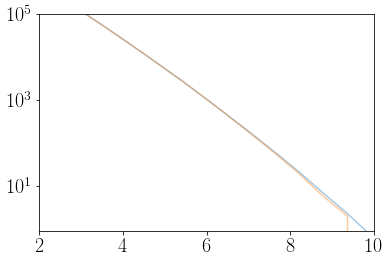

In [76]:
fig, ax = plt.subplots()
ax.plot(z_vals_mashian, mean_mashian, alpha=0.4, label = "Mean")
ax.plot(z_vals_mashian, med_mashian, alpha=0.4,label = "Median")
ax.set(xlim=(2,10), ylim=(0.9,1e5), yscale='log');

# Plots

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

-1.999308738987029
-1.9035397359766546
-1.81993463446
-1.746538521697003
-1.6817440249902789
-1.6242478691797866
-1.573007434137493
-1.5271321485040361
-1.4858834896887265
-1.448674983869545
-1.4150070422351426
-1.384423518479505
-1.3565551513072867
-1.331097843181145
-1.3077692178164044
-1.286352062686391
-1.2666508865170987
-1.2484701980345214
-1.2316579484699877
-1.2160838103074931
-1.2016174560310338
-1.188150279377273
-1.175617116588208
-1.1639310826531706
-1.1530052925614902
-1.1427745825551654
-1.133173788876194
-1.124159469019241
-1.115688180478972
-1.1077164807500521
-1.100200927327147
-1.0930980777049213
-1.0863862106307083
-1.0800436048518403
-1.0740268178629826
-1.0683141284114677
-1.0628838152446287
-1.0577141571097979
-1.0528051540069754
-1.0481350846834938
-1.0436822278866857
-1.0394248623638838
-1.035362988115088
-1.0314966051402987
-1.0277822709341808
-1.0242199854967344
-1.0208097488279595
-1.0175298396751886
-1.0143802580384218
-1.0113610039176595
-1.0084503560602336

  2%|█▋                                                                                 | 1/50 [00:51<42:08, 51.61s/it]

-2.0215878964069733
-1.9237677166114389
-1.8383719642791612
-1.7634038564249743
-1.6972215937055188
-1.6384939874640174
-1.5861560867750482
-1.5392982460564797
-1.4971661250694712
-1.4591606889184732
-1.4247716486183875
-1.3935330881393417
-1.3650678373619158
-1.3390652855995286
-1.3152370086432108
-1.2933611417168338
-1.2732380065218805
-1.254667924759834
-1.2374955910874041
-1.221587886638913
-1.2068116925486825
-1.1930560764286482
-1.180254478845971
-1.1683181538901992
-1.157158355650881
-1.1467085246951776
-1.13690210159025
-1.1276947133808721
-1.1190419871118182
-1.1108995498278624
-1.1032230285737787
-1.0959680503943414
-1.0891124288119371
-1.0826339773489533
-1.0764883230501638
-1.0706532794379557
-1.065106660034716
-1.0598262783628318
-1.0548121344223031
-1.0500420417355172
-1.0454938138248606
-1.0411452642127208
-1.0369963928990975
-1.033047199883991
-1.029253312212175
-1.0256147298836498
-1.0221314528984153
-1.0187812947788586
-1.0155642555249795
-1.0124803351367784
-1.009507

  4%|███▎                                                                               | 2/50 [01:26<37:09, 46.45s/it]

-1.996111679432059
-1.9006370203331855
-1.8172888772459634
-1.7441183458113765
-1.679522993556457
-1.6222035509085284
-1.5711206022094486
-1.525386313251222
-1.4842644312759985
-1.4471702849760735
-1.4136058210152538
-1.3831162950431026
-1.3553335806806952
-1.32995451502774
-1.3066975896768236
-1.2853462596991667
-1.2657056346588678
-1.2475808241200252
-1.2308202466324933
-1.2152939752390046
-1.200872082982291
-1.1874462973979631
-1.174951655007387
-1.163301537839051
-1.1524093279214431
-1.1422100617759297
-1.1326387759238765
-1.123652161379528
-1.1152069091571282
-1.1072597102709212
-1.0997672557351512
-1.0926862365640622
-1.085994998264776
-1.0796718863444152
-1.0736735918172235
-1.0679784601903233
-1.0625648369708363
-1.0574110676658846
-1.0525171522754684
-1.0478614363067094
-1.04342226526673
-1.0391779846626523
-1.035128594494476
-1.0312740947622012
-1.027571176480072
-1.0240198396480886
-1.0206200842662507
-1.0173502558416805
-1.0142103543743781
-1.0112003798643432
-1.00829867781

  6%|████▉                                                                              | 3/50 [02:04<34:34, 44.13s/it]

-2.0374149093187746
-1.9381375827895821
-1.8514697601969627
-1.7753849141225377
-1.7082167886889745
-1.6486143656173549
-1.5954968302845438
-1.5479409868666139
-1.5051812583388444
-1.466609686475722
-1.431708380936995
-1.4000044853250415
-1.3711152111275018
-1.344725320745961
-1.3205420935533205
-1.298340359836427
-1.277917466853443
-1.2590707618625303
-1.241642626064482
-1.2254979576314065
-1.2105016547354113
-1.1965411325199204
-1.183548840070988
-1.1714347095033524
-1.1601086729317525
-1.1495031794422426
-1.1395506781208764
-1.1302061350250239
-1.1214245162120537
-1.1131607877393357
-1.1053699156642394
-1.0980068660441336
-1.0910491219077036
-1.0844741662836337
-1.0782369652292934
-1.0723150017733674
-1.0666857589445407
-1.0613267197714973
-1.0562378842542377
-1.0513967354214466
-1.0467807563018086
-1.0423674299240082
-1.0381567562880456
-1.0341487353939207
-1.0302983332990032
-1.0266055500032927
-1.0230703855067893
-1.0196703228381778
-1.0164053619974582
-1.0132755029846305
-1.0102

  8%|██████▋                                                                            | 4/50 [02:43<32:37, 42.55s/it]

-2.0280812118646523
-1.9296632115288497
-1.8437455695936027
-1.7683192998873931
-1.7017325693358623
-1.642646053824665
-1.5899882940623247
-1.5428440852373724
-1.5004544770183454
-1.462216773553789
-1.427617567266537
-1.3961880947165686
-1.3675488807381528
-1.341387416371276
-1.317413514724496
-1.2954039551120895
-1.2751578389169038
-1.2564742675217877
-1.2391969864467343
-1.2231920632803086
-1.2083255656110765
-1.1944858830961755
-1.181606049529889
-1.1695967766379267
-1.158368776145999
-1.1478550818483888
-1.137988727539379
-1.1287250690818245
-1.1200194623385804
-1.111827263172502
-1.1041038274464445
-1.096804511023263
-1.0899069918343849
-1.0833889478112382
-1.0772057348166777
-1.071335030782131
-1.0657545136390258
-1.0604418613187896
-1.0553970738214227
-1.0505978290783522
-1.046021805021006
-1.0416466795808115
-1.0374724527577688
-1.033499124551878
-1.029682050825994
-1.0260212315801172
-1.022516666814247
-1.0191460344598116
-1.0159093345168104
-1.012806566985244
-1.0098154097965

 10%|████████▎                                                                          | 5/50 [03:22<30:58, 41.30s/it]

-2.0271667171774905
-1.928832911689684
-1.8429887707682582
-1.767627026893616
-1.7010972601052
-1.6420612920566122
-1.5894485800707345
-1.5423447022775283
-1.4999913576140345
-1.4617863658243742
-1.4272167585424282
-1.3958141733469573
-1.367199459706482
-1.341060376006843
-1.3171069836063203
-1.2951162527805147
-1.2748874567774664
-1.2562198688452155
-1.2389573681766826
-1.2229661369372276
-1.2081123572922108
-1.1942845143794323
-1.1814156992815725
-1.169416700108871
-1.1581983049715687
-1.1476936049523452
-1.1378356911338805
-1.128579957571295
-1.1198817983197087
-1.1116966074342414
-1.1039797789700134
-1.0966867069821449
-1.0897950884981957
-1.0832826205457258
-1.0771046971798555
-1.0712390154281446
-1.0656632723181534
-1.0603551648774416
-1.0553146931060096
-1.050519554031417
-1.0459474446812242
-1.041576062082991
-1.0374054062367175
-1.0334354771424037
-1.0296216688551698
-1.0259639813750154
-1.022462414701941
-1.019094665863506
-1.0158607348597113
-1.012760621690556
-1.00977202338

 12%|█████████▉                                                                         | 6/50 [04:02<30:08, 41.11s/it]

-1.9990818621439965
-1.9033337470202125
-1.8197468803585106
-1.7463667757989132
-1.6815864112232164
-1.624102795724769
-1.572873536578249
-1.5270082566641117
-1.4857685944685877
-1.4485682040836838
-1.41490760566185
-1.3843307523857584
-1.3564684634985245
-1.3310167077885962
-1.3076931705595318
-1.2862806866602237
-1.2665838074546731
-1.2484070843068829
-1.2315985016110769
-1.21602776027659
-1.201564561212757
-1.1881003218440234
-1.1755698926250568
-1.163886407495414
-1.1529630003946512
-1.1427345217774358
-1.1331358220984356
-1.1241234683274286
-1.115654027434193
-1.1076840663885072
-1.1001701521601495
-1.093068851718898
-1.0863584485496423
-1.080017226137271
-1.0740017514515627
-1.0682903079774064
-1.0628611791996911
-1.0576926486033065
-1.052784716188252
-1.048115665439417
-1.0436637798416906
-1.039407342879962
-1.035346354554231
-1.0314808148644978
-1.0277672907805406
-1.0242057823023596
-1.0207962894299545
-1.0175170956482145
-1.0143682009571398
-1.0113496053567301
-1.008439592331

 14%|███████████▌                                                                       | 7/50 [04:46<30:08, 42.05s/it]

-2.017946482634984
-1.92046155714254
-1.835358477482659
-1.7606473041465356
-1.694691864649153
-1.6361655326513078
-1.5840070070816379
-1.5373097599416874
-1.495322036305908
-1.4574468543216585
-1.4231756738922443
-1.392044175798944
-1.3636764825789833
-1.3377630480865488
-1.3140164366148126
-1.2922155437739078
-1.2721613756129537
-1.25365493818107
-1.2365414584053496
-1.2206882736518718
-1.205962721286717
-1.1922542491149515
-1.1794965258196146
-1.1676011096447598
-1.15647955883444
-1.1460655420716954
-1.1362927280395656
-1.1271168958600772
-1.118493824655257
-1.110379293547131
-1.1027290816577264
-1.0954989681090692
-1.088666842462173
-1.082210594278051
-1.07608600267873
-1.070270957225223
-1.064743347478543
-1.059481062999704
-1.0544841037887056
-1.049730359406561
-1.0451977194142836
-1.0408640733728867
-1.0367294212823701
-1.0327937631427342
-1.0290128780760053
-1.0253867660821834
-1.0219154271612685
-1.018576750874274
-1.0153707372211997
-1.0122973862020457
-1.0093345873778254
-1.

 16%|█████████████▎                                                                     | 8/50 [05:39<31:37, 45.17s/it]

-2.011322720672255
-1.914447625547822
-1.8298769199152654
-1.7556331126062477
-1.6900902664379136
-1.6319300539647057
-1.5800978132301768
-1.5336926871465293
-1.491967623494613
-1.4543293749239274
-1.4202725825803413
-1.3893358318579094
-1.3611455966470571
-1.3353942672104875
-1.3117962059349964
-1.290131691579657
-1.270202975027636
-1.2518123071620995
-1.234805883114399
-1.2190518701399788
-1.204418435494283
-1.1907957185568487
-1.1781178029553976
-1.1662968001935594
-1.1552448217749633
-1.1448959513273316
-1.1351842724783865
-1.1260658409799424
-1.1174967125838142
-1.1094329430418168
-1.1018305881057646
-1.0946457035274726
-1.0878563171828481
-1.0814404569477982
-1.075354178574138
-1.0695755099377748
-1.0640824789146157
-1.0588531133805683
-1.0538874133356326
-1.0491634066557158
-1.0446591212167253
-1.0403525848945687
-1.0362437976892456
-1.0323327596007563
-1.0285755263809155
-1.0249720980297232
-1.0215224745471794
-1.0182046838091914
-1.015018725815759
-1.0119646005668828
-1.009020

 18%|██████████████▉                                                                    | 9/50 [06:15<29:03, 42.53s/it]

-2.0080868209157083
-1.9115096456064022
-1.8271990201209136
-1.753183534666129
-1.687842252301044
-1.6298608998302495
-1.5781880586974184
-1.5319256422190208
-1.4903288955843252
-1.4528063958553978
-1.4188543383073315
-1.3880127273217333
-1.359909185493237
-1.3342370490762476
-1.3107115588784262
-1.2891136693672047
-1.2692462395632715
-1.2509121284873157
-1.2339580042665395
-1.2182524395814016
-1.2036640071123614
-1.190083184093135
-1.1774442568639516
-1.1656596072117842
-1.1546416169236051
-1.1443245723396442
-1.1346427598001312
-1.1255523701985521
-1.1170095944283935
-1.1089706233831418
-1.101391647956283
-1.0942288590413038
-1.0874603520849475
-1.0810642225339568
-1.0749966612818187
-1.0692357637752756
-1.0637596254610715
-1.058546341785949
-1.0535959127499084
-1.0488864337996928
-1.0443960003820454
-1.040102707943709
-1.0360065564846843
-1.032107546004971
-1.0283618673980552
-1.0247695206639373
-1.021330505802617
-1.0180229182608376
-1.0148467580385991
-1.0118020251359017
-1.008866

 20%|████████████████▍                                                                 | 10/50 [07:03<29:28, 44.20s/it]

-2.000900408993303
-1.9049848655862265
-1.8212518361977403
-1.747743416789142
-1.682849775150832
-1.625265641923676
-1.5739468016203664
-1.5280013201788272
-1.4866895449622164
-1.449424104758923
-1.4157046463146115
-1.3850743253535855
-1.3571633155574234
-1.3316670540756603
-1.3083027325471506
-1.2868528060787048
-1.267121484266453
-1.248912976706525
-1.2320750019736884
-1.2164770331320296
-1.2019885432456352
-1.1885007598679107
-1.1759484195308993
-1.1642445042773255
-1.1533019961499136
-1.1430556316807068
-1.1334401474017484
-1.1244120343344006
-1.1159277835000254
-1.1079438859199853
-1.1004168326156423
-1.0933031146083585
-1.0865809774088153
-1.0802286665276934
-1.0742026729863552
-1.0684812422954817
-1.063042619965754
-1.0578650515078534
-1.0529485369217797
-1.048271321718214
-1.0438116514078373
-1.0395477715013308
-1.0354796819986947
-1.0316073828999286
-1.027887365226395
-1.0243196289780936
-1.0209041741550247
-1.017619246267869
-1.0144648453166272
-1.0114409713012986
-1.00852586

 22%|██████████████████                                                                | 11/50 [07:35<26:16, 40.42s/it]

-2.00907344891043
-1.9124054376507233
-1.8280155135548717
-1.753930412614398
-1.6885276733112216
-1.630491786306358
-1.5787703441286198
-1.5324644153963676
-1.49082854481751
-1.4532707531895044
-1.4192867619324065
-1.3884161427775714
-1.3602861680789542
-1.3345898856574583
-1.3110422684896368
-1.2894240650189925
-1.2695379488446779
-1.2511865935658448
-1.2342165230929456
-1.2184961864920816
-1.2038940328293544
-1.190300436326515
-1.1776496215166148
-1.1658538877770543
-1.1548255344852347
-1.1444987861742069
-1.1348078673770214
-1.125708927782379
-1.1171581170789802
-1.1091115849555255
-1.1015254811007151
-1.09435595520325
-1.08758108210748
-1.0811789366577558
-1.0751056685427778
-1.069339352606896
-1.0638580636944608
-1.0586398766498224
-1.053684791472981
-1.048970883008287
-1.04447622610009
-1.040178895592741
-1.0360788914862393
-1.0321762137805854
-1.0284270121644798
-1.0248312866379223
-1.0213890372009131
-1.0180783386978023
-1.0148991911285898
-1.011851594493276
-1.0089136236362106

 24%|███████████████████▋                                                              | 12/50 [08:22<26:57, 42.56s/it]

-2.0073103597031765
-1.9108046709040512
-1.826556452217766
-1.7525957530904708
-1.6873028364001121
-1.6293644017774578
-1.5777298089271206
-1.5315016359301252
-1.4899356792439065
-1.4524409537023093
-1.4185140274971282
-1.3876952454991311
-1.359612505937036
-1.3339593720580216
-1.3104512954487542
-1.2888693927143615
-1.2690166687994586
-1.2506961286486606
-1.2337545538855574
-1.2180606144732251
-1.2034829803747409
-1.1899122098926684
-1.177282638008546
-1.165506711364425
-1.1544968766023564
-1.1441874687038789
-1.1345128226505306
-1.1254291617633367
-1.1168927093633234
-1.108859688771516
-1.10128632330894
-1.0941288362966213
-1.0873653393950722
-1.0809739442648059
-1.0749108742268476
-1.0691542409417103
-1.063682156069907
-1.0584727312719502
-1.0535259665478398
-1.048819973558089
-1.0443328639632101
-1.040042749423716
-1.0359496299396072
-1.0320535055108833
-1.0283105994585697
-1.0247209117826666
-1.021284442483174
-1.0179793032206048
-1.014805493994959
-1.0117630148062362
-1.008829977

 26%|█████████████████████▎                                                            | 13/50 [08:56<24:37, 39.94s/it]

-2.029518189199517
-1.9309678905682932
-1.8449347539315095
-1.769407092540059
-1.7027308528446765
-1.6435649103459584
-1.5908363654443807
-1.5436287830653503
-1.5011821926592053
-1.4628930882012134
-1.4282473719666031
-1.396775650380583
-1.3680979381683218
-1.3419013062799583
-1.3178951777406218
-1.2958560318004118
-1.2755826997844173
-1.2568740130177276
-1.2395735069754126
-1.2235470692075316
-1.2086605872641443
-1.1948023007703001
-1.1819051535010292
-1.1698797371563707
-1.158636643436365
-1.1481088161160415
-1.13822919897043
-1.1289530878495506
-1.1202357786034227
-1.1120325670820668
-1.104298749135502
-1.0969896206137488
-1.0900828294418168
-1.0835560235447161
-1.0773644987724664
-1.0714859030500776
-1.06589788430256
-1.060578090454923
-1.055526521507167
-1.0507208253843017
-1.046138650011337
-1.0417576433132831
-1.0375778052901397
-1.033599135941907
-1.029776931118605
-1.0261111908202332
-1.022601915046792
-1.0192267517232914
-1.015985700849731
-1.012878762426111
-1.00988358437744

 28%|██████████████████████▉                                                           | 14/50 [09:44<25:22, 42.30s/it]

-2.0037891883139887
-1.9076076834538669
-1.8236424731552483
-1.749930224363606
-1.6848566410118835
-1.6271128343970633
-1.5756516935567304
-1.5295788112104893
-1.4881524837599627
-1.4507837112887927
-1.4169707531274889
-1.3862554982299946
-1.3582670947971218
-1.3327001354648327
-1.3092710276808066
-1.287761623327874
-1.267975589100582
-1.2497165916934778
-1.2328319274245427
-1.2171907074234751
-1.2026620428199728
-1.1891368595554512
-1.1765497131947595
-1.1648133444910296
-1.1538404941973934
-1.1435657178787004
-1.1339235710997997
-1.124870424237257
-1.1163626476676385
-1.1083566117675105
-1.1008086869134388
-1.0936752434819894
-1.0869344666614458
-1.0805645416400904
-1.0745218387944897
-1.0687845433129264
-1.0633308403836839
-1.0581389151950449
-1.0532087677470097
-1.0485185832278612
-1.0440465468258822
-1.039770843729356
-1.0356914739382825
-1.031808437452662
-1.02807810464906
-1.0245004755274767
-1.0210755500879125
-1.0177815135186499
-1.0146183658196892
-1.0115861069910304
-1.00866

 30%|████████████████████████▌                                                         | 15/50 [10:51<28:59, 49.70s/it]

-2.0067003790764426
-1.9102508494074573
-1.826051656915753
-1.7521339974121237
-1.6868790763410004
-1.6289743575762454
-1.5773698122169495
-1.5311685405769184
-1.4896267721846748
-1.4521538657834563
-1.4182466825249107
-1.3874458347648901
-1.3593794372676553
-1.3337412316037744
-1.3102468349459178
-1.2886774912730623
-1.2688363201662876
-1.250526441206673
-1.2335947251795025
-1.2179099184721625
-1.203340767472039
-1.1897778941686208
-1.177155671755601
-1.1653865978245703
-1.1543831699671199
-1.1440797613769425
-1.1344107452477314
-1.1253323703752822
-1.11680088555539
-1.1087725395838506
-1.1012035812564591
-1.0940502593690111
-1.0872906983194044
-1.0809030225055363
-1.0748434807232028
-1.069090197370301
-1.0636212968447292
-1.0584149035443848
-1.0534710174692679
-1.048767763017276
-1.0442832645863072
-1.0399956465742588
-1.0359049089811312
-1.0320110518069239
-1.0282703238474329
-1.0246827251026576
-1.0212482555725986
-1.017945039655153
-1.0147730773503214
-1.0117323686581035
-1.008801

 32%|██████████████████████████▏                                                       | 16/50 [11:43<28:29, 50.27s/it]

-2.0154937292404833
-1.9182346215708452
-1.833328677950878
-1.7587905684440268
-1.692987910658014
-1.6345971513018038
-1.5825594477425668
-1.535970371898095
-1.4940799102368016
-1.4562924637777204
-1.4221006704259538
-1.3910412865296395
-1.3627393053229835
-1.3368858977047446
-1.313194293795198
-1.291443901379171
-1.2714361874630082
-1.2529726190530543
-1.2358987815986882
-1.2200823197708066
-1.2053908782403056
-1.191714160899599
-1.1789859900841348
-1.1671181289078443
-1.1560223404846581
-1.1456324471500245
-1.1358822712393917
-1.1267276943097253
-1.1181245979179903
-1.1100288636211528
-1.1023963729761779
-1.0951830075400308
-1.0883667080911947
-1.0819254154081523
-1.075815011047869
-1.0700134357888271
-1.06449863040951
-1.0592485356884
-1.0542631516254974
-1.0495204189992846
-1.0449982785882446
-1.0406746711708599
-1.0365495967471305
-1.0326230553170568
-1.0288509284376037
-1.0252332161087716
-1.0217699183305604
-1.018438975881453
-1.015240388761449
-1.0121741569705485
-1.00921822128

 34%|███████████████████████████▉                                                      | 17/50 [12:48<30:04, 54.69s/it]

-2.04335857498798
-1.9435340325650436
-1.8563884975716478
-1.7798842723851878
-1.7123459167381885
-1.6524149655489135
-1.599004646751974
-1.5511866758748494
-1.5081912560378896
-1.4694070779543127
-1.43431339667612
-1.4024347494247036
-1.3733862377602384
-1.3468508864969857
-1.3225343615339025
-1.3002102520240328
-1.2796747882051163
-1.260724200314892
-1.2432000007604913
-1.2269663430337403
-1.2118873806264654
-1.197849908115188
-1.1847860022458223
-1.172605098679585
-1.1612166330776943
-1.1505526821860628
-1.140545322750604
-1.1311492726019265
-1.1223192495706393
-1.114009971487351
-1.1061761561826706
-1.0987725214872068
-1.091776426316264
-1.0851652295851464
-1.078893649124463
-1.0729390438495179
-1.0672787726756159
-1.061890194518061
-1.0567733093768537
-1.051905476167298
-1.0472640538046982
-1.042826401204359
-1.0385925183662803
-1.034562405290462
-1.0306907798075131
-1.0269776419174332
-1.0234229916202229
-1.0200041878311858
-1.0167212305503228
-1.0135741197776333
-1.0105402144284

 36%|█████████████████████████████▌                                                    | 18/50 [13:42<29:07, 54.62s/it]

-1.9997004862364172
-1.9038954162039177
-1.820258828643226
-1.7468350745856585
-1.6820161759902974
-1.6244983668780213
-1.573238634465532
-1.5273460720004288
-1.48608187876121
-1.4488593600572701
-1.4151787389299455
-1.3845836972865435
-1.3567048347663129
-1.3312379393074585
-1.3079005282811704
-1.2864753073575947
-1.2667667116398635
-1.2485791762311083
-1.2317605951004316
-1.2161805916499207
-1.2017087892816638
-1.1882365408307338
-1.175698657998175
-1.1640082230520457
-1.153078318260404
-1.1428437553242945
-1.1332393459447607
-1.124221631255832
-1.1157471523915372
-1.1077724504859063
-1.100254066672968
-1.0931485420867517
-1.0864341472942722
-1.080089152862544
-1.0740700999255963
-1.0683552590504437
-1.062922900804101
-1.0577512957535828
-1.0528404438988892
-1.0481686158070345
-1.0437140820450335
-1.0394551131799008
-1.0353917092116365
-1.0315238701402405
-1.027808137099742
-1.0242445100901414
-1.020832989111438
-1.017551844730647
-1.0144010769477685
-1.0113806857628018
-1.0084689417

 38%|███████████████████████████████▏                                                  | 19/50 [14:47<29:45, 57.59s/it]

-2.0320001556759575
-1.9332213496590163
-1.8469887290286677
-1.7712859425620668
-1.7044551014759848
-1.6451519716218583
-1.5923011656808366
-1.5449841236514015
-1.5024391128493666
-1.4640612279078788
-1.4293351790699882
-1.3977904843836981
-1.3690462775069154
-1.342788903804975
-1.3187271125456883
-1.2966368647042947
-1.27631652515851
-1.257564458786049
-1.2402238382695798
-1.2241602401942462
-1.2092392411451913
-1.1953488216100352
-1.1824217698813495
-1.17036847034923
-1.1590993074037728
-1.1485470693375492
-1.1386445444431315
-1.1293469249155672
-1.1206094029499045
-1.112387170741191
-1.1046354204844748
-1.0973093443748039
-1.0903865385097018
-1.0838445989866927
-1.0776387180008247
-1.0717464916496213
-1.0661455160306066
-1.0608133872413048
-1.0557501052817155
-1.0509332662493631
-1.046340466241771
-1.0419493013564636
-1.0377597715934408
-1.0337718769527025
-1.0299408096292963
-1.026266569623223
-1.0227491569344818
-1.019366167660597
-1.0161176018015685
-1.0130034593573962
-1.0100013

 40%|████████████████████████████████▊                                                 | 20/50 [15:38<27:50, 55.69s/it]

-1.9966673907726933
-1.9011415689579378
-1.8177487614811876
-1.7445390196095485
-1.6799090521626412
-1.6225588933185366
-1.5714485704196919
-1.5256897734877883
-1.484545855223733
-1.4474318310076577
-1.4138493806078234
-1.3833435159865544
-1.3555459134943042
-1.330153247772623
-1.3068838595600925
-1.2855210878863912
-1.26586993787823
-1.2477354146623194
-1.2309658555594343
-1.2154312639873819
-1.201001643363969
-1.1875686632040352
-1.175067325216484
-1.1634109650131865
-1.1525129182060145
-1.1423081865038713
-1.1327317716156604
-1.1237403413473177
-1.1152905635047785
-1.107339105893979
-1.0998426363208547
-1.0927578225913412
-1.0860629986084065
-1.0797364982750184
-1.0737349893971124
-1.0680368058776566
-1.0626202816196189
-1.0574637505259668
-1.0525672125967005
-1.047909001734788
-1.043467451843197
-1.0392208968248955
-1.035169336679883
-1.0313127714081602
-1.0276078688156622
-1.0240546289023895
-1.0206530516683419
-1.017381471016487
-1.014239886946825
-1.011228299459356
-1.0083250424

 42%|██████████████████████████████████▍                                               | 21/50 [16:48<28:57, 59.92s/it]

-2.0089778382772505
-1.912318629608571
-1.8279363900608852
-1.7538580353111757
-1.6884612515827402
-1.6304306493269012
-1.5787139169047157
-1.5324122047912545
-1.4907801255755995
-1.453225753960846
-1.4192448572866674
-1.3883770492110266
-1.3602496360284644
-1.3345556935109564
-1.3110102205896224
-1.2893939856730159
-1.2695096803288353
-1.2511599961247788
-1.234191470946834
-1.2184725658401334
-1.203871741849809
-1.1902793831801375
-1.1776297203536852
-1.1658350607338734
-1.154807711684124
-1.1444819037270026
-1.1347918673850756
-1.1256937563400535
-1.1171437242736473
-1.1090979248675676
-1.1015125118035252
-1.0943436387632308
-1.0875693825875397
-1.0811678201173074
-1.0750951050342445
-1.0693293141792064
-1.0638485243930484
-1.0586308125166264
-1.0536761785499396
-1.048962699333844
-1.0444684517091944
-1.0401715125168467
-1.0360718817568007
-1.0321695594290563
-1.0284206992153242
-1.0248253011156048
-1.0213833651298976
-1.0180729680990583
-1.0148941100230868
-1.011846790901983
-1.0089

 44%|████████████████████████████████████                                              | 22/50 [17:34<26:03, 55.84s/it]

-2.033272324783939
-1.9343763938824294
-1.8480415247420552
-1.7722489752940627
-1.7053388909485867
-1.645965443659792
-1.5930519709910098
-1.5456788237775854
-1.5030833661268785
-1.4646599754182632
-1.4298927509008352
-1.3983106527585523
-1.3695323630450942
-1.3432438552164325
-1.3191535331959696
-1.2970370923093992
-1.2766926583498464
-1.2579183571104353
-1.240557175319152
-1.2244745301714126
-1.2095358388626338
-1.1956289490556629
-1.1826865693482074
-1.1706189778705454
-1.1593364527529542
-1.148771702593142
-1.1388574359888175
-1.129548792005119
-1.1208009097071856
-1.1125689281601558
-1.1048079864291689
-1.097473223579363
-1.0905422091433081
-1.0839925126535732
-1.0777792731752975
-1.07188006024105
-1.0662724433834003
-1.060933992134918
-1.0558647064956026
-1.0510421559980239
-1.0464439101747511
-1.0420475385583539
-1.0378530411488318
-1.0338604179461852
-1.030024808015553
-1.0263462113569348
-1.0228246279703308
-1.0194376273883103
-1.0161852096108734
-1.0130673746380203
-1.0100616

 46%|█████████████████████████████████████▋                                            | 23/50 [18:41<26:38, 59.19s/it]

-2.015383452159447
-1.9181344973777437
-1.8332374170976853
-1.7587070886315077
-1.6929112999914937
-1.6345266360524668
-1.5824943647142864
-1.5359101523080811
-1.4940240635962518
-1.4562405617724692
-1.4220523377054153
-1.3909961961012787
-1.3626971693412593
-1.3368464605628159
-1.3131573298221606
-1.2914092079317636
-1.271403582622849
-1.2529419416266399
-1.2358698865118658
-1.2200550757660094
-1.2053651678765527
-1.191689878249731
-1.1789630361292858
-1.1670964138402051
-1.1560017837074774
-1.1456129749748436
-1.1358638168860449
-1.1267101956035757
-1.11810799728993
-1.1100131081076017
-1.102381414219085
-1.0951688017868744
-1.0883532138922165
-1.0819125936163587
-1.0758028271217948
-1.070001857489772
-1.0644876278015376
-1.0592380811383384
-1.0542532175001744
-1.0495109799682927
-1.0449893116239406
-1.0406661555483647
-1.0365415117415653
-1.0326153802035423
-1.0288436470967899
-1.0252263124213081
-1.0217633761770968
-1.018432781445403
-1.0152345282262272
-1.0121686165195687
-1.00921

 48%|███████████████████████████████████████▎                                          | 24/50 [19:29<24:08, 55.72s/it]

-2.0325204467878075
-1.9336937390917304
-1.847419300914774
-1.7716798032270793
-1.704816553270763
-1.6454846650259194
-1.5926082296766233
-1.5452682417759394
-1.502702599245921
-1.4643061033776106
-1.4295632145300443
-1.398003222596255
-1.3692450765372697
-1.3429749696151099
-1.3189015098587962
-1.2968005495983443
-1.2764703559307684
-1.2577091959530826
-1.240360166296298
-1.2242887783584235
-1.2093605435374695
-1.1954633879984429
-1.1825300674403487
-1.1704709227951935
-1.1591962949949834
-1.1486389397387229
-1.1387316127254168
-1.1294294844210686
-1.120687725291681
-1.1124615058032572
-1.1047059964218005
-1.0973763676133137
-1.090450204610799
-1.0839050926472575
-1.0776962021886924
-1.0718011184681053
-1.066197426718498
-1.0608627121728715
-1.0557969748312264
-1.050977799926564
-1.046382772691886
-1.0419894783601935
-1.0377979169314873
-1.0338080884057668
-1.0299751632490353
-1.0262991414612928
-1.0227800230425392
-1.0193953932257762
-1.016145252011004
-1.0130295993982221
-1.01002602

 50%|█████████████████████████████████████████                                         | 25/50 [20:36<24:36, 59.07s/it]

-2.0421485502513446
-1.9424354112626794
-1.8553871300271676
-1.778968282977338
-1.7115052996243807
-1.6516412309233157
-1.598290517638158
-1.5505259112548373
-1.5075784739811984
-1.4688375787469994
-1.4337830617516647
-1.401939990829451
-1.3729238970842803
-1.346418159072324
-1.3221287711671694
-1.2998295751946534
-1.2793170287980284
-1.2603875896205476
-1.2428829469402967
-1.2266674058527773
-1.2116052714534917
-1.1975834646553578
-1.1845341380061267
-1.172366828236133
-1.1609910720757115
-1.150339022072613
-1.1403428307745886
-1.1309572665468055
-1.122137097754431
-1.1138370927626322
-1.1060120199365768
-1.098616647641432
-1.0916283600597816
-1.0850245413742088
-1.0787599599498812
-1.0728119999693826
-1.0671580456152963
-1.0617754810702063
-1.0566643063341121
-1.051801905589598
-1.0471656630192472
-1.0427329628056436
-1.0385038049487871
-1.0344781894486776
-1.0306108846704827
-1.0269018906142022
-1.023351207279836
-1.0199362188499679
-1.0166569253245978
-1.013513326703726
-1.01048280

 52%|██████████████████████████████████████████▋                                       | 26/50 [21:26<22:36, 56.52s/it]

-2.0074043547410376
-1.9108900120940158
-1.826634238710394
-1.7526669073871266
-1.6873681357572634
-1.6294245056854404
-1.5777852826633665
-1.531552964298542
-1.489983280314261
-1.4524851925496096
-1.4185552240526977
-1.387733678476148
-1.3596484206816075
-1.333992986437491
-1.3104828018144696
-1.2888989637899826
-1.2690444596437251
-1.2507222766553927
-1.2337791827091928
-1.2180838359915893
-1.2035048946890452
-1.1899329072902805
-1.177302202888527
-1.16552522027476
-1.1545143982399557
-1.1442040658773458
-1.134528552280162
-1.125444076843892
-1.1169068589640239
-1.1088731180360454
-1.1012990734554444
-1.0941409446177088
-1.0873768412205826
-1.0809848729618095
-1.0749212592368775
-1.0691641097435305
-1.0636915341795126
-1.0584816422425674
-1.053534433932695
-1.0488280189476396
-1.0443405069851448
-1.0400500077429546
-1.035956521221069
-1.0320600474194883
-1.0283168057337
-1.024726796163704
-1.0212900187095009
-1.0179845830688339
-1.0148104892417036
-1.0117677372281095
-1.0088344367257

 54%|████████████████████████████████████████████▎                                     | 27/50 [22:38<23:24, 61.08s/it]

-2.0120437665221913
-1.9151022868177425
-1.830473628305059
-1.7561789447211777
-1.6905911846943302
-1.6323911173825416
-1.5805233581122324
-1.534086432474719
-1.4923327763262164
-1.4546687357878358
-1.4205886057034867
-1.3896306552784778
-1.3614211024409166
-1.3356521266610089
-1.3120378945896598
-1.2903585344198738
-1.2704161615253546
-1.252012891279806
-1.234994813418331
-1.2192300048567322
-1.2045865425108118
-1.1909544904770721
-1.1782678872134145
-1.1664387839970403
-1.1553792321051515
-1.1450232699956493
-1.135304936126435
-1.1261802561361092
-1.117605255663273
-1.109535960346527
-1.1019283958244723
-1.0947385877357096
-1.0879445488995394
-1.081524292135262
-1.0754338430814783
-1.0696512145574888
-1.0641544193825936
-1.0589214703760936
-1.0539523675379885
-1.0492251236875787
-1.0447177516441648
-1.0404082642270471
-1.0362966614362257
-1.0323829432717004
-1.0286231353720723
-1.025017237737341
-1.021565250367507
-1.0182451860818704
-1.0150570448804312
-1.0120008267631897
-1.0090545

 56%|█████████████████████████████████████████████▉                                    | 28/50 [23:42<22:46, 62.11s/it]

-2.028110591046062
-1.9296898858550562
-1.843769882616185
-1.7683415399442848
-1.7017529793671082
-1.6426648399612127
-1.590005632987844
-1.5428601284826489
-1.5004693552556767
-1.462230600891378
-1.4276304437024327
-1.396200107365636
-1.3675601062860123
-1.3413979229147583
-1.317423362385128
-1.2954131978765473
-1.2751665252505
-1.2564824403684696
-1.2392046844560545
-1.22319932142091
-1.2083324151706922
-1.1944923522951143
-1.1816121647480036
-1.169602561801131
-1.1583742527262668
-1.147860269477239
-1.1379936440078753
-1.128729730954061
-1.1200238849516813
-1.1118314606366213
-1.1041078126447665
-1.0968082956120018
-1.0899105868562702
-1.083392363695514
-1.0772089807656187
-1.0713381153845267
-1.0657574448701808
-1.0604446465405233
-1.0553997203955545
-1.050600343753217
-1.0460241939314532
-1.041648948248206
-1.0374746067034752
-1.0335011692972609
-1.0296839906654482
-1.0260230708080371
-1.022518409725028
-1.019147684734363
-1.0159108958360423
-1.0128080430300659
-1.0098168036343764

 58%|███████████████████████████████████████████████▌                                  | 29/50 [24:44<21:43, 62.05s/it]

-2.0270775865776662
-1.9287519870831904
-1.8429150098878548
-1.7675595549792968
-1.7010353401251304
-1.6420042986504475
-1.5893959772153226
-1.5422960302585675
-1.4999462199977356
-1.4617444164291176
-1.4271776939939993
-1.3957777293561626
-1.367165403624384
-1.341028501241185
-1.3170771077603352
-1.2950882120693503
-1.274861104166994
-1.25619507405203
-1.2389340139457192
-1.222944117180571
-1.2080915770890943
-1.194264888115047
-1.1813971469246836
-1.1693991490730102
-1.158181690115033
-1.147677866717007
-1.137820775545186
-1.1285658143770738
-1.119868380990173
-1.111683873161987
-1.1039676886700185
-1.0966752252917709
-1.0897841819159957
-1.0832722574314444
-1.07709484961562
-1.0712296573572742
-1.0656543795451583
-1.060346715068024
-1.0553066639258712
-1.0505119250074517
-1.0459401972015165
-1.0415691793968178
-1.037398871593355
-1.0334292737911286
-1.0296157837676414
-1.0259584015228933
-1.0224571270568845
-1.0190896592583667
-1.0158559981273394
-1.012756143663803
-1.00976779475650

 60%|█████████████████████████████████████████████████▏                                | 30/50 [25:48<20:54, 62.70s/it]

-2.037914768209879
-1.9385914211362847
-1.8518834232033603
-1.7757633075849264
-1.7085640460016802
-1.648933993902836
-1.595791835647765
-1.5482139474600962
-1.505434397427718
-1.4668449455027766
-1.431927461274137
-1.4002088691490246
-1.371306203171383
-1.3449040796126959
-1.3207096421536255
-1.298497616702375
-1.278065256576326
-1.2592098150928608
-1.2417736003877207
-1.2256214480058276
-1.2106181934921025
-1.1966511998006468
-1.183652884703921
-1.1715331385652061
-1.1602018517477832
-1.1495914420241127
-1.1396343271666556
-1.130285452357052
-1.121499762776943
-1.1132322036079683
-1.1054377200317687
-1.0980712572299849
-1.0911102877934367
-1.0845322843129446
-1.0782921919701491
-1.0723674833558703
-1.0667356310609284
-1.0613741076761438
-1.0562829132015163
-1.0514395202278664
-1.046821401346014
-1.0424060291467796
-1.0381934036301632
-1.0341835247961646
-1.0303313378264243
-1.0266368427209425
-1.023100039479719
-1.019698400693574
-1.016431926362508
-1.0133006164865201
-1.010281943656

 62%|██████████████████████████████████████████████████▊                               | 31/50 [26:38<18:36, 58.75s/it]

-2.0274814422265606
-1.9291186609250737
-1.843249224492907
-1.7678652739332055
-1.701315902959666
-1.6422625389077186
-1.5896343236457073
-1.5425165658528428
-1.5001507410192017
-1.4619344914457275
-1.427354697611002
-1.3959428590824257
-1.3673197136050366
-1.3411729275571025
-1.317212476861299
-1.2952152660735319
-1.274980509294115
-1.256307420623363
-1.23903983325041
-1.2230438899087983
-1.208185733332071
-1.1943538157981808
-1.181481208673899
-1.1694786737815879
-1.1582569729436094
-1.1477491775267346
-1.1378883588977355
-1.128629897967793
-1.1199291756480878
-1.1117415728498012
-1.104022470484114
-1.0967272494622073
-1.0898336002396718
-1.0833192132720977
-1.0771394694706662
-1.0712720592909675
-1.0656946731885926
-1.0603850016191314
-1.0553430445825844
-1.0505464925345418
-1.045973035930594
-1.0416003652263321
-1.0374284804217555
-1.0334573815168646
-1.02964244942284
-1.0259836841396819
-1.0224810856673903
-1.0191123444615557
-1.0158774605221783
-1.0127764338492578
-1.009786954898

 64%|████████████████████████████████████████████████████▍                             | 32/50 [27:47<18:32, 61.83s/it]

-2.028080946257178
-1.9296629703750776
-1.8437453497875966
-1.7683190988223854
-1.701732384815512
-1.6426458839854101
-1.5899881373068268
-1.5428439401956913
-1.5004543425091164
-1.4622166485453973
-1.4276174508549335
-1.3961879861141766
-1.367548779251683
-1.341387321385087
-1.3174134256950494
-1.2954038715513092
-1.275157760386631
-1.2564741936337807
-1.2391969168515748
-1.223191997661857
-1.2083255036864706
-1.194485824610285
-1.181605994244222
-1.1695967243361771
-1.1583687266340459
-1.1478550349487502
-1.1379886830912114
-1.1287250269353775
-1.1200194223551962
-1.1118272252246155
-1.1041037914175829
-1.0968044768080463
-1.0899069593329795
-1.0833889169293567
-1.0772057054711255
-1.0713350028952595
-1.0657544871387332
-1.06044183613852
-1.0553970498946201
-1.0505978063440073
-1.0460217834236558
-1.041646659070539
-1.0374724332846572
-1.0334991060660104
-1.0296820332885464
-1.026021214952265
-1.0225166510571664
-1.0191460195402244
-1.015909320401439
-1.0128065536408104
-1.0098153971

 66%|██████████████████████████████████████████████████████                            | 33/50 [28:31<16:02, 56.59s/it]

-2.028636287436
-1.930167182917732
-1.844204927691873
-1.7687394924078572
-1.70211818626633
-1.6430009897002482
-1.5903158870559766
-1.5431471982960354
-1.5007355789990995
-1.4624780203599992
-1.4278608482113682
-1.3964150557047403
-1.367760970629454
-1.341585921753199
-1.317599571503115
-1.2955785832846953
-1.2753219541628833
-1.2566286812026224
-1.2393424287877577
-1.2233291949615843
-1.2084549777673983
-1.1946081089079459
-1.1817215874048748
-1.1697060786203821
-1.158472247916665
-1.1479530943153713
-1.1380816168381487
-1.128813148166096
-1.1201030209803111
-1.1119065679618934
-1.1041791217919408
-1.0968760151515522
-1.0899749143812767
-1.0834534858216636
-1.0772670621538114
-1.0713933097182695
-1.065809894855587
-1.0604944839063133
-1.0554470768704485
-1.0506453400885414
-1.046066939901142
-1.0416895426487989
-1.0375131483315123
-1.0335377569492825
-1.0297187011832076
-1.0260559810332879
-1.0225495964995233
-1.019177213922463
-1.0159388333021073
-1.012834454638456
-1.00984174427205

 68%|███████████████████████████████████████████████████████▊                          | 34/50 [29:51<16:57, 63.58s/it]

-2.0356808953976535
-1.9365632144525877
-1.850034760390996
-1.7740722646066056
-1.7070121506898146
-1.647505572903108
-1.594473454656474
-1.5469940846959434
-1.5043031171035914
-1.4657935712975363
-1.4309483897450637
-1.3992954764380432
-1.3704526584175125
-1.3441052050113849
-1.3199608663098652
-1.297794834690034
-1.2774047832912647
-1.2585883852529294
-1.2411882752389851
-1.2250695686756798
-1.2100973809892626
-1.1961593083682736
-1.183187908525837
-1.171093258412785
-1.1597854349799506
-1.1491969959404573
-1.1392604990074295
-1.1299309826562836
-1.1211634853624357
-1.1129130456013019
-1.1051347018482982
-1.097783492578841
-1.0908369370306386
-1.0842725544413985
-1.0780453832865373
-1.072132942803763
-1.0665127522307833
-1.0611623308053069
-1.0560816785273335
-1.0512483146345712
-1.046639758364728
-1.0422335289555122
-1.0380296264069235
-1.034028050718962
-1.0301838403670442
-1.0264969953511696
-1.0229675156713385
-1.019572920565259
-1.0163132100329308
-1.0131883840743543
-1.01017596

 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [30:30<14:00, 56.03s/it]

-2.029059090309922
-1.9305510595691162
-1.8445548222542238
-1.7690595544217942
-1.7024119119405456
-1.6432713455148455
-1.5905654157081863
-1.5433780805018849
-1.500949695295083
-1.462677012904745
-1.4280461561008782
-1.3965879326300106
-1.3679225201917131
-1.3417371239503377
-1.3177412915584972
-1.2957115981335856
-1.2754469612812585
-1.2567462986071702
-1.2394532126934974
-1.2234336486106765
-1.208553551429144
-1.1947012087075972
-1.1818095929812547
-1.1697893342970738
-1.1585510627020124
-1.148027750731289
-1.1381523709201218
-1.1288802382919898
-1.1201666678703717
-1.1119669746787464
-1.1042364737405927
-1.09693048007939
-1.0900266512068773
-1.083502644634794
-1.0773137753866189
-1.0714377009740919
-1.065852078908952
-1.0605345667029389
-1.0554851643560526
-1.0506815293800322
-1.0461013192866178
-1.041722191587548
-1.0375441462828234
-1.033567183372444
-1.0297466178798884
-1.0260824498051566
-1.0225746791482488
-1.0192009634209043
-1.0159613026231233
-1.0128556967549056
-1.00986180

 72%|███████████████████████████████████████████████████████████                       | 36/50 [31:48<14:40, 62.86s/it]

-2.006099058041307
-1.9097048902392206
-1.8255540279415952
-1.7516787970494994
-1.686461332192701
-1.628589850638579
-1.5770149262010371
-1.5308401740127842
-1.4893222505253352
-1.451870853509011
-1.4179831329163064
-1.3871999647908044
-1.3591496773582625
-1.3335261879810694
-1.3100452770671565
-1.2884883141610879
-1.2686585318529697
-1.2503591627329094
-1.2334371654821008
-1.217761361827282
-1.2032005734951907
-1.189645485258109
-1.1770305079794054
-1.1652681894769055
-1.1542710775684342
-1.1439735831173607
-1.134310116987054
-1.1252369530864268
-1.1167103653243915
-1.1086866276098608
-1.1011220138517475
-1.093972797958964
-1.0872171168859668
-1.080833107587212
-1.0747770439716127
-1.0690270629936247
-1.0635613016077046
-1.0583578967683087
-1.053416848475437
-1.0487162936835457
-1.0442343693470912
-1.0399492124205298
-1.0358608229038615
-1.0319692007970864
-1.0282306200091171
-1.0246450805399536
-1.021212582389596
-1.0179112625125
-1.0147411209086663
-1.011702157578095
-1.008772509475

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [32:25<11:53, 54.90s/it]

-2.0062246534288155
-1.9098189224271729
-1.8256579656058256
-1.7517738728286538
-1.6865485846504051
-1.6286701609803331
-1.5770890497458416
-1.530908758551587
-1.48938585467948
-1.4519299650886857
-1.418038179411084
-1.3872513186149142
-1.3591976663411318
-1.333571103235229
-1.3100873756108782
-1.2885278267862876
-1.2686956657478459
-1.250394101481941
-1.2334700743113194
-1.217792390226906
-1.203229855219627
-1.1896731409485863
-1.177056650409247
-1.1652929209288923
-1.1542944898348062
-1.143995760122451
-1.1343311347872898
-1.1252568824929643
-1.116729271903116
-1.1087045716813873
-1.1011390504914194
-1.0939889769968545
-1.0872324855295132
-1.0808477104212166
-1.0747909203356065
-1.0690402496045037
-1.0635738325597293
-1.058369803533104
-1.053428162524628
-1.0487270438661218
-1.0442445818894068
-1.0399589109263037
-1.0358700309768123
-1.031977942040933
-1.0282389127823073
-1.0246529432009353
-1.0212200332968169
-1.0179183174017732
-1.014747795515804
-1.0117084676389092
-1.008778468102

 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [33:43<12:20, 61.75s/it]

-2.0158892507008335
-1.9185937285285186
-1.8336559955184848
-1.7590899784125082
-1.6932626836427158
-1.634850062370292
-1.582792875524184
-1.5361863563978677
-1.4942802106493476
-1.4564786163011565
-1.4222740212984148
-1.3912030085475373
-1.362890430877526
-1.337027343559324
-1.3133268693445213
-1.2915683334266481
-1.2715531284798827
-1.253082647178402
-1.2360024171576782
-1.2201800335338293
-1.205483091422974
-1.1918012534218774
-1.1790683170885987
-1.1671960125005503
-1.1560960697351446
-1.1457022863504405
-1.1359484599044973
-1.1267904554360215
-1.1181841379837187
-1.1100853725862954
-1.1024500242824575
-1.0952339581109114
-1.0884151065910102
-1.0819714022421065
-1.075858710102907
-1.0700549626927642
-1.0645380925310317
-1.0592860321370625
-1.0542987815108562
-1.0495542731717662
-1.0450304396391457
-1.0407052134323473
-1.0365785945513715
-1.0326505829962178
-1.0288770438055928
-1.0252579769794963
-1.0217933825179282
-1.0184611929402418
-1.0152614082464368
-1.0121940284365136
-1.0092

 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [34:21<10:02, 54.77s/it]

-2.0001310476153025
-1.9042863370574317
-1.8206151438305676
-1.7471610097922268
-1.682315291580812
-1.6247736837680007
-1.573492742011136
-1.5275811909341974
-1.486299924127802
-1.4490620041492055
-1.415367447250884
-1.3847597465329247
-1.3568693487906367
-1.3313919160907446
-1.3080448489237786
-1.286610763051685
-1.2668940126602157
-1.248698951935122
-1.2318734119097665
-1.2162869620413173
-1.2018091717869417
-1.188331349027613
-1.1757882784919154
-1.1640930064846269
-1.1531585793105266
-1.1429197816981977
-1.1333113983762249
-1.124289952496997
-1.115811967212903
-1.1078339656763327
-1.1003124710396752
-1.0932040064553195
-1.0864868334994606
-1.080139213748293
-1.074117670354206
-1.0684004648933938
-1.0629658589420516
-1.057792114076374
-1.0528792302963605
-1.0482054691782063
-1.0437490922981056
-1.0394883612322534
-1.0354232759806494
-1.031553836543294
-1.027836566072576
-1.0242714645684954
-1.0208585320310526
-1.0175760300364418
-1.0144239585846633
-1.0114023176757172
-1.00848936888

 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [35:32<09:57, 59.71s/it]

-2.035434295212353
-1.936339318024246
-1.8498306840489627
-1.7738855881272992
-1.7068408349061324
-1.6473478876126602
-1.59432791682864
-1.5468594224259902
-1.5041782335667897
-1.465677508703277
-1.4308403087392112
-1.3991946458041113
-1.3703584344790167
-1.3440170161836071
-1.3198782079504414
-1.2977172536507195
-1.2773318727685212
-1.2585197847879255
-1.2411236604187728
-1.2250086459837823
-1.210039887805674
-1.1961050078200477
-1.183136579188263
-1.1710446994588004
-1.159739466180139
-1.149153452513639
-1.1392192316206602
-1.1298918522754426
-1.1211263632522261
-1.1128778133252504
-1.1051012512687557
-1.0977517258569818
-1.0908067614770487
-1.0842438825160763
-1.0780181377483047
-1.0721070515608535
-1.0664881483408428
-1.0611389524753927
-1.0560594639645031
-1.051227207195294
-1.0466197065548852
-1.042214486430397
-1.038011546821829
-1.0340108877291816
-1.0301675579266942
-1.0264815574143673
-1.0229528861922006
-1.0195590686473142
-1.016300104779708
-1.0131759945893821
-1.0101642624

 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [36:19<08:23, 55.94s/it]

-2.0429487921535467
-1.943161977236238
-1.8560493778675102
-1.7795740665484843
-1.7120612362245262
-1.6521529352297166
-1.59876280223132
-1.5509629035909582
-1.50798373336461
-1.469214213302612
-1.4341337952663615
-1.402267196172787
-1.3732296630498775
-1.3467043405089194
-1.3223970056889627
-1.3000813333123542
-1.2795536306292064
-1.260610204889631
-1.2430926283992711
-1.2268651059915348
-1.2117918424998297
-1.1977596752853295
-1.1847007067647382
-1.1725244068269944
-1.161140245361037
-1.15048032478357
-1.1404767475112974
-1.1310842484886883
-1.1222575626602125
-1.113951424970339
-1.1061205703635373
-1.0987197337842767
-1.091726282704792
-1.0851175845973176
-1.0788483744063233
-1.0728960196040433
-1.0672378876627127
-1.0618513460545658
-1.0567363947796027
-1.0518704013100584
-1.0472307331181672
-1.0427947576761638
-1.0385624749840485
-1.034533885041821
-1.0306637227939508
-1.0269519882404379
-1.0233986813812823
-1.0199811696887184
-1.0166994531627467
-1.0135535318033668
-1.01052077308

 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [37:24<07:47, 58.44s/it]

-2.0377168231325746
-1.9384117002826189
-1.8517196118613262
-1.7756134630498046
-1.7084265314414084
-1.6488074204902106
-1.5956750129594677
-1.5481058545427957
-1.5053341538641691
-1.4667517824779197
-1.431840705041442
-1.4001279327636604
-1.371230569956563
-1.3448332907594327
-1.3206432925873184
-1.2984353426825652
-1.2780067315632841
-1.2591547497475861
-1.2417217343051128
-1.225572545581271
-1.2105720439214682
-1.196607612946877
-1.183611682830201
-1.1714941604683784
-1.1601649527583473
-1.149556489872811
-1.1396012019844735
-1.1302540425418035
-1.1214699649932705
-1.1132039227873431
-1.1054108693724907
-1.098045758197182
-1.0910860659856518
-1.0845092694621348
-1.0782703220750998
-1.0723467005487812
-1.0667158816074138
-1.061355341975232
-1.0562650816522359
-1.05142257736266
-1.0468053058307387
-1.0423907437807065
-1.0381788912125638
-1.0341697481263101
-1.0303182679704148
-1.0266244507448778
-1.0230882964496992
-1.0196872818091132
-1.01642140682312
-1.0132906714917198
-1.010272552

 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [38:16<06:36, 56.60s/it]

-2.0353426552017684
-1.9362561150410929
-1.8497548464816822
-1.7738162165876195
-1.706777171611594
-1.647289289596328
-1.5942738329759982
-1.546809380079798
-1.5041318251319362
-1.4656343782516372
-1.430800144355278
-1.3991571757578112
-1.3703234195713412
-1.343984244005836
-1.3198474909705524
-1.2976884234726105
-1.2773047782184184
-1.2584942919143844
-1.2410996486654928
-1.2249860062760158
-1.2100185225502254
-1.1960848289916817
-1.1831175045025208
-1.1710266542855912
-1.1597223835437405
-1.1491372711791048
-1.1392038960938204
-1.1298773108893114
-1.1211125681670018
-1.1128647205283153
-1.1050888205746765
-1.0977399209075092
-1.0907955478275253
-1.084233227635437
-1.0780080129326683
-1.0720974300199313
-1.0664790051979378
-1.0611302647674001
-1.056051208728318
-1.0512193633814038
-1.046612255027369
-1.0422074099669263
-1.0380048282000753
-1.034004509726816
-1.0301615071485726
-1.0264758204653448
-1.022947449677133
-1.019553921084649
-1.0162952346878928
-1.0131713904868644
-1.01015991

 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [39:15<05:44, 57.38s/it]

-1.9997878083138376
-1.9039746987933692
-1.8203310928636158
-1.7469011774474983
-1.682076839570529
-1.6245542038479888
-1.5732901699721018
-1.5273937564299769
-1.486126100503606
-1.4489004582698655
-1.4152170108312794
-1.3846194018031959
-1.3567381998266115
-1.331269167311758
-1.3079297979252797
-1.2865027791030565
-1.2667925295373808
-1.2486034679205442
-1.231783475457663
-1.2162021646102656
-1.2017291478398795
-1.1882557688644453
-1.1757168339147264
-1.164025417965075
-1.1530945959898438
-1.142859174219796
-1.133253958885696
-1.1242354874747196
-1.1157602974740433
-1.1077849263708424
-1.1002659116522935
-1.0931597908055726
-1.0864448325742673
-1.0800993057019659
-1.0740797476758444
-1.0683644272394908
-1.062931613136493
-1.057759574110439
-1.052848310161329
-1.048176090032751
-1.043721182468293
-1.0394618562115427
-1.0353981112625004
-1.031529947621166
-1.0278139027747155
-1.024249976723149
-1.0208381694664665
-1.0175567497482558
-1.014405717568517
-1.0113850729272504
-1.008473084568

 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [40:14<04:49, 57.93s/it]

-2.0316699540887395
-1.9329215487650273
-1.8467154675468445
-1.7710359797743738
-1.7042257069050986
-1.6449408284991414
-1.592106288204599
-1.5448038087208884
-1.5022718917987452
-1.4639058182402243
-1.4291904568767055
-1.3976554705542317
-1.3689201101481707
-1.3426708175558846
-1.3186164316820657
-1.2965329824534015
-1.2762188968039103
-1.2574726016676103
-1.2401373179931823
-1.2240786637366383
-1.209162256853991
-1.1952761123085835
-1.182353039078422
-1.1703034491341813
-1.1590377544465362
-1.1484887639934929
-1.1385892867530572
-1.1292945287105667
-1.1205596958513588
-1.1123399941607708
-1.1045906296241401
-1.0972668082268042
-1.090346132961432
-1.0838062068206915
-1.0776022357899209
-1.0717118228617883
-1.0661125710289627
-1.0607820832841128
-1.0557203596272384
-1.0509050030510083
-1.0463136165480915
-1.0419238031111562
-1.0377355627402025
-1.0337488954352307
-1.029919007181578
-1.0262458979792446
-1.02272956782823
-1.0193476197212035
-1.0161000536581646
-1.0129868696391136
-1.0099

 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [41:08<03:46, 56.57s/it]

-2.030929792830037
-1.9322495319860513
-1.846102940017691
-1.7704756772842303
-1.703711508969962
-1.6444675419810686
-1.591669461842497
-1.5443996249401386
-1.5018970585208304
-1.4635574606923554
-1.4288660557687496
-1.3973528311671772
-1.368637300511057
-1.3424061220784984
-1.3183683356991742
-1.2963001258574482
-1.276000058589248
-1.2572666999305007
-1.2399433790202616
-1.2238958065491483
-1.2089896932077797
-1.1951131312383374
-1.1821989759861307
-1.170157701244905
-1.1588997808084056
-1.1483580700219422
-1.1384654242308236
-1.1291770803319228
-1.1204482752221123
-1.112234245798265
-1.1044902289572536
-1.097171461595951
-1.0902555621627934
-1.0837201491062174
-1.0775204593230956
-1.0716341112618644
-1.0660387233709603
-1.0607119140988195
-1.0556536834454422
-1.0508416498592645
-1.046253431788723
-1.0418666476822542
-1.037681297539858
-1.0336973813615342
-1.0298701360441558
-1.0261995615877226
-1.0226856579922348
-1.0193060437061288
-1.0160607187294044
-1.0129496830620617
-1.00995055

 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [42:09<02:54, 58.10s/it]

-2.0347462220913064
-1.9357145937806175
-1.84926126255634
-1.7733647163867285
-1.7063628231567933
-1.6469079081787046
-1.5939218317021988
-1.5464836826905919
-1.5038297788207806
-1.4653536664832416
-1.43053873704764
-1.3989133043732354
-1.370095527298476
-1.343770948396202
-1.3196475714840497
-1.2975007841140476
-1.2771284350830212
-1.2583283731877963
-1.2409433697147927
-1.2248386571952274
-1.2098794681603173
-1.1959534963860767
-1.182993358138114
-1.1709092084372406
-1.159611202304268
-1.1490319560048046
-1.1391040858044588
-1.1297826692136366
-1.1210227837427431
-1.1127795069021846
-1.1050079162023665
-1.0976630891536943
-1.0907225645113712
-1.0841638810305998
-1.0779421162217857
-1.0720348088401321
-1.0664194976408414
-1.0610737213791168
-1.0559974800549583
-1.0511683124235682
-1.04656375724015
-1.0421613532599063
-1.0379611004828369
-1.033962998908942
-1.0301221260486273
-1.0264384819018926
-1.0229120664687381
-1.0195204185043667
-1.0162635380087781
-1.0131414249819726
-1.01013161

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [42:59<01:51, 55.66s/it]

-1.997271843259949
-1.9016903712746682
-1.8182489819185
-1.7449965904831939
-1.680328971764189
-1.6229454026226515
-1.5718053045475149
-1.526019850060576
-1.4848519627164962
-1.4477163171028002
-1.4141143026829348
-1.383590666358309
-1.355776869906253
-1.330369411261039
-1.3070864670759192
-1.285711250161089
-1.2660486520457228
-1.2479035642589955
-1.2311242357680436
-1.2155805942589835
-1.2011425674179317
-1.1877017616499856
-1.1751931407982035
-1.1635299899866633
-1.1526255943394426
-1.1424149176995997
-1.1328329239101929
-1.1238362555332613
-1.1153815551308437
-1.1074254652649789
-1.0999246284977058
-1.0928356873910632
-1.0861369632260707
-1.0798067772837476
-1.073801772126133
-1.0681002690342463
-1.0626805892891067
-1.057521054171734
-1.0526216636821277
-1.0479607391013077
-1.0435166017102935
-1.039267572790104
-1.0352136523407396
-1.0313548403622002
-1.0276477794165249
-1.0240924695037132
-1.0206889106237658
-1.0174154240577014
-1.0142720098055205
-1.0112586678672228
-1.0083537195

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [44:03<00:58, 58.16s/it]

-2.033362574713073
-1.934458334764861
-1.8481162119341352
-1.7723172945413004
-1.705401588538688
-1.6460231528065679
-1.5931052344491552
-1.5457281070346336
-1.5031290705951565
-1.4647024516268445
-1.429932306033801
-1.3983475544241202
-1.3695668468138782
-1.3432761302751381
-1.3191837842319583
-1.2970654851643835
-1.276719341904454
-1.2579434632842106
-1.2405808228396844
-1.2244968264589022
-1.2095568800298913
-1.1956488217926737
-1.1827053546912634
-1.170636749317678
-1.1593532762639354
-1.1487876384740492
-1.1388725388920329
-1.1295631128138954
-1.1208144955356458
-1.1125818223532928
-1.1048202285628457
-1.0974848494603133
-1.0905532526937
-1.0840030059110106
-1.0777892444082537
-1.0718895358334342
-1.0662814478345561
-1.0609425480596244
-1.0558728365086387
-1.0510498808296036
-1.0464512486705235
-1.0420545076794032
-1.0378596578562425
-1.0338666992010415
-1.0300307670098088
-1.0263518612825449
-1.0228299820192495
-1.019442696867927
-1.016190005828578
-1.0130719089012017
-1.01006597

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [44:55<00:00, 53.90s/it]


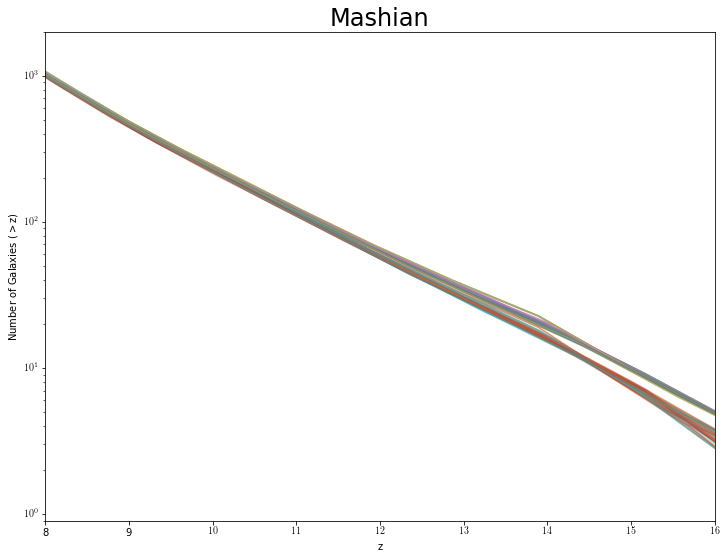

In [9]:
from tqdm import tqdm
N=50
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design matching the idealized survey from Mashian et al. 2015
    mashian = survey(31.5, 200./3600, "cv_mashian.csv",nearest_wavelength(x,14873.4))
    mean_mashian, med_mashian, z_vals_mashian = mean_median(mashian)
    summed+=med_mashian
    summean+=mean_mashian
    plt.rcParams.update({'font.size': 20})
    plt.rc('font', family='serif')
    plt.rc('text', usetex=True)

    ax.plot(z_vals_mashian, mean_mashian, alpha=0.4, label = "Mean")
    ax.plot(z_vals_mashian, med_mashian, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e3), xlim=(8,16), title='Mashian')
    if save==1:
        plt.savefig("figs/"+file+"/mashian.pdf")
winsound.Beep(400,300)

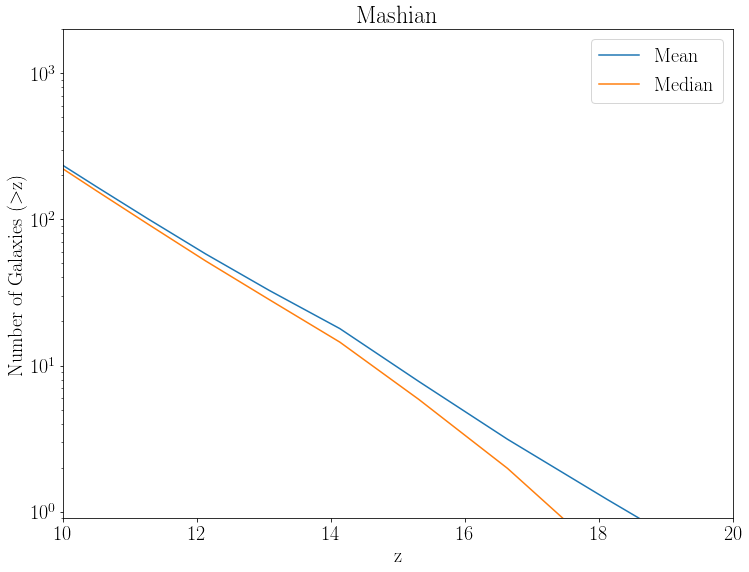

In [10]:
fig, ax =plt.subplots(figsize=(12,9))
plt.rcParams.update({'font.size': 20})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e3), xlim=(10,20), title='Mashian')
if save==1:
    plt.savefig("figs/"+file+"/mashian.pdf")

In [11]:
from scipy.interpolate import interp1d
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
def find_min(f):
    x=8
    while f(x)>1:
        x+=0.001
    print(f(x))
    return x

z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9995762101078094
0.9997352253722362


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in add
  if sys.path[0] == '':


(17.414999999997296, 18.126, 18.42399999999853)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

-1.9989188707917394
-1.9031857618044818
-1.8196119953059664
-1.7462433912533597
-1.6814731793892204
-1.6239985730183266
-1.5727773427845002
-1.5269192511126726
-1.4856860522088844
-1.4484914920602856
-1.4148361691003741
-1.3842641079858224
-1.3564061858196506
-1.3309584190396402
-1.3076385371951598
-1.2862294091703386
-1.2665356169608937
-1.2483617425625415
-1.2315557941941728
-1.2159874931862655
-1.201526560869297
-1.1880644316853326
-1.1755359662996108
-1.1638543122657834
-1.1529326171375025
-1.1427057415800068
-1.1331085462585353
-1.1240976049499138
-1.1156294914309683
-1.107660779478525
-1.1001480428694093
-1.0930478553804472
-1.086338503900052
-1.0799982753166364
-1.0739837434070265
-1.0682731950596351
-1.062844917162875
-1.0576771966051597
-1.052770033386489
-1.0481017143952753
-1.043650526519932
-1.0393947566488724
-1.035334404782096
-1.031469470919603
-1.027756528838219
-1.0241955785379446
-1.0207866200187794
-1.0175079401691365
-1.0143595389890157
-1.0113414164784174
-1.008431

  2%|█▋                                                                                 | 1/50 [00:58<47:38, 58.33s/it]

-2.040341755444809
-1.9407949627632712
-1.8538918997033398
-1.777600538290113
-1.7102500999664507
-1.6504858994157519
-1.5972241883847365
-1.5495392652403934
-1.506663474969983
-1.4679872091810342
-1.4329911718355177
-1.4012012230726223
-1.3722335353859783
-1.3457720155350457
-1.321523148367894
-1.2992611529984233
-1.2787828266291434
-1.2598849664625644
-1.242409525878416
-1.2262210363450383
-1.211184029330771
-1.1971856143925643
-1.184158057264588
-1.1720110455924022
-1.1606542670215667
-1.1500199872862515
-1.1400404721206268
-1.1306705653474725
-1.121865110789568
-1.1135789522696942
-1.1057669336106304
-1.0983838986351568
-1.0914072692546635
-1.0848144673805402
-1.0785603368355674
-1.0726222995311345
-1.0669777773786318
-1.0616041922894492
-1.0565015442635868
-1.0516472552124345
-1.0470187470473822
-1.0425934416798202
-1.038371339109748
-1.0343524393371661
-1.0304915861848543
-1.0267887796528126
-1.0232440197410408
-1.019834728360929
-1.0165609055124776
-1.013422551195686
-1.01039708

  4%|███▎                                                                               | 2/50 [01:49<44:52, 56.10s/it]

-2.0115013506029302
-1.9146098095438493
-1.8300247468229598
-1.7557683355644809
-1.690214362559437
-1.6320442765573082
-1.5802032365576775
-1.533790232539356
-1.4920580854603827
-1.4544134472580226
-1.4203508732862433
-1.3894088706073624
-1.3612138497003992
-1.3354581486068988
-1.3118560812225821
-1.2901878890056953
-1.2702557892686606
-1.2518619993238997
-1.2348526881921855
-1.2190960007484655
-1.204460081867688
-1.1908350522789763
-1.1781549844198043
-1.1663319748734706
-1.1552781202232738
-1.144927492906688
-1.135214165361187
-1.1260941858784201
-1.117523602750037
-1.1094584642676866
-1.1018548187230186
-1.0946687144076819
-1.0878781754675013
-1.0814612260483016
-1.075373914441732
-1.0695942647936172
-1.0641003012497818
-1.0588700479560504
-1.0539035049124232
-1.049178696264725
-1.0446736461587798
-1.040366378740413
-1.036256894009624
-1.0323451919664133
-1.0285873209024299
-1.0249832808176738
-1.0215330717121451
-1.0182147177316687
-1.015028218876244
-1.0119735751458716
-1.00902881

  6%|████▉                                                                              | 3/50 [02:42<43:13, 55.18s/it]

-2.0351612569407473
-1.936091417586788
-1.8496047286157313
-1.7736788980017537
-1.7066511523013994
-1.647173296830787
-1.5941667758428104
-1.5467103229701493
-1.504039961225271
-1.4655490030004281
-1.4307206403334658
-1.3990830050850254
-1.3702541087613396
-1.3439193726028367
-1.3197866877613413
-1.2976313551228738
-1.2772511454848512
-1.2584438296446916
-1.2410521182226084
-1.2249411917502138
-1.2099762307591189
-1.196044885692334
-1.1830797468156646
-1.1709909344835192
-1.159688569050305
-1.1491052407818279
-1.1391735399438943
-1.1298485267137075
-1.1210852612684719
-1.1128388037853911
-1.1050642144416691
-1.09771655341451
-1.0907733507925155
-1.0842121366642878
-1.0779879712070306
-1.072078384509346
-1.066460906659836
-1.0611130677471026
-1.0560348677711455
-1.0512038368205667
-1.0465975049839686
-1.0421934023499526
-1.037991528918519
-1.033991884689668
-1.0301495298406032
-1.0264644643713245
-1.0229366882818323
-1.019543731660728
-1.0162855945080123
-1.0131622768236848
-1.010151308

  8%|██████▋                                                                            | 4/50 [03:35<41:53, 54.63s/it]

-2.0358992587017624
-1.9367614736867051
-1.8502154690319186
-1.77423756575093
-1.7071638500104185
-1.647645202486069
-1.5946023277184302
-1.5471133275025535
-1.5044137008879939
-1.4658963441788098
-1.4310440949673473
-1.3993847614900958
-1.3705360932718338
-1.3441832958035538
-1.320034059898321
-1.2978635323354162
-1.2774693452161927
-1.258649130642003
-1.2412454913583435
-1.225123515432783
-1.21014829093289
-1.196207391248305
-1.1832333604128122
-1.1711362571381239
-1.1598261401359524
-1.1492355534400822
-1.1392970410842975
-1.1299656324244542
-1.1211963568164087
-1.1129442436160173
-1.105164322179136
-1.097811621861621
-1.0908636573414006
-1.0842979432964024
-1.078069509082483
-1.0721558693775701
-1.0665345388595924
-1.0611830322064775
-1.0561013494182254
-1.0512670051727646
-1.0466575141480228
-1.042250391021928
-1.0380456357944807
-1.0340432484656805
-1.0301982583913836
-1.02651066557159
-1.0229804700063
-1.0195851863734415
-1.0163248146730144
-1.0131993549050187
-1.010186321747382

 10%|████████▎                                                                          | 5/50 [04:30<40:58, 54.62s/it]

-2.017426458778266
-1.9199894103595607
-1.8349281267660937
-1.7602536457938087
-1.6943305985193704
-1.6358330101400753
-1.5837001008137597
-1.5370257877585758
-1.4950586852529915
-1.45720210463579
-1.4229477555659342
-1.3918315468624785
-1.363477785664656
-1.3375770778518363
-1.313842128883433
-1.292051942958996
-1.2720076238581193
-1.253510275360397
-1.2364052004055144
-1.2205598015132006
-1.2058414812031852
-1.192139741575243
-1.1793882838892387
-1.167498709824992
-1.156382621062323
-1.1459737188610957
-1.1362057044811757
-1.1270343787624724
-1.1184155425448958
-1.1103049966683558
-1.1026585419727624
-1.095431979298025
-1.088603209064099
-1.0821501316909392
-1.0760285480184553
-1.0702163584666025
-1.0646914634553353
-1.059431763404609
-1.0544372583144237
-1.049685848604734
-1.0451554346954952
-1.0408239170066618
-1.0366912955382341
-1.0327575702902119
-1.0289785421025053
-1.0253542109751141
-1.0218845769080385
-1.0185475403212332
-1.0153431012146983
-1.0122712595884338
-1.00930991586

 12%|█████████▉                                                                         | 6/50 [05:25<40:08, 54.73s/it]

-1.9981495561897549
-1.9024872757451718
-1.8189753416487329
-1.7456610196659148
-1.6809387283149981
-1.6235066447729682
-1.572323310781412
-1.5264991474112692
-1.4852964550628314
-1.4481294134657412
-1.414498990537843
-1.3839495482910813
-1.3561122369256013
-1.3306832977827003
-1.3073806692507244
-1.285987380859171
-1.2663081591845882
-1.248147730803523
-1.2313542163866242
-1.21579743365159
-1.2013472003161187
-1.1878950311449594
-1.1753758349969612
-1.1637028236839229
-1.1527892090176437
-1.1425698998569727
-1.1329798050607591
-1.1239755305349024
-1.1155136821853022
-1.107550865917858
-1.1000436876384692
-1.092948753253035
-1.0862443657145056
-1.0799088279758307
-1.0738987459429095
-1.0681924225686918
-1.0627681608061277
-1.0576042636081664
-1.0527007309748084
-1.0480358658590032
-1.0435879712137006
-1.03933534999185
-1.035278002193452
-1.0314159278185064
-1.0277057327729124
-1.0241474170566702
-1.02074098066978
-1.017464726565191
-1.014318654742904
-1.011302765202918
-1.0083953608981

 14%|███████████▌                                                                       | 7/50 [06:15<38:21, 53.53s/it]

-2.0226248642257496
-1.9247092138396205
-1.8392301169160072
-1.7641888416484344
-1.6979419863293543
-1.6391570630877843
-1.5867680816269365
-1.5398645085683054
-1.497691267451667
-1.4596487387350785
-1.4252261354013291
-1.393957086695575
-1.3654640543877041
-1.3394361246411532
-1.3155845917505424
-1.2936873744040414
-1.2735445994210024
-1.254956393620778
-1.2377673000850864
-1.2218440700268296
-1.207053454658909
-1.1932844133254092
-1.1804703216327814
-1.168522347056293
-1.157351657071212
-1.1468916272839886
-1.1370756333010745
-1.1278592588601029
-1.119198087698708
-1.1110477035545234
-1.1033636901651833
-1.0961016312683214
-1.0892393187327547
-1.0827545444273001
-1.0766028920895914
-1.0707621535884455
-1.0652101207926794
-1.0599245855711104
-1.054905547923738
-1.0501307997193792
-1.045578132826851
-1.0412253391149704
-1.0370724185837374
-1.0331193712331521
-1.0293217808008481
-1.0256796472868257
-1.0221929706910846
-1.018839542882442
-1.0156193638608977
-1.0125324336264518
-1.0095565

 16%|█████████████▎                                                                     | 8/50 [07:10<37:37, 53.74s/it]

-2.0145675549420274
-1.9173937174279967
-1.8325622135514936
-1.758089453977915
-1.6923444874765874
-1.6340049211577763
-1.5820128407096936
-1.53546461099102
-1.4936108760309055
-1.45585655902897
-1.4216947427108146
-1.3906625895650322
-1.362385421606198
-1.3365546804933734
-1.3128838477671159
-1.2911525246124702
-1.2711623520959754
-1.2527149712841714
-1.2356561030065893
-1.2198535079742556
-1.2051749468981965
-1.1915102203709345
-1.1787932087479822
-1.1669357525033581
-1.1558496921110792
-1.1454689079266591
-1.1357272803056109
-1.1265807294849437
-1.1179851757016657
-1.1098965391927864
-1.1022707401953142
-1.0950636989462583
-1.0882533755641228
-1.0818177301674123
-1.0757126829931354
-1.0699161941597968
-1.0644062237859009
-1.0591607319899519
-1.0541797187719497
-1.0494411442503992
-1.0449229685438044
-1.04060315177067
-1.0364816939309958
-1.0325585950247818
-1.028789775289037
-1.025175234723761
-1.0217149733289543
-1.0183869512231212
-1.0151911684062616
-1.0121276248783753
-1.0091742

 18%|██████████████▉                                                                    | 9/50 [08:07<37:30, 54.89s/it]

-2.0392718426257437
-1.9398235536845068
-1.853006483116391
-1.7767906136828597
-1.7095068200988925
-1.6498017575387984
-1.5965927501420243
-1.54895501227768
-1.5061216485445412
-1.4674836537710463
-1.4325222457740137
-1.4007637538644508
-1.3718247303417457
-1.34538939474657
-1.3211645223666904
-1.2989245557311586
-1.2784664931161207
-1.259587332797723
-1.2421291845463014
-1.2259567138792868
-1.2109345863141103
-1.1969500231152972
-1.183935357041563
-1.1718003651045283
-1.160454824315814
-1.149831067434135
-1.1398614272182068
-1.13050079217384
-1.1217040508068448
-1.1134260916230312
-1.1056218031282097
-1.0982460738281905
-1.0912763479758787
-1.0846900698241797
-1.0784421278789034
-1.0725099663929554
-1.0668710296192403
-1.0615027618106638
-1.0564051629672253
-1.0515556773418306
-1.0469317491873842
-1.0425108227567916
-1.038292898050053
-1.0342779750671678
-1.0304209423139468
-1.02672179979039
-1.0231805474964968
-1.019774629685173
-1.0165040463564183
-1.0133687975102328
-1.010346327399

 20%|████████████████▍                                                                 | 10/50 [08:54<34:55, 52.39s/it]

-2.0261145249705668
-1.9278775917381912
-1.8421180190433821
-1.766830516799745
-1.7003662909362438
-1.6413884813952828
-1.5888276001307844
-1.541770126103391
-1.4994585052804648
-1.4612911506360877
-1.4267555991481806
-1.3953839497965852
-1.366797425564982
-1.3406840924399326
-1.316754297408957
-1.294785230462456
-1.2745763625917905
-1.2559271647883206
-1.2386816700453271
-1.2227061923570501
-1.20786704571773
-1.1940528251225673
-1.181196687568682
-1.169209509052234
-1.1580021655693844
-1.1475078141172526
-1.1376596116929591
-1.1284129962945841
-1.1197234059202075
-1.1115462785679093
-1.1038370522357703
-1.0965511649218698
-1.0896663356252483
-1.0831602833449459
-1.0769884460790424
-1.0711285428265782
-1.0655582925865934
-1.0602554143581275
-1.055219908141181
-1.050429492934794
-1.0458618877380064
-1.0414948115498581
-1.0373282643703492
-1.03336224619948
-1.0295521950353304
-1.0258981108779002
-1.0223999937271895
-1.0190355625822385
-1.0158048174430472
-1.0127077583096156
-1.0097221041

 22%|██████████████████                                                                | 11/50 [10:03<37:15, 57.31s/it]

-2.0436011516163406
-1.9437542758735509
-1.8565892441806509
-1.780067903029622
-1.7125144373138723
-1.6525700780280559
-1.5991478099678973
-1.551319140979743
-1.5083141019605648
-1.469521246857957
-1.4344197142198705
-1.4025339348944343
-1.3734789243301342
-1.346937636425723
-1.3226156712300423
-1.3002865672422015
-1.2797465091113986
-1.2607916814868316
-1.2432635613178775
-1.2270262717040015
-1.2119439357446686
-1.197903322689434
-1.1848364940880303
-1.172652865340101
-1.1612618518452895
-1.150595515153329
-1.140585916813952
-1.1311877645269806
-1.122355765992236
-1.1140446289095407
-1.1062090609787163
-1.0988037698995845
-1.0918061095220564
-1.0851934336960425
-1.0789204501213652
-1.072964512647935
-1.0673029751256629
-1.06191319140446
-1.056795161484326
-1.051926239215172
-1.0472837784469091
-1.0428451330294477
-1.0386103029627882
-1.0345792882469307
-1.0307067965816965
-1.0269928279670861
-1.0234373824030993
-1.020017813739647
-1.0167341219767292
-1.013586307114346
-1.0105517230024

 24%|███████████████████▋                                                              | 12/50 [10:47<33:52, 53.49s/it]

-2.037333410664029
-1.9380635874773322
-1.8514023152057073
-1.775323219594946
-1.7081601707026992
-1.6485622523594956
-1.595448731629757
-1.5478964824643449
-1.5051399857005578
-1.466571329062134
-1.4316726613507758
-1.3999711619071675
-1.371084071149959
-1.3446961753062738
-1.3205147758727263
-1.298314720154404
-1.2778933707258866
-1.259048090161753
-1.241621271575565
-1.2254778233503751
-1.2104826538692368
-1.1965231867846933
-1.1835318762882716
-1.1714186613020066
-1.1600934807479333
-1.1494887888175787
-1.1395370397024687
-1.130193202863621
-1.1214122477620534
-1.1131491438587835
-1.1053588606148286
-1.0979963674912065
-1.0910391492184262
-1.084464690526996
-1.078227960877934
-1.0723064450017485
-1.0666776276289487
-1.0613189934900433
-1.0562305425850325
-1.0513897596444246
-1.046774129398729
-1.0423611365784538
-1.0381507811835997
-1.0341430632141662
-1.0302929521311712
-1.0266004479346145
-1.0230655506244963
-1.0196657449313253
-1.0164010308551015
-1.0132714083958247
-1.010254362

 26%|█████████████████████▎                                                            | 13/50 [11:50<34:42, 56.27s/it]

-2.0175274550262
-1.9200811081786875
-1.835011707177083
-1.7603301000104368
-1.6944007616919676
-1.6358975908810436
-1.5837597065051576
-1.537080939314877
-1.4951098318838438
-1.4572496386087728
-1.4229920206424211
-1.3918728425155678
-1.3635163755150328
-1.3376131959946689
-1.313875981997339
-1.292083716632937
-1.2720374847003688
-1.253538370998539
-1.2364316637043737
-1.2205847526838098
-1.205865027802784
-1.1921619806162433
-1.1794093060571562
-1.1675185973694808
-1.1564014477971745
-1.1459915522732056
-1.1362226057305427
-1.1270504047911647
-1.1184307460770506
-1.110319426210179
-1.1026722418125288
-1.0954449895060792
-1.0886155676018194
-1.082161874410739
-1.0760397065548168
-1.0702269623450422
-1.064701540092405
-1.0594413381078942
-1.05444635639151
-1.049694493254242
-1.0451636470070793
-1.0408317159610116
-1.0366987001160388
-1.032764599472161
-1.028985210651357
-1.0253605336536271
-1.0218905684789708
-1.018553213438378
-1.0153484685318481
-1.0122763337593819
-1.009314707431968

 28%|██████████████████████▉                                                           | 14/50 [12:34<31:35, 52.66s/it]

-2.0023259226663086
-1.9062791363895903
-1.8224315336726278
-1.7488225314433172
-1.6838400947312624
-1.6261771681550607
-1.5747881074095904
-1.5287797579842266
-1.4874114551628415
-1.4500950240238035
-1.4163294266709088
-1.3856571937206663
-1.357707992815012
-1.3321768443649522
-1.3087805530378498
-1.2873012762701372
-1.2675429557546045
-1.2493095331840414
-1.2324485187639507
-1.2168292069561923
-1.2023208922226258
-1.188814653281468
-1.1762451373636484
-1.1645252074437404
-1.1535677264963171
-1.1433073417523085
-1.1336787004426443
-1.1246382340546113
-1.1161423740754957
-1.1081475519925845
-1.1006101992931643
-1.0934867474645211
-1.086755412250299
-1.0803944093941407
-1.074360170383333
-1.0686309109615193
-1.0631848468723426
-1.0580001938594465
-1.053076951922831
-1.048393336806139
-1.0439275642530144
-1.0396578500070999
-1.0355841940683959
-1.031706596436902
-1.0279814885999052
-1.0244088705574055
-1.0209887423094026
-1.0176993195995399
-1.0145406024278176
-1.0115125907942353
-1.0085

 30%|████████████████████████▌                                                         | 15/50 [13:41<33:15, 57.01s/it]

-2.016959948172447
-1.9195658500191692
-1.8345420614521548
-1.7599004970021834
-1.6940065086167833
-1.6355347059831415
-1.583424776851007
-1.5367710378399562
-1.4948224344393948
-1.456982541008557
-1.4227432912608635
-1.3916407985868298
-1.3632995357311581
-1.3374102449541927
-1.313685758354823
-1.2919051775475805
-1.2718696939855432
-1.2533804991217887
-1.236282964086489
-1.2204445498483623
-1.2057327173761274
-1.19203701747705
-1.1792911806354893
-1.1674068474972576
-1.1562956587081674
-1.145891344752578
-1.1361276361148487
-1.1269603531178856
-1.118345316084595
-1.110238345337883
-1.102595261200656
-1.09537188399582
-1.0885461238848282
-1.0820958910291336
-1.0759770057516427
-1.0701673782138081
-1.0646449185770834
-1.0593875370029215
-1.0543952334913222
-1.049645918203739
-1.0451175013016247
-1.0407878929464325
-1.0366570931381625
-1.0327251018768144
-1.0289477394852946
-1.0253250059636032
-1.02185690131174
-1.0185213356911582
-1.015318309101858
-1.012247821543839
-1.009287783178554

 32%|██████████████████████████▏                                                       | 16/50 [14:28<30:36, 54.03s/it]

-2.0316256771026984
-1.9328813482314378
-1.8466788257035445
-1.7710024620709772
-1.7041949472097908
-1.6449125161546247
-1.5920801569331906
-1.5447796301524914
-1.502249468998823
-1.4638849792377733
-1.4291710509659532
-1.3976373664454873
-1.3689031922695227
-1.3426549832794756
-1.3186015903995179
-1.2965190528020893
-1.2762058057423857
-1.2574602844756029
-1.2401257164224488
-1.2240677250863876
-1.2091519339708832
-1.1952663626621551
-1.1823438229119358
-1.1702947303892008
-1.1590295007629265
-1.1484809457848444
-1.1385818772066867
-1.1292875028629414
-1.1205530305880964
-1.1123336682166398
-1.1045846235830594
-1.097261104521843
-1.090340714950235
-1.0838010587854794
-1.0775973438620639
-1.0717071740972324
-1.0661081534082293
-1.0607778857122983
-1.0557163710094393
-1.0509012132168964
-1.0463100162519139
-1.0419203840317355
-1.037732316556361
-1.0337458138257907
-1.0299160836745125
-1.0262431261025264
-1.0227269411098323
-1.0193451326136744
-1.0160977006140526
-1.0129846451109668
-1.0

 34%|███████████████████████████▉                                                      | 17/50 [15:26<30:14, 54.99s/it]

-2.0044923097762557
-1.908246070582004
-1.8242243480465823
-1.7504624877069643
-1.6853451070046617
-1.6275624362976568
-1.5760666598723363
-1.5299627684733208
-1.4885085593034675
-1.4511146360238683
-1.41727892027175
-1.386542992672406
-1.3585357518272656
-1.3329515848198574
-1.3095067082277443
-1.2879828271105904
-1.268183476022093
-1.2499121895159488
-1.2330161611339232
-1.2173644139118143
-1.2028259708854203
-1.189291684584573
-1.1766960665271715
-1.1649517987370812
-1.1539715632381682
-1.1436898715483308
-1.1340412351854687
-1.1249819951615145
-1.1164684924884007
-1.1084570681780606
-1.1009040632424263
-1.093765818693431
-1.087020505037041
-1.0806462927792226
-1.0745995229319085
-1.068858366001065
-1.063400992492659
-1.0582055729126563
-1.0532721072610571
-1.0485787660438277
-1.0441037197669347
-1.0398251389363442
-1.0357430235520564
-1.0318573736140713
-1.0281245301343214
-1.024544493112807
-1.021117262549528
-1.0178210089504505
-1.014655732315575
-1.0116214326449011
-1.0086962804

 36%|█████████████████████████████▌                                                    | 18/50 [16:24<29:54, 56.08s/it]

-2.022987940431836
-1.9250388626825834
-1.8395305841031155
-1.7644636905411457
-1.6981942192492379
-1.6393892274592012
-1.5869823609564824
-1.5400627755161507
-1.497875136902898
-1.4598196208710383
-1.425385266026098
-1.3941055423992104
-1.365602782872721
-1.3395659674673857
-1.3157062919167624
-1.2938015990928198
-1.273651947580329
-1.255057395964061
-1.237862434254394
-1.2219337681745088
-1.207138103447586
-1.19336436150961
-1.1805458952221708
-1.168593841734056
-1.157419338194053
-1.1469557374637516
-1.1371363924047428
-1.1279168715914203
-1.1192527435981772
-1.1110995769994074
-1.1034129403695045
-1.0961484022828623
-1.0892837470266774
-1.0827967588881469
-1.0766430064416639
-1.0708002739744256
-1.0652463457736288
-1.0599590061264703
-1.05493825503295
-1.0501618767802647
-1.0456076556556113
-1.0412533759461866
-1.0370990376519906
-1.0331446407730231
-1.029345753883678
-1.0257023769839555
-1.022214510073855
-1.0188599374405738
-1.0156386590841116
-1.0125506750044686
-1.0095737694888

 38%|███████████████████████████████▏                                                  | 19/50 [17:11<27:27, 53.14s/it]

-2.0144961784633226
-1.9173289123726796
-1.8325031452638378
-1.7580354219432932
-1.6922949014741646
-1.6339592803941168
-1.5819707159332808
-1.5354256340590604
-1.4935747294761321
-1.455822965626445
-1.4216634595161033
-1.3906334049332898
-1.3623581492303425
-1.3365291549327165
-1.3128599229569056
-1.2911300693925205
-1.271141248720211
-1.2526951154206265
-1.2356374007564945
-1.2198358743815816
-1.2051583059496542
-1.1914945035055176
-1.1787783518760548
-1.1669216974971106
-1.1558363868045287
-1.1454563046251927
-1.1357153357859855
-1.1265694035048297
-1.1179744309996469
-1.1098863414883595
-1.1022610581888896
-1.0950545043191595
-1.0882446414881302
-1.0818094313047626
-1.075704796986979
-1.0699087001437404
-1.0643991023840078
-1.0591539653167426
-1.0541732889419444
-1.0494350348685744
-1.0449171647055937
-1.0405976400619634
-1.0364764609376835
-1.0325536273327538
-1.028785062465097
-1.0251707663347123
-1.0217107389416002
-1.018382941894722
-1.015187375194077
-1.0121240388396657
-1.009

 40%|████████████████████████████████▊                                                 | 20/50 [18:16<28:25, 56.84s/it]

-1.9969725888743808
-1.9014186683640935
-1.8180013310894063
-1.744770054744598
-1.6801210765449637
-1.6227540482866898
-1.5716286914067243
-1.5258564346324612
-1.4847004139817386
-1.4475754727628405
-1.4139831441643045
-1.3834683063147957
-1.3556625272232332
-1.3302623923087273
-1.3069861594604513
-1.2856171039777697
-1.2659601736301105
-1.247820316186901
-1.2310458243576965
-1.2155066633221157
-1.2010727982597769
-1.1876358668203626
-1.1751308515936818
-1.1634710626994802
-1.1525698102575037
-1.1423620768575615
-1.1327828450894628
-1.1237887700130806
-1.1153365066882877
-1.107382710174957
-1.099884035532961
-1.0927971378221732
-1.0861003445725297
-1.0797719833139667
-1.0737687091063575
-1.068068849479638
-1.062650731963745
-1.057492684088615
-1.052594705854248
-1.04793512479058
-1.0434922684275478
-1.0392444642950878
-1.0351917123932
-1.0313340127218842
-1.0276280203410133
-1.0240737352505875
-1.0206711574506069
-1.0173986144710077
-1.0142561063117896
-1.0112436329729533
-1.0083395219

 42%|██████████████████████████████████▍                                               | 21/50 [18:50<24:12, 50.08s/it]

-2.0256360168642558
-1.9274431384720465
-1.8417220250831572
-1.7664682858934828
-1.7000338662418701
-1.6410825055922493
-1.5885451955157648
-1.5415088246461015
-1.4992161786794864
-1.4610659403746884
-1.426545876526214
-1.3951882959464383
-1.3666145914834753
-1.3405129690122417
-1.316593905416589
-1.2946346906071722
-1.274434885503581
-1.2557940510254049
-1.2385562901101022
-1.2225879767040657
-1.2077554847536889
-1.1939474592142991
-1.1810970870590929
-1.169115284252332
-1.1579129667582786
-1.1474233215501293
-1.1375795356010805
-1.128337066893263
-1.1196513734088083
-1.111477913129847
-1.10377214403851
-1.0964895241169286
-1.089607782356168
-1.0831046477472943
-1.076935578272438
-1.0710783029226645
-1.0655105506890394
-1.0602100505626286
-1.0551768025434316
-1.0503885356225142
-1.0458229787909417
-1.0414578610397798
-1.0372931823690283
-1.0333289427786874
-1.0295206002508879
-1.02586815478563
-1.0223716063829136
-1.0190086840338042
-1.0157793877383017
-1.0126837174964063
-1.009699402

 44%|████████████████████████████████████                                              | 22/50 [20:03<26:30, 56.80s/it]

-2.043379212404047
-1.943552769954644
-1.8564055762627072
-1.7798998949207858
-1.7123602537716434
-1.6524281618769807
-1.599016826486157
-1.5511979454580014
-1.5082017072608103
-1.4694167909723488
-1.4343224417329354
-1.4024431877141648
-1.3733941231501858
-1.3468582668220614
-1.3225412790264937
-1.3002167446070991
-1.2796808899231327
-1.2607299413338493
-1.2432054082297808
-1.2269714415170974
-1.2118921921019687
-1.1978544524062034
-1.1847902978828861
-1.172609162469464
-1.1612204801033834
-1.1505563262377292
-1.1405487763255868
-1.1311525473356794
-1.1223223562367302
-1.1140129199974627
-1.1061789555866
-1.0987751799728656
-1.0917789516406213
-1.0851676290742285
-1.0788959292424107
-1.0729412106295297
-1.067280831719947
-1.061892150998024
-1.0567751684637612
-1.05190724260152
-1.047265731895662
-1.042827994830549
-1.038594031406181
-1.0345638416225582
-1.0306921424484035
-1.0269789338837172
-1.0234242159284992
-1.020005347067111
-1.0167223272995531
-1.013575156625825
-1.0105411935302

 46%|█████████████████████████████████████▋                                            | 23/50 [20:40<22:51, 50.81s/it]

-2.034817735956035
-1.9357795235732298
-1.8493204445391138
-1.7734188524226477
-1.7064125046027547
-1.6469536367920754
-1.593964037560722
-1.5465227346456654
-1.5038659949507351
-1.4653873245466196
-1.4305700804564978
-1.3989425451797932
-1.3701228521684212
-1.3437965230886646
-1.3196715423449283
-1.2975232825559861
-1.2771495790787342
-1.258348267270068
-1.24096210796313
-1.224856324729183
-1.209896141139492
-1.195969243503443
-1.1830082436066687
-1.170923290496678
-1.1596245332209802
-1.1490445835652077
-1.1391160533149922
-1.1297940169940885
-1.1210335491262513
-1.1127897242352354
-1.1050176168447954
-1.0976723014786858
-1.0907313153987839
-1.0841721958669674
-1.0779500174069907
-1.0720423172807312
-1.0664266327500664
-1.0610805010768736
-1.0560039222611526
-1.0511744335647808
-1.0465695722496355
-1.0421668755775944
-1.037966343548657
-1.0339679761628238
-1.030126847943849
-1.0264429588917328
-1.0229163090064752
-1.0195244355499538
-1.016267338522168
-1.0131450179231185
-1.010135011

 48%|███████████████████████████████████████▎                                          | 24/50 [21:41<23:26, 54.08s/it]

-2.0425600091606806
-1.942808988355079
-1.855727636783122
-1.7792797576036874
-1.7117911445251868
-1.6519043329868728
-1.5985333513401474
-1.5507505988018324
-1.5077868454541714
-1.469031232244828
-1.433963397758849
-1.4021082293999725
-1.37308111220932
-1.3465653044560506
-1.322266688818669
-1.299959021203717
-1.2794386819270829
-1.260502051304654
-1.2429907584710103
-1.2267690569700767
-1.2117012003457788
-1.197674066551387
-1.1846197823588644
-1.1724478501308278
-1.1610677722298939
-1.1504116754280256
-1.140411686497185
-1.131022556618681
-1.1221990369738215
-1.1138958787439155
-1.1060678331102713
-1.098669651254197
-1.0916787087663469
-1.0850723812373753
-1.0788054198485906
-1.072855200190647
-1.0671990978541988
-1.0618144884299001
-1.056701371917751
-1.0518371239084054
-1.047199119992518
-1.0427647357607424
-1.0385339712130792
-1.034506826349528
-1.0306380523513974
-1.0269276492186874
-1.023375616951398
-1.0199593311401831
-1.016678791785043
-1.013533998885978
-1.0105023280336416


 50%|█████████████████████████████████████████                                         | 25/50 [22:31<21:57, 52.71s/it]

-2.0407158002620016
-1.9411345703694338
-1.854201444069481
-1.7778836904276156
-1.7105099528976702
-1.6507250775232936
-1.5974449411394047
-1.5497435218758295
-1.5068528991573025
-1.4681632537034655
-1.43315510983105
-1.401354163655333
-1.372376454888682
-1.3459057809412815
-1.3216485251225887
-1.299378828439878
-1.2788934177996967
-1.2599890201085924
-1.2425075340716571
-1.226313444293256
-1.2112712353777537
-1.1972679778287876
-1.1842359139485399
-1.1720847001399208
-1.1607239928058402
-1.1500860342484804
-1.140103066770024
-1.1307299185719257
-1.1219214178556405
-1.1136323928226235
-1.1058176716743293
-1.0984320826122134
-1.0914530397370028
-1.0848579571494252
-1.0786016630509354
-1.0726615715422612
-1.0670150967241296
-1.0616396526972685
-1.0565352394616774
-1.0516792711180845
-1.0470491617672164
-1.0426223255098015
-1.038398762345839
-1.0343784722753293
-1.0305162834997275
-1.026812196019033
-1.0232662098332466
-1.0198557390430951
-1.0165807836485787
-1.0134413436496976
-1.0104148

 52%|██████████████████████████████████████████▋                                       | 26/50 [23:19<20:31, 51.32s/it]

-2.0318432944880462
-1.9330789302213505
-1.8468589170522618
-1.7711671985543789
-1.704346128332661
-1.6450516687695078
-1.5922085897708378
-1.5448984656312912
-1.502359675034227
-1.4639874010517255
-1.4292664292637056
-1.3977263465040077
-1.3689863421143116
-1.342732807317177
-1.318674533962123
-1.2965875157795508
-1.2762701471268192
-1.2575208223612886
-1.2401827370942389
-1.2241214875639097
-1.2092026700085414
-1.1953142812933335
-1.182389119537406
-1.1703375822329194
-1.159070066872033
-1.148519371573867
-1.1386182944575414
-1.1293220342691361
-1.120585789754731
-1.1123647596604065
-1.1046141427322422
-1.097289137716318
-1.0903673439856743
-1.0838263609133505
-1.077621387245427
-1.0717300223549435
-1.0661298656149405
-1.0607985163984575
-1.0557359747054946
-1.0509198399090918
-1.0463277113822893
-1.0419371884981268
-1.0377482712566044
-1.0337609596577222
-1.02993045244756
-1.026256749626118
-1.0227398511933958
-1.019357356522434
-1.0161092656132322
-1.0129955784657905
-1.00999389445

 54%|████████████████████████████████████████████▎                                     | 27/50 [24:27<21:33, 56.23s/it]

-2.040063230876688
-1.940542081136553
-1.8536614040329518
-1.777389695035012
-1.7100566059729068
-1.6503078004927214
-1.5970598095113249
-1.5493871698535417
-1.5065224242521547
-1.4678561213479018
-1.4328690988717827
-1.4010873390999274
-1.372127113398727
-1.345672409952268
-1.3214297892172022
-1.2991735284678774
-1.2787004772512065
-1.2598074851141021
-1.2423365461486078
-1.226152226719332
-1.2111190931908835
-1.197124284200436
-1.1841000829302935
-1.1719562002901953
-1.1606023471898805
-1.1499708068116534
-1.1399938623378183
-1.1306263692232443
-1.1218231829228016
-1.113539158891359
-1.1057291525837867
-1.0983480194549538
-1.0913731872322954
-1.0847820836432458
-1.0785295641426749
-1.0725930564580173
-1.0669499883167077
-1.061577787446181
-1.0564764538464373
-1.051623415244911
-1.0469960993690373
-1.0425719339462505
-1.038350918976551
-1.0343330544599385
-1.030473195851283
-1.0267713431505838
-1.0232274963578414
-1.0198190832004905
-1.016546103678531
-1.013408557791963
-1.01038387326

 56%|█████████████████████████████████████████████▉                                    | 28/50 [25:04<18:31, 50.51s/it]

-1.9976734189776568
-1.9020549750919524
-1.8185813097446912
-1.7453005835279085
-1.6806079507061678
-1.6232021850074925
-1.572042305414302
-1.5262391406407465
-1.4850553291327055
-1.4479053190677904
-1.4142903070417432
-1.3837548638593726
-1.3559303087436188
-1.3305130222310206
-1.30722107196265
-1.2858375868931775
-1.2661673830818068
-1.2480152765877413
-1.2312294576792506
-1.2156798037291372
-1.2012361921102035
-1.1877901872997847
-1.175276727984282
-1.1636090657455638
-1.1527004521654982
-1.1424858259304864
-1.1329001257269298
-1.1238999773457623
-1.1154420065779183
-1.1074828392143317
-1.0999791010459365
-1.0928874178636674
-1.0861861025629909
-1.079853468039374
-1.0738461400837516
-1.0681424315915902
-1.0627206554583566
-1.0575591245795184
-1.0526578389550756
-1.0479951114804948
-1.0435492550512433
-1.0392985825627883
-1.0352430940151298
-1.0313827894082677
-1.027674294533136
-1.0241176093897348
-1.0207127339780644
-1.0174379811935914
-1.014293351036316
-1.011278843506238
-1.00837

 58%|███████████████████████████████████████████████▌                                  | 29/50 [26:15<19:48, 56.62s/it]

-2.0430124786098043
-1.9432198002669567
-1.8561020822035363
-1.7796222772317782
-1.7121054798861863
-1.652193658708251
-1.598800388531164
-1.5509976811916095
-1.5080159855297661
-1.469244187389304
-1.4341617080444609
-1.402293236484758
-1.3732539971302846
-1.3467271159740548
-1.3224183528667246
-1.3001013692318761
-1.2795724603507324
-1.2606279215045169
-1.2431093156897373
-1.226880839760542
-1.2118066905710803
-1.197773698833143
-1.1847139629738046
-1.1725369475624978
-1.161152117168655
-1.150491570219351
-1.1404874051416602
-1.1310943542202991
-1.1222671497399836
-1.1139605239854304
-1.106129209241356
-1.098727937792476
-1.0917340757811491
-1.0851249893497334
-1.0788554107829453
-1.072902706223143
-1.0672442418126844
-1.0618573836939278
-1.0567421318668733
-1.051875852473879
-1.047235911657303
-1.0427996755595033
-1.0385671441804802
-1.0345383175202338
-1.03066792786348
-1.0269559752102193
-1.0234024595604514
-1.0199847470565344
-1.0167028376984684
-1.0135567314862535
-1.010523794562

 60%|█████████████████████████████████████████████████▏                                | 30/50 [26:49<16:41, 50.08s/it]

-2.036745824008885
-1.9375300982049388
-1.8509160522490784
-1.7748784161657187
-1.7077519679749336
-1.648186527693
-1.595101951332939
-1.5475756159058731
-1.5048424194210253
-1.4662947808857203
-1.4314151313061974
-1.3997309076881532
-1.3708595590361998
-1.3444860433541348
-1.3203178216454847
-1.2981298639129624
-1.2777196431590094
-1.258884632386067
-1.2414673105960343
-1.225332659790539
-1.2103456619712083
-1.1963938021393992
-1.1834095712959252
-1.1713029574418714
-1.159983948578323
-1.1493850357060937
-1.1394387098259977
-1.130099964938577
-1.1213237950443744
-1.1130651941439327
-1.105279156237794
-1.0979206753265012
-1.0909672484103252
-1.0843963724895376
-1.078163041564681
-1.0722447526360264
-1.0666190027038454
-1.061263288768409
-1.0561776108297172
-1.0513394658880415
-1.0467263509436529
-1.042315762996823
-1.0381077020475515
-1.0341021680958384
-1.0302541551422266
-1.0265636631867159
-1.0230306922293062
-1.0196327392702687
-1.0163698043096037
-1.013241887347311
-1.010226485383

 62%|██████████████████████████████████████████████████▊                               | 31/50 [27:57<17:28, 55.18s/it]

-2.014267675176564
-1.9171214467144226
-1.8323140451832862
-1.7578624448263858
-1.692136157799267
-1.633813166930751
-1.5818358584838945
-1.5353008540583915
-1.4934590105905743
-1.4557154203534124
-1.4215633100979534
-1.390539973814285
-1.3622708399705727
-1.336447437893542
-1.3127833305294367
-1.291058181683061
-1.2710736887787375
-1.2526315492407898
-1.23557752773258
-1.2197794225369902
-1.2051050319369025
-1.191444187834719
-1.1787307893718806
-1.1668767020703084
-1.1557937914519238
-1.1454159566581683
-1.1356770968304826
-1.1265331447298275
-1.1179400331171636
-1.1098536947534516
-1.1022300623996524
-1.0950250688167267
-1.0882166803851545
-1.0817828634854163
-1.0756795508784731
-1.069884708944805
-1.0643763040648921
-1.0591323026192152
-1.054152704607774
-1.049415476411049
-1.0448985844095207
-1.0405799949836692
-1.0364597081334943
-1.0325377238589966
-1.0287699749211363
-1.0251564613199136
-1.0216971830553283
-1.018370106507861
-1.0151752316775116
-1.01211255856428
-1.009160053548

 64%|████████████████████████████████████████████████████▍                             | 32/50 [28:43<15:46, 52.57s/it]

-2.0302233458051573
-1.9316081254701127
-1.8455183130252082
-1.7699408964880987
-1.7032207326733024
-1.6440158135925897
-1.591252532855377
-1.5440138516697084
-1.5015392988422533
-1.4632249707783092
-1.4285564310823873
-1.397063976958608
-1.3683673728103063
-1.342153483440229
-1.3181315404509257
-1.2960778758443587
-1.2757911884222937
-1.2570701769864958
-1.2397582739383388
-1.2237212784789997
-1.2088249898096552
-1.1949575739312865
-1.182051930444482
-1.1700185921500268
-1.158768091848705
-1.1482333291411055
-1.138347203627817
-1.1290649817092315
-1.1203419297857415
-1.1121333142577394
-1.1043944015256175
-1.0970804579897684
-1.0901691168503878
-1.0836380113076722
-1.077442407762014
-1.071559939413609
-1.065968239462654
-1.0606449411093448
-1.0555900443536814
-1.05078118239586
-1.0461959884360768
-1.041812095674528
-1.0376295041112136
-1.0336482137461336
-1.0298234909796802
-1.0261553358118536
-1.0226437482426538
-1.019266361472277
-1.016023175500723
-1.012914190327992
-1.009917039154

 66%|██████████████████████████████████████████████████████                            | 33/50 [29:37<14:58, 52.86s/it]

-2.007049901349057
-1.9105681921879134
-1.826340907415575
-1.7523985859695548
-1.687121893198475
-1.6291978550606783
-1.5775760923228381
-1.5313594060564886
-1.489803777638024
-1.4523183687486978
-1.4183998726725418
-1.3875887484949754
-1.359512986904196
-1.333866227290483
-1.3103639919448111
-1.288787451860237
-1.2689396609305121
-1.2506236730493878
-1.2336863079120042
-1.2179962681141951
-1.203422256251795
-1.1898548578213326
-1.177228424120725
-1.1654554235471946
-1.1544483244979646
-1.144141478270952
-1.134469236164074
-1.1253878323759419
-1.116853501105167
-1.1088224765503611
-1.1012509929101353
-1.094095284383101
-1.0873334680685642
-1.0809436610658303
-1.0748820975735107
-1.0691268946909114
-1.0636561695173379
-1.0584480391520958
-1.0535025035951853
-1.048797679945912
-1.0443116853035816
-1.0400226367675
-1.035930534337667
-1.0320353780140827
-1.0282934019953585
-1.0247046062814942
-1.02126899087249
-1.0179646728676515
-1.0147916522669789
-1.011749929070472
-1.0088176203774364
-

 68%|███████████████████████████████████████████████████████▊                          | 34/50 [30:34<14:28, 54.26s/it]

-2.03888294743449
-1.9394704629347372
-1.852684649181154
-1.7764962198038199
-1.7092366504541345
-1.649553083552151
-1.5963632330339117
-1.5487426462197864
-1.505924703814472
-1.4673006199069927
-1.4323517990917018
-1.4006047412156184
-1.3716761366310906
-1.3452503185694644
-1.3210341678884177
-1.2988022083246262
-1.2783515112410981
-1.259479148000841
-1.2420272852195282
-1.2258606371391645
-1.2108439180017556
-1.1968643896756395
-1.1838544092818184
-1.1717237863149625
-1.1603823302697425
-1.1497623982671605
-1.1397963474282196
-1.1304390825002546
-1.1216455082306007
-1.1133705293665932
-1.1055690506555669
-1.0981959768448573
-1.0912287603081317
-1.0846448534190574
-1.07839916092497
-1.0724691351995368
-1.0668322286164253
-1.0614658935493033
-1.0563701299981705
-1.0515223903366948
-1.0469001269385434
-1.042480792177384
-1.0382643860532166
-1.0342509085660414
-1.030395264463193
-1.026697453744672
-1.023157476410478
-1.019752784834279
-1.016483379016074
-1.0133492589558641
-1.01032787702

 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [31:18<12:46, 51.13s/it]

-2.0106459906275616
-1.9138332000567222
-1.8293168854939732
-1.7551208275808716
-1.6896201348449194
-1.6314973277138212
-1.579698422529741
-1.5333231415849435
-1.4916249131217945
-1.4540108713327613
-1.4199759823817972
-1.389059128418599
-1.360887023564349
-1.335152255918846
-1.3115693715747585
-1.2899187906033711
-1.2700028910688392
-1.2516240510353187
-1.2346285645527082
-1.2188846836637781
-1.2042606604112995
-1.190646704830914
-1.1779769429440066
-1.1661635427790913
-1.1551186723646816
-1.1447764577221629
-1.13507102487292
-1.1259584578312105
-1.1173948406112904
-1.109336257227417
-1.101738791693847
-1.094558528024837
-1.087773508227516
-1.0813617743090116
-1.0752794102835814
-1.0695044581583533
-1.0640149599404558
-1.0587889576370175
-1.0538264512480382
-1.0491054827806463
-1.0446040942419705
-1.040300327639139
-1.0361941829721515
-1.0322856602410087
-1.0285308434599667
-1.024929732629026
-1.0214823277481864
-1.0181666708245765
-1.014982761858196
-1.011930600849045
-1.008988229804

 72%|███████████████████████████████████████████████████████████                       | 36/50 [32:23<12:52, 55.19s/it]

-2.0216038474344016
-1.9237821990744801
-1.8383851647044787
-1.763415931361731
-1.6972326750547122
-1.6385041871416453
-1.5861655007091087
-1.539306956518554
-1.4971742030063084
-1.459168196283572
-1.4247786397043298
-1.3935396102439603
-1.3650739321206264
-1.3390709899845803
-1.3152423552967698
-1.2933661599502329
-1.273242722648702
-1.2546723620959113
-1.2374997706169866
-1.22159182734775
-1.2068154114240242
-1.1930595887923274
-1.1802577990205707
-1.1683212948659694
-1.1571613290857379
-1.1467113412477876
-1.1369047709200295
-1.1276972444810711
-1.11904438830952
-1.1109018287839834
-1.1032251922830687
-1.0959701051853834
-1.0891143806802313
-1.082635831956916
-1.076490085394045
-1.0706549541809218
-1.0651082515068506
-1.0598277905611349
-1.0548135713437743
-1.050043407044073
-1.0454951108513346
-1.0411464959548626
-1.0369975623546572
-1.0330483100507186
-1.0292543654216537
-1.025615728467463
-1.0221323991881461
-1.018782190773007
-1.0155651032220459
-1.0124811365352622
-1.0095081039

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [33:06<11:13, 51.78s/it]

-2.0007661965810657
-1.9048630097177792
-1.8211407674322748
-1.7476418179174087
-1.682756536353974
-1.6251798215372086
-1.5738675925033025
-1.527928030095668
-1.4866215769649398
-1.4493609375689749
-1.415645823112614
-1.3850194481741913
-1.357112034079023
-1.3316190572126652
-1.3082577456474194
-1.2868105825158247
-1.2670818026371673
-1.2488756408307324
-1.2320398352892983
-1.2164438758923883
-1.2019572525195263
-1.188471206736982
-1.1759204834845174
-1.1642180760151484
-1.1532769775818907
-1.1430319331245065
-1.133417687582757
-1.124390737583151
-1.1159075797521956
-1.1079247107163994
-1.1003986271022699
-1.0932858255363151
-1.086564554331789
-1.0802130618019457
-1.0741878445732926
-1.0684671509590844
-1.0630292292725747
-1.0578523278270173
-1.0529364466224125
-1.0482598339720142
-1.0438007381890761
-1.0395374075868524
-1.0354698421653432
-1.0315980419245483
-1.0278785034909754
-1.024311226864625
-1.020896212045497
-1.0176117073468451
-1.0144577127686694
-1.01143422831097
-1.008519502

 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [34:09<11:00, 55.06s/it]

-2.003310082711196
-1.9071726877009918
-1.823245984731095
-1.74956754115217
-1.6845238012303194
-1.6268064765326535
-1.5753689363128596
-1.5293171834751296
-1.4879098545741596
-1.4505582198151485
-1.4167607686321555
-1.386059600073669
-1.3580840324170365
-1.3325287983612508
-1.309110435412519
-1.2876108954986925
-1.2678339353548376
-1.2495833117160213
-1.2327063909317397
-1.2170723441587037
-1.202550342553624
-1.189031362080427
-1.1764499883174675
-1.1647190020358866
-1.153751184006825
-1.143481119808638
-1.1338433950196813
-1.1247944000255252
-1.1162905252117399
-1.1082881609638957
-1.100743697667563
-1.0936135257083124
-1.0868758402789285
-1.0805088365721969
-1.0744689049736877
-1.0687342406761864
-1.0632830388724779
-1.0580934947553473
-1.0531656083247949
-1.0484775747736055
-1.0440075892945644
-1.039733847080457
-1.0356563481312828
-1.0317750924470424
-1.0280464704133059
-1.024470482030073
-1.021047127297344
-1.017754601407904
-1.014592904361753
-1.011562036158891
-1.00864019199210

 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [34:58<09:43, 53.08s/it]

-2.0085258927188616
-1.911908293354342
-1.8275623781912589
-1.7535159122686663
-1.688147280174232
-1.6301416586006594
-1.5784471889021108
-1.532165408485267
-1.4905512508093262
-1.4530130453860055
-1.419046776614174
-1.388192256336278
-1.360076951281917
-1.3343940693460548
-1.310858732145444
-1.2892518024622015
-1.269376056800233
-1.251034271663444
-1.2340730509993165
-1.218360912477121
-1.2037663737661277
-1.190179866257395
-1.1775356487855584
-1.1657460664634647
-1.1547234644039608
-1.1444021014416816
-1.1347162364112626
-1.1256220418691272
-1.1170756903716985
-1.1090333544754003
-1.101451206736656
-1.094285419711889
-1.087514079679311
-1.0811152729171338
-1.0750451719817806
-1.0692818631514633
-1.063803432704394
-1.0585879669187837
-1.0536354657946327
-1.048924015610153
-1.044431702643556
-1.0401366131730532
-1.0360387471986452
-1.0321381047203317
-1.028390858294536
-1.0247970079212585
-1.0213565536004987
-1.0180475816104686
-1.0148700919511684
-1.0118240846225977
-1.008887645902968

 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [35:56<09:06, 54.63s/it]

-2.0076925888345083
-1.911151709318516
-1.826872769591355
-1.752885100758391
-1.687568375061815
-1.6296088132385371
-1.577955391878087
-1.531710361817353
-1.4901292481405854
-1.4526208501793936
-1.4186815525495937
-1.3878515325091043
-1.3597585526000509
-1.3340960643277118
-1.310579415518418
-1.288989642961655
-1.2691296797679592
-1.2508024590478672
-1.2338547065540189
-1.2181550443601048
-1.2035720945398167
-1.1899963754878968
-1.1773621982411906
-1.1655819775154923
-1.154568128026596
-1.144254960811347
-1.1345767869065913
-1.1254898136702254
-1.1169502484601468
-1.1089142986342522
-1.101338171550439
-1.0941780745666037
-1.087412111361695
-1.0810183856146618
-1.0749531046834009
-1.0691943722468606
-1.0637202919839897
-1.0585089675737365
-1.053560399016101
-1.0488526899900321
-1.0443639441744779
-1.0400722652483871
-1.0359776532117597
-1.0320801080645956
-1.0283358371647917
-1.0247448405123485
-1.0213071181072655
-1.0180007736284915
-1.0148258070760263
-1.01178221844987
-1.008848111428

 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [36:46<08:00, 53.37s/it]

-2.0015579565626234
-1.9055818746762903
-1.8217959959780603
-1.7482411806698455
-1.6833065804732175
-1.6256861021894515
-1.5743348712595675
-1.5283603906644356
-1.4870225409247788
-1.4497335801011708
-1.4159928391340997
-1.385343185404012
-1.3574145591712685
-1.331902205356167
-1.3085231370989836
-1.2870596721999308
-1.2673158966791995
-1.2490958965569812
-1.2322472942934244
-1.2166394805686567
-1.2021418460628053
-1.188645549675977
-1.176085286748235
-1.1643739843996646
-1.1534245697503505
-1.1431717381403566
-1.1335501849097467
-1.1245163736185633
-1.1160267678268485
-1.1080378310946453
-1.100506026981996
-1.0933878190489428
-1.0866614390755074
-1.0803051188417108
-1.0742753219075953
-1.0685502800531828
-1.0631082250584938
-1.05792738870355
-1.0530077709883514
-1.0483276036929188
-1.043865118597274
-1.039598547481438
-1.0355278903454106
-1.031653147189192
-1.027930781572825
-1.024360793496309
-1.0209431829596445
-1.0176561817428524
-1.0144997898459327
-1.0114740072688857
-1.008557065

 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [37:42<07:13, 54.18s/it]

-2.011185417678425
-1.914322963638579
-1.829763293509442
-1.7555291741625063
-1.6899948805810001
-1.631842257345919
-1.58001678012206
-1.533617709373102
-1.4918980903616104
-1.4542647531490325
-1.4202124048247502
-1.3892796909921117
-1.3610931342823993
-1.3353451650978452
-1.311750183097665
-1.2900884957120247
-1.2701623796280737
-1.251774111532961
-1.2347699066278033
-1.2190179493706998
-1.20438642421975
-1.190765484890037
-1.1780892236106106
-1.1662697633535373
-1.155219227090883
-1.1448717070516978
-1.1351612954650316
-1.1260440538169172
-1.1174760435933881
-1.1094133262804773
-1.1018119633642183
-1.0946280163306439
-1.0878395159227707
-1.0814244928836156
-1.0753390086992116
-1.0695610941125753
-1.0640687798667232
-1.0588400967046723
-1.053875044626422
-1.0491516543749893
-1.0446479566933906
-1.0403419823246427
-1.0362337312687453
-1.0323232035256988
-1.0285664605815361
-1.0249635024362571
-1.021514329089862
-1.0181969712853673
-1.0150114290227732
-1.0119577023020796
-1.009013821866

 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [38:34<06:13, 53.29s/it]

-2.0093712160076325
-1.912675790203217
-1.8282619335642525
-1.7541558224748626
-1.6887345352953274
-1.6306821896150625
-1.578946079505601
-1.5326270186530435
-1.4909793403580593
-1.4534108975358857
-1.4194172685957986
-1.3885378946940936
-1.3603999424811053
-1.3346963727276977
-1.3111420775782439
-1.2895177432976466
-1.269625987524318
-1.251269427896671
-1.2342945448001372
-1.2185697499936583
-1.2039634552361758
-1.190366003660141
-1.1777116011450246
-1.1659125221967879
-1.154881041321392
-1.1445513643983074
-1.134857697307005
-1.1257561773004656
-1.1172029416316696
-1.1091541275535972
-1.1015658723192294
-1.0943943131815466
-1.087617518767039
-1.0812135577021966
-1.0751385672400005
-1.0693706160069405
-1.063887772629507
-1.0586681057341905
-1.0537116153209907
-1.048996370016398
-1.0445004384469025
-1.0402018892389948
-1.0361007223926746
-1.032196937907942
-1.0284466730377777
-1.0248499277821814
-1.021406702141153
-1.0180950647411833
-1.014915015582272
-1.011866554664419
-1.00892775061

 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [39:29<05:24, 54.00s/it]

-2.0167977235321333
-1.919418560926458
-1.8344078108994126
-1.759777692858003
-1.6938938094257667
-1.6354309735407084
-1.583329035553231
-1.5366824509709707
-1.4947402804587964
-1.4569061898388096
-1.4226721907372455
-1.3915744676824051
-1.3632375510067234
-1.3373522303957341
-1.3136313819860053
-1.2918541412672038
-1.2718217301800303
-1.2533353706651857
-1.2362404575654369
-1.2204044721745844
-1.2056948957864284
-1.1920012961458026
-1.1792574138996075
-1.1673749032437097
-1.1562654183739762
-1.1458626999373074
-1.1361004885806034
-1.1269346114017975
-1.1183208954988233
-1.1102151679696142
-1.1025732559121038
-1.0953509864242255
-1.0885262730549459
-1.0820770293532318
-1.0759590824170169
-1.0701503457952675
-1.0646287330369506
-1.059372157691033
-1.0543806197575147
-1.0496320327853623
-1.0451043103235425
-1.0407753659210222
-1.0366451995778012
-1.0327138112938796
-1.0289370281671908
-1.0253148501977352
-1.021847277385512
-1.0185122232794888
-1.015309687879665
-1.0122396711860409
-1.009

 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [40:21<04:26, 53.34s/it]

-2.0273636544375684
-1.9290117175129042
-1.8431517480815065
-1.767776108510529
-1.7012340745240757
-1.642187221033582
-1.589564807968197
-1.542452244850735
-1.5000910907976759
-1.4618790545191662
-1.4273030730645893
-1.3958946976529478
-1.367274707842482
-1.34113080444586
-1.3171729953605595
-1.295178209738487
-1.274945683816357
-1.2562746538308858
-1.2390089701884066
-1.2230147903800637
-1.2081582718970003
-1.1943278793151695
-1.1814566913801432
-1.1694554797526837
-1.1582350160935533
-1.1477283791483237
-1.137868647662567
-1.128611207466664
-1.1199114443909963
-1.111724744265945
-1.1040064929218911
-1.0967120761892157
-1.0898191869831098
-1.0833055182187639
-1.0771264557265587
-1.0712596924216853
-1.0656829212193342
-1.060373835034696
-1.0553324338677705
-1.0505364106337487
-1.0459634582478208
-1.0415912696251775
-1.037419844765819
-1.0334491836697448
-1.0296346721673366
-1.0259763102585944
-1.0224740979435178
-1.019105728137298
-1.0158712008399342
-1.012770516051427
-1.0097813666869

 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [41:19<03:38, 54.73s/it]

-2.0349289607679237
-1.9358805082423798
-1.8494124896960384
-1.7735030496679567
-1.7064897736680251
-1.6470247580556152
-1.594029679918224
-1.5465834717680882
-1.5039223215421846
-1.465439672602231
-1.430618828552652
-1.3989880231192282
-1.3701653502704476
-1.3438362991568307
-1.319708823989574
-1.2975582741619065
-1.2771824641277336
-1.258379208340961
-1.2409912513768486
-1.2248838028713338
-1.2099220724603534
-1.1959937348405218
-1.1830313948298077
-1.1709451921855023
-1.159645266664897
-1.1490642230859605
-1.1391346662666613
-1.129811666085645
-1.1210502924215573
-1.112805615153044
-1.105032704158751
-1.0976866293173237
-1.0907449255680852
-1.084185127850358
-1.077962306042788
-1.0720539950846983
-1.0664377299154115
-1.0610910454742504
-1.0560139417612149
-1.0511839537156282
-1.046578616276813
-1.042175464384092
-1.0379744980374654
-1.033975717236933
-1.0301341918611409
-1.0264499219100887
-1.0229229073837764
-1.0195306832215272
-1.0162732494233406
-1.0131506059892172
-1.01014028785

 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [42:08<02:38, 52.98s/it]

-2.0304303481365324
-1.9317960697029888
-1.845689619784479
-1.7700975973696587
-1.7033645394047547
-1.6441481785488714
-1.5913747009292911
-1.5441268905297347
-1.5016441291903608
-1.463322396607766
-1.42864715696794
-1.397148616701569
-1.3684464667287326
-1.3422275113365545
-1.3182009259345073
-1.2961429992991083
-1.275852391329223
-1.2571277619237171
-1.2398125132261524
-1.2237724185024392
-1.2088732510184883
-1.195003155162558
-1.1820950175676033
-1.1700593537442314
-1.1588066792030491
-1.1482698805770117
-1.1383818444990743
-1.1290978287245403
-1.120373091008713
-1.1121628891068962
-1.1044224807743932
-1.0971071237665073
-1.0901944469608904
-1.083662079235194
-1.077465278344722
-1.0715816731671257
-1.065988892580057
-1.0606645654611677
-1.0556086918104575
-1.0507989005055784
-1.046212820424182
-1.0418280804439202
-1.0376446805647928
-1.0336626207867998
-1.0298371588652449
-1.0261682948001278
-1.0226560285914488
-1.0192779891168593
-1.0160341763763594
-1.012924590369949
-1.0099268599

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [43:09<01:50, 55.37s/it]

-2.0366511898105903
-1.9374441767001704
-1.8508377368131201
-1.7748067780242545
-1.7076862245862001
-1.648126015082167
-1.595046100378724
-1.5475239385077315
-1.5047944946663416
-1.4662502412169998
-1.4313736546166025
-1.3996922133692742
-1.3708234000735906
-1.3444522003989678
-1.3202861010384346
-1.2981000917558594
-1.2776916633387239
-1.2588583065745094
-1.241442514297924
-1.2253092803672887
-1.2103235986409246
-1.1963729640007659
-1.183389873375973
-1.171284322672093
-1.1599663077946738
-1.1493683256728757
-1.1394228732358593
-1.1300849484363982
-1.121309549227266
-1.1130516735612366
-1.1052663193910834
-1.0979084846695804
-1.090955668373114
-1.0843853694780714
-1.0781525859372263
-1.0722348167269653
-1.0666095608236756
-1.0612543172037436
-1.0561690858671695
-1.0513313657903403
-1.0467186559496426
-1.0423084553214634
-1.0381007639058026
-1.0340955817026602
-1.03024790666481
-1.0265577387922518
-1.0230250780849859
-1.0196274235193987
-1.0163647750954907
-1.0132371328132614
-1.010221

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [44:01<00:54, 54.29s/it]

-2.042089669772083
-1.9423819517367278
-1.8553384029233735
-1.7789237104213402
-1.7114643947262924
-1.6516035805644453
-1.5982557677167697
-1.550493758079512
-1.5075486556641935
-1.4688098665976108
-1.433757255358146
-1.401915915599974
-1.3729013993288557
-1.3463971023142411
-1.3221090349134765
-1.2998110512475975
-1.2792996200255367
-1.2603712099562256
-1.2428675189243896
-1.22665285940265
-1.2115915438636284
-1.1975704993678427
-1.184521882151603
-1.1723552338633243
-1.1609800961514207
-1.1503286252522027
-1.140332977401981
-1.130947923424963
-1.1221282341453558
-1.1138286803873665
-1.1060040329752021
-1.0986090627330698
-1.0916211550730732
-1.085017695407316
-1.0787534545600053
-1.0728058179432445
-1.0671521709691372
-1.061769899049787
-1.0566590021851943
-1.051796865787462
-1.047160875268694
-1.042728416040994
-1.0384994881043619
-1.0344740914587975
-1.030606996928508
-1.0268982045134938
-1.0233477142137544
-1.0199329114413938
-1.0166537961964115
-1.0135103684788078
-1.010480013700

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [45:01<00:00, 54.04s/it]


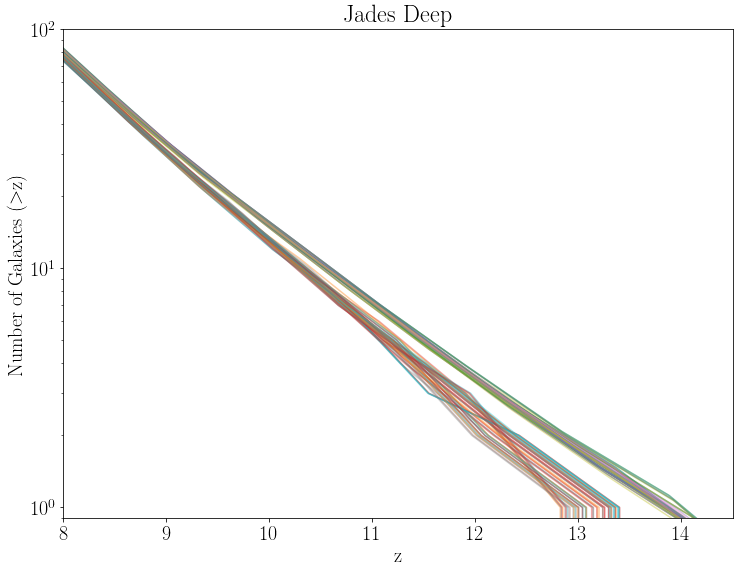

In [12]:
fig, ax = plt.subplots(figsize=(12,9))
meds, means = [],[]
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design matching the JADES Deep survey from Williams et al. 2018 (pg. 36)
    deep = survey(30.7, 46./3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4))
    mean_deep, med_deep, z_vals_deep = mean_median(deep)
    summed+=med_deep
    summean+=mean_deep
    meds.append(med_deep)
    means.append(mean_deep)
    ax.plot(z_vals_deep, mean_deep, alpha=0.4, label = "Mean")
    ax.plot(z_vals_deep, med_deep, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,1e2), xlim=(8,14.5), title='Jades Deep')
winsound.Beep(400,300)

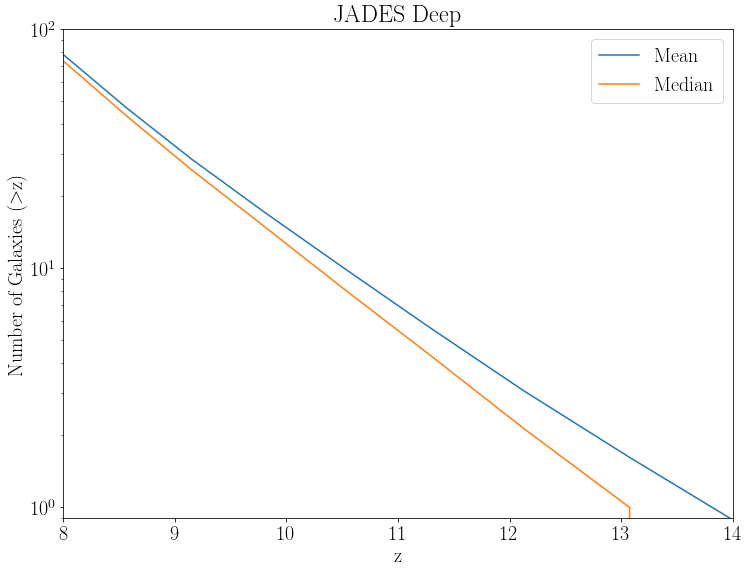

In [13]:
fig, ax =plt.subplots(figsize=(12,9))
meandeepfinal=summean/N
meddeepfinal=summed/N
ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,1e2), xlim=(8,14), title='JADES Deep')
if save==1:
    plt.savefig("figs/"+file+"/jadesdeep.pdf")

In [14]:
from scipy.interpolate import interp1d
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9994780503537992
0.9997837784912095


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in add
  """


(13.075999999997187, 13.0755, 13.821999999996773)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

-2.043453949194736
-1.9436206259478612
-1.8564674254086864
-1.7799564707134743
-1.7124121742187073
-1.6524759513485603
-1.5990609344423736
-1.551238757373333
-1.5082395555484713
-1.4694519659086671
-1.434355197699854
-1.4024737463204937
-1.373422679474102
-1.346884994092987
-1.3225663301857191
-1.3002402569896614
-1.27970298681844
-1.2607507319856808
-1.2432249909575381
-1.2269899052764293
-1.2119096164847716
-1.1978709092012465
-1.1848058541970625
-1.1726238791671648
-1.1612344118064986
-1.1505695228862722
-1.1405612831776946
-1.1311644065282382
-1.1223336067853755
-1.1140235977965793
-1.1061890934093217
-1.0987848074710753
-1.0917880969055764
-1.0851763186365613
-1.0789041865115025
-1.0729490574541363
-1.0672882883881987
-1.0618992362374262
-1.0567819010018185
-1.0519136396051123
-1.0472718089710435
-1.0428337660233484
-1.0385995107620272
-1.0345690431870795
-1.0306970771459782
-1.0269836126387233
-1.0234286496653144
-1.0200095451494882
-1.0167262990912445
-1.013578911490583
-1.01054

  2%|█▋                                                                                 | 1/50 [00:46<37:50, 46.34s/it]

-2.0023672924955727
-1.9063166974198142
-1.8224657696705304
-1.7488538484273943
-1.6838688347936936
-1.6262036215558773
-1.5748125229431051
-1.528802349026117
-1.4874324057172341
-1.4501144947703586
-1.4163475584202962
-1.385674109142304
-1.3577237998925427
-1.3321916389878505
-1.3087944198652912
-1.2873142913226063
-1.2675551872777633
-1.2493210416487295
-1.2324593585939243
-1.2168394273919922
-1.2023305373215782
-1.1888237627815534
-1.1762537484112399
-1.1645333537297342
-1.1535754382561334
-1.1433146466297597
-1.1336856234899353
-1.124644798596209
-1.1161486017081288
-1.1081534625852432
-1.1006158109871
-1.093492076673248
-1.0867604745234616
-1.0803992194175143
-1.0743647411149548
-1.068635254495557
-1.0631889744390954
-1.058004115825344
-1.0530806786543025
-1.0483968778057455
-1.043930928159447
-1.039661044595181
-1.0355872271129476
-1.031709475712747
-1.0279842201541272
-1.0244114604370884
-1.0209911965616305
-1.0177016434075277
-1.01454280097478
-1.0115146692633872
-1.00859546315

  4%|███▎                                                                               | 2/50 [01:43<39:40, 49.60s/it]

-2.017408334525576
-1.919972954753744
-1.8349131278674249
-1.7602399257243038
-1.6943180074073667
-1.6358214208217374
-1.583689404291515
-1.5370158905518667
-1.4950495067490293
-1.457193574440309
-1.4229398119893362
-1.3918241361629038
-1.3634708605341308
-1.337570596280879
-1.313836053782592
-1.292046241023457
-1.2720022651892424
-1.253505233465717
-1.2364004514418119
-1.2205553239080391
-1.2058372556549115
-1.1921357506745223
-1.179384511362128
-1.1674951409114032
-1.1563792425160229
-1.1459705185712432
-1.1362026714723208
-1.1270315028160924
-1.118412814199396
-1.1103024072190688
-1.1026560834719485
-1.0954296445548724
-1.0886009912662589
-1.0821480244045272
-1.0760265455665148
-1.0702144555506399
-1.0646896551553218
-1.0594300451789787
-1.0544356256216112
-1.0496842972816374
-1.0451539609574765
-1.040822517447547
-1.036689966751849
-1.0327563088703824
-1.0289773453999846
-1.025353076340656
-1.0218835016923962
-1.0185465222536239
-1.0153421380243395
-1.0122703490045424
-1.0093090559

  6%|████▉                                                                              | 3/50 [02:39<40:14, 51.37s/it]

-2.000139371796506
-1.9042938948556467
-1.8206220325863416
-1.747167311202091
-1.6823210744784387
-1.624779006557719
-1.5734976547537982
-1.527585736563938
-1.4863041396687935
-1.4490659219324153
-1.4153710956093646
-1.3847631501494577
-1.3568725293930226
-1.3313948929732706
-1.3080476391210405
-1.2866133818600547
-1.2668964738116628
-1.2487012675972153
-1.2318755930333176
-1.2162890185342032
-1.2018111125141053
-1.1883331819848848
-1.1757900111536588
-1.164094645629916
-1.1531601310231452
-1.1429212515404634
-1.1333127913889869
-1.1242912733734605
-1.1158132202986282
-1.107835154969235
-1.1003136001900249
-1.0932050787657426
-1.08648785209876
-1.0801401815914498
-1.0741185900485561
-1.0684013388724514
-1.0629666894655079
-1.0577929032300974
-1.0528799801662203
-1.0482061816762487
-1.043749769162555
-1.039489004027511
-1.0354238862711171
-1.0315544158933732
-1.0278371156990238
-1.0242719856880687
-1.0208590258605081
-1.017576497618714
-1.0144244009626868
-1.011402735892426
-1.008489763

  8%|██████▋                                                                            | 4/50 [03:25<38:08, 49.75s/it]

-2.00230937201011
-1.906264109503844
-1.8224178370187865
-1.7488100025872435
-1.6838285968135551
-1.6261665850525922
-1.5747783395882506
-1.5287707200796923
-1.4874030735613437
-1.4500872344428966
-1.416322172777051
-1.385650426438012
-1.357701668942993
-1.3321709255414635
-1.3087750053936453
-1.2872960693920172
-1.2675380623398098
-1.2493049290402531
-1.2324441821180827
-1.216825118108785
-1.2023170335478477
-1.1888110088815096
-1.176241692377514
-1.1645219483928528
-1.1535646412845173
-1.1433044193202506
-1.1336759307677968
-1.1246356078056512
-1.1161398826123092
-1.108145187366267
-1.1006079542460205
-1.0934846154300646
-1.0867533870076478
-1.0803924850680175
-1.0743583417896696
-1.068629173261852
-1.0631831955738125
-1.0579986248147988
-1.053075460984811
-1.048391920173097
-1.0439262184689044
-1.0396565719614814
-1.0355829806508279
-1.0317054445369436
-1.0279803957983247
-1.0244078344349705
-1.0209877604468818
-1.0176983899233059
-1.014539722864243
-1.011511759269693
-1.00859271522

 10%|████████▎                                                                          | 5/50 [04:29<40:33, 54.07s/it]

-2.0173682824055295
-1.919936590115108
-1.8348799823523883
-1.7602096062468466
-1.6942901827716081
-1.6357958100129908
-1.5836657664400482
-1.5369940190784313
-1.4950292235103864
-1.4571747238747568
-1.4229222577712972
-1.3918077595302192
-1.3634555569426459
-1.3375562728953851
-1.3138226286404717
-1.2920336405256259
-1.2719904232637953
-1.253494091567927
-1.2363899568814254
-1.2205454290129218
-1.2058279177710483
-1.1921269313296645
-1.1793761745930864
-1.1674872541004018
-1.1563717763906984
-1.1459634463682924
-1.1361959689374994
-1.1270251473678634
-1.1184067849289285
-1.1102966848902385
-1.1026506505213372
-1.0954244850917687
-1.0885960902363048
-1.0821433675897176
-1.076022120421551
-1.070210250366577
-1.0646856590595672
-1.059426248135294
-1.0544320175937574
-1.0496808690697292
-1.0451507041979813
-1.0408194246132858
-1.0366870303156426
-1.0327535213050518
-1.0289747008510572
-1.025350568953659
-1.021881125612857
-1.018544272463423
-1.0153400095053575
-1.0122683367386602
-1.00930

 12%|█████████▉                                                                         | 6/50 [05:06<35:54, 48.97s/it]

-2.008858569321046
-1.912210341395917
-1.8278376878953908
-1.7537677486440844
-1.688378394164461
-1.6303543843395993
-1.5786435270759616
-1.532347074960318
-1.4907197252597466
-1.4531696199216324
-1.419192583567822
-1.388328282157393
-1.3602040643238844
-1.3345130407066808
-1.3109702426137824
-1.289356463359036
-1.2694744169249033
-1.2511268172938457
-1.2341602197855557
-1.2184431003883416
-1.2038439350905108
-1.1902531205489868
-1.1776048947579232
-1.1658115750428588
-1.154785478729332
-1.1444608438114967
-1.1347719082835068
-1.125674830808132
-1.117125770048141
-1.1090808846663032
-1.1014963333253882
-1.0943282746881648
-1.0875547880860181
-1.0811539528503327
-1.0750819276438777
-1.0693167917980375
-1.063836624644197
-1.058619505513741
-1.0536654344066694
-1.0489524906543666
-1.0444587535882175
-1.0401623025396067
-1.036063137508534
-1.0321612584949997
-1.028412824161773
-1.0248178345088537
-1.021376289536242
-1.0180662685753223
-1.014887771626095
-1.0118407986885596
-1.0089034290941

 14%|███████████▌                                                                       | 7/50 [06:15<39:28, 55.08s/it]

-2.0392030566860333
-1.9397611006648443
-1.852949558654058
-1.776738542687717
-1.7094590337715894
-1.6497577732617033
-1.5965521542428815
-1.5489174499750769
-1.5060868138933716
-1.467451279607979
-1.4324920979720428
-1.4007356284601729
-1.3717984477899106
-1.3453647956109964
-1.3211414658839025
-1.2989029155013005
-1.2784461556665945
-1.259568197583189
-1.2421111610759537
-1.2259397202804916
-1.2109185493324053
-1.1969348766780308
-1.1839210393851693
-1.1717868202108896
-1.1604420019122599
-1.149818921557082
-1.1398499162131568
-1.130489877259019
-1.121693696073203
-1.1134162640342424
-1.1056124725206722
-1.0982372129110263
-1.0912679308945719
-1.084682072160576
-1.0784345280875733
-1.0725027443648307
-1.066864166681615
-1.061496240727194
-1.0563989665015672
-1.0515497896940018
-1.046926155993765
-1.042505511090124
-1.0382878549830787
-1.0342731876726294
-1.03041640053731
-1.0267174935771206
-1.0231764667920613
-1.019770765871399
-1.016500390815134
-1.0133653416232662
-1.0103430639850

 16%|█████████████▎                                                                     | 8/50 [06:53<34:53, 49.84s/it]

-2.0342021233975234
-1.935220588660325
-1.84881098847809
-1.77295283336877
-1.7059848319804591
-1.646559991325126
-1.5936007170123454
-1.5461865638336285
-1.5035542357624243
-1.4650975859541187
-1.4303002670966323
-1.3986908316441542
-1.3698876315834092
-1.3435763685505229
-1.3194651940647548
-1.2973296092947668
-1.2769675652923538
-1.2581770131093113
-1.240800803563702
-1.2247042373567227
-1.2097526151895706
-1.195833687646576
-1.1828801050783377
-1.17080206795232
-1.1595097767359872
-1.1489358817799382
-1.139013033434771
-1.1296963319342184
-1.120940877512012
-1.1127017704018847
-1.1049341108375683
-1.0975929990527955
-1.090655985164432
-1.0841006192893443
-1.0778820016612645
-1.0719776823970588
-1.066365211613593
-1.061022139427734
-1.055948465839481
-1.0511217409657008
-1.0465195149232591
-1.042119337829022
-1.03792120968299
-1.0339251304851624
-1.030086200469272
-1.0264044196353186
-1.0228797879833023
-1.019489855630089
-1.016234622575679
-1.0131140888200723
-1.0101058044801348
-1

 18%|██████████████▉                                                                    | 9/50 [07:56<36:44, 53.77s/it]

-2.0031085745909563
-1.9069897318433207
-1.8230792247588004
-1.7494149993915378
-1.6843838113860494
-1.6266776247784307
-1.5752500107975569
-1.5292071448680928
-1.4878078066104923
-1.4504633798409983
-1.4166724507734467
-1.3859772068204705
-1.358007037792297
-1.3324567352973484
-1.3090428915434449
-1.2875475005366024
-1.267774356882235
-1.249527255185757
-1.2326535912513796
-1.2170225614827122
-1.202503362283364
-1.1889869906563435
-1.1764080448034548
-1.1646793223271048
-1.1537136208296992
-1.143445538513043
-1.1338096735789414
-1.1247624248285968
-1.1162601910632128
-1.1082593710839925
-1.100716363692139
-1.0935875676888556
-1.0868511824747438
-1.0804854074504049
-1.0744466414170426
-1.0687130837752579
-1.0632629339256527
-1.0580743912688289
-1.0531474558047857
-1.0484603269341253
-1.043991204057449
-1.0397182865753587
-1.0356415744878542
-1.0317610677949354
-1.0280331652978054
-1.0244578669964644
-1.0210351728909124
-1.017743282381751
-1.01458219546898
-1.0115519121525995
-1.0086306

 20%|████████████████▍                                                                 | 10/50 [08:48<35:32, 53.31s/it]

-2.0124152385683702
-1.9154395585203852
-1.83078104354994
-1.7564601492695724
-1.6908492502940362
-1.632628650365024
-1.5807425924758889
-1.5342892841834543
-1.4925208976080124
-1.4548435694333248
-1.4207514160937067
-1.3897825438987503
-1.361563038908602
-1.3357849719963228
-1.3121624089726132
-1.2904754004610883
-1.270525992023002
-1.2521162292196084
-1.2350921474874377
-1.2193217772006595
-1.204673148733443
-1.1910362873975957
-1.1783452083802024
-1.1665119319307091
-1.1554484782985621
-1.1450888626708458
-1.135367100234645
-1.1262392011146827
-1.117661175435682
-1.109589033322366
-1.1019787848994578
-1.0947864402916803
-1.087990004561395
-1.0815674827709638
-1.0754748850451095
-1.0696902164461934
-1.0641914820365777
-1.0589566868786235
-1.0539858309723307
-1.0492569193800612
-1.0447479571641762
-1.0404369493870373
-1.0363238960486447
-1.0324087971489981
-1.028647662812821
-1.025040493040113
-1.0215872878308743
-1.0182660522474662
-1.015076786289889
-1.0120194899581427
-1.0090721683

 22%|██████████████████                                                                | 11/50 [09:37<33:49, 52.05s/it]

-2.0104998759506407
-1.913700537730248
-1.8291959668955258
-1.7550102186880625
-1.6895186274176086
-1.631403896578557
-1.5796121889664216
-1.5332433519690367
-1.4915509175665589
-1.4539421023314643
-1.41991194260327
-1.3889993846050135
-1.3608311943267728
-1.335100002583906
-1.3115203951335312
-1.2898728225580478
-1.2699596903816142
-1.2515834041283893
-1.2345902792060524
-1.2188485859640423
-1.204226594751799
-1.1906145308605214
-1.177946529464929
-1.1661347707979814
-1.1550914350926385
-1.1447506575236195
-1.135046573265644
-1.125935272435192
-1.1173728451487432
-1.1093153815227772
-1.1017189716737739
-1.094539705718213
-1.0877556287143342
-1.0813447857203777
-1.075263266852823
-1.06948911716991
-1.0640003817298787
-1.0587751055909689
-1.0538132887531806
-1.0490929762747536
-1.0445922132139278
-1.0402890446289432
-1.0361834705197999
-1.0322754908864975
-1.0285211958455163
-1.0249205853968557
-1.021473659540516
-1.018158463334737
-1.014974996779519
-1.0119232598748615
-1.0089812976790

 24%|███████████████████▋                                                              | 12/50 [10:41<35:20, 55.79s/it]

-2.008249797600256
-1.9116576175048368
-1.827333893035055
-1.7533069081082187
-1.6879554739452256
-1.6299651131576152
-1.5782842438346183
-1.5320146397607863
-1.4904114304159912
-1.452883100975426
-1.4189257684401797
-1.3880793657242918
-1.3599714575676978
-1.334295332579757
-1.3107661873263026
-1.2891649422425913
-1.2692944257203538
-1.250957466151321
-1.2340007078401722
-1.2182927030480617
-1.203702004036143
-1.1901190710220446
-1.1774781801363434
-1.165691699553142
-1.1546719974465427
-1.1443533499471228
-1.1346700331854591
-1.125578231248603
-1.1170341282236054
-1.1089939081975182
-1.1014137552573924
-1.0942498534902791
-1.0874802949397042
-1.0810831716491933
-1.075014667705798
-1.0692528751530432
-1.063775886034455
-1.0585617923935593
-1.0536105942303557
-1.04890038358837
-1.0444092525111277
-1.0401152930421547
-1.0360185051814508
-1.032118888929016
-1.028372628371902
-1.0247797235101082
-1.0213401743436348
-1.0180320729160075
-1.0148554192272266
-1.0118102132772915
-1.00887454710

 26%|█████████████████████▎                                                            | 13/50 [11:15<30:17, 49.12s/it]

-1.998987463492644
-1.903248039376269
-1.819668759851677
-1.7462953159666168
-1.68152083147146
-1.6240424337313732
-1.5728178246384887
-1.526956707892337
-1.4857207889998452
-1.4485237752753386
-1.4148662322087975
-1.3842921543780293
-1.3564323945364989
-1.3309829490694107
-1.3076615289058848
-1.2862509886067817
-1.2665558972768765
-1.2483808240209442
-1.2315737670315874
-1.2160044390453228
-1.201542552798667
-1.1880795355720504
-1.1755502437337315
-1.1638678191080545
-1.152945403519364
-1.1427178533359184
-1.1331200249259756
-1.1241084892017081
-1.115639817075288
-1.1076705794588875
-1.100157347264679
-1.0930566914048345
-1.08634689733544
-1.080006250512582
-1.0739913218484323
-1.0682803967990773
-1.0628517608206027
-1.0576836993690952
-1.0527762124445543
-1.0481075855030664
-1.0436561040007173
-1.0394000533935934
-1.0353394336816946
-1.0314742448650207
-1.0277610578557443
-1.024199872653865
-1.0207906892593832
-1.0175117931283846
-1.0143631842608694
-1.0113448626568378
-1.00843511377

 28%|██████████████████████▉                                                           | 14/50 [12:27<33:39, 56.11s/it]

-2.0041529839833196
-1.9079379855211995
-1.8239435357410456
-1.7502056178903986
-1.6851093737505702
-1.6273454588199212
-1.5758663974971405
-1.529777471039441
-1.4883367175625606
-1.4509549320407618
-1.4171301990817493
-1.3864042481099497
-1.3584060981832315
-1.332830235584546
-1.3093929690052046
-1.2878760743616007
-1.2680831499784881
-1.2498177941806214
-1.232927250109476
-1.2172805833148876
-1.2027468593466926
-1.1892169661630876
-1.1766254365389908
-1.1648849808409594
-1.1539083094355507
-1.1436299550976832
-1.1339844506022745
-1.1249281511326035
-1.1164174118719485
-1.108408588003589
-1.100858034710803
-1.0937221071768692
-1.0869789829934275
-1.0806068397521167
-1.0745620326362157
-1.0688227392373642
-1.0633671371472009
-1.0581734039573654
-1.0532415396678576
-1.0485497218703173
-1.0440761281563833
-1.0397989361176954
-1.0357181457542532
-1.031833757066057
-1.0281021252363853
-1.0245232502652382
-1.0210971321526157
-1.017801948490157
-1.0146376992778623
-1.0116043845157314
-1.0086

 30%|████████████████████████▌                                                         | 15/50 [13:06<29:39, 50.83s/it]

-2.007987320539981
-1.9114193059389082
-1.8271166776332768
-1.753108212825605
-1.6877731283268522
-1.6297972756053645
-1.578129335835818
-1.5318713075215822
-1.4902785064947195
-1.4527595659159855
-1.418810728848246
-1.3879720433054223
-1.359871167203545
-1.3342014658852288
-1.3106782071686145
-1.2890823662984268
-1.2692168209949173
-1.250884448978338
-1.2339319329199958
-1.2182278579667254
-1.2036408092653612
-1.1900612744382655
-1.1774235460588556
-1.1656400142250207
-1.1546230690346513
-1.144307003061164
-1.1346261088779763
-1.1255365815340332
-1.1169946160782793
-1.1089564075596599
-1.1013781510271192
-1.0942160415296027
-1.0874481765915824
-1.081052653737531
-1.074985668016393
-1.069225316952641
-1.0637496980707475
-1.058536908895185
-1.0535869494259533
-1.0488779171875249
-1.0443879097043722
-1.040095024500968
-1.0359992615773115
-1.0321006209334034
-1.0283552976181882
-1.0247632916316662
-1.021324602973837
-1.0180173291691734
-1.0148414702176753
-1.0117970261193425
-1.0088620943

 32%|██████████████████████████▏                                                       | 16/50 [14:08<30:41, 54.16s/it]

-2.0132726108441443
-1.916217995041312
-1.8314905701773745
-1.7571091805657235
-1.6914448759751475
-1.6331768859479086
-1.5812485941178154
-1.534757474005413
-1.492955089017983
-1.455247092449543
-1.4211271889579602
-1.390133108883025
-1.3618906339283792
-1.3360915843205499
-1.3124497931270271
-1.2907451319381877
-1.270779485185371
-1.2523547372999162
-1.235316798395087
-1.2195335914251095
-1.20487303934421
-1.1912250779475768
-1.1785236687123228
-1.1666807602745992
-1.1556083012705565
-1.1452402531773076
-1.1355105774719658
-1.1263752484726064
-1.117790240497305
-1.1097115278641365
-1.1020950848911768
-1.0948968858965007
-1.0880949180391464
-1.0816671684781514
-1.0755696115315911
-1.0697802343585032
-1.0642770241179251
-1.059037967968895
-1.0540630659114125
-1.0493303051045155
-1.0448176727072416
-1.0405031558786286
-1.0363867546186762
-1.0324684689273849
-1.0287042731228295
-1.0250941672050105
-1.0216381511739274
-1.0183142121886184
-1.0151223502490831
-1.012062565355322
-1.009112844

 34%|███████████████████████████▉                                                      | 17/50 [14:59<29:14, 53.17s/it]

-2.013871205488048
-1.9167614788291738
-1.831985942900391
-1.7575623170486483
-1.6918607260703262
-1.633559649530059
-1.5816018710795525
-1.5350843517546395
-1.4932582299752788
-1.4555288215455555
-1.421389543631912
-1.39037786408197
-1.362119352105709
-1.3363056529348767
-1.31265043714181
-1.290933451320615
-1.2709564674059861
-1.2525212573326185
-1.2354736437163862
-1.2196814745137523
-1.2050125976811805
-1.1913568865157231
-1.1786482649956118
-1.166798631758489
-1.1557198854419972
-1.1453459500243675
-1.1356107494838317
-1.126470233139211
-1.1178803503093264
-1.1097970503129992
-1.1021762824690504
-1.0949739960963012
-1.088168165854162
-1.0817367664020432
-1.0756357470587663
-1.0698430824837417
-1.0643367473363798
-1.0590947162760913
-1.0541169893028761
-1.049381541076145
-1.0448663462553083
-1.0405493794997764
-1.0364306408095498
-1.0325101301846282
-1.0287437969438327
-1.0251316410871634
-1.0216736626146201
-1.0183478361856135
-1.0151541618001436
-1.0120926394582104
-1.00914124381

 36%|█████████████████████████████▌                                                    | 18/50 [15:48<27:43, 51.98s/it]

-2.0123371221003588
-1.9153686340068408
-1.8307163975196667
-1.7564010150592455
-1.6907949819490242
-1.6325786998026097
-1.5806964899108864
-1.5342466267098183
-1.4924813377804484
-1.4548068038489004
-1.4207171788670556
-1.3897506033996767
-1.3615331912372854
-1.335757036089723
-1.3121362249732706
-1.2904508248235296
-1.2705028958825404
-1.2520944983923443
-1.235071679207862
-1.2193024784904538
-1.2046549364014805
-1.1910190864087427
-1.1783289485929205
-1.1664965497282545
-1.1554339165889849
-1.145075069255792
-1.1353540278093566
-1.1262268056367981
-1.1176494161252373
-1.109577872661794
-1.1019681886335886
-1.0947763774277415
-1.0879804457378124
-1.0815584002573617
-1.0754662543735094
-1.0696820147798158
-1.064183688169841
-1.0589492812371448
-1.0539787939817276
-1.049250233097149
-1.0447416052769696
-1.0404309172147492
-1.036318168910488
-1.0324033603641858
-1.028642504962963
-1.0250356027068195
-1.021582653595755
-1.0182616643233302
-1.015072634889545
-1.0120155652943987
-1.0090684

 38%|███████████████████████████████▏                                                  | 19/50 [16:50<28:26, 55.05s/it]

-2.039465473518565
-1.9399993575480217
-1.8531667242137912
-1.7769371923778952
-1.709641337549106
-1.649925572302105
-1.5967070266966361
-1.549060749325398
-1.5062197073140435
-1.467574786321179
-1.4326071111670982
-1.4008429262529396
-1.3718987151415294
-1.34545864076696
-1.3212294258537454
-1.2989854724976655
-1.2785237425849227
-1.259641198001719
-1.2421799202151007
-1.2260045504825354
-1.2109797300614917
-1.1969926599998595
-1.1839756609263725
-1.1718384936793431
-1.1604909190970834
-1.1498652578083273
-1.1398938304418087
-1.130531517416684
-1.1217331991521087
-1.1134537560672393
-1.1056480685812315
-1.0982710171132415
-1.0913000418728473
-1.084712583069627
-1.0784635211227365
-1.0725302962417538
-1.0668903486362569
-1.0615211185158238
-1.0564226058804547
-1.0515722509397272
-1.0469474939032197
-1.0425257749805101
-1.0383070941715986
-1.0342914514764847
-1.0304337273143247
-1.0267339216851188
-1.0231920345888668
-1.0197855062351466
-1.0165143366239584
-1.013378525755302
-1.01035551

 40%|████████████████████████████████▊                                                 | 20/50 [17:31<25:21, 50.72s/it]

-2.042360929228692
-1.9426282371294774
-1.8555628862812399
-1.7791290539829303
-1.7116528415692405
-1.6517770339061375
-1.5984158588863941
-1.5506418861684215
-1.5076860271762669
-1.4689375350996157
-1.4338761441370884
-1.402026828991773
-1.373005045375694
-1.3464941097575767
-1.3221999588583802
-1.299896390155766
-1.279379821379629
-1.2604466702598642
-1.2429385950308345
-1.2267198741791363
-1.2116547861913665
-1.1976302298063555
-1.1845783442674018
-1.1724086485655696
-1.1610306616919237
-1.1503765228897622
-1.1403783714023834
-1.1309909667253195
-1.122169068354103
-1.113867435784266
-1.1060408285113406
-1.0986440060308589
-1.0916543480905874
-1.0850492344382918
-1.0787834245695047
-1.072834298231992
-1.0671792351735199
-1.0617956151418544
-1.0566834381369954
-1.0518200839067093
-1.0471829321987622
-1.0427493627609201
-1.038519375593183
-1.0344929706955508
-1.0306249075635558
-1.0269151861971981
-1.0233638065964776
-1.0199481485091604
-1.0166682119352466
-1.013523996874736
-1.0104928

 42%|██████████████████████████████████▍                                               | 21/50 [18:36<26:35, 55.03s/it]

-2.0259078936223744
-1.9276899843331627
-1.8419470192947924
-1.7666740967526637
-1.7002227419307725
-1.641256353659386
-1.588705651002718
-1.5416572898281173
-1.4993538628060685
-1.4611938994101923
-1.4266650358587571
-1.3952994617423564
-1.366718473396233
-1.3406101972141156
-1.3166850362758953
-1.29472022371995
-1.27451526937082
-1.255869683053045
-1.2386275279634895
-1.2226551439851805
-1.2078188710011444
-1.1940073255805703
-1.1811536776649716
-1.1691688205096993
-1.1579636473701045
-1.1474713281877007
-1.137625032904001
-1.1283802081466814
-1.119692300543417
-1.1115167567218835
-1.1038090233097568
-1.096524546934712
-1.0896410509105872
-1.08313625855122
-1.0769656164842862
-1.0711068480236232
-1.0655376764830693
-1.0602358251764619
-1.055201294103801
-1.0504118065789245
-1.04584508591567
-1.0414788554278758
-1.0373131151155413
-1.0333478649786667
-1.0295385516449278
-1.0258851751143243
-1.0223877353868565
-1.0190239557763616
-1.0157938362828403
-1.0126973769062924
-1.0097123009605

 44%|████████████████████████████████████                                              | 22/50 [19:18<23:51, 51.12s/it]

-2.0017635247300922
-1.905768516784531
-1.8219661158812732
-1.7483967958885196
-1.6834493908756798
-1.6258175500882224
-1.5744561929225207
-1.5284726463629776
-1.487126644982025
-1.449830330940123
-1.416082936448034
-1.3854272387416722
-1.3574931051072527
-1.3319757203687186
-1.3085920418625872
-1.2871243444631038
-1.2673766755570877
-1.2491530825313597
-1.2323011577978908
-1.2166902662812278
-1.2021897729059174
-1.1886908151090818
-1.1761280753529946
-1.1644144635873535
-1.1534628897618562
-1.1432080363387764
-1.133584585780387
-1.1245489930615375
-1.1160577131570764
-1.1080672010418529
-1.1005339116907156
-1.0934143000785135
-1.0866865936926713
-1.0803290200206133
-1.0742980340371884
-1.0685718632298211
-1.0631287350859357
-1.057946877092957
-1.0530262892508846
-1.0483451990471433
-1.0438818339691573
-1.0396144215043512
-1.0355429616527252
-1.0316674544142788
-1.0279443547638611
-1.0243736627014726
-1.0209553782271126
-1.0176677288282057
-1.0145107145047523
-1.011484335256752
-1.0085

 46%|█████████████████████████████████████▋                                            | 23/50 [20:25<25:06, 55.79s/it]

-2.0357619619278204
-1.9366368174247035
-1.850101847773423
-1.7741336320156478
-1.7070684684745276
-1.6475574098445094
-1.5945212982811499
-1.5470383531256537
-1.504344170904874
-1.465831725331311
-1.430983919937836
-1.399328623167505
-1.3704836332837447
-1.3441341959152593
-1.319988039145845
-1.2978203384245766
-1.2774287516556204
-1.258610936743144
-1.2412095165014991
-1.2250895962001302
-1.2101162811084825
-1.1961771589510923
-1.1832047823626828
-1.171109221522883
-1.159800546611323
-1.1492113102627253
-1.1392740651118118
-1.1299438462483975
-1.1211756887622972
-1.1129246277433262
-1.1051456982812988
-1.0977939354660302
-1.0908468568424279
-1.0842819799553989
-1.0780543398947586
-1.0721414542054142
-1.066520840432273
-1.0611700161202426
-1.056088981269323
-1.0512552534244217
-1.0466463501304462
-1.0422397889323034
-1.038035569829994
-1.0340336928235174
-1.030189193002689
-1.0265020703675083
-1.0229723249179756
-1.0195774741989985
-1.0163175182105766
-1.0131924569527102
-1.0101798079

 48%|███████████████████████████████████████▎                                          | 24/50 [21:09<22:38, 52.26s/it]

-2.0346673970704416
-1.9356430259486062
-1.8491960301563757
-1.773305045801492
-1.7063080625725433
-1.6468575045413574
-1.593875310965397
-1.5464406382937441
-1.503789860167102
-1.4653165674177928
-1.4305041892733508
-1.3988810741589157
-1.370065408894839
-1.3437427590978803
-1.3196211499836021
-1.2974759855639766
-1.2771051294497773
-1.2583064452517785
-1.2409227157783604
-1.2248191834367055
-1.2098610906339968
-1.1959361393762202
-1.1829769508669665
-1.1708936867110247
-1.1595965085131832
-1.1490180374770333
-1.1390908948061667
-1.1297701613029774
-1.1210109177698597
-1.112768245009208
-1.1049972238234165
-1.0976529350148791
-1.0907129189847937
-1.084154716134357
-1.077933407265963
-1.0720265327808094
-1.0664116330800928
-1.0610662485650109
-1.0559903792355632
-1.051161565492947
-1.0465573477383594
-1.0421552663729978
-1.037955321396862
-1.0339575128099519
-1.0301169214146617
-1.0264335472109918
-1.0229073901989418
-1.0195159907797091
-1.0162593489532934
-1.0131374647196951
-1.010127

 50%|█████████████████████████████████████████                                         | 25/50 [22:03<22:02, 52.89s/it]

-2.0161609551805477
-1.9188404179723988
-1.8338808471594787
-1.75929565885684
-1.69345143964797
-1.6350238002762372
-1.5829532293363364
-1.5363347275029025
-1.4944178075305108
-1.4566064942536776
-1.4223931051240266
-1.3913141039017374
-1.3629942469640972
-1.337124510151226
-1.3134179424575194
-1.2916538123402062
-1.2716334614107911
-1.2531582312807796
-1.2360736098702314
-1.2202471582534833
-1.205546437504872
-1.1918610818530115
-1.1791248718350706
-1.1672495148339401
-1.1561467182325116
-1.1457502625679532
-1.1359939283774334
-1.1268335693523979
-1.118225039184292
-1.1101241915645619
-1.1024868801846528
-1.0952689587360103
-1.0884483540643572
-1.0820029930154167
-1.0758887292806338
-1.0700834897057319
-1.0645652011364333
-1.059311790418461
-1.0543232575518153
-1.0495775293822185
-1.0450525327553937
-1.0407261945170636
-1.0365985146672283
-1.032669493205888
-1.0288949838244876
-1.0252749865230277
-1.0218095013015083
-1.018476455005652
-1.0152758476354589
-1.012207679190929
-1.00924987

 52%|██████████████████████████████████████████▋                                       | 26/50 [23:00<21:40, 54.18s/it]

-2.025270930633951
-1.9271116646619095
-1.841419894481282
-1.766191915411305
-1.6997802369366852
-1.6408490559369135
-1.5883297299155832
-1.5413094600736799
-1.4990312913095822
-1.4608941122190613
-1.4263858649392553
-1.3950390183779864
-1.366475094984444
-1.3403824073638424
-1.3164715315067381
-1.2945198335597132
-1.2743269430546913
-1.2556924895235961
-1.238460629269035
-1.222497781978957
-1.2076703673413114
-1.193867068429389
-1.1810210950871645
-1.1690433937732707
-1.15784491094634
-1.1473588564503474
-1.1375184401292673
-1.128279135212416
-1.11959641492911
-1.1114257525086657
-1.1037226211803994
-1.0964424941736275
-1.089563108103008
-1.0830621995831995
-1.076895241843518
-1.0710399714986218
-1.0654741251631694
-1.0601754394518186
-1.0551439143645693
-1.0503572865160802
-1.0457932925210092
-1.0414296689940143
-1.0372664159350957
-1.0333035333442535
-1.029496494450804
-1.025845299254747
-1.022349947756083
-1.0189881765694695
-1.015759985694907
-1.0126653751323955
-1.009682081496592

 54%|████████████████████████████████████████████▎                                     | 27/50 [23:46<19:46, 51.59s/it]

-2.004512207301814
-1.908264136200649
-1.8242408144341749
-1.7504775501450305
-1.6853589300282747
-1.6275751595123338
-1.576078402939948
-1.529973634020542
-1.488518635830224
-1.4511240008117854
-1.4172876410461228
-1.3865511284331855
-1.3585433545110275
-1.3329587005462813
-1.3095133777151062
-1.2879890869222397
-1.2681893589819455
-1.2499177247084876
-1.2330213747351826
-1.2173693296048729
-1.2028306098604011
-1.189296065954136
-1.1767002081574993
-1.1649557168323854
-1.1539752723406898
-1.1436933849538335
-1.1340445649432382
-1.124985152489851
-1.11647148777462
-1.108459910978492
-1.1009067622824151
-1.0937683818673367
-1.0870229398237305
-1.0806486062420702
-1.0746017213033034
-1.068860455097904
-1.0634029777163454
-1.0582074592491018
-1.053273899696173
-1.0485804691480327
-1.0441053376951546
-1.0398266754280128
-1.035744482346607
-1.0318587584509376
-1.0281258439219514
-1.024545738759649
-1.0211184429640303
-1.0178221266255691
-1.014656789744265
-1.0116224323201186
-1.008697224443

 56%|█████████████████████████████████████████████▉                                    | 28/50 [24:50<20:16, 55.31s/it]

-1.9996946379530405
-1.9038901063548663
-1.82025398884038
-1.7468306474318451
-1.6820121131253463
-1.62449462726906
-1.573235182941527
-1.5273428783973348
-1.4860789170671165
-1.4488566075575515
-1.415176175718774
-1.3845813060226457
-1.3567026001844835
-1.331235847852195
-1.3078985679845518
-1.2864734674729168
-1.266764982519516
-1.248577549326576
-1.231759062718051
-1.2161791468287586
-1.201707425793516
-1.1882352530580051
-1.1756974406896346
-1.164007071444949
-1.1530772280804942
-1.1428427226636786
-1.133238367261911
-1.1242207032534643
-1.1157462720166107
-1.1077716149296226
-1.100253273370773
-1.0931477887183343
-1.0864334316614424
-1.080088472889234
-1.0740694537799815
-1.0683546450228212
-1.0629223173068894
-1.0577507413213223
-1.0528399170661198
-1.0481681152304185
-1.0437136065033543
-1.0394546615740639
-1.0353912804425467
-1.0315234631088033
-1.0278077509511059
-1.0242441439694547
-1.0208326421638494
-1.0175515162234265
-1.0144007661481862
-1.0113803919381281
-1.008468664282

 58%|███████████████████████████████████████████████▌                                  | 29/50 [25:38<18:38, 53.25s/it]

-2.028788829188376
-1.9303056805976444
-1.8443311650780876
-1.7688549666004096
-1.7022241586516338
-1.6430985305455628
-1.590405913733239
-1.5432304975790938
-1.500812829360949
-1.4625498142700164
-1.427927704876586
-1.3964774274404894
-1.367819255600637
-1.3416404735302498
-1.317650702247318
-1.2956265733041423
-1.2753670550977931
-1.2566711160253408
-1.2393823981733956
-1.2233668804733377
-1.208490541856548
-1.1946416980991756
-1.1817533386669117
-1.1697361161806759
-1.1585006832613884
-1.1479800293747395
-1.1381071439864194
-1.1288373534068883
-1.1201259839466058
-1.1119283619160323
-1.104199813625628
-1.0968956653858526
-1.0899935803519365
-1.0834712216791096
-1.077283915677832
-1.071409325503334
-1.065825114310845
-1.0605089452555958
-1.055460818337586
-1.0506583967120455
-1.0460793435342048
-1.0417013219592937
-1.037524331987312
-1.03354837361826
-1.0297287731625977
-1.0260655306203252
-1.0225586459914422
-1.019185782431179
-1.0159469399395356
-1.0128421185165117
-1.0098489813173

 60%|█████████████████████████████████████████████████▏                                | 30/50 [26:35<18:05, 54.27s/it]

-2.0216800893584286
-1.9238514216278157
-1.8384482594379477
-1.7634736465412049
-1.697285641133988
-1.6385529390512183
-1.5862104969608315
-1.5393485903500232
-1.4972128135252483
-1.4592040796122205
-1.4248120553476593
-1.393570784273787
-1.365103063543831
-1.3390982555192728
-1.3152679109643446
-1.2933901458515336
-1.2732652645560774
-1.2546935714532144
-1.2375197477236852
-1.2216106629509818
-1.2068331867185962
-1.1930763770127717
-1.1802736686252546
-1.168336307945039
-1.1571755413611202
-1.146724803665244
-1.1369175296491563
-1.1277093425073546
-1.1190558654343359
-1.1109127216245978
-1.1032355342726379
-1.0959799265729528
-1.0891237101227922
-1.0826446965194039
-1.0764985089572854
-1.0706629590336858
-1.0651158583458533
-1.0598350184910368
-1.0548204394692364
-1.0500499328777004
-1.0455013103136779
-1.0411523833744172
-1.0370031520599186
-1.033053616370182
-1.0292593994997046
-1.0256205014484865
-1.0221369222165277
-1.018786473401077
-1.015569155002134
-1.0124849670196991
-1.00951

 62%|██████████████████████████████████████████████████▊                               | 31/50 [27:27<17:00, 53.72s/it]

-2.0382983036579017
-1.9389396455986878
-1.8522008216318215
-1.7760536441353183
-1.7088304921755464
-1.6491792406711827
-1.5960181895571692
-1.5484233866946018
-1.5056286278707307
-1.4670254567989611
-1.4320955588647852
-1.4003656902897403
-1.3714527489674515
-1.3450412390456101
-1.3208382000899297
-1.2986182779201894
-1.278178653774191
-1.259316508889736
-1.2418740953406702
-1.2257162006188609
-1.2107076122161764
-1.196735653042506
-1.183732716843784
-1.1716086619479213
-1.1602733466828308
-1.1496591647944459
-1.1396985100287003
-1.1303463115495498
-1.1215574985209509
-1.1132870001068589
-1.1054897454712298
-1.0981206637780199
-1.0911572196092068
-1.0845768775467683
-1.0783345667546609
-1.072407751814862
-1.06677389730935
-1.0614104678201022
-1.056317463347119
-1.0514723484723785
-1.0468525877778585
-1.042435645845537
-1.038221522675414
-1.034210218267489
-1.0303566617857187
-1.0266608532301027
-1.023122792600641
-1.0197199444793117
-1.0164523088661146
-1.0133198857610497
-1.010300139

 64%|████████████████████████████████████████████████████▍                             | 32/50 [28:20<16:04, 53.57s/it]

-2.0328173691699756
-1.9339633246996293
-1.8476650218721482
-1.7719045736377868
-1.7050228284223081
-1.6456745281925493
-1.5927834665219784
-1.5454303837545997
-1.5028529670049542
-1.4644458501581172
-1.4296933509680432
-1.3981246291231242
-1.3693585281806304
-1.3430811545994905
-1.3190010358058522
-1.296893962127521
-1.2765581448595227
-1.2577917952968827
-1.240437966669065
-1.2243621331727532
-1.2094297690046312
-1.1955287693286014
-1.1825918712430061
-1.1705293908789673
-1.159251644367608
-1.148691368807269
-1.138781301296293
-1.129476599900241
-1.120732422684674
-1.1125039277151532
-1.10474627305724
-1.097414616776495
-1.0904865379056998
-1.0839396154776342
-1.0777290075578596
-1.0718322931791566
-1.066227051374306
-1.060890861176088
-1.0558237225845033
-1.0510032146323316
-1.0464069163523542
-1.042012406777351
-1.0378196859073228
-1.0338287537422692
-1.0299947683477513
-1.0263177297237693
-1.022797637870323
-1.019412071820193
-1.0161610315733798
-1.0130445171298827
-1.010040107522

 66%|██████████████████████████████████████████████████████                            | 33/50 [29:20<15:41, 55.38s/it]

-2.01771245934914
-1.9202490796953497
-1.8351648092740664
-1.7604701483872085
-1.6945292861719086
-1.6360158894961132
-1.5838688918541783
-1.5371819656058667
-1.4952035219763482
-1.4573367110561979
-1.4230731051447951
-1.391948487645921
-1.3635870641721597
-1.3376793569926992
-1.313937993928927
-1.2921419194588348
-1.272092183612614
-1.2535898364204565
-1.236480139016956
-1.2206304580889071
-1.2059081603231043
-1.1922027179585433
-1.1794478143386211
-1.1675550272545343
-1.156435934497479
-1.1460242194108528
-1.1362535653380528
-1.1270797611746772
-1.1184585958163242
-1.110345858158592
-1.102697337097079
-1.095468821527383
-1.0886382058973032
-1.0821833846546391
-1.0760601466949884
-1.0702463864661502
-1.0647199984159241
-1.0594588769921087
-1.0544630221947042
-1.0497103284715097
-1.0451786902703242
-1.0408460020389467
-1.0367122637773774
-1.0327774754856163
-1.0289974260592616
-1.025372115498313
-1.021901543802771
-1.0185636054204343
-1.0153583003513031
-1.0122856285953774
-1.009323484

 68%|███████████████████████████████████████████████████████▊                          | 34/50 [30:12<14:29, 54.34s/it]

-2.0202649666794756
-1.9225665851501095
-1.8372771611295766
-1.7624023978753858
-1.6963025402881553
-1.6376480572062246
-1.5853753237002657
-1.5385758268098093
-1.4964961655432487
-1.4585380508778363
-1.4241918292016018
-1.3929921646079644
-1.36456235660112
-1.3385921812433481
-1.3147935734496219
-1.292944944692998
-1.2728468652992273
-1.2542999055940607
-1.2371489536086377
-1.2212610562267927
-1.206503260332359
-1.1927647716618652
-1.1799791136572284
-1.168057650907671
-1.1569117480024156
-1.146474928383379
-1.1366807154924787
-1.1274847916243256
-1.1188428390735312
-1.1107105401347068
-1.1030435771024634
-1.0957976322714127
-1.08895054678886
-1.0824801618021116
-1.076342159605778
-1.0705143813471654
-1.0649746681735792
-1.059700861232325
-1.0546929605234032
-1.049928807194119
-1.0453862423917784
-1.0410431072636868
-1.0368994018098443
-1.032955126030251
-1.029165962219518
-1.0255319103776455
-1.0220529705046333
-1.0187069837477873
-1.0154939501071074
-1.0124138695825935
-1.0094445833

 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [31:01<13:10, 52.70s/it]

-2.040807859797175
-1.9412181542527756
-1.8542776288183473
-1.7779533795476454
-1.710573907640423
-1.6507839437991834
-1.597499272585929
-1.549793793314037
-1.5068995200482593
-1.468206581604722
-1.433195458086051
-1.4013918052381231
-1.3724116300933138
-1.3459387031488739
-1.3216793827236788
-1.2994077906014792
-1.2789206363876506
-1.2600146296875683
-1.242531655749858
-1.2263361876447696
-1.2112926984425538
-1.1972882490350854
-1.18425507595749
-1.1721028279232675
-1.1607411536459182
-1.1501022896605673
-1.1401184725023399
-1.1307445265279863
-1.121935276094256
-1.1136455455579
-1.1058301592756676
-1.0984439416043092
-1.0914643047222001
-1.0848686608077152
-1.0786118342176043
-1.0726712371302427
-1.0670242817240054
-1.0616483801772676
-1.0565435324900292
-1.0516871508406653
-1.0470566474075507
-1.0426294343690607
-1.0384055117251954
-1.0343848794759545
-1.030522361978088
-1.0268179592315967
-1.0232716712364796
-1.0198609101711122
-1.0165856760354948
-1.013445968829627
-1.010419200731

 72%|███████████████████████████████████████████████████████████                       | 36/50 [32:06<13:11, 56.53s/it]

-2.0329517385882934
-1.9340853231190667
-1.847776220569497
-1.7720062913632109
-1.7051161762929676
-1.6457604489745183
-1.5928627683004644
-1.5455037595749013
-1.5029210145134222
-1.4645090912431151
-1.429752242983351
-1.3981795704996423
-1.3694098696497856
-1.3431292076107897
-1.3190460753327335
-1.2969362350849094
-1.2765978729096794
-1.2578291748494066
-1.2404731744925954
-1.2243953292008205
-1.2094610963356573
-1.1955583570317516
-1.1826198399698908
-1.170555850057792
-1.1592766922031716
-1.1487150950868175
-1.138803787389517
-1.1294979215651284
-1.1207526500675105
-1.112523125350521
-1.1047644998680188
-1.097431926073862
-1.09050298019498
-1.0839552384583018
-1.0777438533176857
-1.0718464010000612
-1.0662404577323574
-1.0609035997415033
-1.055835827027499
-1.0510147158172736
-1.0464178423377564
-1.0420227828158763
-1.037829537251634
-1.0338381056450288
-1.030003640449919
-1.0263261416663054
-1.0228056092941873
-1.019419619560494
-1.0161681724652258
-1.0130512680083825
-1.010046482

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [32:53<11:35, 53.46s/it]

-1.9970878761279232
-1.90152334145779
-1.8180967381587783
-1.744857327260529
-1.6802011678318585
-1.622827767225861
-1.5716967313250119
-1.5259193901539252
-1.4847587978793542
-1.4476297328101915
-1.414033672765123
-1.3835154453177319
-1.3557065775513946
-1.3303036211818333
-1.3070248028022182
-1.2856533736380649
-1.2659942597923377
-1.2478523873680007
-1.231076032222915
-1.21553514509239
-1.2010996767117346
-1.1876612526937074
-1.1751548484059624
-1.1634937643387064
-1.1525913009821456
-1.1423824337039346
-1.132802137871728
-1.123807063730629
-1.1153538615257408
-1.1073991815021664
-1.0998996739050093
-1.0928119889793722
-1.086114451847807
-1.0797853876328651
-1.0737814465796496
-1.068080953810712
-1.0626622344486043
-1.0575036136158777
-1.0526050913125322
-1.0479449926611195
-1.0435016427841912
-1.0392533668042987
-1.035200164721442
-1.0313420365356212
-1.0276356324919396
-1.0240809525903969
-1.0206779968309931
-1.01740509033628
-1.0142622331062574
-1.0112494251409254
-1.008344991562

 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [33:54<11:08, 55.73s/it]

-2.024173574907177
-1.92611533926359
-1.8405117672535725
-1.765361216507444
-1.699017892187911
-1.6401473660485202
-1.5876820954921076
-1.5407102212169306
-1.4984755672166647
-1.460377640780406
-1.425904911080347
-1.3945903282302288
-1.3660558042268898
-1.3399899724794904
-1.3161037068679655
-1.2941746026845733
-1.2740024956923452
-1.2553872216543134
-1.238173097275058
-1.2222266797299342
-1.2074145261942957
-1.1936254343142723
-1.1807926826775406
-1.168827309401004
-1.1576403526015655
-1.1471650908669024
-1.1373348027846921
-1.1281050074133858
-1.1194312238114357
-1.1112689710372925
-1.1035737681494084
-1.0963011342062348
-1.089428828736997
-1.0829346112709215
-1.0767740008664595
-1.0709247570528364
-1.0653646393592786
-1.0600714073150115
-1.055045060920035
-1.0502633597035753
-1.0457040631948578
-1.0413449309231084
-1.037185962888327
-1.033227159090514
-1.0294240385881204
-1.0257766013811462
-1.022284847469592
-1.018926536382683
-1.0157016681204194
-1.0126102426828012
-1.009630019599

 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [34:36<09:30, 51.83s/it]

-2.034497078788321
-1.9354883883719893
-1.849055081632942
-1.7731761147659006
-1.7061897406420816
-1.6467485967246334
-1.593774792984074
-1.546347631686888
-1.5037036073955263
-1.4652364069684056
-1.4304295414330654
-1.3988114339016082
-1.370000331655259
-1.3436818501020857
-1.3195640606924373
-1.2974224030035049
-1.2770547726547608
-1.258259065265677
-1.240878088540288
-1.224777106224908
-1.2098213820658523
-1.1958986358517163
-1.1829414994556575
-1.1708601487085524
-1.1595647594412775
-1.1489879635269904
-1.1390623928388481
-1.1297431352922895
-1.1209852788027523
-1.112743911285675
-1.1049741206564958
-1.097630994830653
-1.090692077765866
-1.0841349134198537
-1.0779145897080542
-1.0720086505881867
-1.0663946400179707
-1.0610501019551248
-1.0559750363996496
-1.0511469873092636
-1.0465434986416864
-1.042142114354637
-1.0379428344481152
-1.0339456589221214
-1.0301056756920937
-1.026422884758032
-1.0228972861199361
-1.0195064237355256
-1.0162502976048002
-1.01312890772776
-1.010119798062

 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [35:38<09:07, 54.79s/it]

-2.0265140041455885
-1.9282402920353354
-1.8424486118556205
-1.7671329227604642
-1.7006438133876167
-1.6416439231730922
-1.5890633636657014
-1.5419882718133868
-1.4996608099632236
-1.4614791658614175
-1.426930684625107
-1.3955472900568975
-1.3669500633303258
-1.3408269536471287
-1.3168881995517756
-1.2949109076169356
-1.274694473758011
-1.2560382938904033
-1.2387863426149814
-1.2228048838753462
-1.2079601816150993
-1.1941407891205753
-1.1812798383635745
-1.169288171973165
-1.158076632578414
-1.1475783521511222
-1.1377264626630905
-1.1284763854288526
-1.1197835417629423
-1.1116033529798934
-1.1038912403942396
-1.0966026253205148
-1.0897152184159857
-1.0832067303379196
-1.07703258240085
-1.0711704852620438
-1.065598149578768
-1.0602932860082894
-1.055255894550608
-1.0504636858629908
-1.0458943706027046
-1.0415256594270164
-1.037357552335926
-1.0333900493294337
-1.029578571722073
-1.0259231195138439
-1.0224236927047468
-1.019058001952048
-1.015826047255748
-1.0127278286158468
-1.009741056

 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [36:21<07:42, 51.37s/it]

-1.996945248236937
-1.9013938448990797
-1.8179787050833816
-1.7447493578666382
-1.6801020827119935
-1.6227365656706443
-1.5716125555835485
-1.5258415045856908
-1.4846865681060828
-1.4475626048677634
-1.4139711611903585
-1.3834571271917864
-1.3556520805865537
-1.3302526147866063
-1.3069769951030366
-1.2856085025443775
-1.2659520900183088
-1.24781271043251
-1.2310386604929542
-1.215499908804761
-1.2010664239730502
-1.1876298465020882
-1.1751251606944348
-1.1634656789535032
-1.1525647136827066
-1.1423572491846048
-1.1327782697617577
-1.1237844316158718
-1.1153323909486537
-1.10737880396181
-1.0998803268570474
-1.0927936158360723
-1.086096998999738
-1.0797688044488978
-1.0737656883852582
-1.0680659789096727
-1.0626480041229944
-1.0574900921260768
-1.0525922429189196
-1.0479327846023765
-1.0434900452773002
-1.0392423530445445
-1.0351897079041092
-1.0313321098559942
-1.0276262151019064
-1.0240720236418455
-1.0206695354758115
-1.0173970787046578
-1.0142546533283845
-1.0112422593469914
-1.0083

 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [37:15<06:55, 51.90s/it]

-2.0374561294958595
-1.9381750079456652
-1.8515038723487733
-1.775416117819831
-1.7082454247864383
-1.6486407233250269
-1.595521157496742
-1.5479634961871458
-1.505202133106216
-1.4666290867883476
-1.4317264470961721
-1.4000213395564414
-1.371130961024144
-1.3447400618504477
-1.320555910218579
-1.2983533278079438
-1.2779296541300063
-1.2590822286962315
-1.2416534266822035
-1.225508141095565
-1.2105112649439593
-1.1965502090670892
-1.1835574199687762
-1.1714428263207826
-1.16011635679487
-1.1495104578948607
-1.139557576124576
-1.1302126758198967
-1.1214307213167043
-1.1131666769508795
-1.1053755070583036
-1.0980121759748576
-1.091054165868482
-1.0844789589071173
-1.0782415194266448
-1.0723193295950046
-1.0666898715801376
-1.0613306275499843
-1.0562415975045445
-1.051400263611759
-1.0467841080395681
-1.0423706129559123
-1.0381597783607919
-1.0341516042542065
-1.0303010549720375
-1.026608130514285
-1.0230728308809482
-1.0196726382399688
-1.0164075525913459
-1.01327757393508
-1.01026018443

 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [38:13<06:16, 53.73s/it]

-2.033495075000584
-1.9345786361388915
-1.848225863814407
-1.77241759733365
-1.7054936379042038
-1.6461078783970824
-1.593183433109096
-1.5458004621687707
-1.5031961715363478
-1.4647648130037827
-1.429990378838298
-1.3984017315447477
-1.369617474103253
-1.343323514850383
-1.3192281972415245
-1.2971071700885128
-1.276758517322
-1.2579803228726383
-1.2406155409087123
-1.2245295607173234
-1.2095877715855732
-1.1956779979193792
-1.1827329343622923
-1.1706628404390467
-1.1593779756743763
-1.1488110347118323
-1.1388947121949649
-1.1295841378861415
-1.1208344415477292
-1.1126007529420952
-1.1048382018316063
-1.0975019179786296
-1.0905694662643493
-1.0840184115699483
-1.077803883657794
-1.0719034474090696
-1.0662946677049592
-1.060955109426646
-1.05588477257413
-1.051061222028595
-1.0464620226712245
-1.0420647393832019
-1.0378693721645273
-1.0338759210152006
-1.030039515697589
-1.0263601562116926
-1.0228378425575113
-1.0194501396162285
-1.0161970473878446
-1.0130785658723591
-1.010072259950955

 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [38:55<05:01, 50.19s/it]

-2.0146483817000465
-1.9174671027030845
-1.8326291025081864
-1.758150639879306
-1.6924006386890276
-1.6340566047799876
-1.5820605428262944
-1.535508748487083
-1.4936518084065136
-1.4558946002137725
-1.4217301678152034
-1.3906956382557292
-1.3624163048574296
-1.3365835856502537
-1.3129109402334387
-1.291177952914091
-1.2711862495686057
-1.2527374560733784
-1.2356772814433832
-1.219873476262884
-1.2051937911161439
-1.1915280181567163
-1.1788100326767328
-1.166951668399036
-1.1558647590464681
-1.145483179911161
-1.1357408062852465
-1.1265935550301458
-1.11799734300728
-1.1099080870780704
-1.1022817041039383
-1.0950741109463047
-1.0882632660358802
-1.0818271278033758
-1.075721613110212
-1.0699246803871
-1.0644142880647502
-1.059168394573873
-1.0541869999144688
-1.049448062517248
-1.044929540812921
-1.040609393232199
-1.0364876197750812
-1.0325642204415681
-1.0287951120930807
-1.0251802947296194
-1.0217197683511836
-1.0183914913884842
-1.0151954638415213
-1.0121316857102949
-1.0091781154255

 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [40:06<04:42, 56.57s/it]

-2.0170474006058896
-1.9196452509631456
-1.834614433549918
-1.7599666985436055
-1.6940672627567364
-1.635590626307577
-1.5834763892907402
-1.5368187934537079
-1.4948667221968308
-1.457023700573329
-1.422781620295204
-1.3916765564038491
-1.3633329505994398
-1.3374415195762381
-1.3137150716932018
-1.2919326903033752
-1.2718955504244982
-1.2534048270743106
-1.2363058785999437
-1.2204661550132239
-1.2057531063259779
-1.192056274214728
-1.1793093836853872
-1.1674240680791734
-1.1563119607373045
-1.1459067866656936
-1.136142270870254
-1.1269742300215948
-1.1183584807903246
-1.1102508398470525
-1.1026071238623871
-1.0953831495069375
-1.088556825116008
-1.0821060590249032
-1.0759866679042318
-1.0701765600892985
-1.0646536439154073
-1.059395827717863
-1.0544031114966654
-1.049653403587119
-1.0451246123245284
-1.0407946460441977
-1.036663504746127
-1.0327311884303165
-1.028953513767375
-1.0253304807573025
-1.0218620894000987
-1.0185262480310686
-1.0153229566502118
-1.0122522152575282
-1.00929193

 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [40:40<03:19, 49.82s/it]

-2.024366891428434
-1.9262908576988098
-1.8406717481897776
-1.765507557223028
-1.6991521912408396
-1.6402709797910062
-1.5877961865117634
-1.5408157865941026
-1.498573466781774
-1.460468625371285
-1.4259896386892899
-1.394669372077516
-1.3661296689078386
-1.3400591060747429
-1.3161685049802505
-1.2942354205489943
-1.2740596522131429
-1.2554409994048652
-1.2382237505714044
-1.2222744386675395
-1.20745959664805
-1.193668001975252
-1.180832921126535
-1.168865376071752
-1.157676388780756
-1.147199225730937
-1.137367153399684
-1.128135682771924
-1.1194603248325832
-1.1112965905665881
-1.1035999909588654
-1.0963260369943413
-1.089452484165479
-1.0829570879647417
-1.0767953593770563
-1.0709450538948853
-1.0653839270106926
-1.060089734216941
-1.0550624755136306
-1.0502799063932249
-1.0457197823481867
-1.0413598588709796
-1.0372001359616034
-1.0332406136200583
-1.0294368028312704
-1.02578870359524
-1.022296315911967
-1.0189373952739145
-1.0157119416810825
-1.0126199551334714
-1.009639191123544


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [41:47<02:44, 55.00s/it]

-2.008594287907251
-1.9119703915980133
-1.8276189792835988
-1.7535676874648387
-1.6881947950424174
-1.6301853930168897
-1.5784875541886998
-1.5322027574082258
-1.4905858875757825
-1.4530452356416197
-1.41907675315595
-1.3882202219689674
-1.360103084530829
-1.3344185287416648
-1.3108816576515943
-1.28927331976071
-1.2693962787190955
-1.2510532981768339
-1.2340909720839897
-1.2183778095406186
-1.203782319646776
-1.190194926652508
-1.1775498851078425
-1.1657595344128167
-1.154736213967467
-1.1444141783218216
-1.134727682025908
-1.125632894779745
-1.1170859862833504
-1.1090431262367435
-1.1014604843399425
-1.0942942302929657
-1.0875224489458224
-1.081123225148522
-1.075052728601083
-1.0692890441535146
-1.0638102566558258
-1.0585944509580263
-1.0536416270601157
-1.0489298698121035
-1.0444372640639987
-1.0401418946658108
-1.0360437616175397
-1.0321428649191853
-1.0283953742707663
-1.0248012896722825
-1.021360611123734
-1.0180514234751301
-1.0148737267264707
-1.0118275208777556
-1.00889089077

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [42:32<01:43, 51.99s/it]

-1.999603152743728
-1.9038070439208856
-1.8201782793803731
-1.7467613930768158
-1.6819485573729058
-1.624436128238394
-1.57318119044908
-1.5272929205842936
-1.4860325870268931
-1.4488135499632668
-1.4151360791818184
-1.384543899271961
-1.3566676444251233
-1.3312031310342478
-1.3078679028927795
-1.2864446859956775
-1.2667379337384044
-1.2485520995164223
-1.2317350915262022
-1.2161565453647194
-1.2016860966289487
-1.1882151083163692
-1.1756783982254688
-1.1639890567542306
-1.1530601743006381
-1.1428265686631787
-1.13322305764034
-1.1242061864311133
-1.1157325002344909
-1.1077585442494642
-1.1002408636750247
-1.0931360037101643
-1.0864222369543788
-1.080077836007164
-1.0740593460675116
-1.0683450397349175
-1.0629131896088775
-1.0577420682888874
-1.0528316757749472
-1.0481602846665528
-1.0437061675631998
-1.0394475970643844
-1.0353845731701063
-1.0315170958803659
-1.0278017103941546
-1.0242384167114722
-1.0208272148323192
-1.017546377356191
-1.0143959042830877
-1.0113757956130094
-1.008464

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [43:30<00:53, 53.78s/it]

-2.002505975264583
-1.9064426120723772
-1.822580537922502
-1.7489588313617255
-1.6839651791951682
-1.6262923004540095
-1.5748943703631921
-1.5288780802606885
-1.4875026375974998
-1.4501797659376567
-1.4164083409097774
-1.385730814174775
-1.3577767894581498
-1.332241234533844
-1.3088409051919456
-1.2873579212709851
-1.267596190625639
-1.2493596211105844
-1.2324956966127918
-1.2168736890353793
-1.2023628702814648
-1.1888543002703131
-1.1762826149534833
-1.1645606622663873
-1.1536012901444368
-1.143339134539191
-1.1337088314022086
-1.1246668047011958
-1.1161694784038585
-1.1081732764779026
-1.100634622891034
-1.0935099416109588
-1.0867774446215301
-1.0804153439066007
-1.0743800634338765
-1.0686498151872104
-1.0632028111504557
-1.0580172633074654
-1.053093171658239
-1.04840874818663
-1.0439422048764913
-1.0396717537116755
-1.035597394692183
-1.0317191278180136
-1.0279933770568734
-1.0244201424087622
-1.0209994238736804
-1.0177094334354806
-1.014550171094163
-1.0115216368497273
-1.008602042

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [44:25<00:00, 53.31s/it]


0.999595333965223
0.9996998244161135


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in add


(15.0359999999961, 15.311, 15.690999999995737)

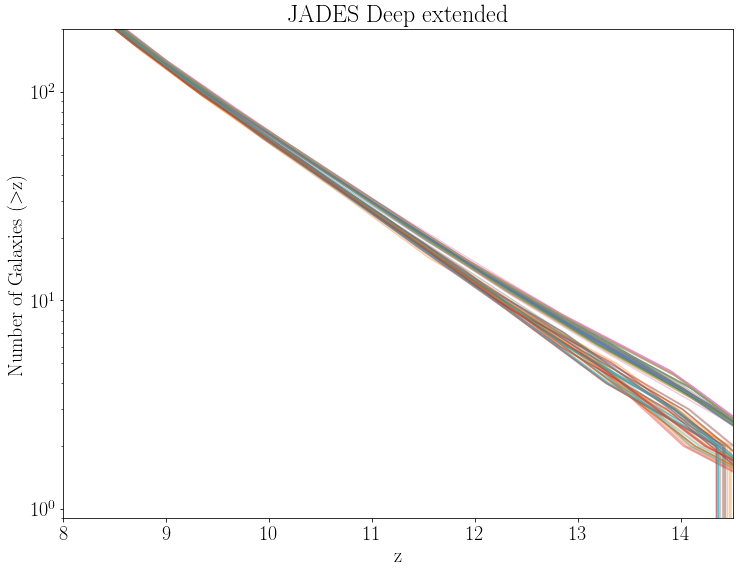

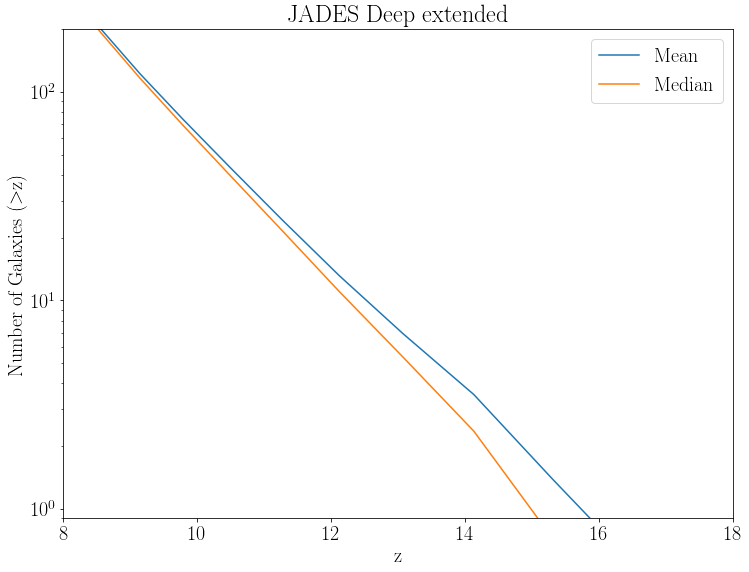

In [15]:
fig, ax = plt.subplots(figsize=(12,9))
meds, means = [],[]
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design matching the JADES Deep survey from Williams et al. 2018 (pg. 36)
    deep = survey(30.7, 190./3600, "cv_jades_deep_extend.csv", nearest_wavelength(x,14873.4))
    mean_deep, med_deep, z_vals_deep = mean_median(deep)
    summed+=med_deep
    summean+=mean_deep
    meds.append(med_deep)
    means.append(mean_deep)
    ax.plot(z_vals_deep, mean_deep, alpha=0.4, label = "Mean")
    ax.plot(z_vals_deep, med_deep, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e2), xlim=(8,14.5), title='JADES Deep extended')
winsound.Beep(400,300)
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e2), xlim=(8,18), title='JADES Deep extended')
if save==1:
    plt.savefig("figs/"+file+"/jadesdeepextend.pdf")
meandeepEfinal=summean/N
meddeepEfinal=summed/N
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

-2.0300158208183694
-1.9314197067011776
-1.845346573737451
-1.7697837999560968
-1.70307656284755
-1.6438831144310821
-1.591130056322111
-1.5439005274004711
-1.5014342038104176
-1.4631272989606219
-1.4284654761251383
-1.3969791235107119
-1.3682880791894698
-1.342079268632575
-1.3180619797775368
-1.2960125879609001
-1.275729830985556
-1.2570124466543948
-1.2397038977029986
-1.2236700093332942
-1.208776606747209
-1.1949118776130154
-1.1820087345316774
-1.169977727637813
-1.1587294070660399
-1.1481966854173218
-1.1383124752926226
-1.1290320517592514
-1.1203106898845168
-1.112103664735728
-1.1043662513801944
-1.0970537248852246
-1.0901437227844732
-1.083613882611595
-1.077419479433899
-1.0715381507850394
-1.0659475341986713
-1.0606252672084486
-1.0555713498143717
-1.0507634195500948
-1.0461791139492729
-1.04179607054556
-1.0376142893389566
-1.0336337703294625
-1.0298097885843864
-1.0261423441037287
-1.0226314368874896
-1.019254704469323
-1.0160121468492294
-1.0129037640272087
-1.00990719353

  2%|█▋                                                                                 | 1/50 [00:39<32:08, 39.36s/it]

-2.029368815284812
-1.9308322690725137
-1.8448111381196595
-1.7692940164024096
-1.702627081190052
-1.6434693951333605
-1.5907482083529545
-1.5435472136601955
-1.5011065465571896
-1.4628227852367846
-1.4281819037151102
-1.3967145739199376
-1.3680408636023196
-1.3418478873807698
-1.3178451088296226
-1.2958090383906737
-1.2755385354615392
-1.256832459439835
-1.2395343676348183
-1.2235101663115664
-1.2086257617351568
-1.194769409126487
-1.181874061618096
-1.169850323386702
-1.1586087986090232
-1.1480824404175982
-1.138204201944966
-1.1289293852794855
-1.1202132925095158
-1.1120112257234163
-1.1042784870095457
-1.0969703784562634
-1.0900645511077491
-1.083538656008182
-1.0773479952459215
-1.0714702198651471
-1.0658829809100383
-1.0605639294247748
-1.0555130654093565
-1.0507080399079631
-1.0461265039647738
-1.0417461086239685
-1.0375668538855471
-1.0335887397495098
-1.0297670683042155
-1.0261018395496642
-1.0225930534858558
-1.01921836115697
-1.015977762563007
-1.0128712577039667
-1.00987649

  4%|███▎                                                                               | 2/50 [01:45<37:50, 47.30s/it]

-2.011730489832978
-1.9148178525959594
-1.8302143731844633
-1.755941794090817
-1.6903735480309332
-1.6321907966663631
-1.5803384693263478
-1.533915359812947
-1.4921741264010397
-1.454521291838324
-1.4204513014283946
-1.3895025617527939
-1.3613014019489618
-1.3355400930712604
-1.3119328868130253
-1.2902599767845153
-1.270323537234963
-1.251925742413601
-1.2349127278476104
-1.2191526097031462
-1.2045135041463635
-1.1908855079823917
-1.178202679294308
-1.1663770955262165
-1.15532083412222
-1.1449679531653962
-1.1352525107388227
-1.1261305455645514
-1.1175580963646337
-1.1094912018611214
-1.101885900776066
-1.0946982318315195
-1.0879062143885079
-1.0814878678080566
-1.0753992308122176
-1.0696183227620166
-1.0641231630184795
-1.0588917709426324
-1.0539241465344749
-1.049198309155033
-1.0446922781653327
-1.0403840729263996
-1.036273693438234
-1.0323611397008357
-1.0286024504362563
-1.024997625644496
-1.0215466653255547
-1.0182275888404584
-1.015040396189207
-1.0119850873718004
-1.00903968174

  6%|████▉                                                                              | 3/50 [02:15<32:57, 42.08s/it]

-2.0140283093231814
-1.916904118574243
-1.8321159556818267
-1.75768124474042
-1.6919698677832677
-1.6336601075400292
-1.5816945901944304
-1.5351701422784045
-1.4933377906720915
-1.4556027626038377
-1.4214583997866788
-1.3904421011759949
-1.362179380211856
-1.3363618361978493
-1.312703097058734
-1.2909828765827862
-1.2710029171794552
-1.252564961258189
-1.235514808470782
-1.2197202870901993
-1.2050492253894072
-1.1913914802625436
-1.1786809658460915
-1.1668295676553613
-1.155749171205664
-1.145373690633482
-1.1356370400752986
-1.126495162288769
-1.1179040000315483
-1.109819496061292
-1.1021975931356551
-1.0949942340122931
-1.0881873900700336
-1.0817550326877043
-1.0756531046229605
-1.0698595772546295
-1.0643524219615395
-1.0591096101225175
-1.054131141737564
-1.0493949881855065
-1.0448791208451724
-1.0405615110953899
-1.0364421589361583
-1.0325210643674783
-1.0287541701470044
-1.0251414762747373
-1.0216829827506766
-1.0183566609536503
-1.015162510883658
-1.0121005325406998
-1.0091486973

  8%|██████▋                                                                            | 4/50 [03:12<35:41, 46.55s/it]

-1.996092093027551
-1.900619237191587
-1.8172726683295721
-1.744103518892121
-1.6795093866719621
-1.6221910266361725
-1.5711090427584138
-1.5253756175995217
-1.4842545123075062
-1.4471610666175525
-1.413597236600373
-1.383108286494445
-1.3553260968737733
-1.3299475105640093
-1.306691024474686
-1.2853400977669838
-1.2656998436859632
-1.2475753754766863
-1.2308151145519788
-1.215289136408548
-1.2008675165431018
-1.18744198453623
-1.1749475781362866
-1.1632976810077431
-1.1524056768150712
-1.1422066033066252
-1.1326354982307585
-1.1236490534197072
-1.1152039607057072
-1.1072569119209945
-1.0997645988978046
-1.092683713468374
-1.0859926015488202
-1.079669609055261
-1.073671427819933
-1.0679764037589534
-1.0625628827884408
-1.0574092108245126
-1.052515387867169
-1.0478597598325279
-1.0434206726367075
-1.0391764721958254
-1.0351271585098818
-1.0312727315788768
-1.027569883235046
-1.0240186134783895
-1.0206189223089075
-1.0173491556427177
-1.0142093134798202
-1.0111993958202152
-1.00829774858

 10%|████████▎                                                                          | 5/50 [04:04<36:14, 48.32s/it]

-2.029792327327243
-1.931216789601339
-1.845161619561193
-1.769614615257308
-1.7029212995312086
-1.6437402044165643
-1.5909981555403094
-1.5437784831254513
-1.5013210219910689
-1.4630221115523134
-1.4283675224220909
-1.3968877408121854
-1.3682026841321366
-1.3419993431898007
-1.3179870665924724
-1.295942276345763
-1.2756637522547232
-1.256950274124403
-1.2396453373587306
-1.2236147951610727
-1.2087245007347964
-1.1948626650827074
-1.1819622148064892
-1.169933718708386
-1.158687745590643
-1.148157222054943
-1.13827507470297
-1.128996587935846
-1.1202770461546931
-1.1120717337606338
-1.1043359351547908
-1.0970249347382857
-1.09011637471168
-1.0835878972755348
-1.0773947868309726
-1.071514685578554
-1.065925235718841
-1.0606040794523937
-1.055551216779213
-1.0507442898998594
-1.0461609410148944
-1.0417788123248792
-1.0375979038298138
-1.0336182155296978
-1.029795031825654
-1.026128352717682
-1.0226181782057822
-1.0192421504905151
-1.0160002695718815
-1.0128925354498808
-1.0098965903250745

 12%|█████████▉                                                                         | 6/50 [04:41<33:01, 45.03s/it]

-2.0303096189137757
-1.9316864556662483
-1.8455897091614326
-1.770006205279964
-1.7032806675236987
-1.6440709798130602
-1.5913034492843878
-1.5440609632833042
-1.5015829893647161
-1.4632655752928145
-1.4285942432370948
-1.397099252569706
-1.3684003370681006
-1.3421843363137114
-1.3181604584892967
-1.2961050175815938
-1.2758166961786663
-1.2570941768685777
-1.2397808794420442
-1.2237425922911083
-1.2088451038078118
-1.1949765709855242
-1.182069888020266
-1.1700355805067324
-1.158784174039618
-1.1482485628149446
-1.138361641028733
-1.1290786714783307
-1.1203549169610851
-1.112145640274344
-1.1044061042154543
-1.0970915715817637
-1.090179673771946
-1.083648042184675
-1.0774519396172981
-1.0715689974684888
-1.065976847136921
-1.0606531200212688
-1.0555978161215316
-1.0507885668363834
-1.046203003564498
-1.0418187577045488
-1.0376358292565362
-1.03365421822046
-1.0298291873936678
-1.0261607367761594
-1.022648866367935
-1.019271207567668
-1.016027760375359
-1.012918524791007
-1.0099211322132

 14%|███████████▌                                                                       | 7/50 [05:45<36:14, 50.57s/it]

-2.010388339326058
-1.913599269956086
-1.8291036636950242
-1.7549257854003688
-1.6894411417327282
-1.631332575930434
-1.5795463625841504
-1.533182444573404
-1.4914944330665825
-1.4538896075209344
-1.4198630578444869
-1.3889537791706559
-1.3607885770836352
-1.3350601150057022
-1.3114830089718283
-1.2898377328550688
-1.2699267131411736
-1.2515523763158918
-1.2345610540903627
-1.2188210307884189
-1.2042005907338937
-1.1905899708633148
-1.1779233133385985
-1.166112807708967
-1.1550706435236426
-1.1447309629445415
-1.1350279081335803
-1.1259175738653702
-1.117356054914522
-1.1092994460556471
-1.1017038420633565
-1.0945253377122606
-1.0877419803896657
-1.0813318174828768
-1.0752509437665052
-1.0694774066278565
-1.063989253454236
-1.0587645316329493
-1.0538032411639962
-1.0490834294346825
-1.0445831438323137
-1.0402804317441952
-1.036175293170327
-1.032267728110709
-1.0285138313399527
-1.0249136028580577
-1.0214670426650239
-1.0181521981481572
-1.0149690693074571
-1.0119176561429242
-1.008976

 16%|█████████████▎                                                                     | 8/50 [06:20<32:11, 45.99s/it]

-2.0361803000880707
-1.9370166404155298
-1.85044804751927
-1.7744503142388177
-1.7073590924644495
-1.6478249107558498
-1.5947681919607666
-1.5472667972616496
-1.5045560261756539
-1.4660286165546372
-1.4311672710131453
-1.3994996745470674
-1.3706434769149807
-1.3442838014474785
-1.3201282626658253
-1.297951948663302
-1.2775524387238613
-1.2587273121314555
-1.2413191305513815
-1.2251929468396074
-1.210213813852102
-1.1962692756355051
-1.1832918586178014
-1.1711915980363028
-1.1598785291283218
-1.1492851783218427
-1.1393440720448496
-1.1300102279159985
-1.1212386635539455
-1.1129843965773472
-1.1052024446048594
-1.097847825255138
-1.0908980473375116
-1.0843306196613078
-1.0781005598451832
-1.0721853766984655
-1.066562579030483
-1.0612096756505636
-1.0561266665587072
-1.0512910605642423
-1.0466803664764965
-1.0422720931047982
-1.0380662404491472
-1.0340628085095438
-1.0302168149046436
-1.026528259634447
-1.022997142698954
-1.0196009729074924
-1.0163397502600626
-1.0132134747566643
-1.01019

 18%|██████████████▉                                                                    | 9/50 [07:13<32:44, 47.92s/it]

-2.004060869463359
-1.9078543517153594
-1.8238673054889931
-1.750135887146854
-1.6850453808092984
-1.6272865573847226
-1.5758120335998438
-1.5297271695753993
-1.4882900688261476
-1.4509115782608668
-1.4170898267277756
-1.3863665840448127
-1.358370901969357
-1.332797293713368
-1.309362092973665
-1.287847094901647
-1.2680559151335735
-1.2497921693057041
-1.2329031140240185
-1.2172578263793565
-1.2027253834625573
-1.1891966828493208
-1.1766062630850667
-1.1648668422303552
-1.1538911383457455
-1.1436136899766578
-1.1339690356685117
-1.1249135344515873
-1.1164035453561643
-1.1083954274125227
-1.1008455396509425
-1.093710241101703
-1.086967711279945
-1.0805961297008078
-1.0745518553945714
-1.0688130678763759
-1.0633579466613612
-1.0581646712646673
-1.053233241686294
-1.0485418374413813
-1.0440686380450692
-1.0397918230124976
-1.0357113923436667
-1.031827346038576
-1.0280960431275061
-1.0245174836104565
-1.0210916674874273
-1.0177967742735583
-1.0146328039688497
-1.0115997565733017
-1.0086758

 20%|████████████████▍                                                                 | 10/50 [08:07<33:09, 49.74s/it]

-2.0323994337738633
-1.9335838673916261
-1.8473191554376158
-1.7715881963072961
-1.7047324842369367
-1.6454072848235137
-1.5925368105446074
-1.5452021595581513
-1.5026413157024314
-1.4642491484960871
-1.4295101764179585
-1.3979537424269879
-1.3691988384423177
-1.3429316931032425
-1.3188609472891073
-1.2967624785994074
-1.2764345768736898
-1.2576755319515005
-1.2403284581524867
-1.224258882036346
-1.209332330162776
-1.1954367413315248
-1.1825048788224408
-1.1704470936753228
-1.1591737369299688
-1.148617571866228
-1.1387113617639486
-1.1294102821430305
-1.1206695085233724
-1.1124442164248736
-1.1046895813674333
-1.0973607788709507
-1.0904353966953755
-1.083891022600657
-1.077682832106695
-1.0717884129734383
-1.066185352960837
-1.0608512398288403
-1.0557860735774487
-1.0509674419666117
-1.0463729327562785
-1.041980133706399
-1.0377890448169733
-1.0337996660880011
-1.0299671730393818
-1.0262915656711153
-1.0227728439832016
-1.0193885957355904
-1.0161388209282816
-1.0130235195612753
-1.0100

 22%|██████████████████                                                                | 11/50 [08:43<29:41, 45.68s/it]

-2.0129695151595555
-1.9159428044888691
-1.831239740444535
-1.756879736961603
-1.6912343121644478
-1.6329830753431038
-1.581069713929598
-1.5345919609387861
-1.4928015949683546
-1.4551044401988185
-1.420994346858024
-1.3900091781974828
-1.3617748235160378
-1.3359831916480307
-1.312348197939635
-1.2906497772725232
-1.2706898710402001
-1.252270420636171
-1.2352373804776065
-1.2194587114935098
-1.2048023746128846
-1.1911583372765668
-1.1784605799490582
-1.1666210765830276
-1.1555518011311439
-1.145186734057909
-1.1354598558278242
-1.1263271534172243
-1.1177446138024438
-1.109668223959817
-1.1020539708656782
-1.0948578414963623
-1.0880578293400363
-1.0816319278848672
-1.0755361241071897
-1.069748411495171
-1.0642467835369782
-1.0590092337207788
-1.0540357620465728
-1.049304362002527
-1.044793027076809
-1.040479750757586
-1.0363645330448579
-1.0324473739386246
-1.0286842604152209
-1.0250751924746464
-1.0216201701169014
-1.0182971868301531
-1.0151062426144013
-1.0120473374696461
-1.009098464

 24%|███████████████████▋                                                              | 12/50 [09:44<31:55, 50.42s/it]

-2.03710323097668
-1.9378545997597787
-1.851211827803813
-1.7751489734418469
-1.7080002624143993
-1.648415066943513
-1.595312884806822
-1.5477707870227224
-1.5050234178503714
-1.4664629947896883
-1.431571777192456
-1.3998770453363898
-1.3709961213510677
-1.344613858754967
-1.3204376215295301
-1.2982423050450973
-1.2778253151349748
-1.2589840576324693
-1.2415609592968193
-1.2254209573502286
-1.2104289890149018
-1.1964725019760087
-1.183483964844652
-1.1713733357689675
-1.1600505728970916
-1.1494481448401261
-1.1394985202091736
-1.1301566780783017
-1.1213775975215787
-1.1131162576130729
-1.105327637426852
-1.0979667160369841
-1.0910109829805037
-1.0844379277944445
-1.0782025295528745
-1.072282277792828
-1.066654662051339
-1.0612971718654414
-1.0562098072351354
-1.0513700576974547
-1.0467554127894336
-1.0423433620481062
-1.0381339054734724
-1.0341270430655323
-1.0302777538983536
-1.026586037971937
-1.0230518952862817
-1.0196528153784223
-1.0163887982483586
-1.0132598438960907
-1.010243441

 26%|█████████████████████▎                                                            | 13/50 [10:22<28:41, 46.53s/it]

-2.0009553582320643
-1.9050347558094791
-1.8212973099658571
-1.7477850133938646
-1.6828879489741388
-1.6253007785017908
-1.5739792314129095
-1.5280313266008207
-1.4867173724160874
-1.44944996666651
-1.4157287297068804
-1.3850967931654878
-1.3571843112176136
-1.3316867049487842
-1.3083211510812731
-1.2868700932475992
-1.2671377307170288
-1.2489282627588287
-1.2320893999157623
-1.21649060836734
-1.2020013542930734
-1.1885128595092216
-1.17595985710554
-1.1642553245350364
-1.153312239250718
-1.1430653343423403
-1.1334493428996588
-1.1244207536491773
-1.1159360553173996
-1.1079517366308291
-1.10042428631597
-1.0933101930993256
-1.0865877013441478
-1.0802350554136886
-1.0742087440344514
-1.0684870115696885
-1.0630481023826515
-1.0578702608365922
-1.052953486931511
-1.048276025030659
-1.0438161194972886
-1.0395520146946515
-1.035483710622748
-1.0316112072815775
-1.0278909933976443
-1.024323068970948
-1.0209074340014888
-1.0176223328525182
-1.0144677655240368
-1.0114437320160443
-1.0085284766

 28%|██████████████████████▉                                                           | 14/50 [11:13<28:49, 48.05s/it]

-2.0157977255190755
-1.9185106298022387
-1.833580252978899
-1.7590206937983157
-1.6931991001209907
-1.6347915377797644
-1.5827388594409078
-1.5361363767568617
-1.494233860366235
-1.4564355398938056
-1.4222339072421617
-1.3911655854527976
-1.3628554598450175
-1.3369946124464844
-1.313296190854313
-1.2915395393739773
-1.2715260678804023
-1.2530571862485147
-1.2359784354921457
-1.2201574221945788
-1.2054617529390983
-1.1917810998784408
-1.1790492663042482
-1.16717798993871
-1.1560790085040153
-1.145686125291806
-1.1359331435937245
-1.126775932270865
-1.1181703601843225
-1.1100722961951912
-1.1024376091645662
-1.095222167953542
-1.088403906992666
-1.0819607607124855
-1.0758485979740948
-1.0700453532080418
-1.0645289608448734
-1.0592773553151371
-1.0542905366188329
-1.0495464391865081
-1.0450229974487102
-1.040698145835986
-1.0365718843483362
-1.0326442129857603
-1.028871000609353
-1.0252522472191148
-1.021787952815045
-1.0184560518276913
-1.0152565442570538
-1.0121894301031322
-1.009232643

 30%|████████████████████████▌                                                         | 15/50 [12:06<28:48, 49.37s/it]

-2.0291108091314296
-1.9305980167901722
-1.8445976226596437
-1.7690987055988345
-1.7024478415584692
-1.6433044164445412
-1.5905959389818456
-1.5434063228728103
-1.500975886797499
-1.4627013544136083
-1.4280688236517691
-1.396609079579079
-1.3679422815355697
-1.3417556195659726
-1.317758627283253
-1.2957278690050766
-1.2754622526173425
-1.2567606860059493
-1.239466764193263
-1.2234464257698834
-1.2085656093264092
-1.1947125970216734
-1.181820358150976
-1.1697995184413827
-1.15856070361996
-1.1480368829820078
-1.1381610258228252
-1.1288884450059458
-1.1201744533949023
-1.111974363853228
-1.1042434892444561
-1.09693714243212
-1.0900329798479855
-1.0835086579238196
-1.0773194895231555
-1.0714431310777595
-1.0658572390193983
-1.0605394697798385
-1.0554898233590801
-1.0506859561888895
-1.0461055247010334
-1.0417261853272781
-1.037547938067624
-1.0335707829220708
-1.0297500327541518
-1.0260856875638669
-1.022577747351216
-1.019203868547966
-1.0159640511541166
-1.0128582951696676
-1.0098642570

 32%|██████████████████████████▏                                                       | 16/50 [12:47<26:34, 46.90s/it]

-2.0260252760118314
-1.927796559669745
-1.84204416021393
-1.7667629552876634
-1.7003042887309738
-1.6413314123060472
-1.5887749274226313
-1.5417213894515525
-1.499413307724716
-1.4612491455351053
-1.4267164827248915
-1.3953474574108389
-1.3667633242589006
-1.3406521753469194
-1.3167243818900356
-1.2947571525152801
-1.2745499749869806
-1.255902337069465
-1.238658284801655
-1.222684143359769
-1.2078462379200254
-1.1940331727959397
-1.1811781105756214
-1.1691919347098825
-1.1579855286495357
-1.1474920549826901
-1.1376446762974548
-1.1283988343192362
-1.1197099707734404
-1.1115335273854736
-1.103824945880742
-1.0965396679846517
-1.0896554145599058
-1.0831499064692074
-1.0769785854379628
-1.0711191723288749
-1.0655493880046467
-1.0602469533279817
-1.0552118682988794
-1.0504218537800434
-1.0458546306341763
-1.0414879197239815
-1.037321721049459
-1.0333560346106085
-1.0295463021328366
-1.025892523616143
-1.0223946990605277
-1.019030549328694
-1.0158000744206417
-1.0127032743363709
-1.00971786

 34%|███████████████████████████▉                                                      | 17/50 [13:44<27:24, 49.84s/it]

-2.0060941393844463
-1.909700424428694
-1.8255499574600638
-1.7516750736234825
-1.686457915149223
-1.628586705467237
-1.577012023321485
-1.5308374880557676
-1.489319759613723
-1.4518685385388301
-1.4179809771459029
-1.3871979536354244
-1.3591477979792144
-1.3335244289775945
-1.3100436283737211
-1.2884867667392526
-1.2686570775886816
-1.250357794436501
-1.2334358766828715
-1.2177601466707884
-1.2031994267432466
-1.1896444021860757
-1.1770294841707731
-1.1652672209260024
-1.1542701606804266
-1.1439727146055436
-1.1343092938728507
-1.12523617259668
-1.1167096248913628
-1.1086859248712309
-1.1011213466506162
-1.0939721643438503
-1.087216515008099
-1.0808325357005282
-1.0747765005354697
-1.069026546570089
-1.0635608108615524
-1.0583574304670256
-1.0534164053865083
-1.0487158726771668
-1.0442339693961669
-1.039948832600674
-1.0358604622906886
-1.0319688584662106
-1.0282302952415714
-1.0246447726167716
-1.0212122905918104
-1.0179109862238542
-1.014740859512903
-1.0117019104589566
-1.008772276

 36%|█████████████████████████████▌                                                    | 18/50 [14:30<25:59, 48.72s/it]

-2.0133073269892283
-1.916249514972575
-1.8315192998552927
-1.757135460707125
-1.6914689936520837
-1.633199084736665
-1.5812690827980656
-1.5347764316347243
-1.4929726700063222
-1.4552634316337827
-1.4211424045015957
-1.3901473037260348
-1.3619038986869405
-1.336103999461829
-1.312461429694107
-1.2907560537248577
-1.2707897494610554
-1.2523643948096743
-1.2353258948094727
-1.2195421680650997
-1.204881133181205
-1.1912327223283303
-1.1785308948088
-1.1666875963590475
-1.1556147727155055
-1.1452463831804989
-1.1355163870563527
-1.1263807572112832
-1.1177954665135073
-1.1097164878312409
-1.102099794032701
-1.0949013579861042
-1.0880991661255586
-1.0816712048851724
-1.0755734471331622
-1.0697838793036363
-1.0642804878307028
-1.0590412591484704
-1.0540661932569386
-1.049333276590216
-1.0448204955824105
-1.0405058366676307
-1.0363892998458766
-1.032470885117148
-1.0287065653496614
-1.0250963405434173
-1.021640210698415
-1.0183161622487633
-1.0151241951944618
-1.0120643095355109
-1.0091144917

 38%|███████████████████████████████▏                                                  | 19/50 [15:24<25:58, 50.26s/it]

-2.0212712670952118
-1.9234802384332477
-1.8381099346637084
-1.763164167857454
-1.697001627939414
-1.6382915229568287
-1.5859692193474904
-1.5391253426103464
-1.4970057773054997
-1.4590116670542082
-1.4246328749412474
-1.3934036237831515
-1.3649468558599716
-1.3389520530493975
-1.3151308770949974
-1.2932615293379786
-1.2731443909854268
-1.254579843244428
-1.2374126270538268
-1.2215096632183475
-1.206737872542714
-1.1929863556975298
-1.1801885730851567
-1.1682558052420773
-1.1570993327047747
-1.1466526158756105
-1.1368491151569469
-1.127644470817025
-1.1189943231240864
-1.1108543123463726
-1.1031800787521246
-1.0959272626095837
-1.089073684052871
-1.0825971632161067
-1.0764533403675325
-1.0706200356412687
-1.0650750691714364
-1.059796261092156
-1.0547836114034275
-1.0500149402393717
-1.045468067734109
-1.0411208140217605
-1.036973179102326
-1.0330251629758052
-1.0292324059104399
-1.0255949079062299
-1.0221126689631752
-1.0187635092153964
-1.0155474286628936
-1.0124644273056669
-1.009492

 40%|████████████████████████████████▊                                                 | 20/50 [16:13<24:59, 49.99s/it]

-2.0174603699774813
-1.9200201994539636
-1.8349561903033589
-1.7602793165907338
-1.6943541569918104
-1.635854694216635
-1.5837201144332425
-1.5370443058268308
-1.4950758585997592
-1.4572180649715476
-1.4229626183143802
-1.3918454125767725
-1.363490742859904
-1.3375892051294522
-1.31385349563926
-1.2920626115076683
-1.272017650141184
-1.2535197089463135
-1.2364140859058956
-1.2205681792909349
-1.2058493873724356
-1.1921472087095686
-1.179395342437836
-1.167505387404574
-1.156388942457119
-1.1459797067309732
-1.136211379361639
-1.1270397597727846
-1.1184206473880778
-1.1103098416311872
-1.1026631419257809
-1.0954363476955267
-1.088607358652259
-1.082154074507812
-1.0760322946858538
-1.0702199188982182
-1.0646948468567397
-1.059434978273252
-1.0544403131477553
-1.0496887511920836
-1.0451581921180713
-1.040826535637552
-1.036693781750526
-1.0327599304569932
-1.0289807811806218
-1.0253563339214118
-1.021886588679363
-1.01854944516631
-1.0153449033822524
-1.0122729633271903
-1.00931152471295

 42%|██████████████████████████████████▍                                               | 21/50 [17:00<23:44, 49.13s/it]

-2.039141405151068
-1.9397051252061732
-1.8528985383366114
-1.7766918724409888
-1.7094162037914944
-1.6497183509871998
-1.5965157689073615
-1.548883783594679
-1.5060555922552923
-1.4674222632587843
-1.4324650770681318
-1.40071042019301
-1.3717748912364893
-1.3453427478716864
-1.3211208007950666
-1.2988835197731419
-1.2784279275957728
-1.2595510470528206
-1.2420950069808432
-1.2259244892397478
-1.2109041756894416
-1.1969213012131807
-1.1839082067409183
-1.1717746801792597
-1.1604305094348093
-1.1498080354375206
-1.1398395991173476
-1.1304800944275923
-1.121684415321557
-1.1134074557525446
-1.105604109673857
-1.0982292710387966
-1.0912603868240152
-1.0846749040061632
-1.0784277165385432
-1.0724962713978068
-1.0668580155606047
-1.0614903960035884
-1.0563934127267578
-1.0515445127067642
-1.0469211429202585
-1.0425007503438921
-1.038283334977665
-1.0342688968215772
-1.030412329828931
-1.0267136339997265
-1.0231728093339636
-1.0197673028082936
-1.0164971144227164
-1.013362244177232
-1.010340

 44%|████████████████████████████████████                                              | 22/50 [17:49<22:52, 49.01s/it]

-1.9992621187913056
-1.9034974079658369
-1.819896053471115
-1.7465032301825558
-1.6817116374421672
-1.6242180585002268
-1.572979919956956
-1.5271066903667112
-1.4858598802379825
-1.4486530420333947
-1.4149866093322205
-1.3844044562720574
-1.3565373381071502
-1.33108117092923
-1.3077535911091909
-1.2863373958554116
-1.2666371026554344
-1.2484572289968003
-1.2316457329253754
-1.2160722927661871
-1.2016065868442634
-1.1881400137637936
-1.1756074126872922
-1.1639219024981104
-1.1529966020796003
-1.1427663505942758
-1.133165987204651
-1.124152071352401
-1.1156811624792022
-1.1077098200267308
-1.1001946034366623
-1.0930920721506727
-1.0863805058896
-1.080038184374282
-1.0740216670463947
-1.068309233626776
-1.0628791638362642
-1.0577097373956967
-1.052800954305074
-1.0481310942852338
-1.043678437057014
-1.0394212623412526
-1.0353595701379497
-1.0314933604471053
-1.027779192710395
-1.0242170669278192
-1.0208069830993778
-1.0175272209459085
-1.0143777804674114
-1.011358661663887
-1.008448144256

 46%|█████████████████████████████████████▋                                            | 23/50 [18:38<22:03, 49.02s/it]

-2.0019501519911462
-1.9059379618201473
-1.8221205610562157
-1.7485380728303583
-1.68357904282807
-1.6259368864700217
-1.5745663360927513
-1.5285745589003834
-1.4872211569646323
-1.4499181672248
-1.4161647322588102
-1.3855035474638984
-1.357564413875921
-1.332042461759702
-1.3086545977897195
-1.287183057869419
-1.2674318543119012
-1.2492049994302667
-1.2323500583569276
-1.2167363726339504
-1.2022332838034027
-1.1887319098170066
-1.1761669214457964
-1.1644512130511497
-1.1534976789944447
-1.1432409900467149
-1.133615816978994
-1.124578606971971
-1.1160858072063349
-1.1080938648627747
-1.1005592271219797
-1.0934383411646387
-1.0867094305810963
-1.0803507189616968
-1.0743186534871296
-1.0685914577477391
-1.06314735533387
-1.0579645698358664
-1.0530431012537285
-1.0483611731778009
-1.043897009198428
-1.0396288329059544
-1.0355566443003803
-1.0316804433817053
-1.0279566773306188
-1.0243853461471206
-1.0209664498312105
-1.0176782119732335
-1.0145206325731893
-1.011493711631078
-1.00857567273

 48%|███████████████████████████████████████▎                                          | 24/50 [19:26<21:09, 48.83s/it]

-2.0152266199590394
-1.9179921042587864
-1.833107629110165
-1.7585883665673765
-1.6928023469860984
-1.6344263517357995
-1.5824018059120535
-1.5358245101173305
-1.4939446404609957
-1.4561667485593097
-1.4219836006039022
-1.3909320700740868
-1.3626372450245463
-1.3367903744414897
-1.3131047609549686
-1.2913598681265612
-1.271357213161687
-1.2528983132657672
-1.2358287929319056
-1.2200163302970493
-1.2053286034981452
-1.191655344315982
-1.1789303918190337
-1.167065531431931
-1.155972548579305
-1.1455852823296298
-1.135837571751378
-1.1266853095568656
-1.1180843884584082
-1.1099907011683214
-1.1023601403989207
-1.0951485988625218
-1.0883340229152827
-1.0818943589133607
-1.0757854995690717
-1.0699853912385735
-1.0644719802780238
-1.0592232130435808
-1.0542390895352438
-1.0494975561091713
-1.0449765591215205
-1.0406540449284496
-1.0365300135299584
-1.0326044649260473
-1.0288332918290313
-1.0252164942389108
-1.0217540721556857
-1.0184239719355137
-1.0152261935783948
-1.0121607370843293
-1.009

 50%|█████████████████████████████████████████                                         | 25/50 [20:15<20:17, 48.72s/it]

-2.032837858835758
-1.933981927941881
-1.8476819782910463
-1.7719200843263359
-1.7050370628120617
-1.6456876300436127
-1.5927955590572997
-1.5454415726549708
-1.5028633434040133
-1.464455493637352
-1.4297023312682184
-1.3981330069999993
-1.3693663571163877
-1.3430884820863076
-1.3190079037737599
-1.2969004082279756
-1.2765642028932636
-1.2577974952139315
-1.2404433354244415
-1.224367195154333
-1.209434546033144
-1.1955332810854906
-1.1825961361261423
-1.1705334255747917
-1.159255463851131
-1.1486949867699296
-1.1387847301459575
-1.1294798511890605
-1.120735507109085
-1.1125068551158774
-1.1047490524192838
-1.0974172562291504
-1.0904890451504008
-1.0839419977879574
-1.0777312713516674
-1.071834444446453
-1.066229095677238
-1.0608928036489453
-1.055825568361575
-1.05100496842005
-1.0464085824292935
-1.042013988994229
-1.037821188114856
-1.033830179791175
-1.029996121233032
-1.026319012440427
-1.0227988534133599
-1.0194132227567538
-1.016162120470609
-1.0130455465549255
-1.010041079614626

 52%|██████████████████████████████████████████▋                                       | 26/50 [21:07<19:57, 49.89s/it]

-2.0318106643887357
-1.933049304279735
-1.8468319137014761
-1.7711424975508039
-1.7043234598540136
-1.645030803875668
-1.5921893322274183
-1.5448806471400496
-1.5023431504634805
-1.4639720436667651
-1.4292521280013193
-1.39771300460974
-1.3689738744169868
-1.3427211381847917
-1.3186635966204763
-1.2965772502681345
-1.276260499617451
-1.2575117451581102
-1.2401741872709777
-1.2241134262825102
-1.2091950625191639
-1.1953070962529855
-1.1823823276472032
-1.170331156919455
-1.159063984287378
-1.1485136099142006
-1.1386128339631507
-1.1293168565430476
-1.1205808777627095
-1.1123600977309556
-1.1046097165566044
-1.0972849343484747
-1.0903633511609763
-1.083822567048518
-1.0776177821199189
-1.0717265964295883
-1.0661266100319358
-1.0607954229813705
-1.0557330352778926
-1.0509170469759115
-1.0463250581298364
-1.0419346687940767
-1.0377458789686327
-1.033758688653504
-1.0299282979575097
-1.0262547068806496
-1.0227379154229237
-1.0193555236387417
-1.0161075315281032
-1.0129939390910083
-1.009992

 54%|████████████████████████████████████████████▎                                     | 27/50 [21:51<18:27, 48.14s/it]

-2.0359808453638526
-1.9368355489037214
-1.8502829868544937
-1.7742993269001315
-1.7072205291363365
-1.6476973720190837
-1.5946504783131528
-1.5471578799634593
-1.5044550180950562
-1.465934743013132
-1.4310798531258098
-1.399418120892681
-1.3705672668762716
-1.3442124727163094
-1.320061407078255
-1.2978891997047715
-1.2774934673642546
-1.2586718268251005
-1.2412668689071733
-1.22514367145607
-1.2101673123173884
-1.1962253563624596
-1.1832503425140821
-1.1711523226693212
-1.159841348725242
-1.1492499596046428
-1.1393106942303226
-1.1299785785508136
-1.1212086385146487
-1.1129559000703602
-1.1051753891664806
-1.0978221317515422
-1.0908736407998116
-1.0843074292855548
-1.0780785231573042
-1.0721644353893263
-1.0665426789558872
-1.0611907668312532
-1.0561086990154245
-1.0512739884826667
-1.0466641482072467
-1.0422566911634306
-1.0380516173512182
-1.0340489267706094
-1.030203645370137
-1.0265157731498011
-1.0229853101096014
-1.0195897692238043
-1.0163291504924097
-1.0132034539154176
-1.0101

 56%|█████████████████████████████████████████████▉                                    | 28/50 [22:46<18:21, 50.06s/it]

-2.0431701110582394
-1.9433629199574483
-1.8562325324439657
-1.7797416050841173
-1.7122149888324367
-1.6522944547331413
-1.5988934196216045
-1.5510837603780412
-1.5080958139275076
-1.4693183772399019
-1.434230795882173
-1.4023576897197976
-1.3733142272153034
-1.3467834882790077
-1.3224711899704913
-1.3001509607971231
-1.279619066415536
-1.2606717724823626
-1.2431506189527612
-1.2269197829311538
-1.211843441521962
-1.1978084089788705
-1.1847467738540902
-1.1725679875505688
-1.1611815014712543
-1.1505194041683575
-1.1405137841940889
-1.131119367249923
-1.1222908790373332
-1.1139830452577935
-1.1061505916127778
-1.0987482438037603
-1.0917533646814777
-1.0851433170966667
-1.0788728267508017
-1.0729192564946193
-1.0672599691788567
-1.0618723276542505
-1.056756331920801
-1.0518893448292452
-1.0472487292303199
-1.042811847974762
-1.0385787010625713
-1.0345492884937482
-1.0306783359697667
-1.0269658434906261
-1.0234118110563273
-1.0199936015176065
-1.0167112148744641
-1.0135646511269
-1.010531

 58%|███████████████████████████████████████████████▌                                  | 29/50 [23:29<16:45, 47.90s/it]

-2.027798504877285
-1.929406532545978
-1.8435116127221631
-1.7681052905385648
-1.7015361697709785
-1.6424652805078872
-1.5898214468200778
-1.5426897059346798
-1.500311308235167
-1.4620837172613568
-1.4274936612138347
-1.3960725006235692
-1.3674408606822976
-1.3412863150773326
-1.3173187536611783
-1.295315014781916
-1.2750742529528174
-1.2563956226871555
-1.2391229108285864
-1.2231222203859582
-1.2082596543681197
-1.1944236319491108
-1.1815472046333557
-1.1695411077600868
-1.158316076668536
-1.1478051628631276
-1.1379414178482858
-1.1286802092936266
-1.1199769048687662
-1.1117868722433206
-1.104065479086906
-1.0967680930691384
-1.089872398024826
-1.0833560777887765
-1.0771745000306066
-1.0713053485851236
-1.0657263072871361
-1.0604150599714521
-1.0553716066380714
-1.0505736311218024
-1.0459988172574526
-1.0416248488798303
-1.0374517259889358
-1.0334794485847687
-1.0296633843369454
-1.0260035332454656
-1.0224998953103295
-1.019130154366345
-1.0158943104135123
-1.0127923634518312
-1.00980

 60%|█████████████████████████████████████████████████▏                                | 30/50 [24:20<16:20, 49.03s/it]

-2.00581341383244
-1.909445544456232
-1.8253176403444096
-1.7514625642223396
-1.6862628921086564
-1.6284071991536049
-1.5768463454773802
-1.5306841907659825
-1.4891775942712175
-1.4517364148106948
-1.4178579395253417
-1.3870831697177433
-1.3590405350138024
-1.3334240362819096
-1.3099495314712841
-1.2883984497736336
-1.2685740774614946
-1.250279700807404
-1.2333623202455566
-1.217690793290977
-1.2031339774586898
-1.1895825873445485
-1.1769710517060652
-1.1652119422199234
-1.1542178305628055
-1.1439231454922238
-1.134262315765691
-1.125191627221548
-1.1166673656981365
-1.108645817033798
-1.101083267066874
-1.093936001635706
-1.0871821636594645
-1.0807998960573206
-1.0747454846676154
-1.0689970724095201
-1.063532802202205
-1.058330816964841
-1.0533911166974284
-1.0486918443191373
-1.044211142749139
-1.039927154906604
-1.0358398807915323
-1.031949320403924
-1.0282117595821205
-1.024627198326122
-1.021195636635928
-1.0178952174307099
-1.0147259407104672
-1.0116878064752
-1.008758957644079
-

 62%|██████████████████████████████████████████████████▊                               | 31/50 [25:17<16:13, 51.26s/it]

-2.0030426340766834
-1.9069298622791078
-1.8230246550555043
-1.7493650823850557
-1.6843380018062013
-1.6266354599717303
-1.5752110942038735
-1.5291711363820366
-1.4877744129427994
-1.4504323448799175
-1.4166435500769594
-1.3859502448624013
-1.3579818424545333
-1.3324331537390064
-1.3090207888239245
-1.2875267554847525
-1.2677548607194087
-1.2495089115258113
-1.2326363133467857
-1.217006270847611
-1.2024879886935658
-1.1889724707723826
-1.1763943194167008
-1.1646663377367061
-1.153701328842585
-1.1434338950669765
-1.13379863874252
-1.1247519614243087
-1.1162502646674353
-1.108249950026993
-1.1007074190580746
-1.093579073315773
-1.086843113577635
-1.0804777406212067
-1.0744393560015815
-1.0687061604963053
-1.063256354882925
-1.0580681399389869
-1.053141515664491
-1.0484546828369838
-1.043985842234012
-1.039713194633122
-1.0356367400343134
-1.0317564784375866
-1.0280288113980345
-1.024453738915657
-1.0210312609904542
-1.0177395783999723
-1.0145786911442118
-1.0115485992231723
-1.008627503

 64%|████████████████████████████████████████████████████▍                             | 32/50 [25:54<14:07, 47.08s/it]

-2.0037264492504194
-1.9075507205921658
-1.8235905528431031
-1.7498827308571112
-1.6848130555140468
-1.6270727167164973
-1.5756146663865314
-1.5295445509575836
-1.4881207113744526
-1.4507541830933033
-1.4169432555767931
-1.386229845290828
-1.358243122707807
-1.3326776988050006
-1.3092499980613028
-1.2877418854604776
-1.2679570394879134
-1.249699138628998
-1.2328154883723665
-1.2171752077082776
-1.2026474156269902
-1.189123044620386
-1.1765366541835949
-1.1648009903101224
-1.1538287989934743
-1.14355463972878
-1.1339130720111688
-1.1248604688373933
-1.116353203204207
-1.1083476481083623
-1.1008001765466124
-1.09366716151571
-1.0869267895140315
-1.0805572470399536
-1.074514907090229
-1.0687779561632338
-1.063324580757345
-1.058132967370939
-1.0532031160040156
-1.0485132131549513
-1.0440414453221227
-1.0397659990039059
-1.0356868742003011
-1.0318040709113083
-1.0280739621336805
-1.0244965478674175
-1.0210718281125193
-1.0177779893673626
-1.014615031631947
-1.011582954906273
-1.00865994568

 66%|██████████████████████████████████████████████████████                            | 33/50 [26:54<14:26, 50.96s/it]

-2.0111973562795016
-1.9143338030876136
-1.8297731734129534
-1.7555382116902525
-1.6900031744547337
-1.6318498913295516
-1.5800238260132295
-1.5336242287482562
-1.4919041363210856
-1.4542703720621373
-1.420217637326953
-1.3892845724836376
-1.3610976959254175
-1.3353494345643622
-1.3117541848188219
-1.2900922516259887
-1.2701659094293358
-1.2517774326723363
-1.2347730348110253
-1.2190208988077176
-1.2043892076247287
-1.1907681137306552
-1.1780917086066545
-1.1662721142276034
-1.1552214525683793
-1.1448738151101394
-1.1351632933340416
-1.1260459482275247
-1.1174778407780268
-1.1094150319729865
-1.101813582799842
-1.0946295542460325
-1.0878409768052764
-1.0814258809712933
-1.0753403277315217
-1.0695623475796807
-1.0640699710094899
-1.058841228514668
-1.0538761200952154
-1.049152676244851
-1.0446489274572945
-1.0403429042262649
-1.036234606551762
-1.032324034433786
-1.0285672488597752
-1.02496424982973
-1.0215150373436501
-1.0181976418952547
-1.015012063484544
-1.011958302111518
-1.0090143

 68%|███████████████████████████████████████████████████████▊                          | 34/50 [27:33<12:34, 47.17s/it]

-2.006174741732355
-1.9097736059544528
-1.8256166607040232
-1.7517360896462932
-1.6865139104615614
-1.6286382455933133
-1.5770595929963362
-1.5308815030070124
-1.4893605783433161
-1.4519064741048162
-1.4180163038948486
-1.3872309105686325
-1.3591785954851558
-1.3335532538812318
-1.3100706456196154
-1.2885121244408875
-1.2686809087115707
-1.2503802167981881
-1.2334569963191462
-1.2177800595187933
-1.203218218641478
-1.189662150557491
-1.177046261389006
-1.165283092632256
-1.1542851857834728
-1.143986946964831
-1.1343227822985047
-1.12524896253261
-1.1167217584152633
-1.1086974406945806
-1.101132280118678
-1.093982547435672
-1.0872263780196203
-1.0808419072445812
-1.0747854058586708
-1.0690350092359473
-1.0635688527504685
-1.058365071776293
-1.0534236663134202
-1.0487227717359084
-1.044240523417816
-1.0399550567332008
-1.0358663716820626
-1.0319744682644019
-1.0282356172283345
-1.0246498185738604
-1.0212170723009797
-1.0179155137837506
-1.014745143022173
-1.0117059600162468
-1.0087761001

 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [28:25<12:11, 48.73s/it]

-2.001811028914012
-1.9058116473973403
-1.822005428423045
-1.7484327565825297
-1.683482392539837
-1.6258479260225704
-1.5744842288128114
-1.5284985872244214
-1.4871507021030426
-1.449852688826096
-1.4161037567891623
-1.3854466623969026
-1.3575112560721374
-1.3319927087513075
-1.3086079648753934
-1.2871392893989957
-1.2673907207812545
-1.2491662974813103
-1.2323136049673833
-1.216702002212234
-1.2022008481886224
-1.188701275373849
-1.1761379632542937
-1.1644238178117967
-1.1534717450281982
-1.1432164243898784
-1.1335925353832172
-1.124556530999135
-1.1160648642285516
-1.1080739880623873
-1.100540355491562
-1.093420419506996
-1.0866924066041492
-1.0803345432784819
-1.0743032825209138
-1.068576850826905
-1.0631334746919157
-1.0579513806114058
-1.0530305685853754
-1.0483492651092847
-1.0438856966785934
-1.0396180897887617
-1.0355464444397897
-1.0316707606316775
-1.0279474913553448
-1.0243766366107918
-1.0209581963980185
-1.017670397212485
-1.014513239054191
-1.0114867219231372
-1.008569072

 72%|███████████████████████████████████████████████████████████                       | 36/50 [29:20<11:49, 50.65s/it]

-1.9985184677480081
-1.9028222226965146
-1.8192806379373407
-1.7459402859235063
-1.6811950151163835
-1.6237425404846522
-1.5725410340032566
-1.5267006009007948
-1.4854832796595188
-1.4483030420153344
-1.4146606787062361
-1.3841003899712616
-1.3562531950515369
-1.330815227439754
-1.3075043253791272
-1.2861034413644363
-1.2664172326409833
-1.2482503564540701
-1.231450879550043
-1.2158885734257696
-1.2014332095781184
-1.1879762642544789
-1.1754526232032856
-1.16377546742245
-1.1528579779098846
-1.142635040414023
-1.1330415406832997
-1.1240340692166702
-1.1155692165130904
-1.1076035730715168
-1.1000937293909052
-1.0929962759702114
-1.0862895080589139
-1.0799517209064902
-1.0739395050118965
-1.0682311556246107
-1.062804967994111
-1.0576392373698753
-1.0527339637519035
-1.0480674423896736
-1.0436179685326639
-1.039363837430352
-1.0353050490827382
-1.0314416034898224
-1.0277300911505607
-1.024170512064953
-1.020762866232999
-1.0174854489041771
-1.0143382600784874
-1.0113212997559295
-1.008412

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [29:54<09:53, 45.67s/it]

-2.027439344492041
-1.929080439005699
-1.8432143861100474
-1.767833405924439
-1.7012866572136751
-1.6422356200573256
-1.589609478519045
-1.5424935773198722
-1.5001294218382295
-1.461914678109923
-1.427336246832121
-1.3959256460326723
-1.3673036284007885
-1.341157872621702
-1.3171983660459863
-1.295202022020236
-1.2749680625563866
-1.2562957096663736
-1.2390288026928131
-1.223033489643662
-1.2081759185268774
-1.1943445460157567
-1.181472446114278
-1.1694703841610796
-1.1582491254947993
-1.1477417441194155
-1.1378813140389068
-1.1286232179225921
-1.1199228384397903
-1.1117355582598205
-1.1040167600520014
-1.0967218264856522
-1.0898284488954322
-1.0833143186160012
-1.0771348183166778
-1.0712676393321217
-1.0656904729969923
-1.0603810106459493
-1.0553392522789924
-1.050542889230781
-1.045969612835975
-1.0415971144292335
-1.0374253940105567
-1.0334544515799446
-1.0296396698067163
-1.0259810486908714
-1.0224785882324101
-1.019109979765992
-1.0158752232916168
-1.012774318809285
-1.00978495765

 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [31:00<10:19, 51.60s/it]

-2.032856584913165
-1.9339989299641753
-1.847697475235516
-1.7719342599774905
-1.7050500720181267
-1.6456996041909608
-1.5928066107628218
-1.5454517985032923
-1.5028728266847098
-1.4644643070821655
-1.4297105386151812
-1.398140663775495
-1.369373512199275
-1.3430951788810135
-1.3190141806013096
-1.2969062994990863
-1.2765697394993736
-1.257802704527202
-1.2404482420798177
-1.2243718214405739
-1.2094389118928246
-1.195537404506031
-1.1826000339218699
-1.1705371129959101
-1.159258954583721
-1.1486982933269794
-1.138787863867362
-1.1294828226326534
-1.120738326050638
-1.1125095305491004
-1.1047515925558253
-1.097419668498597
-1.0904913365913078
-1.0839441750478502
-1.0777333402960085
-1.0718364105496752
-1.066230964022742
-1.060894578929102
-1.0558272552687546
-1.0510065712555923
-1.0464101051035073
-1.042015435026392
-1.037822561024246
-1.0338314830970698
-1.0299973576726478
-1.0263201847509797
-1.0227999643320658
-1.0194142746297983
-1.0161631156441773
-1.0130464873752025
-1.01004196803

 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [31:35<08:35, 46.88s/it]

-2.0302510021556293
-1.931633235581381
-1.8455412003025693
-1.7699618323609987
-1.7032399458354868
-1.6440334980872366
-1.591268855005211
-1.544028954119565
-1.5015533046016478
-1.4632379872640007
-1.428568552428418
-1.3970752851713206
-1.3683779400783833
-1.34216337386722
-1.3181408106327583
-1.2960865766018648
-1.2757993653787207
-1.2570778705675059
-1.239765520527028
-1.2237281109934066
-1.2088314377027625
-1.1949636637685295
-1.1820576870587673
-1.170024038064223
-1.1587732472756436
-1.1482382125610893
-1.1383518317886197
-1.1290693702036088
-1.12034609305143
-1.1121372655774564
-1.104398153027062
-1.0970840206456196
-1.0901725010558163
-1.0836412268803388
-1.0774454633645605
-1.071562843131168
-1.065970998802848
-1.0606475630022876
-1.0555925357294866
-1.0507835496071316
-1.0461982372579093
-1.0418142313045067
-1.0376315317469234
-1.0336501385851598
-1.0298253170645888
-1.0261570671852112
-1.0226453889470262
-1.019267914972721
-1.0160246452622956
-1.0129155798157499
-1.00991835125

 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [32:25<07:57, 47.75s/it]

-2.030666661456065
-1.932010626347172
-1.8458851831323546
-1.7702764866857792
-1.7035287087928714
-1.6442992860364098
-1.5915141676826154
-1.5442559353963867
-1.5017638032412974
-1.4634336176795977
-1.4287507294013522
-1.397245241210533
-1.368536760138927
-1.3423120213891828
-1.3182801362209016
-1.2962173440645468
-1.2759222604075346
-1.257193500737282
-1.239874432655113
-1.2238307998193052
-1.2089283458881364
-1.1950551905768383
-1.1821442057145495
-1.170105887073455
-1.1588507304257405
-1.1483116076005446
-1.1384213904270064
-1.1291353267912179
-1.1204086645792724
-1.112196651677262
-1.1044545359712794
-1.0971375653474171
-1.0902233637487218
-1.0836895551182395
-1.0774913873420626
-1.0716064843632378
-1.066012470124811
-1.0606869685698288
-1.055629979698291
-1.0508191274532441
-1.0462320357777342
-1.0418463286148076
-1.0376620059644646
-1.0336790678267047
-1.0298527620876208
-1.026183088747213
-1.022670047805481
-1.0192912632054714
-1.0160467349471838
-1.0129364630306186
-1.009938071

 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [33:23<07:37, 50.81s/it]

-2.011727837353752
-1.9148154443227283
-1.830212178099909
-1.7559397861625472
-1.6903717053252723
-1.6321891005729205
-1.5803369038933595
-1.53391391135956
-1.4921727831295954
-1.4545200434466414
-1.4204501388882185
-1.3895014771990188
-1.3613003884580792
-1.3355391444951943
-1.311931997723745
-1.2902591423078709
-1.270322752995297
-1.2519250045337484
-1.2349120328381231
-1.2191519544069043
-1.2045128857385754
-1.1908849239152062
-1.1782021271860386
-1.166376573216728
-1.15532033967293
-1.1449674848038867
-1.1352520668588395
-1.1261301246706166
-1.1175576970720458
-1.1094908228959546
-1.101885540975171
-1.0946978901425233
-1.0879058898144247
-1.0814875594072895
-1.0753989377539457
-1.0696180442708068
-1.064122898374287
-1.0588915194808
-1.0539239075903462
-1.049198082119339
-1.0446920624841929
-1.0403838681013213
-1.0362734989707245
-1.0323609550924022
-1.0286022752991828
-1.0249974595910658
-1.0215465079680512
-1.0182274398465534
-1.0150402552265718
-1.0119849541081067
-1.009039555907

 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [33:53<05:57, 44.66s/it]

-2.037202868864674
-1.9379450642791878
-1.8512942840910416
-1.7752243993792347
-1.708069481919832
-1.6484787790988338
-1.5953716888250389
-1.5478251968122134
-1.5050738765790905
-1.4665098894493702
-1.4316154469210183
-1.3999177855791347
-1.371034192183086
-1.3446494911229387
-1.3204710193323257
-1.2982736513755806
-1.277854774360603
-1.259011775395293
-1.2415870666746838
-1.225445572937375
-1.210452218921967
-1.1964944419106263
-1.1835047042726528
-1.1713929558337797
-1.1600691464197403
-1.1494657383998346
-1.1395151941433628
-1.130172488563191
-1.1213925965721865
-1.1131304930832153
-1.1053411530091446
-1.0979795512628405
-1.091023175300737
-1.0844495125792668
-1.0782135380112967
-1.0722927390532602
-1.0666646031615905
-1.061306617792721
-1.0562187829466516
-1.0513785860798157
-1.0467635146486467
-1.0423510561095777
-1.0381412104626087
-1.0341339777077398
-1.030284332757838
-1.0265922756129027
-1.023057806272934
-1.0196584121943655
-1.016394093377197
-1.0132648498214287
-1.0102481689

 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [35:06<06:10, 52.97s/it]

-2.0347704234111226
-1.9357365669557853
-1.849281290590035
-1.773383036799474
-1.7063796360722636
-1.6469233833988053
-1.5939361147714206
-1.5464968984335496
-1.5038420348797539
-1.4653650568557142
-1.4305493441077501
-1.3989231998825031
-1.370104774427253
-1.3437796032397604
-1.3196556835679454
-1.2975083979102084
-1.2771355905151096
-1.258335105631209
-1.2409497110073873
-1.224844636142684
-1.2098851105361395
-1.195958825436954
-1.1829983955946473
-1.1709139740085799
-1.1596157136781116
-1.1490362293527627
-1.139108135782053
-1.1297865094656627
-1.1210264269032717
-1.1127829645945604
-1.1050111990392084
-1.097666206736896
-1.0907255259374633
-1.08416669489075
-1.0779447900964365
-1.0720373498043627
-1.0664219122643686
-1.061076015726294
-1.0559996601901394
-1.0511703839057442
-1.0465657251229492
-1.0421632220915937
-1.037962874811678
-1.0339646832832021
-1.030123724005846
-1.02643999697961
-1.0229135022044937
-1.0195217779303372
-1.0162648241571406
-1.0131426408849038
-1.010132766363

 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [35:42<04:48, 48.04s/it]

-2.0396887525647127
-1.9402020799462028
-1.853351500924056
-1.7771062147417143
-1.7097964518882294
-1.6500683451925624
-1.5968388009178822
-1.5491826764973124
-1.5063327805339306
-1.4676798728007696
-1.4327049708822641
-1.400934221268551
-1.3719840282611686
-1.3455384895202085
-1.321304267158612
-1.2990557166478722
-1.278589757912334
-1.2597033108763411
-1.2422384243699391
-1.226059711676024
-1.211031786077492
-1.1970418253100898
-1.1840221360152656
-1.1718824603816167
-1.1605325405977402
-1.1499046833050848
-1.139931195145098
-1.130566947212079
-1.121766810600326
-1.113485656404138
-1.1056783557178136
-1.0982997796356515
-1.091327363704801
-1.0847385434724115
-1.0784881900327818
-1.0725537389330613
-1.0669126257203991
-1.0615422859419448
-1.0564427195976982
-1.0515913622348088
-1.0469656494004258
-1.0425430166416987
-1.0383234639586274
-1.034306991351212
-1.0304484699137508
-1.0267478996462445
-1.0232052805486926
-1.0197980481682447
-1.0165262025049007
-1.0133897435586605
-1.010366106

 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [36:34<04:05, 49.02s/it]

-2.0205034478696593
-1.9227831100754407
-1.8374745185195445
-1.7625829282708114
-1.6964682157191775
-1.637800550910537
-1.5855160698816049
-1.5387060554970757
-1.4966169374496225
-1.4586502922598978
-1.4242963517788276
-1.3930896755224746
-1.364653478337176
-1.3386774665669732
-1.3148735103884768
-1.2930199714760024
-1.2729173753364342
-1.2543662474766564
-1.2372114410686896
-1.2213199731171236
-1.2065588606265476
-1.1928172844341196
-1.180028753042134
-1.1681046111203175
-1.156956203338396
-1.1465170381986642
-1.1367206242034171
-1.1275226336875177
-1.118878738985829
-1.1107446124332143
-1.1030759263645369
-1.0958283531146593
-1.088979728851014
-1.0825078897410316
-1.0763685081195757
-1.070539420154078
-1.06499846201197
-1.059723469860683
-1.0547144437002174
-1.0499492196980045
-1.0454056340214757
-1.041061522838063
-1.036916886147766
-1.0329717239505851
-1.0291817085813832
-1.0255468400401604
-1.0220671183269163
-1.0187203796090831
-1.0155066238866604
-1.0124258511596482
-1.009455897

 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [37:31<03:25, 51.46s/it]

-1.998279046678102
-1.902604844423435
-1.819082502740919
-1.7457590440386008
-1.6810286867408752
-1.6235894457864402
-1.5723997331262545
-1.5265698589684278
-1.485362031778223
-1.4481903582780542
-1.414555744194422
-1.3840024947558711
-1.3561617141950324
-1.3307296059976021
-1.3074240734002984
-1.2860281188929041
-1.2663464447162238
-1.2481837531110624
-1.2313881458202682
-1.2158294243377106
-1.2013773901572598
-1.1879235445238068
-1.175402788184287
-1.1637283221346133
-1.1528133473706992
-1.1425927646394793
-1.1330014746878887
-1.123996078013884
-1.1155331751154218
-1.1075693664904587
-1.100061252636951
-1.0929654340528558
-1.086260210987151
-1.0799238836888152
-1.0739130526558047
-1.0682060181370983
-1.0627810803816737
-1.0576165396385095
-1.0527123959076057
-1.0480469494379405
-1.0435985004784925
-1.0393453492782396
-1.035287495837182
-1.03142494015532
-1.0277142827306094
-1.024155523563051
-1.0207486626526443
-1.017472000248368
-1.0143255363502217
-1.0113092709582057
-1.00840150432

 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [38:01<02:15, 45.07s/it]

-2.0256022102719933
-1.9274124443537404
-1.8416940481143764
-1.76644269428408
-1.7000103804409976
-1.6410608884052493
-1.5885252436329291
-1.541490363701119
-1.4991990583078865
-1.461050029272285
-1.42653105962536
-1.3951744730041533
-1.3666016742576987
-1.3405008791440238
-1.3165825737241545
-1.2946240549681107
-1.27442489014891
-1.2557846465395706
-1.238547432019106
-1.2225796247695286
-1.2077476029728498
-1.1939400151140798
-1.1810900502842245
-1.1691086272712918
-1.1579066648632899
-1.147417352151224
-1.137573878226101
-1.1283317024819244
-1.1196462843126982
-1.1114730831124262
-1.1037675582751125
-1.0964851691947612
-1.0896036455683744
-1.0831007170929536
-1.0769318431625032
-1.071074753474025
-1.0655071777245209
-1.060206845610993
-1.0551737571334414
-1.050385641988868
-1.0458202298742747
-1.0414552504866634
-1.0372907038260346
-1.0333265898923876
-1.0295183680797269
-1.0258660383880522
-1.0223696008173637
-1.0190067850646634
-1.015777591129951
-1.0126820190132266
-1.009697798411

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [39:07<01:42, 51.43s/it]

-2.0086271091637924
-1.9120001910975732
-1.8276461408283793
-1.7535925331745452
-1.6882175963200359
-1.6302063801437416
-1.5785069245487744
-1.5322206802857092
-1.4906025089525838
-1.4530606829948989
-1.4190911381995623
-1.3882336420241854
-1.3601156252677873
-1.3344302662354426
-1.310892659067577
-1.2892836454106724
-1.2694059827465627
-1.2510624285570806
-1.2340995719947643
-1.218385918047502
-1.2037899717031832
-1.1902021537850485
-1.1775567167870427
-1.1657659973677579
-1.1547423321857875
-1.1444199737350753
-1.1347331745095666
-1.125638102838557
-1.1170909270513432
-1.1090478154772216
-1.1014649364454885
-1.09429845828544
-1.0875264651617245
-1.08112704123899
-1.075056354846533
-1.0692924901490017
-1.0638135313110442
-1.0585975624973087
-1.053644583707795
-1.0489326791071516
-1.0444399328600265
-1.0401444291310677
-1.0360461679202755
-1.0321451492276497
-1.0283975413824868
-1.0248033443847866
-1.0213625582345494
-1.018053267096423
-1.0148754709704075
-1.0118291698565032
-1.0088924

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [39:48<00:48, 48.32s/it]

-2.0031244805537702
-1.9070041733907144
-1.823092387890465
-1.7494270402143557
-1.6843948614283737
-1.6266877956400752
-1.5752593981355054
-1.5292158307214945
-1.4878158617256578
-1.4504708659963965
-1.416679422108273
-1.3859837104989323
-1.3580131153321826
-1.332462423566453
-1.3090482230917146
-1.28755250459256
-1.2677790596851226
-1.2495316799855358
-1.2326577589730148
-1.217026491058315
-1.2025070706521923
-1.188990493096943
-1.1764113555979447
-1.1646824544290348
-1.1537165858640503
-1.143448347108369
-1.1338123353673686
-1.1247649487779678
-1.1162625854770851
-1.108261643601639
-1.1007185212885484
-1.0935896166747312
-1.0868531288286474
-1.0804872568187558
-1.0744483987819748
-1.0687147537867643
-1.063264520901583
-1.0580758991948906
-1.0531488886666869
-1.048461688385431
-1.0439924974195824
-1.0397195148376004
-1.0356427406394848
-1.0317621748252357
-1.0280342155317719
-1.024458862759093
-1.021036116507199
-1.0177441758445498
-1.0145830407711447
-1.0115527112869838
-1.0086313864

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [40:36<00:00, 48.72s/it]


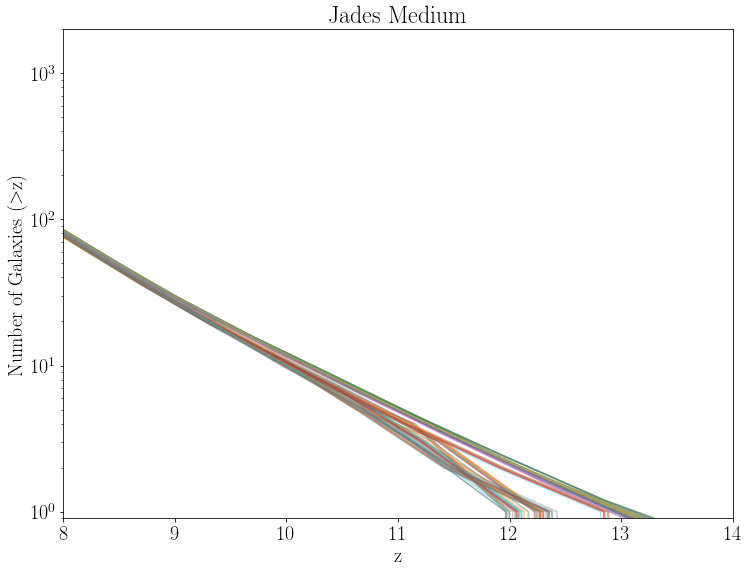

In [16]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design matching the JADES Wide survey from Williams et al. 2018 (pg. 36)

    wide = survey(29.8, 190./3600, "cv_jades_wide.csv", nearest_wavelength(x,14873.4))
    mean_wide, med_wide, z_vals_wide = mean_median(wide)
    summed+=med_wide
    summean+=mean_wide

    ax.plot(z_vals_wide, mean_wide, alpha=0.4, label = "Mean")
    ax.plot(z_vals_wide, med_wide, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e3), xlim=(8,14), title='Jades Medium')
winsound.Beep(400,300)

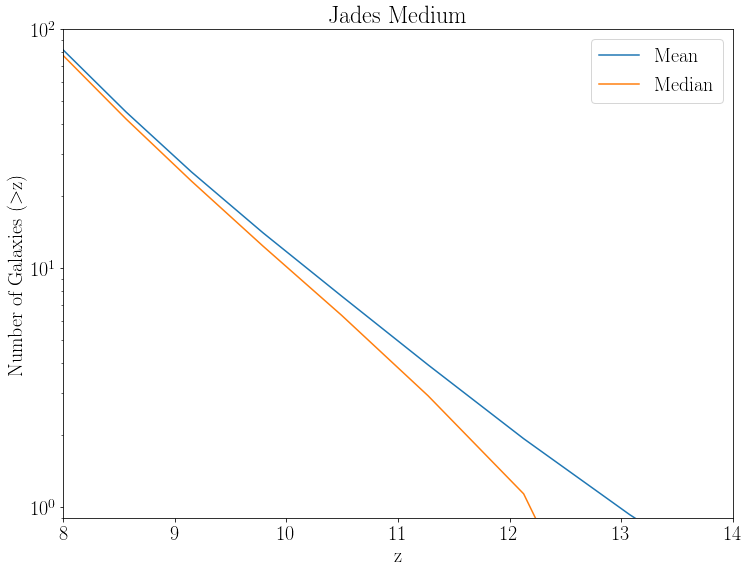

In [17]:
fig, ax =plt.subplots(figsize=(12,9))
meanwidefinal=summean/N
medwidefinal=summed/N
ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,1e2), xlim=(8,14), title='Jades Medium')
if save==1:
    plt.savefig("figs/"+file+"/jadesmedium.pdf")

In [18]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.999508274513812
0.9998323322546245


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(12.223999999997659, 13.0755, 12.98099999999724)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

-2.0407800547638466
-1.9411929091474462
-1.854254618497066
-1.7779323311217392
-1.7105545911866695
-1.6507661642312121
-1.5974828626868507
-1.549778609672145
-1.506885438992729
-1.4681934951413131
-1.433183271574649
-1.4013804362315119
-1.3724010060147187
-1.3459287595501186
-1.3216700627045723
-1.299399043067972
-1.278912415471221
-1.2600068947452225
-1.2425243702029014
-1.2263293183981931
-1.211286215885033
-1.1972821264583675
-1.1842492883951643
-1.1720973527313803
-1.1607359705029727
-1.150097379986909
-1.1401138194601572
-1.1307401144406954
-1.1219310904465027
-1.113641572995557
-1.1058263876058374
-1.0984403597953218
-1.091460902323
-1.0848654279478607
-1.0786087621878826
-1.072668317802055
-1.0670215075493674
-1.0616457441888087
-1.056541027720379
-1.0516847709030677
-1.0470543864958637
-1.0426272872577564
-1.0384034731887462
-1.0343829442888326
-1.030520526075994
-1.026816218550231
-1.0232700217115431
-1.0198593483189198
-1.016584198372361
-1.0134445718718665
-1.010417881576425

  2%|█▋                                                                                 | 1/50 [00:57<47:03, 57.63s/it]

-2.004907932734539
-1.9086234283515582
-1.8245683008010718
-1.750777114520715
-1.685633844714765
-1.6278282010083123
-1.5763119511014279
-1.5301897299045906
-1.488719039538684
-1.4513102493349994
-1.417461081316487
-1.3867129338519288
-1.3586945580017664
-1.3331002193451882
-1.3096460216342964
-1.2881135831399395
-1.268306360305881
-1.2500278095758843
-1.2331250637395434
-1.217467093759367
-1.2029228705978645
-1.1893832033904594
-1.1767825776184069
-1.1650336405900459
-1.1540490396137157
-1.143763260170671
-1.1341107877421661
-1.125047945982371
-1.1165310585454549
-1.1085164490855879
-1.1009604412569394
-1.0938193587136789
-1.0870713632828917
-1.0806946167916622
-1.0746454428941603
-1.0689020034174708
-1.0634424601886785
-1.0582449750348684
-1.05330954795604
-1.0486143407792787
-1.044137515331669
-1.0398572334402958
-1.0357734951051591
-1.031886300326259
-1.028151972757765
-1.0245705123996773
-1.0211419192519957
-1.0178443551418053
-1.0146778200691056
-1.011642314033897
-1.008715998863

  4%|███▎                                                                               | 2/50 [01:27<39:32, 49.43s/it]

-2.040152042110971
-1.9406227157805556
-1.8537349006193469
-1.7774569251894365
-1.7101183040863224
-1.6503645896847325
-1.597112223884449
-1.549435667474869
-1.5065674001350053
-1.4678979204334852
-1.432908023447288
-1.401123652507568
-1.3721610474538317
-1.345704170506849
-1.3214595580144775
-1.2992014687058382
-1.278726735437141
-1.2598321910645942
-1.2423598166985834
-1.2261741675765814
-1.2111397989360602
-1.1971438401415813
-1.1841185688118807
-1.1719736884386072
-1.1606189025134088
-1.1499864886550224
-1.1400087244821842
-1.1306404617407186
-1.1218365521764495
-1.1135518475352015
-1.1057411995627988
-1.0983594600050655
-1.0913840547349138
-1.0847924096252561
-1.0785393764219162
-1.0726023809978067
-1.0669588492258393
-1.0615862069789264
-1.056484454257068
-1.0516310169331762
-1.0470033208801628
-1.0425787919709406
-1.038357430205509
-1.0343392355838683
-1.0304790598518425
-1.026776903009432
-1.0232327650566366
-1.0198240718663683
-1.0165508234386271
-1.0134130197734135
-1.0103880

  6%|████▉                                                                              | 3/50 [02:31<42:09, 53.82s/it]

-2.0021424241771637
-1.9061125320690153
-1.8222796777428045
-1.7486836229835774
-1.6837126163701486
-1.6260598324258828
-1.5746798107694704
-1.5286795539918772
-1.4873185276563423
-1.4500086602983795
-1.416249002151945
-1.385582164300216
-1.3576378795248123
-1.3321112218811857
-1.308719045849398
-1.2872435471833437
-1.2674887020615269
-1.249258486662452
-1.2324004380138454
-1.2167838735680432
-1.2022781107773817
-1.188774247518808
-1.17620694251849
-1.1644890740779856
-1.1535335204988524
-1.1432749405072582
-1.133647992829372
-1.1246091166159715
-1.1161147510178364
-1.108121335185745
-1.1005853082704766
-1.0934631094228093
-1.086732958218133
-1.0803730742318371
-1.0743398966147
-1.0686116449421115
-1.0631665387894607
-1.0579827977321372
-1.053060421770141
-1.0483776304788615
-1.0439126434336878
-1.0396436802100095
-1.0355707408078267
-1.0316938252271395
-1.0279693726187265
-1.0243973829825876
-1.0209778563187228
-1.017689012202522
-1.0145308506339845
-1.0115033716131105
-1.008584794715

  8%|██████▋                                                                            | 4/50 [03:13<38:25, 50.11s/it]

-2.018562124868965
-1.9210205189987803
-1.8358679581019013
-1.7611133456647607
-1.6951195578873142
-1.6365591970938513
-1.5843703451438027
-1.537645946958765
-1.4956338105225029
-1.4577366068809456
-1.4234455002584039
-1.392295901468379
-1.3639117145027526
-1.3379832132371923
-1.31422279484196
-1.2924092263711047
-1.2723433981732688
-1.2538262005970964
-1.2367027705804208
-1.2208403683556708
-1.2061062541552756
-1.192389811506259
-1.1796246705248354
-1.1677223380326243
-1.1565943208512446
-1.146174249096911
-1.1363957528858377
-1.1272145856288347
-1.1185865007367113
-1.1104672516202772
-1.1028125916903422
-1.0955782743577156
-1.0887421763278025
-1.0822821743060076
-1.0761540217031405
-1.0703355952246059
-1.0648047715758089
-1.0595394274621541
-1.0545395628836416
-1.049783054545676
-1.0452477791536625
-1.0409116134130056
-1.0367745573237055
-1.032836610885762
-1.0290535275099848
-1.025425307196374
-1.0219519499449294
-1.0186113324610562
-1.0154034547447537
-1.0123283167960226
-1.0093637

 10%|████████▎                                                                          | 5/50 [04:04<37:48, 50.42s/it]

-2.005292010397869
-1.9089721451090926
-1.8248861479449967
-1.7510678615284
-1.6859006675713986
-1.6280737944892052
-1.5765386250139901
-1.5303994652294821
-1.4889135445709687
-1.4514910158252954
-1.4176294165516272
-1.3868699766952886
-1.358841310973923
-1.3332375726844141
-1.3097747613167239
-1.288234414940055
-1.268419917816689
-1.2501346542089082
-1.233225700765154
-1.2175619803269475
-1.20301241573581
-1.1894677760263428
-1.1768625226193064
-1.1651092707423814
-1.154120635623249
-1.14383107868267
-1.1341750613414046
-1.1251088912132934
-1.1165888759121767
-1.1085713230518954
-1.1010125402462894
-1.0938688351091994
-1.0871183614475455
-1.0807392730682481
-1.0746878775851474
-1.0689423288051636
-1.063480780535217
-1.0582813865822283
-1.0533441469461966
-1.0486472154340425
-1.0441687458526865
-1.0398868920090485
-1.0358016539031285
-1.0319130315349265
-1.028177332518283
-1.0245945568531982
-1.021164704539672
-1.0178659293846242
-1.0146982313880553
-1.011661610549965
-1.00873422067727

 12%|█████████▉                                                                         | 6/50 [05:02<38:34, 52.61s/it]

-1.999997815378523
-1.904165371122558
-1.8205048862186772
-1.7470601529138676
-1.6822227337223177
-1.6246884901420184
-1.573414111371363
-1.5275084361006441
-1.4862324525120578
-1.4489992982796993
-1.4153090536444657
-1.3847052701306533
-1.3568184418293598
-1.331344269756783
-1.308000190570821
-1.2865688478544723
-1.2668546208324356
-1.2486618887294092
-1.2318385020534925
-1.2162540469544845
-1.2017781095821838
-1.1883020117280905
-1.1757605464671035
-1.1640667712324222
-1.1531337434572464
-1.1428962562164753
-1.1332891025850087
-1.1242688112794461
-1.1157919110163872
-1.1078149305124319
-1.1002943984841798
-1.0931868436482304
-1.0864705303628839
-1.0801237229864398
-1.074102950235498
-1.0683864764683584
-1.0629525660433206
-1.0577794833186847
-1.0528672282944507
-1.0481940653289181
-1.0437382587803872
-1.0394780730071578
-1.0354135080092295
-1.0315445637866028
-1.0278277690558768
-1.024263123817052
-1.0208506280701284
-1.0175685461734056
-1.0144168781268839
-1.0113956239305628
-1.0084

 14%|███████████▌                                                                       | 7/50 [05:35<33:37, 46.91s/it]

-2.015001351219923
-1.917787575352842
-1.832921205810453
-1.7584178380048583
-1.6926458503860098
-1.6342823065619765
-1.582268857419213
-1.5357014964232332
-1.4938305596186092
-1.4560607256289722
-1.421884868837415
-1.390839961506762
-1.3625511716592986
-1.3367098141369085
-1.313029252721339
-1.2912889980139357
-1.2712906095559082
-1.2528356468884674
-1.2357697674325543
-1.219960677548976
-1.2052760835985392
-1.1916057408819163
-1.1788835025795108
-1.1670211729318607
-1.1559305561795037
-1.1455455055028434
-1.1357998740822832
-1.1266495640380922
-1.118050477490539
-1.1099585165598929
-1.1023295833664228
-1.0951195800303974
-1.0883064576119517
-1.0818681671712196
-1.0757606108284703
-1.0699617396438383
-1.064449504677458
-1.0592018569894641
-1.0542187965798564
-1.0494782745087696
-1.0449582418363377
-1.0406366496226958
-1.0365134978678434
-1.0325887865717807
-1.0288184178547766
-1.0252023917168311
-1.0217407081579444
-1.0184113182382508
-1.0152142219577502
-1.0121494193164429
-1.0091948

 16%|█████████████▎                                                                     | 8/50 [06:35<35:35, 50.85s/it]

-2.0320415417926565
-1.9332589254771388
-1.847022978505393
-1.7713172718757415
-1.7044838528534711
-1.6451784354374643
-1.5923255908268255
-1.5450067235874576
-1.50246007165206
-1.4640807063201295
-1.429353317957904
-1.3978074064649921
-1.3690620908077433
-1.3428037042525638
-1.3187409848325444
-1.2966498848808319
-1.2763287614972587
-1.257575971781657
-1.2402346823672294
-1.2241704646538645
-1.2092488900414502
-1.19535793469656
-1.182430384319138
-1.1703766198424428
-1.1591070221997337
-1.148554377090954
-1.1386514702160486
-1.1293534920416461
-1.1206156330343766
-1.1123930836608689
-1.1046410343877529
-1.0973146756816574
-1.0903916027758978
-1.0838494109037882
-1.0776432905319582
-1.0717508368937225
-1.0661496452223957
-1.0608173107512928
-1.0557538334804133
-1.0509368086430724
-1.0463438314725846
-1.0419524972022645
-1.037762805832112
-1.0337747573621274
-1.02994354225894
-1.0262691605225498
-1.0227516121529565
-1.0193684923834752
-1.0161198012141057
-1.013005538644848
-1.0100032999

 18%|██████████████▉                                                                    | 9/50 [07:19<33:16, 48.70s/it]

-2.0204506426456708
-1.922735166473799
-1.83743081905136
-1.7625429546864804
-1.6964315313658422
-1.6377667852948639
-1.585484905437879
-1.5386772198685907
-1.4965901957700685
-1.4586254394347506
-1.424273208074714
-1.393068084361855
-1.3646333018877086
-1.3386585824335393
-1.3148558105105201
-1.293003358819555
-1.2729017627914563
-1.2543515578570366
-1.237197604906928
-1.2213069275616724
-1.2065465494418115
-1.192805656897797
-1.1800177617398995
-1.1680942130484804
-1.1569463599039007
-1.1465077141164315
-1.1367117874963437
-1.1275142545838177
-1.1188707899190344
-1.1107370680421742
-1.1030687634934175
-1.0958215508129454
-1.0889732672708479
-1.0825017501372152
-1.0763626739522278
-1.0705338759859766
-1.0649931935085513
-1.0597184637900425
-1.05470968683045
-1.0499446998998643
-1.0454013402683757
-1.0410574452060741
-1.0369130147129602
-1.0329680487890334
-1.0291782219744745
-1.0255435342692836
-1.0220639856734606
-1.0187174134570955
-1.015503817620189
-1.0124231981627405
-1.009453392

 20%|████████████████▍                                                                 | 10/50 [08:00<30:57, 46.43s/it]

-2.000972011485014
-1.9050498758461942
-1.8213110915246211
-1.7477976199157368
-1.6828995181669053
-1.6253114272084215
-1.5739890597845214
-1.5280404205309068
-1.4867258059747448
-1.4494578045346682
-1.4157360285672902
-1.3851036023982137
-1.3571906742910227
-1.3316926604627857
-1.308326733115067
-1.2868753324029154
-1.2671426544658755
-1.2489328954434913
-1.2320937634442972
-1.216494722561323
-1.202005236887598
-1.1885165265006468
-1.175963323446984
-1.1642586037886296
-1.153315343587603
-1.143068274890419
-1.1334521297435924
-1.1244233961781331
-1.1159385622250508
-1.1079541159153556
-1.100426545280057
-1.0933123383501648
-1.0865897391411843
-1.0802369916686203
-1.0742105839634823
-1.0684887600412756
-1.063049763917505
-1.0578718396076752
-1.0529549871117865
-1.0482774504453438
-1.043817473623852
-1.0395533006628157
-1.0354849315622352
-1.0316123663221104
-1.0278920929734514
-1.0243241115162578
-1.0209084219505298
-1.0176232682917723
-1.0144686505399854
-1.0114445686951687
-1.0085292

 22%|██████████████████                                                                | 11/50 [08:59<32:29, 50.00s/it]

-2.0354859957964657
-1.9363862586869702
-1.849873469361852
-1.7739247254986212
-1.7068767518543426
-1.64738094688069
-1.5943584293390027
-1.5468876548379247
-1.5042044158334038
-1.4657018416286942
-1.430862968296937
-1.3992157852962182
-1.370378188854512
-1.344035505277209
-1.3198955375621721
-1.2977335187846801
-1.2773471587124843
-1.2585341671133352
-1.2411372071399287
-1.225021418637432
-1.2100519414510125
-1.1961163921183096
-1.183147340561907
-1.1710548800119165
-1.1597491036984495
-1.1491625815440898
-1.139227883471421
-1.1299000560954988
-1.1211341460313793
-1.112885199894118
-1.1051082642987708
-1.0977583858603936
-1.0908130878865143
-1.0842498936846607
-1.0780238498698886
-1.072112479749726
-1.0664933066317006
-1.0611438538233404
-1.0560641213246456
-1.0512316324431437
-1.046623910486363
-1.0422184787618312
-1.0380153372695482
-1.034014486009514
-1.0301709715967846
-1.0264847940313602
-1.0229559533132402
-1.0195619727499527
-1.016302852341498
-1.013178592087876
-1.010166715296

 24%|███████████████████▋                                                              | 12/50 [09:38<29:43, 46.94s/it]

-2.0007209035611457
-1.9048218866935747
-1.82110328476042
-1.747607531075793
-1.6827250708090742
-1.6251508595030049
-1.573840861591778
-1.5279032966962667
-1.4865986396240243
-1.4493396203692843
-1.4156259718900976
-1.3850009286264233
-1.3570947279820385
-1.3316028595835823
-1.308242563798649
-1.2867963332176955
-1.2670684111721326
-1.2488630409933716
-1.2320279674947328
-1.2164326862304895
-1.2019466927549163
-1.1884612333632416
-1.1759110558326025
-1.1642091571991815
-1.1532685344991616
-1.1430239355096796
-1.1334101080078727
-1.1243835505118325
-1.11590076153965
-1.1079182396094167
-1.100392483239224
-1.0932799909471633
-1.0865590119922803
-1.0802077956336207
-1.0741828403892757
-1.068462395518291
-1.0630247102797126
-1.0578480339325858
-1.0529323664769108
-1.0482559571717331
-1.043797055276099
-1.0395339100490533
-1.0354665214905965
-1.0315948896007288
-1.027875512897541
-1.0243083913810336
-1.0208935250512061
-1.0176091631671047
-1.0144553057287293
-1.0114319527360796
-1.00851735

 26%|█████████████████████▎                                                            | 13/50 [10:35<30:44, 49.84s/it]

-2.0162147396208594
-1.9188892506367845
-1.833925356987498
-1.75933637370848
-1.6934888042733482
-1.6350581920390896
-1.5829849716912936
-1.5363640978572344
-1.4944450451058717
-1.4566318079478493
-1.4224166780033456
-1.3913360954473064
-1.3630147975642106
-1.3371437444706893
-1.313435970560756
-1.2916707330605748
-1.2716493634736943
-1.2531731933036625
-1.2360877026087942
-1.2202604457247883
-1.2055589769873436
-1.1918729250095421
-1.1791360669592335
-1.167260105726883
-1.156156744202957
-1.1457597595553046
-1.1360029289517752
-1.1268421038376017
-1.1182331356580169
-1.110131875858254
-1.1024941758835454
-1.0952758871791242
-1.0884549354676072
-1.0820092464716102
-1.0758946716363667
-1.070089136684493
-1.0645705673386052
-1.05931688932132
-1.0543281026326377
-1.0495821329951742
-1.0450569061315464
-1.0407303477643706
-1.0366024578936466
-1.0326732365193745
-1.0288985350867872
-1.025278353595885
-1.0218126920466675
-1.0184794761617513
-1.0152787059411366
-1.0122103813848229
-1.00925242

 28%|██████████████████████▉                                                           | 14/50 [11:19<28:53, 48.16s/it]

-2.029884998041535
-1.9313009283943274
-1.845238310097185
-1.769684767040275
-1.7029856788666256
-1.6437994615030151
-1.5910528476908667
-1.5438290883134789
-1.5013679523960266
-1.46306572710556
-1.4284081385473444
-1.3969256322957526
-1.3682380928633717
-1.3420324839664501
-1.31801812905579
-1.295971430785854
-1.2756911515456597
-1.2569760537242234
-1.2396696191796692
-1.2236376895046754
-1.2087461062919196
-1.1948830708686335
-1.1819815040311559
-1.1699519668412721
-1.1587050203607672
-1.1481735853859805
-1.1382905827132506
-1.1290112928734704
-1.1202909963975323
-1.112084973816329
-1.1043485056607532
-1.0970368724616975
-1.090127714484608
-1.0835986719949313
-1.0774050255235599
-1.0715244153359402
-1.0659344816975183
-1.0606128648737407
-1.0555595648646074
-1.0507522219355645
-1.0461684763520587
-1.0417859683795359
-1.0376046980179963
-1.03362466526744
-1.0298011506587594
-1.0261341541919546
-1.0226236758670257
-1.019247355949419
-1.0160051944391344
-1.0128971913361717
-1.0099009869

 30%|████████████████████████▌                                                         | 15/50 [12:04<27:32, 47.21s/it]

-1.9980314568976296
-1.9023800495090506
-1.8188776074499355
-1.745571618435191
-1.680856683474853
-1.6234311277121931
-1.5722536112618286
-1.526434656304995
-1.4852366470895468
-1.4480738299299563
-1.4144472294644772
-1.383901259493255
-1.3560671121402164
-1.3306410632721253
-1.30734108333669
-1.2859502265244562
-1.2662732416069147
-1.248114877355556
-1.2313232717037619
-1.2157682571658597
-1.2013196662561765
-1.187869026069985
-1.1753512528644485
-1.1636795683157855
-1.1527671941002138
-1.1425490464748973
-1.1329600416969994
-1.123956790604629
-1.1154959040358956
-1.107533992828908
-1.1000276678217753
-1.0929335398526066
-1.0862299143404561
-1.0798950967043788
-1.0738856977824836
-1.068180022993825
-1.0627563777574573
-1.0575930674924354
-1.052690092198759
-1.048025757295483
-1.0435783682016615
-1.0393262303363493
-1.0352693436995464
-1.0314077082912527
-1.0276979349495772
-1.0241400236745202
-1.0207339744660813
-1.0174580927433152
-1.014312378506222
-1.0112968317548017
-1.00838975790

 32%|██████████████████████████▏                                                       | 16/50 [12:57<27:38, 48.79s/it]

-2.0216852940080177
-1.9238561471005577
-1.838452566595497
-1.763477586463878
-1.69728925685967
-1.6385562670969014
-1.5862135686267953
-1.5393514324806046
-1.497215449269612
-1.4592065291851304
-1.4248143364642043
-1.3935729123667437
-1.3651050521983903
-1.3391001167990835
-1.3152696555201966
-1.2933917832474011
-1.2732668033778012
-1.2546950193085011
-1.237521111459471
-1.2216119487621135
-1.2068344001478317
-1.1930775230594615
-1.1802747519627037
-1.1683373328118274
-1.1571765115611012
-1.1467257226762262
-1.136918400622904
-1.127710168378269
-1.1190566489194553
-1.1109134652235975
-1.1032362402678295
-1.0959805970292855
-1.0891243469965333
-1.0826453016581394
-1.0764990839912385
-1.0706635054843976
-1.0651163776261836
-1.0598355119051641
-1.0548209083213387
-1.0500503783632746
-1.0455017335195393
-1.0411527852786997
-1.0370035336407557
-1.0330539786057074
-1.0292597431506891
-1.0256208272757008
-1.0221372309807424
-1.0187867657543812
-1.0155694315966173
-1.0124852285074504
-1.00951

 34%|███████████████████████████▉                                                      | 17/50 [13:44<26:31, 48.24s/it]

-2.032039303110843
-1.9332568929042044
-1.8470211258628455
-1.7713155771923463
-1.7044822976172946
-1.6451770039414109
-1.592324269607671
-1.5450055010986166
-1.502458937936356
-1.4640796526825635
-1.4293523367786647
-1.397806491105962
-1.369061235425509
-1.342802903658174
-1.3187402344447627
-1.2966491805858955
-1.2763280996021305
-1.257575349014025
-1.2402340957820137
-1.2241699115864684
-1.2092483681077608
-1.1953574417462014
-1.1824299183419757
-1.1703761790153322
-1.1591066048865186
-1.148553981795721
-1.1386510955831253
-1.1293531368088559
-1.120615296033036
-1.1123927638157904
-1.1046407307172426
-1.0973143872975168
-1.0903913288366751
-1.0838491506147794
-1.0776430431919537
-1.0717506018482599
-1.0661494218637602
-1.0608170985185161
-1.0557536318125285
-1.0509366170258585
-1.0463436494385687
-1.041952324330721
-1.0377626417023151
-1.0337746015533513
-1.0299433944439533
-1.0262690203741216
-1.0227514793438557
-1.0193683666332178
-1.0161196822422078
-1.013005426170826
-1.01000319

 36%|█████████████████████████████▌                                                    | 18/50 [14:35<26:09, 49.06s/it]

-2.0264161236231844
-1.9281514230860122
-1.8423676098930946
-1.7670588271498189
-1.700575814742837
-1.6415813347424075
-1.589005596804737
-1.541934821677836
-1.4996112412015172
-1.4614330983073973
-1.4268877851224082
-1.395507268371141
-1.3669126639735016
-1.3407919497458842
-1.3168553908035112
-1.2948801141580926
-1.2746655341201667
-1.2560110650002727
-1.2387606957066073
-1.222780702446196
-1.2079373614260656
-1.1941192361520698
-1.1812594647277224
-1.1692688979577068
-1.1580583866467071
-1.1475610688982365
-1.1377100828158073
-1.128460853801762
-1.119768807258442
-1.11158936858819
-1.103877963193347
-1.0965900164762559
-1.0897032411380871
-1.0831953498800118
-1.077021768104372
-1.0711602085123384
-1.065588383805082
-1.060284006683774
-1.0552470771484144
-1.050455307900174
-1.0458864116402238
-1.041518101069735
-1.0373503761887073
-1.0333832369971407
-1.0295721088973775
-1.0259169918894173
-1.0224178859732604
-1.0190525038500775
-1.015820845519869
-1.0127229109826343
-1.0097364129395

 38%|███████████████████████████████▏                                                  | 19/50 [15:23<25:17, 48.96s/it]

-2.0312270543654436
-1.9325194255223432
-1.8463489416445718
-1.7707007044341303
-1.7039180197348858
-1.6446576220148388
-1.5918448988483898
-1.5445619521220055
-1.5020475980342196
-1.4636973670956324
-1.4289963408523105
-1.3974743763680544
-1.3687508817421306
-1.342512428350406
-1.3184679753276138
-1.296393645085088
-1.276087947793028
-1.2573493936216342
-1.24002126825884
-1.2239692451514452
-1.2090589977462503
-1.1951785872489216
-1.182260850382859
-1.1702162361125965
-1.158955193402667
-1.1484105589764704
-1.138515169557407
-1.1292242496277434
-1.1204930236697463
-1.1122767161656824
-1.1045305515978183
-1.0972097544484207
-1.090291936958623
-1.0837547113695585
-1.077553302163494
-1.0716653215815626
-1.0660683818648977
-1.0607400952546329
-1.0556804617507678
-1.0508670935944362
-1.046277603026771
-1.0418896022889057
-1.0377030913808405
-1.0337180703025752
-1.0298897635363764
-1.0262181710822444
-1.022703292940179
-1.0193227413513133
-1.0160765163156478
-1.0129646178331821
-1.009964658

 40%|████████████████████████████████▊                                                 | 20/50 [16:12<24:24, 48.83s/it]

-2.0092316030573896
-1.9125490310084838
-1.8281463955319048
-1.7540501353928142
-1.6886375446870112
-1.6305929159246042
-1.5788636831136795
-1.532550779469477
-1.4909086374143916
-1.453345188577972
-1.4193560784224257
-1.3884808093262908
-1.3603465975007645
-1.3346464445315385
-1.3110952804624696
-1.2894738207119094
-1.2695847091563737
-1.2512305896723785
-1.2342579630527704
-1.2185352585485596
-1.2039309054107572
-1.1903352613485387
-1.1776825409874094
-1.1658850304947102
-1.1548550160377813
-1.1445267122421283
-1.1348343337332563
-1.1257340235948359
-1.1171819249105372
-1.1091341807640305
-1.101546934238986
-1.094376328419074
-1.0876004348461297
-1.081197325061988
-1.0751231421503193
-1.069355957652959
-1.0638738431117418
-1.058654870068503
-1.0536990385232428
-1.048984420017796
-1.0444890860939982
-1.0401911082936839
-1.0360904866168534
-1.0321872210635068
-1.0284374547173143
-1.024841187578276
-1.0213984196463914
-1.0180872224634963
-1.0149075960295904
-1.0118595403446737
-1.008921

 42%|██████████████████████████████████▍                                               | 21/50 [17:00<23:29, 48.59s/it]

-2.035663665527827
-1.936547570886423
-1.8500205016474205
-1.7740592215854327
-1.7070001809151427
-1.6474945554862939
-1.5944632859786796
-1.546984675889624
-1.504294391533982
-1.4657854620441375
-1.4309408381624917
-1.3992884314364549
-1.3704460750234537
-1.3440990432884288
-1.3199550909988238
-1.2977894141295965
-1.2773996890582076
-1.258583592162119
-1.2411837606238003
-1.2250653120282262
-1.2100933639603706
-1.1961555144077123
-1.1831843221627385
-1.1710898656154316
-1.159782223155775
-1.1491939535762556
-1.1392576156693606
-1.1299282486300812
-1.121160891653409
-1.1129105839343354
-1.105132364667852
-1.09778127304895
-1.090834828675125
-1.084270551143873
-1.0780434796501854
-1.0721311337915578
-1.066511033165486
-1.0611606973694656
-1.0560801264034965
-1.0512468398650747
-1.0466383573516957
-1.0422321984608554
-1.0380283631925535
-1.0340268515467903
-1.0301827027185573
-1.026495916707854
-1.022966493514681
-1.0195719527365334
-1.0163122943734118
-1.0131875184253158
-1.010175144489

 44%|████████████████████████████████████                                              | 22/50 [17:51<23:01, 49.32s/it]

-2.0299930581132344
-1.93139903969165
-1.8453277362430953
-1.7697665685754762
-1.7030607493530705
-1.6438685591144826
-1.591116622290596
-1.543888097249456
-1.5014226762962717
-1.4631165856734154
-1.4284554995873515
-1.3969698162265916
-1.36827938174374
-1.342071128264471
-1.3180543499054822
-1.2960054267565408
-1.2757231008984378
-1.2570061144119633
-1.2396979333599547
-1.2236643857962721
-1.2087712997747762
-1.1949068653403507
-1.1820039965199256
-1.169973245349408
-1.1587251638647047
-1.148192666092746
-1.1383086660604618
-1.1290284397858061
-1.120307263286732
-1.1121004125811929
-1.1043631636871425
-1.0970507926225341
-1.0901409373963447
-1.0836112360175507
-1.0774169645041058
-1.0715357608649865
-1.0659452631091697
-1.0606231092456322
-1.055569299274374
-1.0507614712043716
-1.0461772630446018
-1.0417943128040414
-1.0376126204826905
-1.0336321860805489
-1.0298082856155704
-1.0261409190877546
-1.0226300864971016
-1.0192534258525883
-1.0160109371542145
-1.0129026204019804
-1.00990611

 46%|█████████████████████████████████████▋                                            | 23/50 [18:37<21:41, 48.21s/it]

-1.9999207393758494
-1.904095391281754
-1.820441101235446
-1.7470018063363881
-1.6821691881996936
-1.6246392048916714
-1.5733686228653685
-1.5274663467994285
-1.4861934195980933
-1.4489630223912018
-1.4152752724375055
-1.3846737550602122
-1.3567889917114428
-1.3313167059400028
-1.3079743553269254
-1.286544599549929
-1.2668318323189593
-1.2486404473439634
-1.2318183063993433
-1.2162350052917303
-1.2017601398277549
-1.1882850398462763
-1.17574450325061
-1.1640515939118432
-1.153119375701063
-1.1428826465215849
-1.1332762042767244
-1.124256580902025
-1.1157803083330304
-1.1078039185052844
-1.10028394335433
-1.0931769148157116
-1.0864610988572005
-1.0801147614465687
-1.0740944345193597
-1.0683783840433454
-1.0629448759862976
-1.0577721763159882
-1.052860285032417
-1.0481874681033558
-1.0437319914965766
-1.039472121179851
-1.0354078571531793
-1.0315391994165612
-1.0278226799055405
-1.0242582986201172
-1.0208460555602912
-1.0175642166938343
-1.0144127820207467
-1.011391751541028
-1.008479391

 48%|███████████████████████████████████████▎                                          | 24/50 [19:27<21:09, 48.81s/it]

-2.029808189148552
-1.9312311910712072
-1.8451747461631327
-1.769626622664982
-1.7029323189079575
-1.6437503470524955
-1.5910075168269442
-1.5437871448742673
-1.501329054752045
-1.4630295769324735
-1.4283744744103857
-1.3968942264419344
-1.3682087448059095
-1.3420050156730794
-1.3179923833448717
-1.295947266514692
-1.2756684420066058
-1.2569546866446786
-1.239649493514294
-1.2236187138314962
-1.2087281988123282
-1.1948661578034931
-1.1819655164130127
-1.1699368421182494
-1.1586907023965654
-1.1481600228559827
-1.138277729104523
-1.1289991048808672
-1.1202794339236966
-1.1120739999716927
-1.1043380867635364
-1.097026978037909
-1.0901183156641507
-1.0835897415116025
-1.0773965393189457
-1.0715163509555203
-1.0659268182906676
-1.0606055831937278
-1.0555526456647006
-1.0507456475729273
-1.0461622307877478
-1.0417800371785033
-1.0375990667451933
-1.033619319487818
-1.0297960791450589
-1.0261293457169154
-1.0226191192033878
-1.0192430414738165
-1.016001112528202
-1.0128933323665437
-1.009897

 50%|█████████████████████████████████████████                                         | 25/50 [20:18<20:37, 49.50s/it]

-2.0409642849360154
-1.9413601777871317
-1.854407079938174
-1.7780717934659407
-1.7106825778557977
-1.6508839678256104
-1.5975915911496712
-1.5498792132185206
-1.5069787370389491
-1.4682802032339963
-1.4332640167788433
-1.401455764824743
-1.3724713988750905
-1.3459946436973877
-1.321731815147172
-1.2994570023440875
-1.278966885495814
-1.2600581448100314
-1.2425726426704906
-1.2263748325489778
-1.2113291679172797
-1.1973226933352186
-1.1842876355386873
-1.1721336301755438
-1.160770312893646
-1.1501299104288865
-1.140144649517159
-1.1307693479823921
-1.121958823648515
-1.1136678943394562
-1.1058513778791446
-1.098464092091509
-1.091483445888514
-1.0848868481821239
-1.0786291167962676
-1.0726876606429092
-1.0670398886340136
-1.061663209681545
-1.0565576237855032
-1.051700539857853
-1.0470693668105586
-1.0426415135555844
-1.0384169800929306
-1.034395766422597
-1.0305326903685121
-1.0268277519306765
-1.0232809511090901
-1.0198696968157173
-1.0165939890505578
-1.0134538278136116
-1.010426622

 52%|██████████████████████████████████████████▋                                       | 26/50 [20:59<18:44, 46.83s/it]

-2.003136730792032
-1.9070152957854107
-1.8231025256923097
-1.7494363136516264
-1.6844033717997893
-1.626695628896064
-1.5752666279478627
-1.5292225202740175
-1.487822065504779
-1.4504766315818163
-1.416684791196182
-1.3859887194136185
-1.3580177960492512
-1.3324668044802426
-1.3090523292710996
-1.2875563585483671
-1.2677826816259345
-1.2495350878176918
-1.2326609688122203
-1.2170295174854462
-1.202509926713296
-1.1889931905590423
-1.176413905460648
-1.164684866668731
-1.153718869433909
-1.1434505101941452
-1.133814385387403
-1.124766892638991
-1.1162644295742186
-1.1082633938183941
-1.1007201829968267
-1.0935911947348251
-1.086854627845044
-1.0804886811401373
-1.0744497522454142
-1.0687160399735292
-1.0632657431371364
-1.0580770605488907
-1.0531499922087917
-1.0484627369294939
-1.043993493523652
-1.03972046080392
-1.0356436387702985
-1.031763027422787
-1.0280350243866943
-1.0244596296620208
-1.0210368432487662
-1.017744863959585
-1.0145836917944773
-1.011553326753443
-1.00863196764913

 54%|████████████████████████████████████████████▎                                     | 27/50 [21:55<19:00, 49.59s/it]

-2.0009012692054937
-1.9049856466012
-1.8212525480745667
-1.7477440679702554
-1.6828503727494324
-1.6252661919752058
-1.5739473092980616
-1.5280017899194567
-1.4866899805918194
-1.4494245096185476
-1.4157050233321662
-1.385074677079763
-1.3571636442375519
-1.3316673617035915
-1.3083030208832214
-1.2868530767036264
-1.267121738599273
-1.248913216004627
-1.2320752273687179
-1.2164772456478565
-1.2019887437983532
-1.1885009492838008
-1.1759485985823541
-1.1642446736648877
-1.1533021565022747
-1.1430557835726711
-1.133440291354232
-1.1244121708323946
-1.1159279129925954
-1.1079440088202717
-1.10041694930086
-1.0933032254197976
-1.0865810826698028
-1.0802287665435943
-1.0742027680266086
-1.0684813326115647
-1.0630427057911807
-1.057865133058175
-1.0529486144125477
-1.0482713953470175
-1.0438117213543026
-1.0395478379271212
-1.035479745065474
-1.0316074427693607
-1.0278874220242178
-1.0243196828300458
-1.0209042251868448
-1.0176192945873328
-1.01446489103151
-1.0114410145193764
-1.0085259105

 56%|█████████████████████████████████████████████▉                                    | 28/50 [22:35<17:13, 46.99s/it]

-2.0050755260999433
-1.9087755918865614
-1.8247069942936136
-1.7509039827928157
-1.6857502736164676
-1.62793536641238
-1.5764108608988012
-1.5302812485017356
-1.4888039123549421
-1.4513891272999357
-1.417534534868377
-1.3867814599369999
-1.3587585940726838
-1.3331601538599185
-1.3097021975557286
-1.28816630843475
-1.268355911444154
-1.2500744315311123
-1.2331689769878698
-1.2175084977792068
-1.2029619438699046
-1.1894201068972812
-1.1768174618437268
-1.1650666420190956
-1.1540802807332413
-1.1437928529685548
-1.1341388337074265
-1.1250745396047832
-1.1165562873155523
-1.1085403934946607
-1.1009831747970353
-1.0938409478776034
-1.0870918710638282
-1.0807141026831732
-1.0746639593905656
-1.0689195995134688
-1.0634591813793466
-1.058260863315662
-1.0533246453224154
-1.0486286857270701
-1.04415114285709
-1.039870175039938
-1.0357857822756145
-1.0318979645641193
-1.0281630385603795
-1.0245810042643952
-1.0211518616761666
-1.0178537691231566
-1.0146867266053656
-1.0116507341227936
-1.0087239

 58%|███████████████████████████████████████████████▌                                  | 29/50 [23:25<16:42, 47.76s/it]

-2.029652723577912
-1.9310900387604168
-1.8450460891431482
-1.769508935140355
-1.7028243153148646
-1.6436509366095098
-1.5909157645785572
-1.5437022489662755
-1.5012503237069372
-1.4629564069248169
-1.4283063362813337
-1.3968306592064794
-1.3681493426673896
-1.3419494182840594
-1.3179402725607685
-1.295898356654656
-1.275622476607147
-1.2569114384596658
-1.2396087580222104
-1.2235803059890638
-1.208691953054509
-1.1948319247971158
-1.1819331565640256
-1.1699062288180941
-1.1586617220221767
-1.148132571523415
-1.1382517126689509
-1.1289744356902118
-1.1202560308186256
-1.1120517882856202
-1.1043169983226235
-1.0970069511610627
-1.0900992919166523
-1.0835716657051058
-1.0773793627578512
-1.071500028190602
-1.0659113071190724
-1.0605908446589762
-1.0555386408103136
-1.0507323406887983
-1.046149589410144
-1.0417680320900649
-1.0375876687285608
-1.0336084993256318
-1.0297858141127056
-1.026119613089782
-1.0226098962568617
-1.0192343087296578
-1.0159928505081706
-1.0128855215924002
-1.009889

 60%|█████████████████████████████████████████████████▏                                | 30/50 [24:21<16:45, 50.28s/it]

-2.029406728014688
-1.9308666912883674
-1.8448425131618973
-1.7693227163603011
-1.7026534195685992
-1.6434936379368073
-1.5907705835849386
-1.5435679168655034
-1.5011257463635115
-1.46284062889647
-1.4281985202718845
-1.3967300757922614
-1.3680553497501045
-1.341861445680418
-1.3178578168657054
-1.2958209658309694
-1.2755497448487119
-1.2568430061914357
-1.239544301626643
-1.2235195326693347
-1.2086346008345128
-1.1947777573846787
-1.1818819530773332
-1.169857788922477
-1.1586158659301116
-1.1480891348577376
-1.1382105464628558
-1.1289354012504669
-1.1202189997255712
-1.1120166423931694
-1.104283629758262
-1.0969752623258495
-1.0900691903484323
-1.0835430640785102
-1.0773521840210845
-1.0714742004286548
-1.0658867635537217
-1.0605675236487853
-1.0555164807138457
-1.0507112850014033
-1.0461295867639582
-1.0417490362540107
-1.0375696334715607
-1.0335913784166082
-1.029769571594154
-1.026104213004198
-1.0225953026467398
-1.0192204907742803
-1.015979777386819
-1.0128731624843563
-1.0098782

 62%|██████████████████████████████████████████████████▊                               | 31/50 [24:58<14:39, 46.27s/it]

-2.03051896593354
-1.9318765287189192
-1.8457629562900066
-1.7701646810919565
-1.7034261031352282
-1.644204844049925
-1.5914270011401292
-1.5441752825197437
-1.5016890071124938
-1.4633641046519257
-1.4286859967629115
-1.3971848510159879
-1.368480326873017
-1.3422592027143563
-1.3182306298931943
-1.2961708786812152
-1.275878592322934
-1.2571524140628667
-1.2398357330911913
-1.2237943115709184
-1.2088939116650583
-1.1950226685094527
-1.182113463185607
-1.1700768038021943
-1.1588231984678885
-1.1482855282641946
-1.1383966742726177
-1.1291118905474946
-1.120386431143162
-1.1121755501139567
-1.1044345015142156
-1.0971185393982754
-1.0902052907933042
-1.0836723827264705
-1.0774750692521113
-1.0715909773973948
-1.0659977341894893
-1.0606729666555632
-1.0556166747956168
-1.050806485636818
-1.0462200262063355
-1.0418349235313378
-1.0376511776118245
-1.0336687884477957
-1.0298430100935883
-1.0261738425492024
-1.0226612858146378
-1.0192829669170629
-1.0160388858564777
-1.0129290426328823
-1.00993

 64%|████████████████████████████████████████████████████▍                             | 32/50 [25:59<15:11, 50.64s/it]

-2.0359442742903284
-1.936802344821848
-1.8502527221128027
-1.7742716425768545
-1.7071951228207927
-1.6476739871203918
-1.5946288948962717
-1.5471379094035451
-1.5044364977318183
-1.4659175308051893
-1.431063824596039
-1.3994031676008878
-1.3705532933645395
-1.3441993942180075
-1.3200491487543768
-1.297877694352943
-1.2774826546550724
-1.258661653302131
-1.2412572864596263
-1.2251346365551354
-1.2101587860162357
-1.1962173035325756
-1.1832427303179434
-1.1711451213240576
-1.1598345315026366
-1.149243502067469
-1.1393045742323433
-1.1299727754731193
-1.1212031332656556
-1.1129506750858114
-1.1051704284094463
-1.097817420712419
-1.0908691657326592
-1.0843031772080969
-1.0780744826145905
-1.0721605956900702
-1.0665390301724653
-1.0611872997997054
-1.0561054045717906
-1.0512708582266503
-1.0466611745022143
-1.0422538671364119
-1.0380489361292435
-1.0340463814807088
-1.030201230666667
-1.0265134836871181
-1.0229831405420624
-1.019587714969429
-1.016327206969218
-1.0132016165414297
-1.010188

 66%|██████████████████████████████████████████████████████                            | 33/50 [26:37<13:14, 46.73s/it]

-2.0248277375644292
-1.9267092750805275
-1.8410531258175342
-1.7658564180078031
-1.6994723459757144
-1.6405656618761708
-1.5880681674330945
-1.5410674432856686
-1.4988068489883384
-1.4606855230108098
-1.4261916203457956
-1.3948578042475117
-1.3663057544931805
-1.3402239132522795
-1.3163229768250373
-1.294380403903938
-1.2741959073122169
-1.255569199873109
-1.2383445026713535
-1.2223882909224406
-1.2075670398418603
-1.1937694787758546
-1.1809288453321687
-1.168956122987796
-1.1577622952197302
-1.147280599635716
-1.137444273843499
-1.128208809581576
-1.1195296985884435
-1.1113624326025981
-1.103662503362537
-1.0963854026067565
-1.0895088762045053
-1.0830106700250317
-1.0768462758068322
-1.0709934394191558
-1.0654299067312503
-1.060133423612364
-1.0551039900624977
-1.0503193519508989
-1.0457572551468164
-1.0413954455194983
-1.0372339230689451
-1.0332726877951564
-1.0294672314366289
-1.025817553993363
-1.0223236554653583
-1.0189632817218632
-1.0157364327628782
-1.0126431085884027
-1.009661

 68%|███████████████████████████████████████████████████████▊                          | 34/50 [27:28<12:50, 48.18s/it]

-2.0288730409140885
-1.9303821391963618
-1.8444008552971716
-1.768918714924253
-1.702282661437299
-1.6431523786414672
-1.5904556135808825
-1.5432764835224024
-1.5008554759556154
-1.4625894485928428
-1.4279646135593937
-1.3965118601870734
-1.3678514322206767
-1.3416705892147398
-1.3176789293270468
-1.2956530665251238
-1.2753919533797444
-1.2566945424616818
-1.2394044635482049
-1.2233876850198286
-1.2085101752570693
-1.1946602412436897
-1.1817708671699478
-1.169752698622854
-1.1585163811894186
-1.1479948990598996
-1.1381212364245548
-1.1288507160768895
-1.1201386608104087
-1.1119403934186178
-1.104211236695022
-1.0969065134331268
-1.0900038850296845
-1.0834810128814476
-1.0772932197819216
-1.0714181671278589
-1.0658335163160122
-1.0605169287431344
-1.055468404409225
-1.050665604711037
-1.0460861910453227
-1.041707824808835
-1.0375305060015738
-1.033554234623539
-1.0297343334682358
-1.0260708025356644
-1.0225636418258248
-1.0191905127354695
-1.0159514152645983
-1.0128463494132116
-1.00985

 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [28:22<12:28, 49.88s/it]

-2.040632073345777
-1.9410585519452144
-1.8541321550591259
-1.777820309104828
-1.710451786914336
-1.6506715394325289
-1.597395527415308
-1.5496978006750068
-1.5068104980803896
-1.468123847556651
-1.4331184136326611
-1.401319929139127
-1.3723444635104307
-1.3458758386337109
-1.3216204605470234
-1.2993524877411822
-1.2788686628579184
-1.2599657285389638
-1.2424855957278875
-1.2262927595191773
-1.211251715007321
-1.197249541437725
-1.1842184863576333
-1.172068213163371
-1.1607083852512632
-1.1500712501685542
-1.1400890554624872
-1.1307166328312255
-1.1219088139729312
-1.113620430585767
-1.1058063143678958
-1.0984212970174798
-1.0914427943836007
-1.0848482223153393
-1.0785924125108586
-1.0726527808192396
-1.0670067430895638
-1.0616317151709125
-1.0565276970632855
-1.0516721046157644
-1.0470423536774303
-1.0426158600973643
-1.0383926238755667
-1.0343726450120376
-1.0305107552049395
-1.0268069544542722
-1.0232612427600356
-1.0198510359713115
-1.0165763340880996
-1.0134371371103998
-1.0104108

 72%|███████████████████████████████████████████████████████████                       | 36/50 [28:53<10:21, 44.37s/it]

-2.0434097439418455
-1.943580490543161
-1.856430842928841
-1.7799230073121128
-1.7123814643571853
-1.6524476848728766
-1.599034845506241
-1.5512146179766375
-1.50821716907573
-1.4694311606674861
-1.43433582322862
-1.4024556715422178
-1.3734057890041111
-1.3468691854696913
-1.322551512947535
-1.300226349905779
-1.2796899169657454
-1.2607384347487578
-1.243213408182511
-1.226978984347887
-1.211899310325768
-1.1978611753502215
-1.1847966529616887
-1.1726151745474243
-1.1612261714946825
-1.1505617173439044
-1.140553885635531
-1.1311573920631894
-1.122326952320507
-1.114017282101111
-1.1061830970986286
-1.098779113006687
-1.0917826876721004
-1.0851711789416816
-1.0788993025090585
-1.0729444162210444
-1.0672838779244531
-1.0618950454660983
-1.0567779188459796
-1.051909855910911
-1.0472682145077061
-1.0428303524831786
-1.0385962698373283
-1.0345659665701554
-1.0306941583752869
-1.026980845252723
-1.0234260272024636
-1.0200070620713224
-1.0167239498592995
-1.0135766905663948
-1.010542642039422

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [29:58<10:54, 50.31s/it]

-2.0250035190223894
-1.9268688728543815
-1.8411985954443884
-1.7659894846705853
-1.6995944632328064
-1.6406780630498363
-1.5881719096567017
-1.5411634331979056
-1.4988958684274256
-1.4607682547087146
-1.4262686626106398
-1.3949296783047758
-1.366372919168111
-1.3402867759816959
-1.316381897327933
-1.2944357051932869
-1.2742478793655747
-1.2556180996326143
-1.2383905613849304
-1.2224317178144017
-1.2076080221129064
-1.1938081852736766
-1.1809654338926512
-1.1689907367644161
-1.1577950626835571
-1.1473116382460131
-1.1374736900477234
-1.1282367024859807
-1.1195561599580781
-1.1113875468613081
-1.1036863475929637
-1.0964080465503376
-1.0895303859320762
-1.083031107936826
-1.0768656969618797
-1.0710118952058838
-1.0654474448674847
-1.0601500881453287
-1.0551198250394158
-1.0503343977483925
-1.0457715484709054
-1.0414090194056003
-1.0372468105524777
-1.0332849219115376
-1.0294788378800726
-1.0258285584580826
-1.022334083645568
-1.018973155641175
-1.0157457744449034
-1.0126519400567535
-1.00

 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [30:36<09:20, 46.72s/it]

-2.0071861159400193
-1.9106918659003536
-1.826453633103195
-1.7525017004917118
-1.6872165229302867
-1.6292849557143658
-1.5776564830803057
-1.531433789479994
-1.4898727595808503
-1.452382478265825
-1.418459573398172
-1.3876444443312976
-1.3595650333989115
-1.3339149401699506
-1.3104096499584286
-1.2888303053135863
-1.2689799345297403
-1.2506615659012077
-1.233721999212457
-1.2180299199930331
-1.2034540137724803
-1.1898848518254193
-1.177256776916622
-1.165482246065785
-1.1544737162926046
-1.1441655303618534
-1.1344920310383033
-1.1254094468318028
-1.1168740062521998
-1.1088419378093426
-1.1012694700130794
-1.0941128313732584
-1.087350136144804
-1.0809594985826396
-1.0748971471966138
-1.0691411962416508
-1.0636697599726745
-1.0584609526446092
-1.0535147742574547
-1.048809339066135
-1.0443227613255743
-1.040033155290697
-1.0359405209615027
-1.0320448583379918
-1.028302395930012
-1.0247131337375635
-1.0212770717606463
-1.0179723242541847
-1.0147988912181785
-1.0117567726526275
-1.00882408

 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [31:22<08:30, 46.41s/it]

-2.0330224972870914
-1.9341495672716644
-1.8478347776074824
-1.772059855738095
-1.7051653331170882
-1.6458056947068287
-1.592904528477209
-1.5455423991525137
-1.5029568482114168
-1.4645423938869835
-1.4297832554147876
-1.3982085025316573
-1.3694369059769298
-1.3431545122418242
-1.3190697930681867
-1.2969584959497447
-1.276618793630853
-1.2578488588558674
-1.2404917148703967
-1.2244128101706775
-1.209477593252947
-1.1955739378640686
-1.1826345682521606
-1.1705697834147146
-1.1592898823492215
-1.1487275893037991
-1.1388156285265667
-1.129509149516269
-1.1207633017716518
-1.112533234791461
-1.1047740980744418
-1.0974410411193398
-1.0905116386755278
-1.0839634654923787
-1.077751671068638
-1.0718538301536782
-1.0662475174968724
-1.0609103078475932
-1.0558422012058408
-1.051020772320988
-1.046423595942407
-1.0420282468194713
-1.0378347249521807
-1.0338430303405348
-1.0300083124832797
-1.0263305713804152
-1.0228098070319411
-1.0194235941872303
-1.016171932846283
-1.013054823009099
-1.01004983

 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [32:24<08:30, 51.07s/it]

-2.042499437974593
-1.9427539937807285
-1.8556775105187224
-1.779233905181669
-1.7117490650750011
-1.6518656015274487
-1.5984976036019947
-1.550717522373271
-1.507756170927558
-1.4690027243627837
-1.4339368503549612
-1.4020834628691454
-1.3730579684484767
-1.3465436430696585
-1.3222463858539157
-1.2999399653560362
-1.2794207732753295
-1.2604852013111054
-1.2429748874517152
-1.2267540928300322
-1.211687078578929
-1.1976607289758
-1.1846071745870814
-1.1724359228346888
-1.1610564811405373
-1.1504009800710635
-1.1404015501927036
-1.1310129452164157
-1.122189918853157
-1.1138872248138856
-1.1060596168095587
-1.0986618485511341
-1.0916712968940907
-1.0850653386939073
-1.0787987276615416
-1.0728488406524723
-1.0671930545221784
-1.0618087461261385
-1.056695915464353
-1.0518319393923
-1.047194194765459
-1.0427600584393084
-1.0385295304138487
-1.0345026106890793
-1.0306340529759581
-1.0269238572744854
-1.0233720235846606
-1.019955928761963
-1.0166755728063928
-1.0135309557179493
-1.010499454352

 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [32:51<06:35, 43.93s/it]

-2.037028244422525
-1.937786516998087
-1.851149771963689
-1.775092208578074
-1.7079481684539872
-1.6483671177639243
-1.5952686294458818
-1.5477298387177316
-1.504985443077222
-1.4664277023019754
-1.4315389117581152
-1.3998463846060152
-1.3709674695945493
-1.344587042163966
-1.3204124866516398
-1.2982187140863197
-1.2778031443938804
-1.2589631975001958
-1.241541311125391
-1.225402431886715
-1.2104115064014178
-1.1964559901838736
-1.1834683565427078
-1.1713585698894196
-1.1600365946355087
-1.1494349040896004
-1.139485971560319
-1.1301447792534145
-1.1213663093746369
-1.1131055441297357
-1.105317465724461
-1.0979570563645629
-1.091001807152916
-1.0844292091923953
-1.0781942446887507
-1.072274404744857
-1.0666471804635893
-1.0612900629478224
-1.0562030521975563
-1.051363639315666
-1.0467493154050265
-1.0423375715685126
-1.0381284078061244
-1.0341218241178616
-1.0302728027094745
-1.0265813435809628
-1.0230474467323267
-1.019648603266441
-1.0163848131833058
-1.0132560764829208
-1.01023988426

 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [33:56<06:42, 50.32s/it]

-2.0149212336443116
-1.9177148339678147
-1.8328549037444448
-1.7583571889549499
-1.692590191850166
-1.634231076417259
-1.5822215738459602
-1.5356577461941656
-1.4937899863879356
-1.4560230182214944
-1.4218497545565882
-1.3908072027887255
-1.3625205593809353
-1.3366811625968904
-1.3130023979671426
-1.2912637928228863
-1.2712669217621961
-1.252813359383147
-1.2357487748175744
-1.2199408844641955
-1.2052574047217262
-1.1915880992557637
-1.1788668262656663
-1.167005396683912
-1.155915621442978
-1.1455313587422227
-1.1357864667810043
-1.1266368510255618
-1.1180384169421338
-1.1099470699969591
-1.102318715656277
-1.0951092593863259
-1.0882966539202252
-1.0818588519910946
-1.0757517590651726
-1.0699533278755788
-1.0644415111554328
-1.0591942616378536
-1.0542115793228415
-1.049471416943516
-1.044951727232996
-1.0406304629244014
-1.0365076240177322
-1.0325832105129882
-1.028813127876408
-1.0251973761079924
-1.0217359552077405
-1.0184068179087724
-1.0152099642110874
-1.0121453941146863
-1.009191

 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [34:44<05:47, 49.70s/it]

-2.0120990352988235
-1.91515246715995
-1.830519366509797
-1.756220783216249
-1.6906295805040106
-1.6324264582850043
-1.5805559764887689
-1.5341166133884512
-1.4923607656008073
-1.4546947480862031
-1.4206128291442086
-1.3896532537439967
-1.3614422201939458
-1.3356718918068378
-1.3120564202302556
-1.290375922116187
-1.2704325024514198
-1.2520282662227427
-1.2350092950865468
-1.219243659034024
-1.204599428056367
-1.1909666604795692
-1.1782793912992269
-1.1664496671761344
-1.1553895347710872
-1.145033029079681
-1.1353141850975124
-1.1261890261549783
-1.1176135755824765
-1.1095438567104043
-1.101935892869159
-1.0947457073891382
-1.0879513119355406
-1.081530718173565
-1.0754399494336084
-1.06965701738087
-1.0641599336805483
-1.058926709997842
-1.0539573463327512
-1.0492298543504746
-1.0447222457162106
-1.0404125320951585
-1.036300713487318
-1.0323867898926888
-1.0286267846416688
-1.0250206977342577
-1.0215685291704557
-1.0182482906154615
-1.015059982069275
-1.012003603531896
-1.0090571666685

 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [35:25<04:42, 47.12s/it]

-2.0223258112588915
-1.9244376938037253
-1.8389826327728942
-1.7639624583839155
-1.6977342310378596
-1.6389658375464047
-1.5865915873588934
-1.5397012031299728
-1.4975398207195938
-1.459507989193012
-1.4250950651613705
-1.3938348090087567
-1.3653497886651464
-1.339329177719931
-1.3154843516489743
-1.2935932915875559
-1.2734561805574274
-1.254873201580341
-1.2376889414509922
-1.221770188850549
-1.206983732460179
-1.1932185628475227
-1.180408074353163
-1.1684634594312127
-1.1572959105357832
-1.1468388220074586
-1.1370255881868228
-1.1278118053009316
-1.1191530695768412
-1.1110049772416073
-1.103323124522286
-1.0960631076459333
-1.0892027247260772
-1.0827197738762453
-1.0765698513234938
-1.0707307551813507
-1.065180283563344
-1.0598962345830016
-1.0548786082403236
-1.0501052026488378
-1.0455538159220723
-1.041202246173555
-1.037050493403286
-1.0330985576112652
-1.0293020350245488
-1.0256609256431364
-1.022175229467028
-1.018822744609752
-1.0156034710713082
-1.0125174088516964
-1.009542356

 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [36:31<04:23, 52.77s/it]

-2.0025931445560947
-1.9065217559424712
-1.8226526757034516
-1.7490248185645463
-1.6840257366333964
-1.626348039727009
-1.5749458156989895
-1.5289256812576255
-1.487546781965888
-1.4502207922414296
-1.4164465458474362
-1.3857664562198604
-1.357810096140187
-1.3322724078990515
-1.3088701236234717
-1.2873853449496153
-1.2676219633500332
-1.2493838702972768
-1.2325185369366634
-1.2168952242498936
-1.2023831932186682
-1.1888734946610708
-1.176300759067952
-1.1645778270937788
-1.1536175393930184
-1.143354526456521
-1.133723418775137
-1.1246806366761002
-1.1161826004866438
-1.1081857305340015
-1.100646447145407
-1.0935211706480934
-1.086788111205678
-1.0804254789817773
-1.0743896943036249
-1.0686589673348377
-1.0632115082390323
-1.0580255271798256
-1.0531010241572176
-1.048416209334825
-1.0439492928762646
-1.039678484945153
-1.0356037855414906
-1.0317251946652772
-1.0279991326437463
-1.024425599476898
-1.0210045951647322
-1.0177143298708657
-1.0145548035952987
-1.0115260163380309
-1.00860617

 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [36:59<03:00, 45.15s/it]

-2.025192805158611
-1.9270407319703147
-1.8413552409969076
-1.766132774382425
-1.6997259623341856
-1.6407990996148798
-1.58828362203466
-1.5412667976813639
-1.4989917269205169
-1.4608573423953293
-1.426351623764833
-1.395007074195969
-1.3664452438715
-1.3403544682360535
-1.3164453444882127
-1.294495255088426
-1.2743038442510968
-1.2556707561906286
-1.2384401586293354
-1.2224784810434866
-1.2076521529093505
-1.1938498654571519
-1.1810048334250252
-1.1690280097971497
-1.1578303475577045
-1.1473450614448248
-1.1375053661966443
-1.1282667383052534
-1.1195846542627415
-1.111414590561198
-1.103712023692713
-1.096432430149376
-1.0895535481772318
-1.0830531160223253
-1.0768866101767465
-1.0710317688865396
-1.0654663303977499
-1.060168032956422
-1.055136876562556
-1.0503505994621969
-1.0457869399013893
-1.0414236361261782
-1.0372606881365634
-1.033298095932545
-1.0294913360062128
-1.0258404083575667
-1.0223453129866067
-1.0189837881393777
-1.0157558338158796
-1.0126614500161126
-1.0096783749861

 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [37:57<02:27, 49.07s/it]

-2.005704611255666
-1.909346759014102
-1.825227599731322
-1.751380200610378
-1.6861873057960017
-1.6283376267568959
-1.5767821326680214
-1.5306247763663245
-1.489122494350736
-1.4516852067821722
-1.4178102530569685
-1.3870386821891705
-1.3589989624282437
-1.3333851264502188
-1.3099130617399808
-1.2883642202089802
-1.2685419085775225
-1.2502494335659122
-1.2333338115121655
-1.2176639135631517
-1.2031086108657416
-1.1895586293756601
-1.1769484046663425
-1.1651905175023685
-1.1541975486483185
-1.1439039336776275
-1.1342441081637307
-1.1251743624889181
-1.1166509870354797
-1.1086302721857058
-1.101068508321886
-1.0939219858263107
-1.087168849890125
-1.0807872457044738
-1.074733463651647
-1.0689856489227898
-1.0635219467090473
-1.0583205022015645
-1.0533813154003413
-1.0486825314965227
-1.0442022956812538
-1.0399187531456795
-1.0358319038898003
-1.0319417479136155
-1.0282045755994156
-1.0246203869472006
-1.02118918195697
-1.0178891058198696
-1.014720158535899
-1.011682340105058
-1.008753795

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [38:46<01:37, 48.98s/it]

-2.037641105670309
-1.9383429539053862
-1.8516569511512042
-1.77555614488818
-1.7083739297113225
-1.6487590039409095
-1.5956303262331633
-1.54806450710694
-1.505295808943731
-1.466716145987661
-1.4318075192615032
-1.4000969731773543
-1.3712016389259605
-1.3448062127820526
-1.3206179127150244
-1.2984115217782555
-1.2779843447197876
-1.2591336862876623
-1.2417018946192453
-1.2255538395465644
-1.2105543909016476
-1.1965909402111845
-1.1835959223911887
-1.1714792506630127
-1.160150838248008
-1.1495431200621882
-1.1395885310215677
-1.1302420277368221
-1.1214585668186277
-1.11319310487766
-1.105400598524595
-1.0980360043701087
-1.0910768007195393
-1.0845004658782242
-1.0782619564568399
-1.072338750760724
-1.0667083270952147
-1.0613481637656497
-1.0562582607720294
-1.0514160964196912
-1.0467991490139736
-1.0423848968602143
-1.0381733399584132
-1.0341644783085706
-1.0303132685213623
-1.026619710596788
-1.0230838045348483
-1.0196830286408807
-1.0164173829148853
-1.013286867356862
-1.01026896027

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [39:23<00:45, 45.39s/it]

-2.0236213751184104
-1.925613978892407
-1.840054789036683
-1.764943200956015
-1.6986342730943305
-1.6397942690548133
-1.5873561997200114
-1.5404086785521005
-1.4981959215928853
-1.4601177474637985
-1.4256628905460609
-1.394364543100787
-1.365844813148879
-1.33979249553108
-1.3159186140280799
-1.2940008792404094
-1.2738392307085462
-1.255233607972968
-1.238028408454046
-1.222090258512099
-1.2072857845074454
-1.1935038417403503
-1.1806777433909732
-1.168718573699526
-1.1575374169062216
-1.1470675861912187
-1.1372423947346768
-1.1280173846567019
-1.1193480980774002
-1.111190077116878
-1.103498863895241
-1.0962300005325956
-1.089361258088995
-1.0828704076244922
-1.0767129912591933
-1.0708667800531513
-1.0653095450664194
-1.0600190573590507
-1.054995316931045
-1.0502160948424557
-1.0456591621533355
-1.0413022899237379
-1.0371454781536624
-1.0331887268431093
-1.0293875781121846
-1.0257420319608885
-1.022252088389221
-1.0188955184572348
-1.0156723221649304
-1.0125824995123074
-1.0096038215594

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [40:29<00:00, 48.60s/it]


0.9991624343717471
0.9999434113302426


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in add


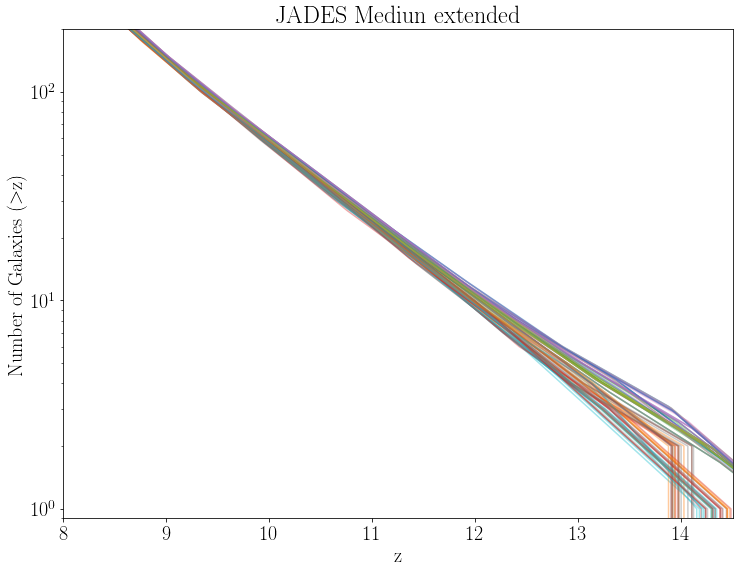

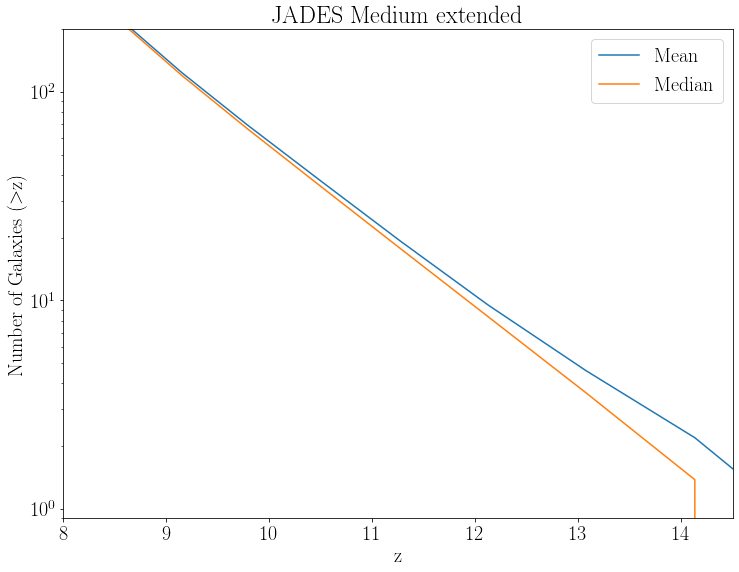

In [19]:
fig, ax = plt.subplots(figsize=(12,9))
meds, means = [],[]
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design matching the JADES Deep survey from Williams et al. 2018 (pg. 36)
    deep = survey(29.8, 5*190./3600, "cv_jades_medium_extend.csv", nearest_wavelength(x,14873.4))
    mean_deep, med_deep, z_vals_deep = mean_median(deep)
    summed+=med_deep
    summean+=mean_deep
    meds.append(med_deep)
    means.append(mean_deep)
    ax.plot(z_vals_deep, mean_deep, alpha=0.4, label = "Mean")
    ax.plot(z_vals_deep, med_deep, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e2), xlim=(8,14.5), title='JADES Mediun extended')
winsound.Beep(400,300)
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e2), xlim=(8,14.5), title='JADES Medium extended')
if save==1:
    plt.savefig("figs/"+file+"/jadesmediumextend.pdf")
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean
meanwideEfinal=summean/N
medwideEfinal=summed/N

[None,
 (0.9, 200.0),
 Text(0, 0.5, 'Number of Galaxies ($>$z)'),
 (8.0, 16.0),
 Text(0.5, 0, 'z'),
 Text(0.5, 1.0, 'JADES Medium extended')]

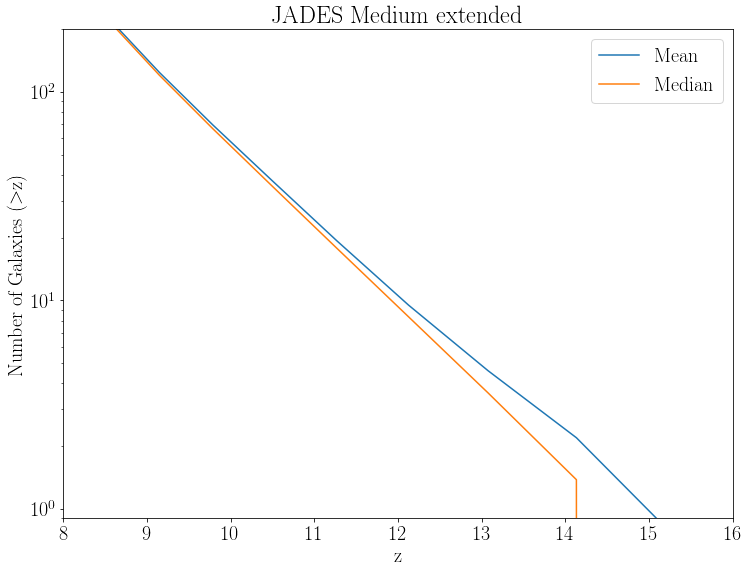

In [49]:
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, meanwideEfinal,label = "Mean")
ax.plot(z_vals, medwideEfinal,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e2), xlim=(8,16), title='JADES Medium extended')
# if save==1:
#     plt.savefig("figs/"+file+"/jadesmediumextend.pdf")
# fmed = interp1d(z_vals, summed/N, 'cubic')
# fmean = interp1d(z_vals, summean/N, "cubic")
# z_med, z_mean = find_min(fmed), find_min(fmean)
# z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean
# meanwideEfinal=summean/N
# medwideEfinal=summed/N

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

-2.0044159989253454
-1.9081767854476814
-1.8241611962720117
-1.7504047203498012
-1.6852920930411432
-1.627513640313682
-1.5760216229415323
-1.5299210970025832
-1.4884699138784998
-1.4510787202547215
-1.4172454744188452
-1.3865117904595459
-1.3585065940676557
-1.3329242946356255
-1.309481129456444
-1.2879588195247187
-1.2681609137355963
-1.2498909609842228
-1.232996165966824
-1.2173455612801638
-1.2028081795210066
-1.189274881186656
-1.1766801825754942
-1.1649367720853643
-1.1539573381141088
-1.1436763969601103
-1.1340284649217507
-1.1249698861979516
-1.1164570049876341
-1.1084461654897202
-1.100893711903131
-1.093755988426788
-1.0870111671601521
-1.0806374202026838
-1.0745910917533046
-1.068850353911475
-1.0633933787766563
-1.058198338448309
-1.0532652329264327
-1.0485722343104886
-1.0440975146999372
-1.0398192461942393
-1.035737428793395
-1.031852062497404
-1.0281194915051879
-1.0245397158167466
-1.0211127354320806
-1.01781672245065
-1.0146516768724552
-1.0116175986974958
-1.008692660

  2%|█▋                                                                                 | 1/50 [00:40<32:41, 40.03s/it]

-2.0206142014178186
-1.9228836668687328
-1.8375661736776623
-1.7626667687692115
-1.6965451573924994
-1.6378713708305965
-1.5855814341099586
-1.5387665352740165
-1.4966730253831764
-1.45870241851482
-1.4243448933274572
-1.3931349607701624
-1.3646957963731388
-1.3387170741024361
-1.314910634069386
-1.2930548148211667
-1.272950121050239
-1.254397057449063
-1.2372404610006638
-1.2213473348333481
-1.2065846820754231
-1.1928416720004782
-1.1800518061726661
-1.168126420010859
-1.1569768489339278
-1.146536594506026
-1.136739158291307
-1.1275402079992065
-1.1188954113391605
-1.1107604360206043
-1.1030909497529735
-1.0958426202457041
-1.0889932813535137
-1.08252076693112
-1.0763807446879592
-1.0705510484787486
-1.0650095121582062
-1.0597339695810497
-1.0547244207472795
-1.049958699511613
-1.0454146397287682
-1.041070075253463
-1.0369250060856974
-1.032979432225471
-1.0291890213822201
-1.0255537735559443
-1.0220736887466437
-1.018726600809036
-1.0155125097431215
-1.0124314155489
-1.00946115208108

  4%|███▎                                                                               | 2/50 [01:58<41:14, 51.54s/it]

-2.012024996546054
-1.915085244938345
-1.8304580950317746
-1.756164735838659
-1.6905781449913477
-1.6323791151647196
-1.5805122804986764
-1.5340761826543852
-1.4923232708142766
-1.454659901682046
-1.4205803791163967
-1.3896229805535358
-1.3614139305846789
-1.3356454141672978
-1.3120316030476153
-1.290352629338112
-1.2704106119400191
-1.2520076697545683
-1.2349898952604956
-1.2192253677252889
-1.2045821664164356
-1.1909503573901759
-1.1782639802802535
-1.1664350879316605
-1.1553757331893884
-1.1450199556871814
-1.1353017950587834
-1.12617727772669
-1.1176024301133975
-1.1095332786414018
-1.101925849733199
-1.0947361698112845
-1.0879422520869066
-1.0815221097713132
-1.0754317692870006
-1.069649243845216
-1.0641525466572082
-1.0589196909342247
-1.0539506766762654
-1.0492235170945785
-1.044716225400412
-1.0404068148050138
-1.0362952853083838
-1.032381636910522
-1.0286218960339246
-1.0250160626785916
-1.0215641368445225
-1.0182441317429656
-1.015056047373921
-1.0119998837373887
-1.009053654

  6%|████▉                                                                              | 3/50 [02:42<38:33, 49.21s/it]

-2.0150876287335833
-1.9178659095484598
-1.8329926055921115
-1.7584831501313425
-1.6927057882966354
-1.6343374755991937
-1.5823197764479788
-1.535748610442313
-1.4938742523718778
-1.4561013322167145
-1.4219226829227836
-1.3908752389190062
-1.3625841376002235
-1.336740668585716
-1.3130581722362438
-1.2913161411370078
-1.2713161186146882
-1.2528596479959655
-1.2357923740904802
-1.219981992449352
-1.2052961986237016
-1.1916247389061294
-1.1789014610721953
-1.167038162155979
-1.1559466391915616
-1.1455607399545027
-1.1358143122203623
-1.1266632545061808
-1.1180634653289983
-1.1099708432058546
-1.10234128665379
-1.0951306941898447
-1.0883170150725385
-1.0818781985603916
-1.0757701431704438
-1.0699707981612157
-1.0644581127912267
-1.0592100363189973
-1.0542265687445274
-1.049485659326337
-1.0449652573229462
-1.0406433119928749
-1.0365198233361232
-1.0325947913526912
-1.0288241145596189
-1.0252077929569061
-1.0217458265445531
-1.0184161645810799
-1.0152188070664865
-1.0121537540007726
-1.0091

  8%|██████▋                                                                            | 4/50 [04:01<44:43, 58.35s/it]

-2.0243294604967352
-1.9262568729233862
-1.8406407718642301
-1.7654792219866284
-1.6991261875726344
-1.6402470450671558
-1.5877740956261195
-1.5407953464868784
-1.4985545109682143
-1.460451008470336
-1.4259732332971242
-1.3946540672042969
-1.3661153668512447
-1.340045720075113
-1.3161559584389648
-1.2942236446836186
-1.27404858527581
-1.2554305866822757
-1.2382139428215881
-1.2222651913382379
-1.207450869876716
-1.1936597598074312
-1.1808251299526291
-1.1688580054086368
-1.1576694112717818
-1.147192616364309
-1.137360889508464
-1.1281297432524107
-1.119454690144312
-1.1112912427323323
-1.1035949135646348
-1.0963212151893829
-1.0894479038806588
-1.082952735912544
-1.0767912238332022
-1.0709411239167155
-1.065380192437165
-1.0600861856686332
-1.0550591036111197
-1.0502767025387065
-1.0457167387254753
-1.0413569684455077
-1.0371973916988042
-1.0332380084853645
-1.029434331353352
-1.025786360302767
-1.0222940953336095
-1.018935292719961
-1.0157099524618218
-1.012618074559192
-1.00963741528

 10%|████████▎                                                                          | 5/50 [04:46<40:40, 54.23s/it]

-2.003832341471956
-1.9076468636269421
-1.8236781849638763
-1.7499628913285168
-1.6848866199718202
-1.6271404281242923
-1.5756771615703373
-1.5296023760841346
-1.4881743374296366
-1.4508040213605717
-1.4169896664819661
-1.3862731428244977
-1.3582835832701423
-1.3327155678393519
-1.3092854922654018
-1.287775199420044
-1.2679883478878535
-1.2497285962534068
-1.232843234526929
-1.2172013684314709
-1.202672103690083
-1.1891463617386409
-1.1765586954386698
-1.16482184193887
-1.1538485383879418
-1.1435733376474109
-1.133930792578802
-1.124877271756466
-1.1163691437547523
-1.1083627771480113
-1.1008145405105938
-1.0936808024168492
-1.086939747153953
-1.0805695590090802
-1.0745266065565813
-1.0687890740836308
-1.063335145877404
-1.0581430062250763
-1.0532126551266474
-1.0485222768692926
-1.0440500557401866
-1.039774176026505
-1.0356946377282472
-1.031811440845414
-1.0280809539523548
-1.0245031770490702
-1.02107811013556
-1.017783937498999
-1.0146206591393874
-1.0115882750567253
-1.008664969538

 12%|█████████▉                                                                         | 6/50 [05:59<43:58, 59.97s/it]

-2.0320486246577074
-1.9332653562435447
-1.8470288399981123
-1.7713226336085781
-1.7044887733955034
-1.6451829644836666
-1.5923297709728912
-1.5450105913651089
-1.5024636585643618
-1.4640840398767998
-1.4293564222669217
-1.3978103025284003
-1.3690647971132561
-1.342806237217271
-1.3187433589508137
-1.296652113168014
-1.2763308556375885
-1.2575779421282545
-1.2402365382379024
-1.2241722144790104
-1.2092505413640564
-1.1953594943201054
-1.182431858603396
-1.1703780145555802
-1.15910834251831
-1.1485556277478246
-1.1386526555003627
-1.12935461594675
-1.120616699257813
-1.1123940956043774
-1.1046419951572692
-1.0973155880873142
-1.0903924694799256
-1.0838502344205165
-1.0776440730799124
-1.0717515805435267
-1.066150351896772
-1.0608179822250619
-1.0557544715283957
-1.050937414892187
-1.0463444074018482
-1.0419530441427927
-1.0377633251150202
-1.0337752503185311
-1.029944009924151
-1.0262696039318802
-1.0227520323417183
-1.0193688902390785
-1.0161201776239608
-1.0130058944963654
-1.01000363

 14%|███████████▌                                                                       | 7/50 [06:47<40:20, 56.29s/it]

-2.026952213980485
-1.9286381571739124
-1.8428112565958905
-1.7674646478525453
-1.7009482424422466
-1.6419241307690788
-1.5893219851563085
-1.5422275673800594
-1.4998827286693128
-1.4616854097059064
-1.4271227451447388
-1.3957264666272395
-1.367117499767899
-1.3409836656610032
-1.3170350838941038
-1.2950487695345485
-1.274824036142949
-1.2561601972799186
-1.2389011634926002
-1.222913143821402
-1.2080623473067325
-1.1942372814822655
-1.1813710508682052
-1.1693744614914903
-1.1581583193790597
-1.1476557290511178
-1.1377997950278687
-1.128545920322782
-1.119849507949327
-1.111665960920973
-1.1039506822511898
-1.0966590749534468
-1.0897688405344785
-1.08325768050102
-1.0770809978665403
-1.0712164941377744
-1.065641870821457
-1.0603348294243229
-1.055295369946372
-1.0505011938943392
-1.045930002774959
-1.041559498094966
-1.0373896798543607
-1.0334205480531429
-1.0296075057047818
-1.0259505528092776
-1.0224496893666302
-1.0190826168835745
-1.0158493353601106
-1.0127498447962382
-1.0097618466

 16%|█████████████▎                                                                     | 8/50 [07:58<42:22, 60.54s/it]

-2.0073890111396113
-1.910876081133043
-1.8266215409662747
-1.7526552922721959
-1.6873574763934038
-1.6294146944184922
-1.5777762272183349
-1.5315445855368033
-1.4899755099907672
-1.4524779710700932
-1.4185484991920754
-1.387727404737721
-1.359642558015465
-1.3339874992793121
-1.3104776587651243
-1.2888941366543336
-1.269039923110229
-1.2507180082960994
-1.2337751623389472
-1.2180800453476317
-1.2035013174310125
-1.1899295286798053
-1.1772990091484399
-1.1655221989094893
-1.154511538035526
-1.14420135658098
-1.1345259846002806
-1.1254416421297146
-1.1169045492055683
-1.1088709258641278
-1.10129699214168
-1.094138968074511
-1.0873749636807644
-1.0809830889785828
-1.0749195640042533
-1.0691624987759185
-1.063690003311722
-1.0584801876298071
-1.0535330517301735
-1.0488267056309646
-1.0443392593503236
-1.0400488229063936
-1.0359553962991745
-1.0320589795286668
-1.0283157926311564
-1.0247258356066435
-1.021289108455128
-1.0179837211947536
-1.0148096738255197
-1.0117669663474265
-1.008833708

 18%|██████████████▉                                                                    | 9/50 [08:49<39:29, 57.78s/it]

-2.0062529081067577
-1.9098445757796532
-1.8256813480348077
-1.7517952616357864
-1.6865682134770763
-1.6286882280677217
-1.5771057250149572
-1.5309241877332962
-1.4894001634445297
-1.4519432631777278
-1.4180505629946905
-1.3872628714735828
-1.3592084622253011
-1.3335812076352884
-1.310096846347171
-1.2885367157791228
-1.2687040196075001
-1.25040196150866
-1.233477477675324
-1.2177993705583963
-1.2032364426087816
-1.1896793625355668
-1.1770625315642038
-1.1652984846619625
-1.1542997567961124
-1.1440007491921054
-1.1343358630753941
-1.1252613659296133
-1.1167335252383974
-1.1087086084853814
-1.1011428831542003
-1.0939926167284886
-1.0872359429500635
-1.080850995560743
-1.0747940420441615
-1.0690432161421364
-1.0635766515964853
-1.0583724821490255
-1.0534307077997567
-1.0487294622904968
-1.0442468793630628
-1.0399610927592722
-1.035872102479125
-1.0319799085226216
-1.028240778373396
-1.0246547120314489
-1.02122170949678
-1.0179199045112066
-1.014749297074729
-1.011709887187347
-1.00877980

 20%|████████████████▍                                                                 | 10/50 [09:56<40:22, 60.56s/it]

-2.0374662827090626
-1.9381842263822597
-1.8515122747374733
-1.7754238038079504
-1.708252478332139
-1.6486472156655374
-1.5955271496925438
-1.5479690406060826
-1.5052072749076026
-1.466633865407078
-1.4317308970907832
-1.4000254910331424
-1.37113484048488
-1.3447436928289462
-1.3205593134923652
-1.2983565220343865
-1.2779326560583353
-1.259085053167536
-1.2416560870534636
-1.2255106494516679
-1.2105136320976984
-1.1965524447711806
-1.1835595333398887
-1.1714448256275232
-1.1601182494577835
-1.149512250698445
-1.139559275217282
-1.1302142869261451
-1.1214322497368838
-1.1131681275613483
-1.1053768843113883
-1.0980134838988538
-1.0910554082796697
-1.0844801394097612
-1.0782426412009782
-1.0723203956092457
-1.0666908845904883
-1.0613315901006315
-1.056242512139675
-1.0514011326635437
-1.0467849336281627
-1.042371396989457
-1.0381605227474267
-1.0341523109020716
-1.0303017253652416
-1.0266087661369367
-1.0230734332171574
-1.0196732085618279
-1.0164080921709486
-1.0132780840445197
-1.010260

 22%|██████████████████                                                                | 11/50 [10:49<37:49, 58.18s/it]

-2.0096227718722073
-1.912904186055954
-1.8284701110260695
-1.754346250406174
-1.6889092938423533
-1.6308430437503545
-1.5790945420627742
-1.5327643870970389
-1.4911067335554047
-1.4535292925249572
-1.4195275215983996
-1.3886407516212427
-1.3604960599446145
-1.3347863337988561
-1.3112263970407123
-1.2895968834061406
-1.2697003632575035
-1.2513394069571624
-1.2343604581202876
-1.2186318969884542
-1.2040221038032366
-1.1904213954326135
-1.1777639619973723
-1.165962056991896
-1.154927933910568
-1.1445957828741753
-1.1348997940035053
-1.1257960940457497
-1.1172408097480995
-1.1091900678577469
-1.1015999951218831
-1.0944267182876997
-1.0876483007287923
-1.0812428058187569
-1.075166360304785
-1.0693970275604723
-1.0639128709594146
-1.0586919538752078
-1.0537342763078514
-1.049017901630942
-1.0445208932180745
-1.0402213144428454
-1.0361191653052542
-1.032214445805301
-1.0284632826901776
-1.0248656759598838
-1.0214216256144195
-1.0181091950273808
-1.0149283841987673
-1.011879193128579
-1.00893

 24%|███████████████████▋                                                              | 12/50 [11:56<38:36, 60.95s/it]

-2.0038301577258597
-1.9076448809319548
-1.8236763777839076
-1.749961238231491
-1.6848851029000738
-1.6271390317561711
-1.5756758727729956
-1.5296011835943317
-1.4881732315345393
-1.4508029935785496
-1.4169887093801932
-1.3862722499277509
-1.3582827488784017
-1.3327147868909996
-1.3092847602916224
-1.2877745124080229
-1.2679877022351782
-1.2497279887680657
-1.2328426623361124
-1.2172008289359697
-1.2026715945642887
-1.1891458808849462
-1.1765582408962678
-1.1648214119293545
-1.1538481313153073
-1.1435729520524518
-1.1339304271391142
-1.1248769252408446
-1.1163688150231936
-1.1083624651517119
-1.1008142442919497
-1.0936805211094578
-1.0869394799370113
-1.0805693051073855
-1.074526365286131
-1.0687888448060228
-1.0633349279998363
-1.0581427992003467
-1.0532124584075542
-1.0485220899542338
-1.0440498781731609
-1.0397740073971105
-1.035694477626083
-1.0318112888600783
-1.0280808097646468
-1.0245030403397883
-1.0210779805855033
-1.0177838148345666
-1.0146205430869784
-1.0115881653427388
-1.

 26%|█████████████████████▎                                                            | 13/50 [12:51<36:30, 59.20s/it]

-2.020552157448816
-1.9228273351062775
-1.8375148285976746
-1.7626198014496959
-1.6965020547842857
-1.6378316976192373
-1.5855448171687838
-1.5387326545950843
-1.4966416050082207
-1.4586732174662003
-1.4243177004258432
-1.3931095920433767
-1.3646720898738423
-1.3386948860213916
-1.3148898374398796
-1.2930352956322717
-1.272931776951237
-1.254379797749444
-1.237224204078969
-1.2213320068415907
-1.206570216939089
-1.192828010122946
-1.1800388918440519
-1.1681142027035922
-1.156965283302754
-1.1465256390924259
-1.1367287755234983
-1.127530362896564
-1.118886071512216
-1.1107515716710477
-1.1030825336736518
-1.0958346278206215
-1.0889856892622536
-1.0825135531488443
-1.076373889780987
-1.070544534308978
-1.0650033218831139
-1.0597280876536914
-1.0547188316207101
-1.0499533889344672
-1.0454095947452586
-1.0410652842033812
-1.0369204573088349
-1.0329751140616197
-1.0291849247623286
-1.0255498894109618
-1.0220700080075191
-1.0187231157022973
-1.015509212495296
-1.0124282983865156
-1.009458208

 28%|██████████████████████▉                                                           | 14/50 [14:00<37:12, 62.03s/it]

-2.0123930198293656
-1.9154193853956194
-1.8307626562199584
-1.7564433296716189
-1.69083381469864
-1.6326144428805118
-1.5807294794808278
-1.5342771510789062
-1.492509645569792
-1.4548331121642564
-1.4207416779677704
-1.3897734590331559
-1.3615545493079355
-1.3357770261606572
-1.3121549614335437
-1.2904684103898436
-1.2705194227664807
-1.252110048300378
-1.2350863256758102
-1.219316288050726
-1.2046679685830748
-1.1910313949044804
-1.1783405835939176
-1.1665075567566856
-1.155444336498084
-1.1450849393970872
-1.13536338203267
-1.1262356754574818
-1.1176578307241725
-1.1095858588853915
-1.101975770993789
-1.094783578102014
-1.0879872857363921
-1.0815648994232476
-1.0754724302152305
-1.0696878836386654
-1.0641892652198774
-1.0589545804851912
-1.0539838294346067
-1.049255017594449
-1.0447461504910427
-1.040435233650713
-1.0363222670734595
-1.0324072507592823
-1.0286461957608313
-1.0250391020781064
-1.0215859697111074
-1.0182648041861595
-1.0150756055032624
-1.0120183736624162
-1.009071114

 30%|████████████████████████▌                                                         | 15/50 [14:57<35:19, 60.56s/it]

-2.032070296617554
-1.933285032929509
-1.8470467748357722
-1.7713390392944013
-1.7045038291375767
-1.6451968223373372
-1.5923425612713136
-1.545022425887065
-1.5024746337020802
-1.4640942398037766
-1.4293659207481018
-1.3978191638252695
-1.3690730777940239
-1.342813987514507
-1.3187506232139943
-1.2966589312211587
-1.2763372632318057
-1.2575839709417413
-1.2402422167810367
-1.2241775685468956
-1.2092555940365217
-1.1953642664142519
-1.1824363695786877
-1.1703822820612988
-1.159112382393554
-1.1485594544740554
-1.1386562822014048
-1.1293580548413371
-1.1206199616595867
-1.1123971919218882
-1.1046449348939764
-1.0973183798415855
-1.0903951213975833
-1.0838527541948368
-1.0776464674990807
-1.0717538559431823
-1.066152514160009
-1.060820036782428
-1.0557564238104393
-1.0509392698769102
-1.046346169614708
-1.0419547176567001
-1.0377649140028864
-1.0337767586532671
-1.0299454408735764
-1.0262709606638147
-1.0227533180239818
-1.0193701075869452
-1.0161213293527047
-1.0130069833212603
-1.01000

 32%|██████████████████████████▏                                                       | 16/50 [16:00<34:49, 61.45s/it]

-2.0377744852460427
-1.938464053614148
-1.8517673306948552
-1.77565711330221
-1.7084665899277618
-1.648844291780875
-1.5957090438290402
-1.5481373423986564
-1.5053633551750303
-1.4667789212023754
-1.4318659774442812
-1.4001515098240256
-1.3712526021842613
-1.3448539118071734
-1.3206626204547907
-1.2984534833286743
-1.278023780110228
-1.2591707904808573
-1.2417368430816542
-1.2255867910335554
-1.2105854874574968
-1.1966203099542592
-1.1836236850843107
-1.1715055149282754
-1.1601757015667777
-1.149566671560286
-1.1396108514692682
-1.1302631923340365
-1.1214786451949033
-1.1132121610921804
-1.10541869106618
-1.0980531861572143
-1.0910931218854394
-1.0845159737710113
-1.0782766928542422
-1.0723527546552882
-1.0667216346943054
-1.0613608084914496
-1.056270276046721
-1.0514275128802757
-1.0468099945122697
-1.0423951964628593
-1.038183118732044
-1.034173761319824
-1.0303220752665119
-1.026628060572107
-1.0230917172366099
-1.019690520780176
-1.016424471202806
-1.0132935685044995
-1.01027528820

 34%|███████████████████████████▉                                                      | 17/50 [16:59<33:24, 60.75s/it]

-2.0192199199903564
-1.9216177528495206
-1.8364123227463054
-1.7616112969425215
-1.6955765351867687
-1.6369798156535884
-1.5847585608826127
-1.5380051526264449
-1.4959669318506572
-1.4580461987337936
-1.4237338015760945
-1.392564862738649
-1.364163052704244
-1.3382184530469385
-1.3144432823712169
-1.2926161703728354
-1.2725378837779753
-1.2540091893128178
-1.2368751277643923
-1.2210028769501535
-1.206259614687555
-1.1925346558244756
-1.1797615892696416
-1.1678518669013565
-1.1567169405979225
-1.1462903992680669
-1.1365058318205166
-1.1273189641944228
-1.1186855223289374
-1.110561232163211
-1.1029018196363958
-1.0956630106876424
-1.088822668286527
-1.082358655402625
-1.0762266979750876
-1.070404658973491
-1.0648704013674104
-1.059601788126422
-1.0545988192505251
-1.049839357709296
-1.0453012664723098
-1.0409624085091427
-1.0368227838197945
-1.0328823924042652
-1.0290969602017062
-1.0254664872121173
-1.0219909734354988
-1.0186482818414262
-1.0154384124298994
-1.0123613652009187
-1.009395

 36%|█████████████████████████████▌                                                    | 18/50 [17:58<32:07, 60.23s/it]

-2.030392025280089
-1.9317612751197197
-1.8456579053380777
-1.7700685869457242
-1.7033379161068987
-1.6441236734953095
-1.5913520836499229
-1.5441059633644385
-1.5016247216872918
-1.4633043599216506
-1.428630360659103
-1.397132947135447
-1.3684318238748996
-1.3422138063679927
-1.318188080427363
-1.2961309428319618
-1.2758410606828452
-1.2571171010810696
-1.2398024717719007
-1.2237629508227093
-1.2088643163008663
-1.1949947165958474
-1.1820870407413377
-1.1700518074489181
-1.1587995354301688
-1.1482631137187753
-1.1383754313484231
-1.1290917476749023
-1.1203673220540031
-1.112157413841516
-1.1044172823932312
-1.0971021870649391
-1.0901897575345345
-1.0836576234799125
-1.0774610442568637
-1.0715776495432832
-1.0659850690170658
-1.060660932356107
-1.0556052395604063
-1.0507956203078594
-1.0462097042763612
-1.0418251211438068
-1.0376418709101962
-1.0336599535755295
-1.0298346284955968
-1.0261658956703983
-1.0226537550999337
-1.0192758364620986
-1.0160321397568925
-1.0129226649843157
-1.009

 38%|███████████████████████████████▏                                                  | 19/50 [19:07<32:25, 62.75s/it]

-2.011509397889456
-1.914617115940269
-1.8300314064318952
-1.755774427364918
-1.6902199530953728
-1.6320494222903155
-1.5802079858833906
-1.5337946269637528
-1.4920621607760673
-1.4544172347205089
-1.4203544002861155
-1.389412161006357
-1.3612169245035657
-1.3354610264667215
-1.3118587786070193
-1.290190420702302
-1.270258168552628
-1.2518642379580558
-1.234854796763075
-1.219097988834391
-1.2044619580387097
-1.1908368242649525
-1.178156659446472
-1.166333559494405
-1.1552796203198892
-1.1449289138562768
-1.1352155120369207
-1.1260954628173896
-1.1175248141532519
-1.1094596140000763
-1.101855910313431
-1.094669751048885
-1.0878791601842221
-1.0814621616972266
-1.0753748035434674
-1.0695951097007284
-1.064101104146794
-1.0588708108594485
-1.0539042298386918
-1.0491793850623081
-1.044674300508082
-1.0403670001537975
-1.0362574839994545
-1.0323457520450532
-1.028587852246162
-1.0249837846027812
-1.0215335491149105
-1.0182151697603339
-1.0150286465390521
-1.0119739794510645
-1.009029192474

 40%|████████████████████████████████▊                                                 | 20/50 [20:04<30:30, 61.03s/it]

-2.0091125166751476
-1.9124409085607426
-1.82804784445724
-1.7539599869343157
-1.6885548141048146
-1.630516767681855
-1.5787934010359308
-1.532485749337672
-1.4908483295578456
-1.4532891404673545
-1.4193038847228938
-1.3884321169240548
-1.3603010955562205
-1.3346038570191188
-1.3110553636839246
-1.289436355836158
-1.2695494997327863
-1.2511974616307775
-1.2342267597299954
-1.2185058382017513
-1.203903141217357
-1.190309038919573
-1.1776577533940542
-1.1658615807550092
-1.1548328171166455
-1.144505684564619
-1.1348144051845859
-1.1257151270336496
-1.1171639981689143
-1.109117166647484
-1.1015307805264625
-1.0943609878629534
-1.0875858626855095
-1.081183479022682
-1.075109984931575
-1.0693434544407407
-1.063861961578731
-1.0586435803740977
-1.053688310826841
-1.0489742269655125
-1.0444794028186644
-1.0401819124148488
-1.0360817557540654
-1.0321789328363145
-1.0284295917186999
-1.0248337324012213
-1.021391354883879
-1.0180805331952254
-1.0149012673352595
-1.0118535573039822
-1.00891547712

 42%|██████████████████████████████████▍                                               | 21/50 [21:10<30:15, 62.61s/it]

-2.0177550064851855
-1.9202877096411672
-1.835200019563457
-1.7605023565931832
-1.694558844121941
-1.6360430957104835
-1.5838940022074128
-1.5372051995459102
-1.4952250687437347
-1.4573567359032262
-1.423091752889339
-1.3919658844483371
-1.3636033210891003
-1.337694572642471
-1.3139522553799452
-1.2921553048949823
-1.2721047632216949
-1.2536016723941956
-1.2364912873279064
-1.2206409693789018
-1.2059180799032574
-1.1922120866977026
-1.179456670440275
-1.167563405368358
-1.1564438657193352
-1.1460317321712445
-1.136260685402123
-1.127086512530663
-1.1184650006755559
-1.1103519369554937
-1.1027031084891679
-1.0954743023952704
-1.0886434122331472
-1.082188331562144
-1.0760648475009524
-1.0702508536089188
-1.0647242434453885
-1.0594629105697078
-1.0544668549818765
-1.0497139702412406
-1.0451821499071459
-1.0408492875389384
-1.0367153831366176
-1.0327804367001843
-1.0290002353483296
-1.0253747790810537
-1.0219040678983569
-1.0185659953595847
-1.0153605614647372
-1.0122877662138143
-1.009325

 44%|████████████████████████████████████                                              | 22/50 [22:06<28:14, 60.50s/it]

-2.0097780565709935
-1.9130451741472319
-1.8285986183638212
-1.7544638010107052
-1.6890171717818365
-1.6309423385371788
-1.5791861875647015
-1.5328491842353786
-1.4911853730031892
-1.4536023774051166
-1.4195955804541456
-1.3887042449012639
-1.3605553929734602
-1.3348418665047261
-1.3112784471980534
-1.289645736363436
-1.2697462751798678
-1.2513826048263437
-1.234401146219859
-1.21867026014641
-1.2040583073919926
-1.1904555886116044
-1.177796284198243
-1.1659926346759062
-1.154956880568591
-1.144623202269296
-1.1349257801710193
-1.1258207345357594
-1.117264185625515
-1.1092122537022853
-1.1016210590280684
-1.0944467218648637
-1.0876673023436703
-1.0812608605954872
-1.0751835168823138
-1.069413331335149
-1.0639283640849924
-1.0587066752628433
-1.0537482648687018
-1.0490311930335672
-1.044533519888439
-1.040233305564316
-1.036130550061199
-1.0322252533790874
-1.0284735357799804
-1.0248753972638776
-1.0214308378307793
-1.0181179176116848
-1.014936636606594
-1.011886994815507
-1.00894705236

 46%|█████████████████████████████████████▋                                            | 23/50 [23:15<28:21, 63.00s/it]

-2.005099450566433
-1.9087973136974774
-1.8247267932146902
-1.750922093627437
-1.6857668941989736
-1.6279506646022115
-1.5764249805754784
-1.5302943130619304
-1.4888160282095497
-1.4514003873711463
-1.4175450205880025
-1.3867912422456372
-1.3587677354180414
-1.3331687096955611
-1.3097102168406602
-1.2881738351321572
-1.2683629850209885
-1.250081086958091
-1.2331752457386371
-1.2175144083299183
-1.2029675216992257
-1.1894253749859682
-1.1768224416737914
-1.165071353074223
-1.1540847404987897
-1.1437970774311377
-1.1341428373549123
-1.125078335925877
-1.1165598887997956
-1.108543811632432
-1.1009864200795496
-1.093844029796912
-1.0870947986124015
-1.0807168843538997
-1.07466660267717
-1.0689221114100946
-1.0634615683805553
-1.058263131416434
-1.0533268005177303
-1.0486307335123266
-1.0441530882281043
-1.0398720224929454
-1.03578753630685
-1.0318996296698182
-1.0281646182376132
-1.0245825020102355
-1.0211532809876847
-1.017855112997843
-1.0146879980407102
-1.0116519361162863
-1.0087250850

 48%|███████████████████████████████████████▎                                          | 24/50 [24:08<26:04, 60.19s/it]

-1.9972871215671644
-1.9017042429528765
-1.8182616256277702
-1.7450081561703699
-1.6803395857674621
-1.622955172138063
-1.5718143214573863
-1.5260281931667588
-1.4848596999736237
-1.4477235078515382
-1.4141209989261252
-1.3835969133990402
-1.355782707624005
-1.3303748750687894
-1.3070915882391807
-1.2857160567550148
-1.266053169274144
-1.247907814454421
-1.2311282390297307
-1.2155843687719752
-1.2011461294530557
-1.1877051258828906
-1.1751963209474303
-1.1635329984946097
-1.1526284423723627
-1.1424176154666403
-1.1328354806633936
-1.1238386798865894
-1.115383855060195
-1.107427648108178
-1.099926700954505
-1.0928376555231438
-1.0861388327760777
-1.0798085536752902
-1.0738034601447486
-1.0681018731464365
-1.0626821136423377
-1.0575225025944355
-1.05262304000273
-1.0479620468292052
-1.0435178440358441
-1.0392687525846305
-1.0352147724755645
-1.0313559037086462
-1.0276487882078427
-1.0240934259731538
-1.0206898170045795
-1.017416282264104
-1.0142728217517265
-1.0112594354674476
-1.0083544

 50%|█████████████████████████████████████████                                         | 25/50 [25:20<26:26, 63.47s/it]

-2.019614090562456
-1.9219756332912687
-1.8367385223734194
-1.7619096842878352
-1.6958503696949683
-1.6372318629141038
-1.58499119140067
-1.5382203994395116
-1.496166548144891
-1.4582317154604856
-1.4239065603753551
-1.3927260324012496
-1.3643136620952998
-1.3383594157986722
-1.3145754051138787
-1.2927401774274667
-1.272654425387329
-1.254118841641359
-1.2369784093601388
-1.221100256975598
-1.2063515129196645
-1.1926214508856123
-1.179843635089406
-1.1679294844856638
-1.1567904180290054
-1.1463599999353948
-1.1365717944207963
-1.1273815109625196
-1.118744859037874
-1.110617548124169
-1.1029552876987139
-1.0957137872388187
-1.088870901483138
-1.0824044851703263
-1.0762702477776933
-1.0704460440438937
-1.0649097287075824
-1.059639156507414
-1.0546343274433885
-1.0498730962541607
-1.0453333176783854
-1.0409928464547173
-1.0368516825831564
-1.0329098260637029
-1.029122986373666
-1.0254911635130455
-1.022014357481842
-1.01867042301871
-1.0154593601236495
-1.0123811687966604
-1.0094137037763

 52%|██████████████████████████████████████████▋                                       | 26/50 [26:09<23:43, 59.31s/it]

-2.003219506310397
-1.9070904504041857
-1.8231710273642658
-1.749498974765698
-1.684460876836864
-1.6267485586278052
-1.5753154801785534
-1.529267721939969
-1.487863984773742
-1.4505155899523905
-1.416721070411763
-1.3860225649193734
-1.358049423906067
-1.3324964065501859
-1.309080074945906
-1.2875823999349003
-1.2678071552746748
-1.249558114722736
-1.2326826578682548
-1.2170499672162354
-1.202529225271682
-1.189011417455431
-1.1764311350199843
-1.1647011663020117
-1.1537342996381823
-1.143465126280998
-1.133828237482961
-1.1247800274124058
-1.1162768902376672
-1.10827522012708
-1.1007314112489786
-1.0936018577716977
-1.086864756779405
-1.0804983053562673
-1.0744588976706198
-1.0687247308066294
-1.0632740018484637
-1.0580849078802899
-1.053157448902108
-1.0484698219980855
-1.0440002242523896
-1.0397268527491876
-1.0356497074884796
-1.0317687884702655
-1.0280404898628803
-1.0244648116663235
-1.0210417538805954
-1.0177495135898633
-1.0145880907941272
-1.011557485493387
-1.008635894771810

 54%|████████████████████████████████████████████▎                                     | 27/50 [27:25<24:35, 64.16s/it]

-2.028173679165456
-1.9297471656360339
-1.8438220917928163
-1.7683892976862352
-1.7017968073577556
-1.642705180840999
-1.5900428661628618
-1.5428945793463185
-1.5005013044104207
-1.4622602933702984
-1.427658094238839
-1.39622590302781
-1.3675842117467376
-1.3414204844034665
-1.3174445090052809
-1.295433045557785
-1.2751851780660213
-1.2564999905350331
-1.2392212149687432
-1.2232149073705132
-1.2083471237437056
-1.1945062440911218
-1.1816252964144431
-1.1696149847159107
-1.1583860129977661
-1.1478714092616904
-1.1380042015093645
-1.1287397417419094
-1.1200333819604453
-1.1118404741660934
-1.1041163703599741
-1.0968164225432082
-1.089918306716356
-1.083399698879978
-1.0772159510351944
-1.0713447391825661
-1.0657637393226533
-1.0604506274560164
-1.0554054035826552
-1.0506057437031302
-1.0460293238180016
-1.04165381992783
-1.0374792320326154
-1.0335055601323573
-1.029688156228177
-1.0260270203200743
-1.022522152408049
-1.0191512284926616
-1.0159142485739123
-1.0128112126518007
-1.009819796

 56%|█████████████████████████████████████████████▉                                    | 28/50 [28:13<21:45, 59.35s/it]

-2.0233147661041846
-1.9253355984722993
-1.8398010518142982
-1.764711097759379
-1.6984212685359918
-1.6395982118969354
-1.587175246044448
-1.5402412469429416
-1.4980406483190019
-1.459973441661388
-1.4255285086086729
-1.394239175874335
-1.3657276603216681
-1.3396828464263246
-1.315815841201411
-1.2939044192723932
-1.2737485778021913
-1.2551483139537252
-1.2379480699648209
-1.2220145106107583
-1.2072143006668175
-1.1934363274457311
-1.1806139233351398
-1.1686581981852295
-1.157480261846187
-1.1470134467056523
-1.137191085151265
-1.1279687321081187
-1.1193019425013064
-1.1111462712559215
-1.1034572732970573
-1.0961905035498072
-1.0893237394767175
-1.0828347585403348
-1.076679115665753
-1.070834588315518
-1.0652789539521768
-1.0599899900382759
-1.0549676965738155
-1.050189851021342
-1.0456342308434023
-1.0412786135025427
-1.0371229989987636
-1.0331673873320646
-1.0293673334275393
-1.0257228372851874
-1.0222338989050093
-1.018878295749551
-1.0156560278188131
-1.0125670951127956
-1.00958927

 58%|███████████████████████████████████████████████▌                                  | 29/50 [29:29<22:35, 64.54s/it]

-2.0148539918859805
-1.9176537829612736
-1.8327992571841822
-1.758306286905982
-1.692543478282167
-1.634188079546921
-1.5821818892875914
-1.5356210271308708
-1.493755933742797
-1.4559913708287522
-1.421820283545174
-1.3907797087740272
-1.3624948668483299
-1.3366571156893923
-1.3129798590812871
-1.2912426383963789
-1.2712470408697947
-1.2527946537366625
-1.2357311559576372
-1.2199242723561368
-1.20524172775558
-1.1915732928421487
-1.1788528300275523
-1.1669921558607361
-1.1559030868906461
-1.145519485528991
-1.1357752141874804
-1.1266261811405869
-1.1180282946627833
-1.1099374630285426
-1.1023095945123376
-1.0951005973886407
-1.0882884257946888
-1.0818510338677179
-1.075744329882201
-1.0699462679753744
-1.0644348022844747
-1.0591878869467384
-1.0542055219621649
-1.0494656614679911
-1.0449462596014536
-1.0406252704997883
-1.0365026941629951
-1.0325785305910746
-1.0288086880584992
-1.025193166565269
-1.021731966111384
-1.0184030408340805
-1.0152063907333588
-1.0121420158092185
-1.00918787

 60%|█████████████████████████████████████████████████▏                                | 30/50 [30:13<19:25, 58.30s/it]

-2.0362294358975817
-1.93706125243494
-1.8504887103284062
-1.7744875100743203
-1.7073932276363388
-1.6478563300120224
-1.5947971907994183
-1.5472936291135262
-1.5045809095862963
-1.466051742366631
-1.4311888064702611
-1.399519765346333
-1.3706622513108218
-1.3443013733298248
-1.3201447325861466
-1.297967406912714
-1.277566966359161
-1.258740980975121
-1.2413320052436436
-1.2252050858644843
-1.210225269537399
-1.196280095178851
-1.1833020861387185
-1.171201273550172
-1.1598876885463825
-1.1492938544772275
-1.1393522946925854
-1.1300180247590412
-1.1212460602431804
-1.1129914167115882
-1.1052091097308503
-1.0978541548675516
-1.090904059904985
-1.084336332626443
-1.0781059885985111
-1.072190535604482
-1.0665674814276482
-1.0612143338513023
-1.0561310928754446
-1.0512952662833674
-1.0466843618583637
-1.042275887383726
-1.0380698428594544
-1.0340662282855486
-1.0302200592285942
-1.0265313356885912
-1.0230000576655396
-1.019603732942732
-1.0163423615201683
-1.0132159433978487
-1.010201986359

 62%|██████████████████████████████████████████████████▊                               | 31/50 [31:30<20:15, 63.96s/it]

-2.0064195554025583
-1.909995880346911
-1.8258192585984
-1.751921413732664
-1.6866839851341164
-1.6287947885198508
-1.5772040764635407
-1.5310151897051996
-1.4894845571511794
-1.4520216958741727
-1.4181236018990644
-1.3873310107268368
-1.3592721368106664
-1.3336408038178749
-1.310152705153832
-1.2885891434380534
-1.2687532910281027
-1.2504483202815444
-1.2335211430320387
-1.217840540851295
-1.2032752953110226
-1.1897160577209793
-1.1770972188670195
-1.1653312997969496
-1.1543308215585757
-1.1440301749377526
-1.1343637507203346
-1.1252878094302248
-1.1167586115913266
-1.1087324177275428
-1.1011654883627768
-1.0940140840209314
-1.0872563349639581
-1.0808703714538086
-1.074812454014386
-1.069060712907642
-1.0635932783955275
-1.058388280739995
-1.0534457199410436
-1.0487437262606254
-1.0442604299606917
-1.039973961303194
-1.0358843202881325
-1.0319915069155072
-1.028251781709221
-1.024665144669274
-1.0212315957956664
-1.0179292653503493
-1.014758153333323
-1.0117182597445875
-1.00878771484

 64%|████████████████████████████████████████████████████▍                             | 32/50 [32:11<17:04, 56.93s/it]

-1.9962790387891358
-1.9007889714043231
-1.8174273770826754
-1.7442450369390414
-1.6796392598900742
-1.622310566679006
-1.5712193739004228
-1.5254777040622
-1.4843491855855024
-1.4472490528047848
-1.4136791720049526
-1.3831847254461374
-1.3553975273389214
-1.3300143658567258
-1.306753687160584
-1.2853989113743682
-1.2657551166095633
-1.247627380977654
-1.2308640985653505
-1.2153353214469766
-1.2009111016968552
-1.1874831493769225
-1.1749864905243397
-1.163334493188656
-1.1524405254194203
-1.1422396132537938
-1.1326667827289385
-1.1236787178696286
-1.1152321027006384
-1.1072836212467427
-1.0997899575327157
-1.0927077955833318
-1.0860154774109783
-1.079691345028042
-1.073692082459298
-1.0679960317171329
-1.062581534813934
-1.057426933762089
-1.0525322285615972
-1.0478757612248464
-1.0434358737642233
-1.0391909081921156
-1.035140864508523
-1.0312857427134454
-1.0275822268316575
-1.024030316863159
-1.0206300128079504
-1.0173596566784182
-1.0142192484745631
-1.0112087881963845
-1.0083066178

 66%|██████████████████████████████████████████████████████                            | 33/50 [33:32<18:10, 64.16s/it]

-2.0400627673900478
-1.9405416603217707
-1.8536610204701494
-1.777389344175364
-1.7100562839837852
-1.6503075041222002
-1.5970595359720376
-1.5493869167549361
-1.506522189532741
-1.4678559032075067
-1.4328688957328344
-1.4010871495881
-1.3721269363042263
-1.3456722442007967
-1.321429633860282
-1.2991733826538132
-1.2787003402154082
-1.2598073561790852
-1.242336424704636
-1.2261521122147392
-1.2111189851320736
-1.197124182142205
-1.184099986456472
-1.171956109023328
-1.1606022607912245
-1.1499707249715017
-1.1399937847754984
-1.1306262956774409
-1.1218231131515557
-1.1135390926720687
-1.1057290897132066
-1.098347959749195
-1.0913731305171475
-1.084782029754177
-1.0785295129345098
-1.072593007795259
-1.0669499420735378
-1.061577743506459
-1.0564764120940229
-1.0516233755733426
-1.046996061681531
-1.0425718981557015
-1.038350884995854
-1.0343330222019884
-1.0304731652483312
-1.026771314134882
-1.023227468861641
-1.0198190571657213
-1.016546079047123
-1.013408534505846
-1.0103838512790033


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [34:13<15:17, 57.32s/it]

-2.0307153650064587
-1.9320548459042959
-1.8459254882213236
-1.7703133553008863
-1.7035625436697335
-1.6443304288900955
-1.5915429114117552
-1.5442825312022364
-1.5017884677468027
-1.4634565400484574
-1.4287720754060549
-1.3972651552663757
-1.3685553693720516
-1.3423294386876028
-1.3182964612515122
-1.2962326663241517
-1.2759366602398556
-1.2572070493329583
-1.23988719408572
-1.2238428320543635
-1.2089397007951117
-1.1950659149381508
-1.182154343261592
-1.1701154774695839
-1.1588598092662752
-1.1483202074297774
-1.1384295407382021
-1.1291430550436234
-1.1204159961981155
-1.1122036100537533
-1.1044611424626105
-1.0971438392767616
-1.090229323422244
-1.0836952178250947
-1.077496768337388
-1.071611597885161
-1.0660173293944508
-1.0606915857912949
-1.055634367075693
-1.0508232961736823
-1.0462359960113001
-1.0418500895145835
-1.0376655766835323
-1.0336824575181467
-1.029855977870501
-1.0261861377405952
-1.0226729371284293
-1.0192939989600402
-1.0160493232354284
-1.0129389099545938
-1.00994

 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [35:32<15:54, 63.64s/it]

-1.9971290825185597
-1.9015607540967023
-1.8181308389014812
-1.7448885205214733
-1.6802297943517293
-1.6228541161179675
-1.5717210504007613
-1.525941891946018
-1.4847796656649774
-1.4476491266342129
-1.4140517328819155
-1.3835322939120867
-1.3557223221803463
-1.3303183573560287
-1.3070386148463722
-1.2856663372723303
-1.2660064429927602
-1.2478638503665196
-1.2310868292282755
-1.2155453251505999
-1.2011092837060644
-1.1876703262051453
-1.175163425434129
-1.1635018784413962
-1.152598982275328
-1.1423897097222104
-1.1328090335683296
-1.1238136023378757
-1.1153600645550397
-1.1074050687440118
-1.099905263428983
-1.0928172971341434
-1.0861194941215886
-1.0797901786534139
-1.07378599925381
-1.0680852801848717
-1.0626663457086947
-1.057507520087374
-1.0526088033209102
-1.0479485196713978
-1.0435049934009328
-1.0392565487716101
-1.0352031857834296
-1.0313449044363916
-1.0276383532546864
-1.0240835322383144
-1.0206804413872752
-1.0174074049636643
-1.0142644229674818
-1.0112514953987273
-1.0083

 72%|███████████████████████████████████████████████████████████                       | 36/50 [36:12<13:13, 56.68s/it]

-2.0095433918212326
-1.912832114293829
-1.828404419305629
-1.754286159662831
-1.6888541476727554
-1.6307922852062013
-1.579047693759809
-1.5327210396119577
-1.4910665338227678
-1.453491932234099
-1.4194927305630907
-1.3886082944645233
-1.3604657294684563
-1.3347579460114103
-1.3111997894987246
-1.2895719102421994
-1.2696768935224547
-1.2513173246201101
-1.234339658753426
-1.2186122861094824
-1.2040035968753589
-1.1904039162069555
-1.1777474391978124
-1.1659464259726497
-1.1549131366561871
-1.1445817663419646
-1.1348865101235222
-1.12578349806322
-1.117228860223418
-1.109178726666476
-1.1015892274547543
-1.0944164926506126
-1.0876385872852308
-1.0812335763897893
-1.075157590026648
-1.0693886932269865
-1.0639049510219851
-1.0586844284428238
-1.0537271254895026
-1.0490111071932016
-1.0445144385851004
-1.0402151846963794
-1.0361133455270384
-1.0322089210770775
-1.0284580414088567
-1.0248607065223758
-1.021416916417635
-1.0181047361258142
-1.0149241656469135
-1.0118752049809328
-1.008935919

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [37:32<13:49, 63.78s/it]

-2.0350524301938577
-1.9359926101998148
-1.849514668000434
-1.7735965160930012
-1.7065755491975079
-1.6471037089788116
-1.5941025487687988
-1.5466508953717883
-1.5039848490645333
-1.4654977835962195
-1.4306729432717091
-1.3990385076737022
-1.3702125269405752
-1.3438804541274616
-1.3197502099284137
-1.2975971179542414
-1.277218969454673
-1.2584135556794371
-1.241023603156101
-1.2249143060511503
-1.2099508585310703
-1.1960209224012661
-1.1830570947449806
-1.1709695050065376
-1.159668282630261
-1.1490860246993937
-1.1391553282971785
-1.1298312581457772
-1.121068878967352
-1.1128232554840647
-1.1050494524180772
-1.0977025344915514
-1.0907600340655685
-1.084199483501209
-1.0779759475206352
-1.072066958484928
-1.0664500487551682
-1.0611027506924369
-1.0560250642967342
-1.0511945219291408
-1.0465886559507378
-1.0421849987226062
-1.0379835502447459
-1.033984310517157
-1.0301423442620012
-1.026457651479279
-1.0229302321689897
-1.019537618692215
-1.0162798110489542
-1.0131568092392078
-1.0101461

 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [38:14<11:24, 57.04s/it]

-2.0395313031991016
-1.9400591264826352
-1.8532212021955687
-1.7769870254831763
-1.709687070131573
-1.6499676662376095
-1.5967458778787655
-1.5490966972878888
-1.5062530448531941
-1.467605769118264
-1.4326359632868915
-1.4008698428929733
-1.3719238681306178
-1.3454821826890897
-1.3212514914227063
-1.2990061826809427
-1.2785432059783264
-1.259659510829385
-1.2421971690787514
-1.22602081373611
-1.210995077811146
-1.1970071554785968
-1.1839893632433052
-1.171851456445061
-1.1605031904236542
-1.1498768816839273
-1.1399048467307231
-1.1305419632339362
-1.1217431088634617
-1.1134631612891948
-1.1056569981810302
-1.0982794972088632
-1.0913080972076412
-1.0847202370123117
-1.0784707942927696
-1.0725372078839626
-1.0668969166208377
-1.0615273593383432
-1.0564285360364785
-1.0515778855501914
-1.0469528467144291
-1.0425308583641395
-1.0383119204993223
-1.0342960331199775
-1.0304380738960002
-1.0267380428273905
-1.0231959399141481
-1.019789203991221
-1.0165178350586086
-1.0133818331163114
-1.01035

 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [39:29<11:29, 62.64s/it]

-1.9969233886747233
-1.9013739978827489
-1.8179606149935885
-1.744732810165718
-1.6800868966405513
-1.6227225878570732
-1.5715996545664705
-1.525829567618716
-1.4846754979625674
-1.4475523166455677
-1.413961580485994
-1.383448189187491
-1.3556437282244373
-1.330244797399263
-1.3069696679570812
-1.2856016254710556
-1.2659456269570342
-1.2478066294308643
-1.2310329327937612
-1.215494508389623
-1.201061327562348
-1.1876250330985185
-1.1751206106700838
-1.1634613745063092
-1.1525606388364604
-1.1423533893324866
-1.1327746116663373
-1.1237809629526452
-1.1153291003060426
-1.107375680841163
-1.099877361672639
-1.092790799915103
-1.0860943241258718
-1.079766262862262
-1.0737632732389057
-1.0680636838131201
-1.0626458231422211
-1.0574880197835252
-1.0525902737370325
-1.0479309135600594
-1.0434882678099224
-1.0392406650439376
-1.035188105262105
-1.031330588464425
-1.0276247717655302
-1.0240706551654204
-1.020668238664096
-1.017395850818873
-1.0142534916297514
-1.0112411610967316
-1.008337187777

 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [40:13<09:30, 57.05s/it]

-1.9999683421350478
-1.9041386113943048
-1.8204804953541327
-1.7470378416519399
-1.6822022583451501
-1.624669643858703
-1.5733967169325491
-1.5274923414903971
-1.4862175266397122
-1.4489854266717166
-1.4152961359826373
-1.3846932190212025
-1.356807180341145
-1.331333729574951
-1.3079903113813565
-1.2865595754978518
-1.2668459066881776
-1.2486536897160747
-1.231830779397786
-1.2162467655758054
-1.2017712380926269
-1.188295521816995
-1.175754411670157
-1.164060967547109
-1.1531282493428463
-1.1428910519786164
-1.133284170375666
-1.1242641344814932
-1.1157874742435958
-1.1078107196094718
-1.1002904005266192
-1.093183046942536
-1.0864669238309712
-1.0801202961656735
-1.0740996938941414
-1.0683833819901234
-1.0629496254273687
-1.057776689179626
-1.0528645732468958
-1.0481915426029267
-1.0437358622214679
-1.039475797076268
-1.0354113471673276
-1.0315425124946462
-1.027825823005722
-1.024261278700555
-1.0208488795791448
-1.017566890615241
-1.0144153118088433
-1.0113941431599516
-1.00848164964

 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [41:26<09:15, 61.68s/it]

-2.031488199272472
-1.9327565275824734
-1.8465650546101888
-1.7708983912759853
-1.7040994398921645
-1.644824607738972
-1.5919990206406038
-1.544704556905227
-1.5021798473249803
-1.4638202751759746
-1.4291107965823031
-1.3975811540920517
-1.3688506631012902
-1.3426058186420755
-1.3185555089584606
-1.2964758019304863
-1.2761651586501896
-1.257422040209607
-1.2400896941247672
-1.2240337611236947
-1.2091198819344138
-1.1952360904969452
-1.1823152071753011
-1.1702676591214978
-1.1590038734875514
-1.1484566706374746
-1.1385588709352792
-1.1292656879569738
-1.120532335278566
-1.1123140264760645
-1.1045659751254773
-1.0972433948028122
-1.0903238922960738
-1.0837850743932662
-1.0775821546703972
-1.071692739915471
-1.0660944369164918
-1.0607648524614635
-1.055703986550386
-1.0508894459712639
-1.046298837512101
-1.0419097679609013
-1.0377222373176647
-1.0337362455823915
-1.0299070063310898
-1.0262345195637592
-1.0227187852804003
-1.019337410269017
-1.016090394529609
-1.0129777380621765
-1.0099770

 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [42:15<07:42, 57.78s/it]

-2.0051294638464365
-1.908824563742677
-1.8247516309916292
-1.7509448136973214
-1.685787744745288
-1.6279698562048817
-1.5764426937315843
-1.5303107025727862
-1.4888312275677875
-1.4514145131477967
-1.4175581749393986
-1.3868035141668664
-1.3587792032498505
-1.3331794430045327
-1.3097202770459395
-1.2881832773856297
-1.2683718588340056
-1.2500894362014705
-1.2331831098961157
-1.2175218231248761
-1.202974519094687
-1.1894319838113276
-1.176828688878266
-1.1650772631001252
-1.1540903352815288
-1.1438023770259447
-1.1341478599368402
-1.1250830984165272
-1.1165644068673173
-1.1085480996915225
-1.100990491291454
-1.0938478960694245
-1.087098471226589
-1.0807203739641036
-1.0746699186842803
-1.0689252625882746
-1.0634645628772426
-1.0582659767523401
-1.0533295042135673
-1.0486333024620798
-1.0441555286990336
-1.0398743401255846
-1.0357897367417328
-1.031901718547478
-1.0281665999451322
-1.024584380934695
-1.021155061516167
-1.0178567988907037
-1.0146895930583053
-1.0116534440189715
-1.008726

 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [43:32<07:24, 63.51s/it]

-2.0139798445349557
-1.916860115797153
-1.832075848182773
-1.7576445568684083
-1.691936198777035
-1.6336291173597153
-1.5816659873772985
-1.535143676854677
-1.4933132470807857
-1.4555799526086024
-1.4214371584277012
-1.3904222847459533
-1.3621608622078267
-1.3363445042852355
-1.3126868520592434
-1.2909676294383603
-1.2709885879402458
-1.2525514790825591
-1.2355021096012575
-1.219708313841447
-1.205037926148234
-1.1913808084758735
-1.1786708779969186
-1.1668200242747735
-1.1557401368728424
-1.145365132963678
-1.135628929719834
-1.126487471923012
-1.1178967043549144
-1.109812571797243
-1.1021910190316997
-1.094987990839987
-1.0881814596129558
-1.081749397741457
-1.0756477500071926
-1.069854488801014
-1.0643475865137717
-1.0591050155363173
-1.0541267758686503
-1.049390839901622
-1.0448751800260836
-1.0405577686328857
-1.0364386057220285
-1.0325176912935121
-1.0287509701290385
-1.0251384422286076
-1.0216801075922197
-1.0183539386107254
-1.015159935284125
-1.0120980976124183
-1.009146397986

 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [44:20<05:53, 58.94s/it]

-2.014929108865846
-1.9177219841407627
-1.8328614209593508
-1.7583631505020914
-1.6925956628507137
-1.634236112125539
-1.5822262216228238
-1.5356620466581208
-1.4937939745662783
-1.456026724701441
-1.421853206143065
-1.390810422833263
-1.362523568439459
-1.3366839789230613
-1.313005037676806
-1.2912662703874134
-1.2712692501729315
-1.2528155501514084
-1.2357508383035485
-1.2199428300413837
-1.205259240776946
-1.1915898333535957
-1.1788684654773487
-1.167006947422893
-1.155917089464917
-1.1455327493094363
-1.135787784662467
-1.1266381006613537
-1.1180396024434396
-1.1099481951460695
-1.1023197839065868
-1.095110273862336
-1.0882976175819887
-1.0818597676342172
-1.0757526291563655
-1.0699541547171056
-1.0644422968851095
-1.0591950082290493
-1.0542122887489247
-1.049472091013408
-1.0449523675911714
-1.0406310710508864
-1.0365082013925533
-1.0325837586161721
-1.0288136478590868
-1.0251978691212973
-1.0217364224028036
-1.018407260272278
-1.0152103827297203
-1.0121457897751305
-1.00919143397

 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [45:33<05:15, 63.16s/it]

-2.023084528761505
-1.9251265584075723
-1.8396105166991834
-1.7645368079611616
-1.6982613201939172
-1.639450989613999
-1.5870393651946464
-1.540115520017167
-1.4979240512709393
-1.45986508025341
-1.425427599180923
-1.3941450357292702
-1.3656396884931405
-1.3396005092563956
-1.3157386675326208
-1.2938319860245742
-1.2736805051647382
-1.2550842653855951
-1.2378877425790757
-1.221957630366835
-1.2071606223705276
-1.1933856299415329
-1.180565999890678
-1.1686128612990663
-1.1574373432478011
-1.14697279254771
-1.13715255600962
-1.1279321981740833
-1.119267283581651
-1.1111133767728751
-1.103426042288307
-1.0961608446684985
-1.0892955661837251
-1.0828079891042632
-1.076653677970664
-1.0708104150532032
-1.0652559826221568
-1.0599681629478008
-1.054946956030135
-1.050170144139435
-1.0456155095459772
-1.041260834520037
-1.0371061190616142
-1.0331513631707092
-1.0293521313878735
-1.025708423713107
-1.0222202401464102
-1.0188653629580582
-1.0156437921480512
-1.0125555277163896
-1.0095783519333488

 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [46:20<03:53, 58.49s/it]

-2.0296503610670196
-1.9310878937589844
-1.8450441340246622
-1.7695071467182775
-1.7028226740533041
-1.643649425932558
-1.590914370278293
-1.5437009588574333
-1.5012491272815753
-1.462955295006986
-1.4283053008297455
-1.3968296932158388
-1.3681484399710648
-1.3419485734060803
-1.3179394806664955
-1.2958976134027798
-1.2756217781003556
-1.2569107812446456
-1.2396081389909783
-1.2235797223296354
-1.2086914022508983
-1.1948314045800021
-1.1819326648120874
-1.1699057636073418
-1.1586612816259534
-1.1481321543630627
-1.138251317313811
-1.1289740608082917
-1.1202556751765989
-1.1120514507488264
-1.1043166778550682
-1.097006646825418
-1.090099002824923
-1.0835713910186298
-1.0773791017366325
-1.0714997801439783
-1.0659110714057136
-1.0605906206868856
-1.0555384279874944
-1.050732138472587
-1.0461493973072098
-1.0417678496564104
-1.0375874955201885
-1.033608334898544
-1.029785658121571
-1.0261194651892693
-1.0226097561016392
-1.0192341760237273
-1.0159927249555338
-1.0128854028970589
-1.009889

 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [47:34<03:08, 62.92s/it]

-1.9964021042457825
-1.9009007065847399
-1.817529221078423
-1.7443381975591075
-1.6797247547777763
-1.6223892592892803
-1.5712920043375003
-1.5255449070682505
-1.4844115085292804
-1.4473069736702726
-1.4137331096705865
-1.3832350448244202
-1.3554445496556478
-1.3300583763604015
-1.3067949376922319
-1.2854376280769477
-1.2657915024977768
-1.2476616159379463
-1.2308963444955223
-1.2153657248259901
-1.200939793584835
-1.1875102479849604
-1.1750121063541097
-1.1633587264626057
-1.1524634660807722
-1.1422613435363513
-1.1326873771570862
-1.123698245828138
-1.1152506284346686
-1.1073012038618397
-1.099806650994813
-1.0927236487187502
-1.0860305364762322
-1.0797056537098397
-1.0737056793047346
-1.0680089527034975
-1.0625938133487094
-1.0574386006829513
-1.0525433147062229
-1.047886294861105
-1.0434458805901787
-1.039200411336025
-1.0351498870986435
-1.0312943078780343
-1.0275903525593595
-1.0240380211426183
-1.0206373136278115
-1.0173665694575196
-1.0142257886317425
-1.0112149711504803
-1.008

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [48:22<01:57, 58.59s/it]

-2.016244408398143
-1.91891618789662
-1.8339499096679153
-1.7593588329896108
-1.6935094154899415
-1.6350771633539627
-1.5830024815297188
-1.536380299243664
-1.4944600700006632
-1.456645771583991
-1.4224296813645851
-1.3913482265072152
-1.3630261337643135
-1.3371543545790598
-1.313445915291549
-1.2916800669326238
-1.2716581354300425
-1.2531814467115634
-1.2360954764987762
-1.2202677754101865
-1.2055658940643
-1.1918794579765377
-1.1791422424561524
-1.1672659479154812
-1.1561622747668612
-1.145764998319545
-1.1360078938827853
-1.126846811662751
-1.1182376018656102
-1.1101361146975317
-1.1024982003646837
-1.0952797090732347
-1.0884585659262693
-1.0820126960268717
-1.0758979495812102
-1.070092251692369
-1.0645735274634327
-1.0593197019974852
-1.0543307752945266
-1.0495846724576414
-1.0450593185899135
-1.0407326387944273
-1.036604633071183
-1.0326753014201802
-1.0289004940475877
-1.0252802109534054
-1.0218144521376333
-1.0184811427033558
-1.0152802826505727
-1.0122118719792839
-1.0092538357

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [49:33<01:02, 62.15s/it]

-2.0426141177869135
-1.9428581153585371
-1.8557724148943007
-1.7793207178642523
-1.7118287343659884
-1.6519389320462081
-1.598565285022271
-1.5507801461860882
-1.5078142472041225
-1.469056698517389
-1.4339871127237889
-1.402130353499667
-1.3731017866782547
-1.3465846547104487
-1.322284825586367
-1.299976043913793
-1.2794546798397315
-1.2605171035111875
-1.243004936153609
-1.2267824245316663
-1.211713815410029
-1.197685981092589
-1.1846310449616813
-1.1724585048604186
-1.161077858631915
-1.1504212296585048
-1.1404207413225234
-1.1310311425455273
-1.122207182249073
-1.1139036093547174
-1.106075172784017
-1.0986766214585284
-1.09168532983903
-1.0850786723863002
-1.0788113980218956
-1.0728608812065943
-1.067204496401175
-1.0618196180664157
-1.0567062462023167
-1.051841755269656
-1.0472035197292122
-1.0427689140417633
-1.0385379382073097
-1.034510592225851
-1.0306416250189443
-1.0269310365865891
-1.0233788269287858
-1.0199623705063123
-1.0166816673191692
-1.013536717367356
-1.01050489511165

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [50:23<00:00, 60.46s/it]


0.9998214366114908
0.9996982864949839


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in add


(14.415999999996444, 15.311, 15.906999999995618)

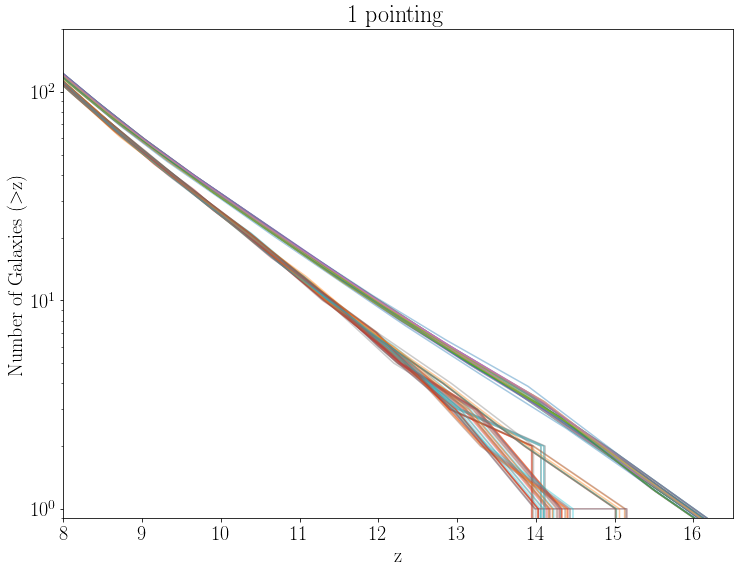

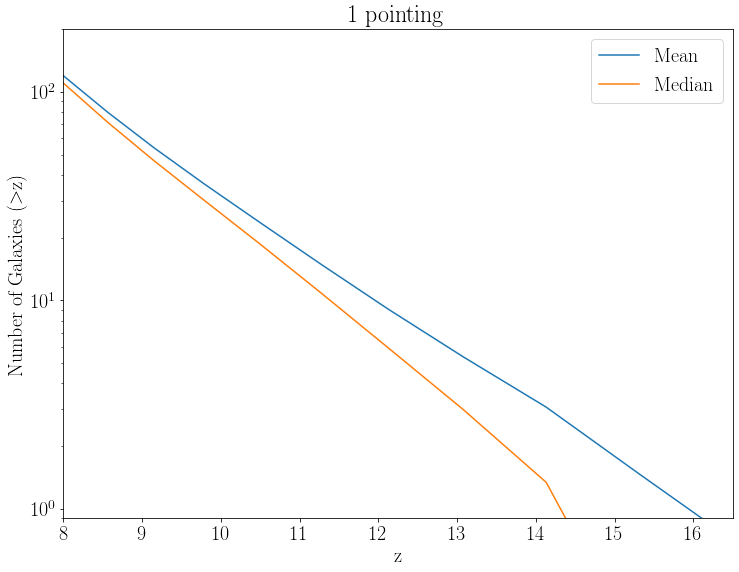

In [20]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design assuming 35 parallel pointings of JWST
    # Uses limiting magnitude from JADES Deep, area of one JWST pointing

    parallel_35 = survey(32.2, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 1)
    mean_35, med_35, z_vals_35 = mean_median(parallel_35)
    summed+=med_35
    summean+=mean_35

    ax.plot(z_vals_35, mean_35, alpha=0.4, label = "Mean")
    ax.plot(z_vals_35, med_35, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e2), xlim=(8,16.5), title='1 pointing')
winsound.Beep(400,300)
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e2), xlim=(8,16.5), title='1 pointing')
if save==1:
    plt.savefig("figs/"+file+"/1.pdf")
mean1final=summean/N
med1final=summed/N    
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

-2.0296936583988425
-1.9311272048322508
-1.845079965145744
-1.7695399228228785
-1.7028527531723587
-1.6436771118498894
-1.5909399233800348
-1.54372460246086
-1.5012710539639316
-1.462975672934317
-1.4283242773733698
-1.3968473967605866
-1.3681649835317509
-1.3419640573398604
-1.3179539935769846
-1.2959112348524078
-1.275634579514486
-1.2569228259115741
-1.2396194838701722
-1.22359041895585
-1.2087014967341785
-1.1948409385097996
-1.1819416770654985
-1.169914289444989
-1.158669352691985
-1.1481397995892713
-1.1382585629196333
-1.1289809312049282
-1.1202621929670122
-1.1120576367277428
-1.1043225510089765
-1.0970122243325702
-1.0901043009594524
-1.0835764251505513
-1.077383885427724
-1.0715043260518988
-1.065915391284004
-1.0605947253849681
-1.0555423283547913
-1.050735844454402
-1.0461529179447282
-1.0417711930866989
-1.0375906698803135
-1.0336113483255724
-1.0297885169443324
-1.0261221757365935
-1.0226123247023557
-1.0192366081025472
-1.0159950259371682
-1.0128875782062188
-1.009891909

  2%|█▋                                                                                 | 1/50 [01:00<49:17, 60.35s/it]

-2.0345654038208223
-1.9355504229188192
-1.8491116246671053
-1.773227836854026
-1.7062372067722218
-1.6467922862805908
-1.593815116866251
-1.5463849422994491
-1.5037382086335604
-1.4652685642050889
-1.4304594872266123
-1.3988393708487443
-1.3700264380981728
-1.3437062844086407
-1.319586962682909
-1.297443898230794
-1.2770749738311307
-1.2582780722627533
-1.2408959912425332
-1.2247939859563604
-1.2098373115901246
-1.1959136807987338
-1.1829557211751331
-1.170873602843249
-1.1595774959270078
-1.1490000280193544
-1.139073826713234
-1.1297539770706098
-1.1209955641534446
-1.112753673023702
-1.1049833887433451
-1.0976397963743376
-1.0907004384476606
-1.084142857494296
-1.0779221385762068
-1.072015824224375
-1.066401456969782
-1.0610565793434092
-1.0559811913452573
-1.0511528355063073
-1.0465490543575409
-1.04214739042994
-1.0379478437235043
-1.0339504142382343
-1.0301101870360925
-1.0264271621170795
-1.0229013394811952
-1.019510261659421
-1.016253928651757
-1.0131323404582033
-1.01012303960

  4%|███▎                                                                               | 2/50 [01:49<45:32, 56.92s/it]

-2.030814969898834
-1.932145280465896
-1.8460079172027126
-1.770388756260572
-1.7036317402527577
-1.6443941199467957
-1.5916016959567072
-1.5443369229736352
-1.5018389097658444
-1.4635034191787222
-1.428815730673153
-1.3973058820177717
-1.3685934275967104
-1.3423650592557255
-1.3183298479944474
-1.2962640022741305
-1.275966109709904
-1.2572347579168968
-1.2399132928179868
-1.223867439489927
-1.2089629230094694
-1.1950878476072417
-1.1821750758216203
-1.1701350910371067
-1.1588783766382027
-1.1483377951632847
-1.1384462091507288
-1.1291588602927862
-1.1204309902817076
-1.1122178408097438
-1.1044746535691459
-1.0971566702521645
-1.0902415117049253
-1.0837067987735536
-1.0775077731503002
-1.0716220556812908
-1.0660272672126507
-1.0607010285905052
-1.0556433398148546
-1.050831821731824
-1.0462440951875391
-1.041857781028125
-1.0376728792535823
-1.0336893898639106
-1.0298625545513607
-1.0261923733159328
-1.0226788461576266
-1.019299593922568
-1.0160546166107567
-1.0129439142221928
-1.009945

  6%|████▉                                                                              | 3/50 [02:41<43:29, 55.52s/it]

-2.0047681757468503
-1.908496538380485
-1.8244526435691584
-1.7506713184022389
-1.6855367540420967
-1.6277388352149773
-1.576229469701878
-1.530113412065733
-1.488648263651415
-1.451244472585735
-1.4173998280137536
-1.386655789589657
-1.3586411579858813
-1.3330502396385508
-1.309599176238352
-1.2880696152396593
-1.2682650393514097
-1.2499889312825396
-1.2330884442511114
-1.2174325667297496
-1.202890287191079
-1.1893524293622864
-1.1767534874796843
-1.1650061205250224
-1.1540229874800503
-1.1437385825810806
-1.1340874000644252
-1.125025769420959
-1.1165100201415574
-1.1084964817170948
-1.100941483638446
-1.093801355396486
-1.0870542617366523
-1.0806783674043823
-1.0746300018905508
-1.0688873299405952
-1.063428516299953
-1.0582317257140617
-1.0532969581829212
-1.048602378451969
-1.0441261512666422
-1.039846441372379
-1.0357632487691786
-1.0318765734570412
-1.028142744926842
-1.0245617631785808
-1.0211336282122576
-1.0178365047733096
-1.014670392861737
-1.0116352924775402
-1.0087093683661

  8%|██████▋                                                                            | 4/50 [03:37<42:46, 55.80s/it]

-2.0247404298296696
-1.9266300055132501
-1.8409808734665505
-1.7657903260033658
-1.6994116923594829
-1.640509834077432
-1.588016640391237
-1.5410197666882937
-1.4987626345093683
-1.4606444315486002
-1.4261533547306258
-1.39482210559533
-1.3662723949130968
-1.340192690377183
-1.3162937119884703
-1.2943529366707136
-1.2741700936552922
-1.255544912173586
-1.2383216260722232
-1.2223667215054568
-1.20754668462754
-1.1937502539003502
-1.1809106724010137
-1.1689389308990328
-1.1577460201639094
-1.14726518327277
-1.1374296633027412
-1.1281949556385737
-1.1195165556650188
-1.1113499587668274
-1.1036506603287506
-1.096374155735539
-1.0894981926795686
-1.0830005188532148
-1.0768366296412282
-1.0709842727359848
-1.0654211958298598
-1.0601251466152288
-1.055096125092092
-1.0503118789528245
-1.0457501558898021
-1.0413887035954001
-1.0372275220696188
-1.0332666113124578
-1.0294614667086683
-1.0258120882582502
-1.0223184759612038
-1.0189583775099043
-1.015731792904352
-1.0126387221445463
-1.0096569129

 10%|████████▎                                                                          | 5/50 [04:28<40:45, 54.35s/it]

-2.0335444205674693
-1.934623438603929
-1.8482667002102646
-1.7724549519556034
-1.7055279187967827
-1.6461394317798876
-1.5932125557417858
-1.5458274085639685
-1.5032211611725503
-1.4647880375382694
-1.4300120062287918
-1.398421908110247
-1.369636328645692
-1.3433411617458806
-1.3192447374707972
-1.297122694328123
-1.2767731069747708
-1.2579940500676527
-1.2406284705621458
-1.2245417515628585
-1.209599276174399
-1.1956888636506078
-1.1827432055437894
-1.1706725572570158
-1.1593871741933595
-1.1488197479051248
-1.1389029699446156
-1.1295919680133684
-1.120841869812919
-1.1126078030448041
-1.1048448954105594
-1.097508274611721
-1.0905755044990575
-1.0840241489233367
-1.0778093355860945
-1.0719086283380992
-1.066299591030119
-1.0609597875129217
-1.0558892177865076
-1.0510654457016444
-1.0464660351091006
-1.0420685498596443
-1.0378729899532748
-1.033879355389993
-1.0300427738713345
-1.0263632453972993
-1.0228407699678879
-1.0194529114338677
-1.0161996697952391
-1.013081045052002
-1.0100746

 12%|█████████▉                                                                         | 6/50 [05:21<39:21, 53.67s/it]

-2.0284902202902924
-1.9300345637464116
-1.8440840484283358
-1.7686289194962033
-1.7020167118594611
-1.6429075889582019
-1.5902296815444994
-1.54306743463575
-1.5006616075146728
-1.4624092737293095
-1.4277968292650285
-1.396355331325862
-1.3677051595531702
-1.3415336854163074
-1.3175506109939603
-1.2955326301928114
-1.275278767528874
-1.256588047518162
-1.2393041558953535
-1.223293109004457
-1.2084209231894822
-1.1945759454037699
-1.1816911838193245
-1.1696773159988192
-1.1584450195049267
-1.1479273025096517
-1.1380571731849987
-1.128789970312304
-1.1200810326729043
-1.1118856990481358
-1.104159308219335
-1.0968571989678384
-1.089957040684314
-1.08343650275943
-1.0772509239745232
-1.0713779737202611
-1.0657953213873126
-1.0604806363663457
-1.05543391865736
-1.0506328376510243
-1.0460550627380065
-1.041678263308975
-1.0375024393639294
-1.03352759090287
-1.0297090567071332
-1.026046836776719
-1.0225409311116274
-1.0191690091025263
-1.0159310707494162
-1.0128271160522968
-1.00983481440183

 14%|███████████▌                                                                       | 7/50 [06:13<38:11, 53.28s/it]

-2.0150847249732573
-1.917863273128844
-1.8329902025574798
-1.7584809519831386
-1.69270377102331
-1.6343356188273108
-1.5823180627145934
-1.5357470247705245
-1.4938727818463828
-1.4560999655593612
-1.4219214102500302
-1.3908740516206508
-1.3625830280968627
-1.3367396301468397
-1.3130571989196
-1.2913152276066966
-1.2713152600805269
-1.2528588402134881
-1.2357916132396674
-1.2199812750739962
-1.2052955216314063
-1.191624099507674
-1.178900856660265
-1.1670375903658003
-1.1559460979009013
-1.1455602272230336
-1.135813826289663
-1.1266627937391005
-1.1180630282096558
-1.10997042833964
-1.1023408927673637
-1.095130320131137
-1.0883166597501155
-1.0818778609434545
-1.0757698223494645
-1.0699704932873004
-1.0644578230761181
-1.0592097610350724
-1.0542263071641635
-1.0494854107825466
-1.044965021209377
-1.0406430877638102
-1.0365196104458456
-1.0325945892554838
-1.028823922831035
-1.0252076111724995
-1.0217456542798768
-1.0184160014723227
-1.0152186527498368
-1.0121536081124194
-1.00919881687

 16%|█████████████▎                                                                     | 8/50 [07:02<36:26, 52.07s/it]

-2.0039028625130415
-1.9077108920022772
-1.8237365453259486
-1.7500162757963789
-1.6849356116925887
-1.6271855218894602
-1.575718781486899
-1.5296408858827402
-1.4882100507727514
-1.4508372121506286
-1.4170205747517433
-1.3863019776823042
-1.3583105287901946
-1.3327407874795538
-1.3093091303399391
-1.2877973855171643
-1.2680091983424617
-1.2497482141470637
-1.23286171263304
-1.2172187906878782
-1.2026885451990668
-1.1891618902395127
-1.1765733742529598
-1.164835728497734
-1.1538616842321603
-1.1435857898999828
-1.133942593944946
-1.124888461996212
-1.1163797596829441
-1.1083728526343049
-1.100824106479457
-1.093689886847563
-1.0869483765532046
-1.080577758410963
-1.074534398050001
-1.0687964782849
-1.063342181930241
-1.0581496918006057
-1.053219007895994
-1.0485283130309875
-1.044055790020167
-1.0397796216781146
-1.0356998080048296
-1.0318163490003125
-1.028085610293726
-1.0245075918850697
-1.0210822937743438
-1.0177878987761297
-1.0146244068904275
-1.0115918181172372
-1.00866831527114

 18%|██████████████▉                                                                    | 9/50 [07:55<35:47, 52.38s/it]

-2.0226337206803064
-1.9247172549063398
-1.8392374461596863
-1.764195545989527
-1.6979481390029674
-1.6391627262327952
-1.5867733085052413
-1.5398693448593765
-1.4976957525471148
-1.4596529070332105
-1.425230017046899
-1.3939607079496559
-1.3654674383674381
-1.3394392918745623
-1.3155875603614666
-1.2936901606669484
-1.273547217945926
-1.254958857353318
-1.2377696206762823
-1.2218462580180982
-1.2070555194820443
-1.1932863634875197
-1.1804721650861636
-1.1685240910134955
-1.1573533080050344
-1.1468931911124196
-1.137077115387291
-1.1278606641974074
-1.1191994209105292
-1.1110489688944152
-1.1033648915168257
-1.09610277214552
-1.0892404024643778
-1.0827555741572792
-1.0766038705919836
-1.0707630834523707
-1.0652110044223204
-1.0599254251857126
-1.0549063457425472
-1.0501315577767039
-1.0455788529720627
-1.0412260230125032
-1.0370730678980258
-1.0331199876286299
-1.0293223655720756
-1.0256802017283626
-1.022193496097491
-1.0188400403633406
-1.0156198345259115
-1.0125328785852037
-1.00955

 20%|████████████████▍                                                                 | 10/50 [08:50<35:25, 53.13s/it]

-2.008954216557296
-1.9122971826712025
-1.8279168416805986
-1.7538401536558519
-1.6884448413214868
-1.630415544724415
-1.5786999759021665
-1.5323993055534642
-1.4907681630382243
-1.4532146363775582
-1.4192345042561147
-1.3883673906903131
-1.360240610360112
-1.3345472459431236
-1.311002302782846
-1.2893865542204308
-1.2695026962629152
-1.2511534249173357
-1.2341852815224987
-1.2184667300830956
-1.2038662346038174
-1.1902741817552398
-1.177624803539709
-1.1658304092936853
-1.1548033083536298
-1.1444777327218878
-1.1347879144008053
-1.1256900080586123
-1.1171401683635396
-1.109094549983817
-1.1015093075876754
-1.0943405958433452
-1.0875664920849413
-1.081165073646579
-1.0750924951964889
-1.0693268340687858
-1.0638461675975852
-1.0586285731170022
-1.053674050627037
-1.0489606774618045
-1.04446653095542
-1.0401696884419986
-1.0360701499215408
-1.032167915394046
-1.0284191395277447
-1.0248238223226371
-1.0213819637787231
-1.018071641230118
-1.0148928546768217
-1.0118456041188342
-1.008907966

 22%|██████████████████                                                                | 11/50 [09:37<33:13, 51.11s/it]

-2.0178721055315165
-1.9203940277211955
-1.8352969259992802
-1.7605910006372765
-1.6946401940806453
-1.6361179731770572
-1.5839631114046493
-1.537269144442663
-1.495284370171445
-1.4574118486724477
-1.4231430755706111
-1.3920137642626202
-1.3636480636886483
-1.3377364494464856
-1.3139915060197938
-1.2921921445498512
-1.2721393850638087
-1.253634247588817
-1.2365219699237708
-1.2206698987534375
-1.205945380762584
-1.1922378715218493
-1.1794810443736172
-1.1675864637743991
-1.1564656941807063
-1.1460524089349224
-1.136280281379431
-1.1271050937424876
-1.1184826282523481
-1.1103686671372681
-1.1027189926255034
-1.0954893869453095
-1.0886577412108143
-1.0822019465361457
-1.0760777851495593
-1.0702631481651832
-1.0647359266971452
-1.059474011859573
-1.0544774036524664
-1.0497239931899536
-1.0451916715861622
-1.0408583299552203
-1.0367239682971279
-1.0327885866118847
-1.0290079671277466
-1.0253821098447136
-1.0219110147627855
-1.0185725729960904
-1.0153667845446284
-1.0122936494083992
-1.009

 24%|███████████████████▋                                                              | 12/50 [10:38<34:18, 54.18s/it]

-2.012821659779935
-1.915808561721096
-1.831117381310919
-1.7567678103558688
-1.6911315954523722
-1.6328885311380728
-1.580982453043085
-1.534511220768132
-1.4927267178845451
-1.4550348519342637
-1.4209295441567176
-1.3899487226400824
-1.3617183291700232
-1.335930315805324
-1.3122986380291406
-1.290603261597747
-1.2706461556917894
-1.2522292894919145
-1.235198639027514
-1.2194221837523525
-1.204767903120194
-1.1911257800091757
-1.1784298041461794
-1.1665919618337153
-1.1555242393742922
-1.1451606264947927
-1.135435112922099
-1.1263036918074656
-1.1177223563021477
-1.1096470995573997
-1.1020339147244764
-1.094838794954633
-1.0880397368234964
-1.0816147369066942
-1.075519788355481
-1.0697328877454846
-1.064232031652332
-1.0589952166516508
-1.0540224427434408
-1.0492917065033296
-1.0447810045069446
-1.040468333329913
-1.0363536929722348
-1.03243708343391
-1.0286744978661937
-1.0250659362690857
-1.0216113986425859
-1.0182888815623217
-1.015098385028293
-1.0120399090405003
-1.00909145017457

 26%|█████████████████████▎                                                            | 13/50 [11:20<31:05, 50.43s/it]

-2.0220517337657573
-1.9241888498228221
-1.8387558173219472
-1.7637549815670872
-1.6975438264748268
-1.6387905822478026
-1.5864298330481237
-1.539551536180925
-1.4974010220943672
-1.4593789943796365
-1.4249749412810768
-1.3937227433696109
-1.3652450658693192
-1.3392311624941502
-1.3153924831213417
-1.293507066118
-1.2733751460145202
-1.254796957341298
-1.2376171269553076
-1.2217024778768124
-1.2069198331260766
-1.1931582118866526
-1.1803510256686727
-1.1684094898189792
-1.1572448196844143
-1.14679042677511
-1.1369797226011982
-1.1277683148361
-1.1191118111532365
-1.1109658192260292
-1.103285946727899
-1.0960278013322675
-1.0891691868758449
-1.0826879071953421
-1.0765395699641802
-1.0707019790190697
-1.0651529381967213
-1.0598702513338456
-1.0548539184304428
-1.0500817433232232
-1.0455315298488976
-1.0411810818441765
-1.03703039930906
-1.033079482243548
-1.0292839383210617
-1.0256437675416012
-1.0221589699051665
-1.018807349248468
-1.015588905571506
-1.0125036388742803
-1.00952935299350

 28%|██████████████████████▉                                                           | 14/50 [12:22<32:21, 53.94s/it]

-2.014834799885043
-1.9176363579116638
-1.832783374660238
-1.7582917585504516
-1.6925301453940467
-1.6341758074708135
-1.582170562604585
-1.535610546853218
-1.493746214508594
-1.4559823380966188
-1.4218118719912123
-1.3907718614903009
-1.3624875337398257
-1.3366502522717376
-1.3129734260799915
-1.2912366005445521
-1.2712413665073883
-1.2527893148104687
-1.235726127219769
-1.219919530963268
-1.2052372532689448
-1.1915690668267822
-1.1788488352507696
-1.166988376692893
-1.1558995093051385
-1.1455160967014955
-1.135772002495954
-1.1266231357645062
-1.1180254055831458
-1.1099347210278658
-1.1023069911746588
-1.0950981250995182
-1.0882860773404404
-1.0818488024354218
-1.0757422094604556
-1.0699442529535383
-1.0644328874526663
-1.059186067495836
-1.0542037930830477
-1.049464018752298
-1.0449446990415827
-1.0406237884888991
-1.0365012870942467
-1.032577194857626
-1.0288074208550295
-1.0251919650864574
-1.0217308275519097
-1.018401962789383
-1.0152053707988773
-1.0121410515803924
-1.0091869596

 30%|████████████████████████▌                                                         | 15/50 [13:04<29:25, 50.44s/it]

-2.038230126292626
-1.938877745123794
-1.852144400801083
-1.7760020338313658
-1.7087831286314055
-1.6491356455391175
-1.5959779528248341
-1.548386156719465
-1.5055941014144953
-1.4669933690619872
-1.4320656777914746
-1.4003378137212286
-1.3714266989469914
-1.3450168575476105
-1.3208153475963005
-1.298596829149381
-1.2781584962575392
-1.2592975429714623
-1.241856231330574
-1.2256993573686663
-1.21069171711953
-1.1967206406113249
-1.183718525860947
-1.1715952368909242
-1.1602606377237836
-1.1496471263764214
-1.1396871008657332
-1.1303354932029832
-1.121547235399435
-1.1132772594663523
-1.1054804974149992
-1.0981118812566395
-1.091148876996905
-1.0845689506414278
-1.0783270342014717
-1.0724005936826686
-1.0667670950906505
-1.0614040044310493
-1.0563113217038649
-1.0514665129147294
-1.0468470440692745
-1.0424303811731321
-1.0382165242263026
-1.0342054732287858
-1.0303521601918453
-1.0266565851154814
-1.0231187479996942
-1.019716114850115
-1.0164486856667445
-1.0133164604495826
-1.010296905

 32%|██████████████████████████▏                                                       | 16/50 [13:58<29:09, 51.46s/it]

-2.0002972432380055
-1.9044372315358116
-1.820752680607768
-1.7472868199723148
-1.6824307494557247
-1.624879955403625
-1.5735908268925172
-1.5276719462585788
-1.4863840890976654
-1.4491402242653095
-1.4154402881940007
-1.3848277011047085
-1.3569328507953606
-1.3314513507466033
-1.3081005563333221
-1.2866630486131219
-1.2669431505378461
-1.2487451850593394
-1.2319169589179246
-1.2163280207481644
-1.2018479191846212
-1.1883679447560977
-1.175822871779875
-1.1641257326789949
-1.1531895598764992
-1.1429491276896693
-1.1333392104357864
-1.1243163243263714
-1.1158369855729453
-1.107857710387029
-1.1003350149801432
-1.093225415563809
-1.086507170243787
-1.080158537125837
-1.0741360324214806
-1.0684179142364778
-1.0629824406765893
-1.0578078698475755
-1.0528942017494363
-1.048219694487932
-1.0437626061688237
-1.039501194897871
-1.0354354606750744
-1.0315654035004338
-1.02784753958547
-1.0242818689301831
-1.020868391534573
-1.0175853655044005
-1.014432790839665
-1.0114106675403671
-1.0084972537

 34%|███████████████████████████▉                                                      | 17/50 [14:53<28:53, 52.54s/it]

-1.9980522818075679
-1.9023989571305113
-1.8188948413033414
-1.7455873829037556
-1.680871150762304
-1.6234444439307847
-1.5722659016506357
-1.5264460282739192
-1.4852471932633202
-1.448083631192148
-1.414456356696925
-1.3839097744457804
-1.3560750691700574
-1.3306485106485082
-1.3073480636756891
-1.2859567780935668
-1.2662793987599104
-1.24812067053249
-1.231328728300682
-1.215773401969666
-1.2013245214446218
-1.1878736116465327
-1.1753555875279884
-1.1636836690257755
-1.1527710760766805
-1.1425527236332935
-1.132963526648204
-1.1239600950898057
-1.1154990389264916
-1.107536968126655
-1.100030492658689
-1.092936222490987
-1.086232462607746
-1.079897517993162
-1.0738879986156287
-1.0681822094593425
-1.0627584555085
-1.0575950417472981
-1.0526919681757365
-1.048027539778012
-1.0435800615383213
-1.0393278384408609
-1.0352708704856308
-1.031409157672631
-1.0276993099702547
-1.024141327378502
-1.020735209897373
-1.0174592625110643
-1.0143134852195757
-1.0112978780229074
-1.0083907459052557


 36%|█████████████████████████████▌                                                    | 18/50 [15:30<25:31, 47.87s/it]

-2.031034167025002
-1.932344296754517
-1.846189315881055
-1.7705546886086654
-1.7037840188384552
-1.6445342827064588
-1.5917310611215023
-1.5444566211098754
-1.50194991581533
-1.4636065844990815
-1.4289118013466091
-1.3973955080055245
-1.3686771810477036
-1.3424434482382215
-1.3184033210732178
-1.296332962242032
-1.2760309181650693
-1.257295735262734
-1.239970727417564
-1.223921592243162
-1.209014027353132
-1.195136114092143
-1.182220701266997
-1.1701782539534291
-1.158919237227175
-1.1483764998950368
-1.1384828907638156
-1.1291936423713793
-1.120463987255596
-1.1122491579543332
-1.1045043870054587
-1.0971849069468402
-1.090268334047412
-1.0837322845761075
-1.0775319910707946
-1.0716450698004074
-1.0660491370338796
-1.0607218090401451
-1.055663085819204
-1.05085058363999
-1.0462619187714373
-1.0418747074824795
-1.0376889497731165
-1.0337046456433487
-1.0298770276310438
-1.0262060957362016
-1.022691849958822
-1.0193119065678393
-1.016066265563253
-1.0129549269450637
-1.0099555069822048


 38%|███████████████████████████████▏                                                  | 19/50 [16:38<27:57, 54.11s/it]

-2.0020102450207085
-1.905992522260444
-1.8221702916176095
-1.7485835632876177
-1.6836207900978084
-1.625975312178457
-1.574601801633784
-1.5286073742194772
-1.487251589342693
-1.449946450062055
-1.4161910700941687
-1.3855281184846309
-1.3575873749370193
-1.3320639521483983
-1.3086747404803276
-1.287201963287853
-1.2674496215905158
-1.2492217164078572
-1.2323658040884096
-1.2167512186452003
-1.202247294091257
-1.1887451421041026
-1.1761794296902508
-1.16446304619172
-1.1535088809505285
-1.1432516009731901
-1.1336258732662188
-1.1245881425006234
-1.1160948533474135
-1.1081024504775978
-1.100567378562186
-1.0934460822721868
-1.086716783943105
-1.080357705910445
-1.0743252928452163
-1.0685977670829234
-1.063153350959071
-1.057970266809163
-1.0530485146332005
-1.0483663167666872
-1.043901895545128
-1.0396334733040276
-1.0355610500433858
-1.0316846257632029
-1.0279606451344876
-1.0243891081572403
-1.0209700148314609
-1.017681587492654
-1.0145238261408194
-1.0114967307759575
-1.0085785237335

 40%|████████████████████████████████▊                                                 | 20/50 [17:13<24:05, 48.20s/it]

-2.004703843167739
-1.908438128713552
-1.8243994045279845
-1.7506226186035807
-1.6854920615119862
-1.6276976985815637
-1.5761915020750026
-1.530078281633351
-1.4886156842760134
-1.451214194400753
-1.417371632050109
-1.3866294850890077
-1.358616577027152
-1.3330272331078263
-1.309577612485509
-1.2880493760482605
-1.2682460185953353
-1.2499710349259874
-1.2330715876618594
-1.2174166733357872
-1.2028752884806073
-1.1893382635403498
-1.1767400967814325
-1.16499345255908
-1.154010995228516
-1.143727223056159
-1.134076634308427
-1.125015561162932
-1.116500335797286
-1.1084872903891012
-1.1009327571159897
-1.0937930681555634
-1.0870463895966287
-1.0806708875279911
-1.074622894127263
-1.0688805754832507
-1.0634220976847597
-1.0582256268205963
-1.0532911628907604
-1.0485968719840582
-1.0441209201892956
-1.0398414735952786
-1.0357585322020073
-1.0318720960094818
-1.028138497195314
-1.024557735759504
-1.0211298117020515
-1.017832891111763
-1.0146669739886383
-1.0116320603326772
-1.008706316232686

 42%|██████████████████████████████████▍                                               | 21/50 [18:13<25:05, 51.91s/it]

-2.002136169770625
-1.9061068534873722
-1.822274501848851
-1.7486788883943012
-1.6837082713670972
-1.626055833126732
-1.5746761195608006
-1.5286761386149557
-1.4873153602929106
-1.450005716656437
-1.4162462609433408
-1.3855796069794442
-1.3576354897666039
-1.3321089851887014
-1.3087169494236268
-1.287241579531296
-1.2674868528656327
-1.2492567467805604
-1.232398799218021
-1.2167823284139627
-1.2022766526043356
-1.188772870319097
-1.1762056406762218
-1.164487842499676
-1.1535323546134262
-1.1432738361354466
-1.133646946183712
-1.1246081241702055
-1.1161138095069103
-1.1081204416058095
-1.100584459878886
-1.0934623037381233
-1.0867321928895124
-1.0803723470390452
-1.0743392055987049
-1.0686109882744828
-1.0631659147723704
-1.0579822047983594
-1.05305985835245
-1.0483770951406333
-1.0439121348689013
-1.0396431972432452
-1.0355702822636652
-1.0316933899301612
-1.0279689596547164
-1.0243969914373308
-1.0209774852780042
-1.0176886608827285
-1.0145305182515032
-1.0115030573843289
-1.008584497

 44%|████████████████████████████████████                                              | 22/50 [19:03<23:56, 51.29s/it]

-2.037891752386241
-1.9385705243121332
-1.8518643762383662
-1.775745884593456
-1.708548056663072
-1.648919276732892
-1.5957782522314585
-1.5482013790873181
-1.5054227417290216
-1.4668341130851235
-1.4319173737984674
-1.4001994583690405
-1.371297409011118
-1.3448958487246916
-1.320701927438325
-1.2984903758662971
-1.2780584516514604
-1.259203412436666
-1.24176756972191
-1.2256157619357602
-1.210612827506784
-1.1966461317921215
-1.1836480940060568
-1.1715286064343011
-1.160197561362567
-1.149587378005138
-1.139630475576298
-1.130281800218903
-1.1214962980758088
-1.1132289152898716
-1.105434598003947
-1.098068292360891
-1.091107471432132
-1.0845296082890974
-1.0782896490746434
-1.0723650668601978
-1.0667333347171888
-1.0613719257170442
-1.056280839859764
-1.0514375502167763
-1.0468195298595089
-1.0424042518593897
-1.038191716216419
-1.0341819229305966
-1.0303298181447784
-1.0266354018589645
-1.0230986740731547
-1.0196971078587773
-1.016430703215832
-1.013299460144319
-1.0102808517156663
-

 46%|█████████████████████████████████████▋                                            | 23/50 [19:48<22:08, 49.21s/it]

-2.042774086241022
-1.9430033559855002
-1.8559047983185688
-1.7794418140742034
-1.7119398661603407
-1.6520412217996319
-1.5986596947701979
-1.5508675010075166
-1.507895258604424
-1.4691319878111129
-1.4340572243962666
-1.4021957618878125
-1.3731629093321684
-1.3466418624146201
-1.3223384457000749
-1.3000263703923078
-1.279501976574717
-1.2605616043307
-1.2430468515028992
-1.22682194481358
-1.2117511109850072
-1.1977212056190685
-1.1846643420768967
-1.1724900048400015
-1.1611076783898933
-1.1504494760877044
-1.1404475112945676
-1.1310565262512378
-1.1222312631984699
-1.1139264643770193
-1.1060968720276405
-1.098697228391089
-1.0917049045877423
-1.0850972717379777
-1.0788290720825502
-1.0728776767418375
-1.0672204568362171
-1.0618347834860664
-1.0567206566913856
-1.0518554475725521
-1.0472165272499434
-1.042781266843937
-1.0385496663545328
-1.0345217257817312
-1.0306521873662868
-1.0269410511081998
-1.0233883170074702
-1.0199713561844754
-1.0166901686392156
-1.0135447543716907
-1.0105124

 48%|███████████████████████████████████████▎                                          | 24/50 [20:54<23:31, 54.30s/it]

-2.035246359775352
-1.9361686852526112
-1.8496751562805023
-1.7737433208955304
-1.7067102741499338
-1.6472277147347163
-1.5942170016026807
-1.5467567955260129
-1.5040830590962817
-1.465589056724439
-1.4307579395753693
-1.399117802190924
-1.3702866258668878
-1.3439498069644944
-1.3198152135334618
-1.2976581286889568
-1.2772763072346303
-1.2584675039741327
-1.2410744170880812
-1.224962216445576
-1.2099960719157177
-1.1960636250560899
-1.1830974608012426
-1.171007692397243
-1.1597044330901578
-1.1491202678145371
-1.1391877815049316
-1.1298620307843743
-1.1210980722758985
-1.1128509626025382
-1.1050757583873265
-1.0977275162532971
-1.0907837645119665
-1.0842220314748514
-1.0779973737649855
-1.0720873196938852
-1.0664693975730675
-1.061121135714049
-1.0560425341168298
-1.0512111210929267
-1.0466044249538562
-1.0421999740111352
-1.0379977682647634
-1.0339978077147414
-1.030155148984102
-1.0264697920728456
-1.0229417369809721
-1.0195485120199983
-1.016290117189924
-1.0131665524907494
-1.01015

 50%|█████████████████████████████████████████                                         | 25/50 [21:24<19:34, 46.98s/it]

-2.0177542592943127
-1.9202870312419704
-1.8351994012185036
-1.760501790969271
-1.694558325040458
-1.63604261792897
-1.5838935612323324
-1.5372047915234306
-1.495224690350512
-1.4573563842371842
-1.4230914254072613
-1.39196557893466
-1.3636030355935045
-1.3376943054330723
-1.3139520049276934
-1.292155069826852
-1.272104542305084
-1.2536014645369256
-1.2364910915470158
-1.220640784785045
-1.2059179057007037
-1.1922119221687346
-1.1794565149139824
-1.1675632582362414
-1.1564437264353051
-1.146031600236019
-1.1362605603632279
-1.1270863939668292
-1.1184648881967194
-1.1103518302027957
-1.1027030071349548
-1.0954742061430938
-1.0886433208021606
-1.082188244687104
-1.0760647649478212
-1.07025077515926
-1.0647241688963691
-1.059462839734097
-1.0544667876724438
-1.0497139062863579
-1.0451820891507873
-1.0408492298406808
-1.0367153283560386
-1.0327803846968604
-1.0290001860130429
-1.0253747323045865
-1.0219040235714911
-1.018565953388705
-1.0153605217562285
-1.0122877286740612
-1.0093254677171

 52%|██████████████████████████████████████████▋                                       | 26/50 [22:33<21:26, 53.58s/it]

-2.0091115941497777
-1.9124400709695824
-1.8280470810125466
-1.7539592885820907
-1.6885541732165832
-1.6305161777849713
-1.578792856582413
-1.532485245569355
-1.4908478623715342
-1.4532887062799775
-1.4193034803944473
-1.3884317397190753
-1.36030074306673
-1.3346035271068324
-1.3110550544609876
-1.2894360656073536
-1.2695492269762723
-1.251197204998086
-1.234226518007505
-1.2185056102914242
-1.2039029261367384
-1.1903088357825264
-1.1776575613722355
-1.1658613990971287
-1.1548326451484696
-1.1445055216697053
-1.134814250804283
-1.1257149806478348
-1.1171638592959916
-1.1091170348443855
-1.1015306553886477
-1.0943608690244102
-1.0875857497994883
-1.081183371761698
-1.0751098830066712
-1.069343357582223
-1.06386186953617
-1.058643492916327
-1.0536882277226949
-1.0489741480030892
-1.0444793278053255
-1.0401818411772197
-1.036081688118772
-1.032178868629982
-1.0284295308064815
-1.0248336746482707
-1.0213913001553492
-1.018080481375533
-1.0149012183088222
-1.0118535109552165
-1.008915433362

 54%|████████████████████████████████████████████▎                                     | 27/50 [23:17<19:24, 50.64s/it]

-1.9992816329717997
-1.9035151255328746
-1.8199122026178325
-1.7465180024281917
-1.6817251941518676
-1.6242305365898733
-1.5729914367830184
-1.5271173465786616
-1.4858697626307102
-1.4486622263996196
-1.414995162092445
-1.3844124352895404
-1.3565447943178597
-1.3310881495643057
-1.307760132102431
-1.286343535065738
-1.2666428722743783
-1.248462657548504
-1.2316508460815665
-1.216077113753667
-1.2016111364449067
-1.1881443107220369
-1.175611474525108
-1.163925745107521
-1.1530002397226764
-1.1427697963106254
-1.1331692528114181
-1.1241551678517552
-1.115684100058337
-1.107712608057864
-1.1001972504770365
-1.0930945859425552
-1.0863828937677702
-1.0800404532660315
-1.0740238230640395
-1.0683112824751446
-1.0628811108126972
-1.0577115873900471
-1.0528027122071946
-1.0481327645774896
-1.0436800238142827
-1.039422769230924
-1.035361000827413
-1.0314947186037504
-1.0277804811866362
-1.0242182885760707
-1.0208081407720537
-1.0175283170879355
-1.0143788175237158
-1.011359642079395
-1.008449070

 56%|█████████████████████████████████████████████▉                                    | 28/50 [24:09<18:43, 51.08s/it]

-2.005222410349928
-1.9089089529337608
-1.8248285497596108
-1.751015174252868
-1.6858523156744085
-1.6280292896411597
-1.5764975486466626
-1.5303614583624834
-1.4888782976382144
-1.4514582585014728
-1.4175989119387467
-1.3868415184159606
-1.3588147173579106
-1.3332126824085462
-1.3097514319515347
-1.2882125185896973
-1.268399339665573
-1.250115292521701
-1.2332074639800559
-1.2175447856023303
-1.202996188950217
-1.1894524503251267
-1.1768480355079054
-1.1650955655396817
-1.1541076614615842
-1.143818789054459
-1.1341634140991528
-1.1250978471162292
-1.116578398626253
-1.1085613791497881
-1.1010030992073991
-1.0938598693196497
-1.0871098447468224
-1.080731180749199
-1.0746801878473442
-1.0689350213015398
-1.0634738363720677
-1.0582747883192105
-1.0533378771429678
-1.048641258103622
-1.044163086461455
-1.039881517476749
-1.035796551149504
-1.03190818747972
-1.0281727369879612
-1.0245901996742275
-1.0211605755385191
-1.0178620198411181
-1.0146945325820245
-1.011658113761238
-1.008730918639

 58%|███████████████████████████████████████████████▌                                  | 29/50 [25:07<18:38, 53.25s/it]

-2.026024346330766
-1.927795715581693
-1.8420433908474716
-1.7667622515185726
-1.7003036428716038
-1.6413308178335464
-1.588774378745984
-1.5417208817756864
-1.4994128369146094
-1.4612487079798937
-1.426716075260215
-1.3953470772800167
-1.3667629690352763
-1.3406518428756227
-1.3167240702685679
-1.2947568600352757
-1.2745497001147927
-1.2559020784461663
-1.2386580412042107
-1.2226839136816239
-1.207846021171104
-1.1940329680832324
-1.1811779170643586
-1.1691917516429475
-1.1579853553474648
-1.1474918908242593
-1.13764452071968
-1.1283986867979596
-1.1197098308233309
-1.1115333945600263
-1.1038248197722786
-1.0965395482243205
-1.0896553007982686
-1.0831497983762388
-1.076978482722464
-1.0711190747190604
-1.0655492952481447
-1.0602468651918326
-1.0552117845501248
-1.050421774205137
-1.045854555038986
-1.041487847933788
-1.0373216528895428
-1.0333559699062507
-1.0295462407481442
-1.0258924654152235
-1.0223946439074882
-1.019030497107055
-1.0158000250139239
-1.0127032276280945
-1.009717825

 60%|█████████████████████████████████████████████████▏                                | 30/50 [25:41<15:50, 47.52s/it]

-2.041191067860168
-1.9415660814715299
-1.854594756316196
-1.778243468267385
-1.7108401263764104
-1.6510289812254184
-1.5977254332801252
-1.5500030537716647
-1.5070935846965856
-1.4683869388168542
-1.4333634121889591
-1.401548492516652
-1.3725580507982074
-1.3460757455027925
-1.321807830923206
-1.2995283488231386
-1.2790339367899124
-1.260121232410849
-1.2426320649205325
-1.2264308593771773
-1.211382040838998
-1.19737263018784
-1.1843348399528106
-1.1721782868393864
-1.1608125875530437
-1.15016995462289
-1.1401826005780322
-1.1308053337712087
-1.1219929625551577
-1.1137002952826174
-1.1058821403063261
-1.0984933059790218
-1.0915111964770736
-1.0849132159768509
-1.0786541728310917
-1.072711471216165
-1.0670625153084399
-1.0616847092842858
-1.0565780531437023
-1.0517199510630588
-1.0470878072187244
-1.042659025787068
-1.0384336067680897
-1.0344115501617894
-1.0305476643209057
-1.026841949245438
-1.0232944049353867
-1.0198824355671208
-1.0166060411406403
-1.0134652216559452
-1.01043738128

 62%|██████████████████████████████████████████████████▊                               | 31/50 [26:51<17:09, 54.19s/it]

-1.9980676335008813
-1.9024128954383743
-1.8189075457439792
-1.745599004144249
-1.6808818157476835
-1.6234542603719848
-1.572274961871315
-1.5264544114544372
-1.4852549676847162
-1.4480908564801178
-1.414463085104095
-1.3839160514928428
-1.3560809349280445
-1.3306540007004968
-1.3073532094373685
-1.2859616077749436
-1.2662839376858772
-1.2481249411428248
-1.2313327507911849
-1.2157771946127278
-1.2013281005892238
-1.1878769920388146
-1.1753587829523853
-1.1636866919844495
-1.152773937789521
-1.142555434358484
-1.1329660956822247
-1.1239625310879993
-1.1155013499030644
-1.107539161454677
-1.1000325750700939
-1.0929382000765715
-1.0862343411377386
-1.0798993029172232
-1.0738896947422825
-1.0681838212765442
-1.0627599871836373
-1.0575964971271898
-1.052693351107202
-1.0480288537873022
-1.0435813098311184
-1.0393290239022794
-1.035271996000785
-1.0314102261266354
-1.027700323607087
-1.0241422884421398
-1.0207361206317944
-1.0174601248396786
-1.0143143010657927
-1.0112986493101364
-1.008391

 64%|████████████████████████████████████████████████████▍                             | 32/50 [27:26<14:33, 48.55s/it]

-2.013669606661307
-1.9165784406160835
-1.8318191078630637
-1.7574097066231433
-1.6917206732112806
-1.6334307397747403
-1.5814828920313335
-1.5349742636150232
-1.493156136075926
-1.4554339388803108
-1.4213011860179618
-1.3902954337404216
-1.3620423228227483
-1.336233557432637
-1.3125828628686609
-1.2908700278220313
-1.2708968621148373
-1.252465175569169
-1.2354208202688735
-1.219631669428677
-1.2049655962633066
-1.1913124951183671
-1.1786063026012217
-1.1667589341883549
-1.1556823053562506
-1.1453103527122723
-1.1355770128637832
-1.1264382435490252
-1.1178500025062408
-1.1097682474736716
-1.1021489361895602
-1.0949480263921485
-1.0881434969505577
-1.0817133267339087
-1.075613473480444
-1.069821916059284
-1.0643166333395502
-1.0590756041903637
-1.0540988286117245
-1.0493642854727536
-1.044849953642572
-1.0405338119903007
-1.03641586051594
-1.0324960992194896
-1.0287304858391917
-1.0251190203750464
-1.0216617028270536
-1.0183365120643344
-1.015143448086889
-1.0120825108947171
-1.00913167

 66%|██████████████████████████████████████████████████████                            | 33/50 [28:29<14:58, 52.87s/it]

-2.0198087152714765
-1.9221523394732358
-1.8368995859129211
-1.762057015302294
-1.6959855775599144
-1.6373563131602906
-1.5851060544830282
-1.5383266791857082
-1.4962651102038849
-1.458323315751087
-1.4239918613425426
-1.392805611144329
-1.364388026624224
-1.3384290172262796
-1.3146406417199719
-1.2928014068510527
-1.272711968690698
-1.2541729833100839
-1.2370294054312365
-1.2211483391016065
-1.206396888368645
-1.1926643066052272
-1.1798841458350786
-1.1679678087564997
-1.1568266980677915
-1.146394365792679
-1.1366043639548875
-1.1274123939035676
-1.1187741569878693
-1.110645354556943
-1.1029816879599388
-1.095738858546007
-1.0888947169897232
-1.0824271139656618
-1.0762917508229735
-1.0704664782362334
-1.0649291468800166
-1.0596576074288981
-1.054651859882878
-1.0498897549165316
-1.0453491432044337
-1.0410078754211598
-1.0368659515667096
-1.032923371641083
-1.0291358369934307
-1.0255033476237525
-1.0220259035320483
-1.0186813553928933
-1.0154697032062876
-1.012390946972231
-1.009422937

 68%|███████████████████████████████████████████████████████▊                          | 34/50 [29:22<14:04, 52.76s/it]

-2.019356591143103
-1.9217418410894385
-1.8365254262659967
-1.7617147570822063
-1.6956714820969303
-1.6370672082497881
-1.5848392210924749
-1.5380797853670631
-1.4960361450060042
-1.4581105231321265
-1.423793702405617
-1.3926207452553427
-1.3642152736475286
-1.3382673292014196
-1.3144890934205995
-1.2926591674616716
-1.2725782923655786
-1.2540472091732635
-1.2369109386943484
-1.2210366416227956
-1.2062914786525663
-1.1925647503619625
-1.179790037097965
-1.1678787793232153
-1.1567424175003547
-1.1463145319763637
-1.1365287030982236
-1.127340651097255
-1.1187060962047783
-1.1105807586521146
-1.102920358670584
-1.0956806164915074
-1.0888393922305453
-1.0823745460033578
-1.0762417980412653
-1.0704190084599285
-1.0648840373750077
-1.0596147449021631
-1.0546111310413946
-1.0498510559083627
-1.0453123796187276
-1.0409729622881496
-1.0368328039166288
-1.0328919045041651
-1.0291059842820791
-1.0254750432503712
-1.0219990814090407
-1.0186559588737485
-1.0154456756444945
-1.0123682317212785
-1.00

 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [30:06<12:32, 50.17s/it]

-2.019704399289035
-1.9220576275578367
-1.8368132582238874
-1.7619780480447722
-1.6959131081322831
-1.6372896096581435
-1.5850444895597318
-1.5382697148043927
-1.4962122823894355
-1.4582742193421363
-1.4239461412783219
-1.3927629581080958
-1.3643481683301126
-1.3383917118844415
-1.3146056758582887
-1.2927685887802753
-1.2726811263261593
-1.2541439641716996
-1.2370020722869304
-1.221122567789024
-1.206372567795153
-1.1926413365696271
-1.179862432671033
-1.1679472675108187
-1.1568072525004325
-1.1463759461984606
-1.136586907163489
-1.127395841101242
-1.1187584537174435
-1.1106304507178177
-1.102967537808089
-1.095725420693981
-1.0888819522283562
-1.082414985264076
-1.0762802255068655
-1.070455525809586
-1.0649187390250998
-1.0596477180062691
-1.0546424627530935
-1.0498808261184354
-1.0453406609551568
-1.0409998201161195
-1.036858303601324
-1.0329161114107697
-1.0291289492501812
-1.0254968171195582
-1.022019715018901
-1.0186754958010713
-1.0154641594660694
-1.012385706013895
-1.0094179882

 72%|███████████████████████████████████████████████████████████                       | 36/50 [31:07<12:28, 53.47s/it]

-2.0100136245981046
-1.9132590541158843
-1.8287935649378246
-1.7546421261400424
-1.6891808234073449
-1.6310929694571437
-1.579325214463368
-1.5329778221162487
-1.491304669622319
-1.453713247704414
-1.4196988262375414
-1.388800564672795
-1.3606454016134417
-1.3349261100268777
-1.3113574076685413
-1.2897198466580018
-1.2698159239028703
-1.2514481363107592
-1.2344628703653662
-1.218728457338432
-1.2041132285016984
-1.1905074599149494
-1.1778453172140555
-1.1660390212468443
-1.155000792861143
-1.1446647976928224
-1.134965201377753
-1.1258581143398483
-1.1172996470030223
-1.1092459097911886
-1.101653013128261
-1.094477067438153
-1.0876961279328214
-1.0812882498242236
-1.0752095435362727
-1.069438064280926
-1.0639518672701402
-1.058729007715872
-1.0537694856181214
-1.0490513561888457
-1.0445526746400011
-1.040251496183545
-1.0361478208194772
-1.0322416485477977
-1.0284890897924202
-1.0248901445533445
-1.0214448128305709
-1.0181311498360563
-1.0149491555698005
-1.0118988300318035
-1.008958228

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [31:47<10:44, 49.55s/it]

-2.001734994632023
-1.905742613369048
-1.8219425055257301
-1.7483751985881955
-1.6834295707117035
-1.6257993068870054
-1.5744393551067022
-1.5284570667811401
-1.487112196738412
-1.4498169032243555
-1.4160704321520918
-1.385415573268384
-1.3574822039872778
-1.3319655174732823
-1.3085824788077267
-1.2871153688224028
-1.2673682402659234
-1.2491451458869012
-1.23229368226759
-1.2166832179070655
-1.2021831213044025
-1.188684532875497
-1.1761221368698866
-1.164408845620288
-1.153457571459418
-1.143202998636814
-1.1335798114020135
-1.1245444659213752
-1.1160534183612572
-1.1080631248880182
-1.100530041668016
-1.0934106248676094
-1.0866831025699775
-1.0803257028582993
-1.0742948818989335
-1.068568867775059
-1.0631258885698553
-1.0579441723665013
-1.0530237191649972
-1.0483427570485218
-1.0438795141002546
-1.039612218403375
-1.0355408699578823
-1.0316654687637772
-1.0279424709874179
-1.0243718766288041
-1.0209536856879362
-1.0176661262479931
-1.014509198308975
-1.0114829018708815
-1.00856546501

 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [32:52<10:47, 53.93s/it]

-2.009694477933537
-1.9129692903501883
-1.8285294520629787
-1.7544005319350284
-1.6889591088093474
-1.6308888952613494
-1.5791368613513657
-1.5328035440059287
-1.491143047017773
-1.453563041045835
-1.4195589492440228
-1.3886700710137314
-1.3605234582513281
-1.3348119772244096
-1.3112504323243153
-1.289619442313614
-1.2697215640786181
-1.2513593545056396
-1.2343792467284767
-1.2186496120046706
-1.204038821591763
-1.190437184871038
-1.1777788874712667
-1.1659761768974763
-1.154941300654695
-1.1446084443716926
-1.1349117936772404
-1.125807472323852
-1.117251604064041
-1.1092003126503216
-1.1016097218352074
-1.0944359553712122
-1.087657075134593
-1.0812511430016065
-1.0751742827247666
-1.06940455618033
-1.0639200252445538
-1.058698751793695
-1.0537407358277533
-1.0490240392229857
-1.0445267238556493
-1.0402268516020008
-1.0361244224620403
-1.0322194364357675
-1.0284680172756968
-1.0248701649818277
-1.0214258795541602
-1.0181132228689513
-1.0149321949262011
-1.0118827957259096
-1.0089430871

 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [33:36<09:21, 51.05s/it]

-1.99696083264149
-1.9014079944931397
-1.817991602106431
-1.7447611552696713
-1.6801129093643574
-1.6227465309160287
-1.5716217531451153
-1.5258500148440686
-1.4846944603773604
-1.447569939681483
-1.413977991591226
-1.3834634993905284
-1.3556580352616254
-1.3302581880604762
-1.3069822188676146
-1.2856134054372963
-1.2659566977483525
-1.2478170457796138
-1.2310427439590597
-1.2155037589392441
-1.2010700573727209
-1.1876332781366181
-1.1751284045572128
-1.1634687477362076
-1.152567618775305
-1.1423600010007817
-1.132780877738915
-1.1237869045405557
-1.1153347369565558
-1.1073810305377658
-1.0998824408350376
-1.0927956233992222
-1.086098906005745
-1.0797706164300322
-1.0737674102229346
-1.0680676151598782
-1.0626495590162883
-1.0574915695675908
-1.0525936468137858
-1.0479341185302986
-1.043491312492555
-1.0392435564759805
-1.0351908504805754
-1.0313331945063393
-1.0276272441041239
-1.024072999273929
-1.0206704600157546
-1.0173979541050264
-1.0142554815417442
-1.0112430423259082
-1.0083389

 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [34:28<08:33, 51.40s/it]

-2.0326000587287525
-1.9337660213943941
-1.847485184537977
-1.77174006951126
-1.7048718605368007
-1.6455355718491063
-1.5926552148357813
-1.5453117158904048
-1.502742916412531
-1.4643435728076875
-1.4295981071991017
-1.398035774568851
-1.3692754956167117
-1.3430034403307358
-1.3189281951283995
-1.296825595715454
-1.2764938942270752
-1.2577313427984387
-1.2403810264235708
-1.2243084465259217
-1.2093791045289422
-1.195480918285508
-1.1825466385073442
-1.170486599476751
-1.1592111354760293
-1.1486529972169042
-1.138744935411101
-1.12944211719977
-1.1206997097240614
-1.1124728801251251
-1.104716795544112
-1.0973866231221714
-1.0904599464298792
-1.0839143490378103
-1.0777049980871145
-1.0718094771483673
-1.0662053697921439
-1.0608702595890191
-1.055804146538993
-1.0509846142126409
-1.0463892461805375
-1.0419956260132583
-1.0378037537108031
-1.0338136292731719
-1.029980419841515
-1.0263041254158325
-1.0227847459961241
-1.019399865152965
-1.0161494828863553
-1.013033599196295
-1.0100297976533

 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [35:22<07:49, 52.16s/it]

-2.0221092448033504
-1.9242410659875895
-1.8388034111311904
-1.76379851745497
-1.6975837800071554
-1.6388273569349576
-1.5864637747561465
-1.5395829415379818
-1.4974301468972175
-1.4594060620000984
-1.425000147469722
-1.3937462586576124
-1.365267040372146
-1.339251729514339
-1.31541176034942
-1.2935251592352581
-1.2733921498939347
-1.2548129560475314
-1.2376321961465564
-1.2217166860057307
-1.2069332414397755
-1.193170875627625
-1.1803629964766396
-1.168420814529967
-1.1572555403307545
-1.146800581786363
-1.1369893468041523
-1.1277774406556966
-1.1191204686125698
-1.1109740359463451
-1.1032937479285967
-1.0960352098308979
-1.0891762242890357
-1.082694593938797
-1.0765459240517556
-1.0707080172636982
-1.0651586762104117
-1.059875703527683
-1.054859099215512
-1.0500866659096855
-1.0455362062459905
-1.041185522860214
-1.0370346157523558
-1.0330834849224158
-1.0292877356419676
-1.0256473679110119
-1.0221623817295478
-1.0188105797333629
-1.0155919619224567
-1.0125065282968293
-1.00953208149

 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [36:08<06:42, 50.29s/it]

-2.0140565608655887
-1.9169297690798677
-1.832139335515967
-1.7577026311739505
-1.6919894944316494
-1.6336781726224405
-1.5817112636130246
-1.5351855697478753
-1.49335209784924
-1.4556160592171374
-1.421470781996029
-1.3904536527525964
-1.3621901748979628
-1.3363719394765827
-1.312712566744021
-1.290991764589174
-1.271011270112048
-1.2525728204126494
-1.2355222110132056
-1.2197272666470542
-1.2050558120475328
-1.1913977011590893
-1.1786868463483928
-1.1668351307710016
-1.1557544375824742
-1.1453786791494793
-1.1356417678386859
-1.1264996452278728
-1.1179082528948199
-1.1098235324173058
-1.10220142537311
-1.0949978733400116
-1.0881908471069002
-1.0817583174626657
-1.075656225985087
-1.0698625434630538
-1.0643552406854555
-1.059112288441182
-1.0541336867302333
-1.049397406341499
-1.0448814180638686
-1.0405636926862316
-1.0364442302085881
-1.0325230306309383
-1.0287560355310612
-1.0251432449089568
-1.021684658764625
-1.018358247886956
-1.0151640122759489
-1.0121019519316043
-1.00915003764

 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [37:05<06:05, 52.28s/it]

-2.000436107813003
-1.9045633112560165
-1.8208675993150227
-1.7473919405338803
-1.6825272201597612
-1.624968750555238
-1.573672781610368
-1.5277477767729093
-1.486454413048319
-1.4492055809997553
-1.4155011503662036
-1.3848844804745644
-1.3569859098275665
-1.33150101130981
-1.3081471025998523
-1.286706735758122
-1.266984207639005
-1.248783815096887
-1.2319533445740685
-1.216362327306806
-1.2018802945313576
-1.1883985222779367
-1.1758517761646727
-1.1641530770157367
-1.1532154456553003
-1.142973647701492
-1.1333624487724405
-1.1243383592802316
-1.1158578896369509
-1.107877550254684
-1.1003538515455171
-1.0932433039215355
-1.0865241625887823
-1.0801746827533003
-1.0741513748271754
-1.06843249401645
-1.0629962955271675
-1.0578210345653707
-1.0529067111310593
-1.0482315804302762
-1.0437738976690645
-1.039511918053467
-1.0354456415834838
-1.0315750682591145
-1.0278567084924453
-1.024290562283476
-1.0208766296322065
-1.01759316574468
-1.014440170620896
-1.011417644260855
-1.0085038418705996


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [37:57<05:14, 52.38s/it]

-2.021102084654417
-1.9233266321243718
-1.837969926116628
-1.7630360966543868
-1.696884095090058
-1.6381833414391105
-1.5858693717139172
-1.539032956258382
-1.4969200997479364
-1.4589320411895406
-1.4245587249224574
-1.3933344479521004
-1.3648822126161857
-1.3388915502516558
-1.3150741685285285
-1.2932083041160485
-1.273094370016536
-1.2545327792323109
-1.237368297431845
-1.2214678666166845
-1.2066984287883766
-1.1929491022815433
-1.180153358096958
-1.1682224909023189
-1.1570677953653234
-1.1466227424867452
-1.1368208032673577
-1.1276176250410097
-1.11896885514155
-1.1108301409028278
-1.1031571296586917
-1.095905468742991
-1.08905298182265
-1.082577492564593
-1.076434648302669
-1.0706022727038027
-1.0650581894349183
-1.0597802221629404
-1.0547683708878688
-1.0500004592766283
-1.0454543109961432
-1.0411077497133379
-1.0369607754282122
-1.0330133881407666
-1.0292212351848495
-1.0255843165604615
-1.0221026322676021
-1.0187540059731959
-1.015538437677243
-1.0124559273797433
-1.009484298747

 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [38:51<04:23, 52.76s/it]

-1.998156549500349
-1.9024936252021374
-1.8189811290298048
-1.7456663136059773
-1.6809435866425924
-1.6235111165547345
-1.5723274380744714
-1.526502966285444
-1.4852999966228666
-1.4481327048735275
-1.4145020555965424
-1.3839524077371907
-1.3561149090130797
-1.3306857987210627
-1.3073830133510742
-1.2859895809722954
-1.2663102268469886
-1.2481496762374167
-1.2313560487920059
-1.2157991613522652
-1.2013488307597024
-1.1878965710489084
-1.1753772906406372
-1.163704200762561
-1.1527905126423523
-1.1425711347007652
-1.132980975358554
-1.1239766402295548
-1.1155147349276038
-1.1075518650665368
-1.1000446362601906
-1.0929496541224006
-1.0862452214600857
-1.0799096410801634
-1.07389951859647
-1.0681931568159233
-1.0627688585454418
-1.0576049265919436
-1.0527013609554283
-1.0480364644428142
-1.0435885398610194
-1.0393358900169618
-1.0352785149106418
-1.031416414542059
-1.0277061945250496
-1.0241478548596137
-1.0207413955457514
-1.0174651193903805
-1.0143190263935014
-1.0113031165551136
-1.0083

 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [39:39<03:25, 51.33s/it]

-2.0338933648349555
-1.9349402565944966
-1.8485554723764146
-1.7727191029628266
-1.705770334107919
-1.646362559666437
-1.5934184947221772
-1.5460179584092153
-1.5033978739119074
-1.4649522684648888
-1.4301649430458117
-1.398564585503837
-1.369769657431143
-1.34346595072717
-1.3193617007271126
-1.2972324730734288
-1.2768762768443302
-1.2580911211180286
-1.2407199018442443
-1.2246279584084518
-1.2096806301961258
-1.1957657000284951
-1.1828158375982967
-1.1707412691625139
-1.1594522209781295
-1.1488813627378809
-1.1389613641345053
-1.1296473382964944
-1.1208943983523396
-1.1126576574305322
-1.1048922286595642
-1.0975532251679265
-1.0906182035198655
-1.0840647202796263
-1.077847888575701
-1.071945264972335
-1.0663344060337743
-1.0609928683242644
-1.0559206518438053
-1.0510953131566432
-1.0464944088270232
-1.0420954954191914
-1.037898572933148
-1.0339036413688927
-1.0300658138549172
-1.0263850903912213
-1.022861470977805
-1.0194725121789143
-1.016218213994549
-1.0130985764247091
-1.01009115

 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [40:31<02:34, 51.60s/it]

-2.0385229588372127
-1.9391436174334815
-1.8523867371742484
-1.7762237082327181
-1.7089865625290823
-1.6493228935121453
-1.59615077594095
-1.548546065338845
-1.5057423979934865
-1.4671311909568363
-1.4321940217176024
-1.4004575479828658
-1.3715385878964546
-1.3451215799297565
-1.3209135026633452
-1.298688955005355
-1.2782450759731065
-1.25937900458392
-1.2419329600734896
-1.2257717017866954
-1.2107599890684182
-1.1967851213727245
-1.1837794783720548
-1.1716528996296627
-1.1603152247088016
-1.1496988332819116
-1.1397361050214334
-1.1303819597089932
-1.1215913171262182
-1.113319097054735
-1.1055202192761706
-1.0981496035721514
-1.0911847098334913
-1.0846029979510032
-1.0783593877063145
-1.072431338990238
-1.0667963116935872
-1.061431765707176
-1.0563377010310036
-1.051491577555884
-1.0468708551726305
-1.0424529937720564
-1.0382379933541617
-1.0342258539189464
-1.0303714952480374
-1.0266749173414347
-1.023136120199138
-1.019732563711961
-1.0164642478799035
-1.013331172702966
-1.0103107980

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [41:21<01:42, 51.11s/it]

-2.0027622394131175
-1.9066752827311564
-1.822792611769744
-1.7491528234666487
-1.6841432086373698
-1.6264561652404201
-1.5750456116426097
-1.5290180197822556
-1.4876324151691813
-1.450300376884718
-1.4165206574796283
-1.3858355962393922
-1.3578747059189213
-1.332332879375202
-1.3089268028325787
-1.2874385426174701
-1.2676719584236533
-1.2494309099449048
-1.2325628436097182
-1.2169369992139445
-1.202422616553435
-1.1889107287913994
-1.176335955825763
-1.164611124187093
-1.1536490604059575
-1.143384384380282
-1.1337517160079917
-1.1247074685543712
-1.1162080552847033
-1.1082098894642725
-1.1006693843583624
-1.0935429532322563
-1.0868088027185965
-1.0804451394500247
-1.0744083766918249
-1.0686767210766388
-1.0632283792371082
-1.058041557805875
-1.0531162567829395
-1.048430682800943
-1.0439630424925281
-1.0396915424903361
-1.0356161827943673
-1.0317369634046214
-1.0280102975863825
-1.0244361853396506
-1.0210146266644253
-1.017723828193349
-1.014563789926421
-1.011534511863642
-1.008614200

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [42:14<00:51, 51.61s/it]

-2.002927377798198
-1.9068252173086857
-1.8229292736198373
-1.7492778333172603
-1.6842579320380098
-1.6265617608391576
-1.5751430725663613
-1.5291081977752863
-1.4877160447316065
-1.4503780994110045
-1.4165930350520242
-1.3859031185246407
-1.3579378039616912
-1.332391935943159
-1.308982155864743
-1.2874904955692885
-1.2677207837153561
-1.2494768489615067
-1.232606113597732
-1.2169777967297393
-1.2024611174632354
-1.1889470917196434
-1.1763703290518164
-1.1646436421968929
-1.153679843892011
-1.1434135436900241
-1.1337793511437857
-1.1247336726218653
-1.1162329144928316
-1.1082334831252536
-1.1006917848877007
-1.0935642261487415
-1.086829010092661
-1.0804643399037435
-1.0744266219505578
-1.068694059417389
-1.0632448554885212
-1.058057213348239
-1.0531311329965425
-1.0484448176177164
-1.0439764703960446
-1.0397042945158124
-1.0356282899770193
-1.0317484567796653
-1.0280212012923198
-1.0244465235149824
-1.0210244234476535
-1.0177331042746174
-1.014572565995874
-1.0115428086114235
-1.008622

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [43:06<00:00, 51.74s/it]


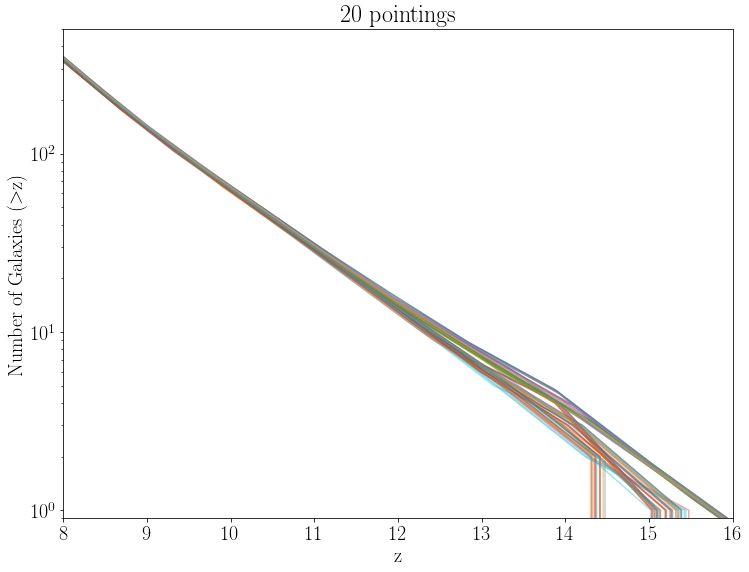

In [21]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design assuming 35 parallel pointings of JWST
    # Uses limiting magnitude from JADES Deep, area of one JWST pointing

    parallel_35 = survey(30.7, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 20)
    mean_35, med_35, z_vals_35 = mean_median(parallel_35)
    summed+=med_35
    summean+=mean_35

    ax.plot(z_vals_35, mean_35, alpha=0.4, label = "Mean")
    ax.plot(z_vals_35, med_35, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,5e2), xlim=(8,16), title='20 pointings')
winsound.Beep(400,300)

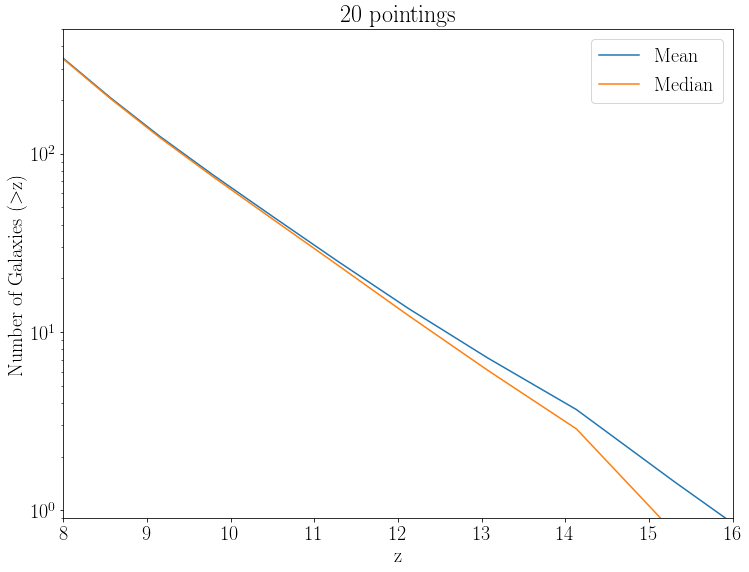

In [22]:
fig, ax =plt.subplots(figsize=(12,9))
mean20final=summean/N
med20final=summed/N  
ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,5e2), xlim=(8,16), title='20 pointings')
if save==1:
    plt.savefig("figs/"+file+"/20.pdf")

In [23]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9988331557469328
0.9995075023890074


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(15.113999999996057, 15.311, 15.730999999995715)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

-2.0204771523061296
-1.9227592354674456
-1.8374527573744328
-1.762563022514394
-1.696449947910222
-1.6377837365534527
-1.5855005508373141
-1.5386916961393555
-1.4966036208214466
-1.4586379162297782
-1.4242848268444392
-1.3930789237124668
-1.3646434310147957
-1.3386680627827847
-1.3148646963312658
-1.2930116988254954
-1.2729096007142033
-1.2543589324461204
-1.2372045510369252
-1.2213134767857716
-1.206552729991813
-1.1928114942376775
-1.1800232796729415
-1.1680994331637078
-1.1569513015760784
-1.14651239505963
-1.1367162237639399
-1.1275184611220588
-1.118874780567038
-1.1107408555319287
-1.1030723594497822
-1.0958249657536494
-1.0889765111600558
-1.0825048323855275
-1.0763656028631152
-1.0705366593093448
-1.0649958384407419
-1.0597209769738316
-1.0547120749086145
-1.0499469689616159
-1.0454034958493614
-1.0410594922883765
-1.0369149582786614
-1.032969893820216
-1.0291799723460915
-1.025545193856288
-1.0220655583508051
-1.018718902546169
-1.0155052264423792
-1.0124245300394359
-1.009454

  2%|█▋                                                                                 | 1/50 [00:48<39:48, 48.74s/it]

-2.002892082524013
-1.9067931715670419
-1.8229000646780922
-1.7492511147748027
-1.6842334120338989
-1.6265391917338077
-1.5751222420972701
-1.5290889238978775
-1.4876981704600714
-1.4503614876591435
-1.4165775656851576
-1.3858886868855622
-1.357924317922579
-1.332379313694507
-1.3089703251783384
-1.2874793915871448
-1.2677103482126897
-1.2494670303467372
-1.232596865438437
-1.2169690770156318
-1.2024528886061643
-1.1889393198165699
-1.17636298241077
-1.1646366920739928
-1.153673264491467
-1.1434073114271137
-1.1337734446448544
-1.1247280719873034
-1.1162276012970747
-1.1082284404167824
-1.100686997189041
-1.0935596794564646
-1.0868246911403603
-1.0804602361620352
-1.0744227223641034
-1.0686903536678722
-1.0632413339946487
-1.0580538672657398
-1.0531279534811457
-1.0484417965621735
-1.04397360043013
-1.039701569006323
-1.0356257022907518
-1.0317460002834165
-1.0280188708269316
-1.0244443139212969
-1.0210223295665126
-1.0177311216838856
-1.0145706902734157
-1.0115410353351035
-1.00862036

  4%|███▎                                                                               | 2/50 [01:33<37:55, 47.40s/it]

-2.0001727393518323
-1.9043241903578618
-1.820649646225907
-1.7471925704602855
-1.6823442552756602
-1.624800343008244
-1.5735173475270068
-1.5276039577616938
-1.486321037702826
-1.4490816264016986
-1.4153857200871933
-1.3847767935769846
-1.3568852788663328
-1.3314068258336877
-1.308058823651895
-1.2866238793769906
-1.266906339359406
-1.248710549949573
-1.2318843360867169
-1.2162972620044588
-1.2018188919364197
-1.1883405294106177
-1.175796956543863
-1.1641012161585702
-1.1531663510771535
-1.1429271434164232
-1.1333183752931901
-1.1242965681186612
-1.1158182433040438
-1.1078399222605448
-1.1003181263993715
-1.0932093771317306
-1.086491935163226
-1.0801440611994613
-1.0741222766516432
-1.0684048422253756
-1.0629700186262618
-1.0577960665599055
-1.0528829860263067
-1.0482090377310689
-1.0437524823797957
-1.0394915806780904
-1.0354263326259534
-1.0315567382233843
-1.0278393188815906
-1.024274074600572
-1.0208610053803286
-1.0175783719264637
-1.0144261742389777
-1.0114044123178707
-1.008491

  6%|████▉                                                                              | 3/50 [02:14<35:44, 45.62s/it]

-1.9987320701910898
-1.903016159388139
-1.8194574066821834
-1.746101983093349
-1.6813434070159612
-1.6238791257967709
-1.572667097313178
-1.5268172439187953
-1.4855914524434486
-1.4484035741931753
-1.4147542973175633
-1.3841877283879749
-1.356334810819323
-1.3308916156591828
-1.3075759231660167
-1.28617064123095
-1.2664803869559949
-1.2483097774431644
-1.2315068482162457
-1.2159413440099143
-1.2014830095588447
-1.1880232988086
-1.1754970841265173
-1.1638175286690466
-1.1528977955926383
-1.1426727572646298
-1.1330772860523584
-1.1240679635340494
-1.1156013712879276
-1.1076340908922182
-1.100122703925146
-1.0930237919649362
-1.0863156458007013
-1.0799765562215538
-1.0739631048057185
-1.0682535823423083
-1.0628262796204353
-1.0576594874292122
-1.052753205768639
-1.0480857254278284
-1.0436353371958926
-1.0393803318619443
-1.0353207094259833
-1.0314564698880098
-1.0277441948262487
-1.0241838842407
-1.020775538131364
-1.0174974472873526
-1.0143496117086663
-1.011332031395305
-1.0084229971363

  8%|██████▋                                                                            | 4/50 [03:09<37:14, 48.58s/it]

-2.0040033610496053
-1.9078021379328618
-1.8238197138511327
-1.7500923532452188
-1.6850054290997787
-1.6272497843753473
-1.5757780934403514
-1.5296957656511563
-1.4882609453520645
-1.4508845118753169
-1.4170646216891178
-1.3863430698296544
-1.358348928469078
-1.3327767276315132
-1.3093428166250758
-1.2878290026098551
-1.268038912029931
-1.2497761713293833
-1.2328880455202749
-1.2172436188986588
-1.2027119757605889
-1.1891840196861092
-1.1765942928232467
-1.164855518036037
-1.1538804181885156
-1.1436035354287093
-1.1339594119046448
-1.1249044090483398
-1.1163948882918122
-1.10838721106708
-1.1008377388061608
-1.0937028329410723
-1.0869606741878237
-1.0805894432624235
-1.0745455015968899
-1.0688070299072316
-1.0633522089094576
-1.0581592193195766
-1.0532280611375888
-1.0485369150795032
-1.0440639618613285
-1.0397873821990737
-1.0357071760927385
-1.0318233435423236
-1.028092245979846
-1.0245138834053062
-1.0210882558187042
-1.0177935439360486
-1.0146297477573398
-1.0115968672825775
-1.008

 10%|████████▎                                                                          | 5/50 [03:45<33:32, 44.72s/it]

-2.042801333627852
-1.9430280947852117
-1.8559273471541564
-1.779462440361396
-1.7119587952111133
-1.6520586447877816
-1.5986757755589798
-1.5508823801324303
-1.5079090572560017
-1.4691448118177068
-1.4340691664999266
-1.4022069028822268
-1.373173320338542
-1.3466516065885819
-1.322347578800649
-1.3000349424888225
-1.2795100326157731
-1.2605691841441717
-1.2430539909338738
-1.2268286762933265
-1.2117574635309771
-1.1977272054038652
-1.184670013566214
-1.1724953702236556
-1.1611127575818212
-1.1504542872949344
-1.140452071017219
-1.131060849851491
-1.1222353649005656
-1.113930357267259
-1.1061005680543867
-1.0987007383647647
-1.0917082387498007
-1.085100439760903
-1.0788320825008868
-1.07288053752116
-1.0672231753731312
-1.0618373666082075
-1.0567231112263893
-1.0518577797790842
-1.0472187428177004
-1.0427833708936456
-1.03855166400692
-1.0345236221575231
-1.0306539864482713
-1.0269427568791643
-1.0233899334502021
-1.0199728867127924
-1.0166916166669357
-1.0135461233126315
-1.0105137772

 12%|█████████▉                                                                         | 6/50 [04:36<34:13, 46.68s/it]

-2.0223930325581567
-1.9244987262348063
-1.8390382624020614
-1.764013344945359
-1.6977809303927272
-1.6390088213344582
-1.586631259842786
-1.539737911021077
-1.49757386300383
-1.4595396269566767
-1.4251245272058959
-1.3938622946580899
-1.3653754733805081
-1.3393532173108853
-1.3155068836771187
-1.2936144395775897
-1.2734760554008424
-1.2548919015354207
-1.2377065549501922
-1.2217867959041857
-1.206999404656431
-1.1932333647561186
-1.1804220663327634
-1.168476696225718
-1.1573084412743357
-1.1468506916081307
-1.1370368373566178
-1.1278224719394732
-1.1191631887763736
-1.1110145812869952
-1.1033322428910144
-1.0960717670081077
-1.0892109503481133
-1.0827275896208695
-1.0765772782460525
-1.0707378129335006
-1.065186990393052
-1.059902607334545
-1.0548846637579796
-1.0501109563731938
-1.0455592818900261
-1.0412074370183144
-1.037055421758059
-1.0331032361092596
-1.0293064734915929
-1.0256651339050586
-1.0221792173496569
-1.018826520535226
-1.015607043461766
-1.0125207861292764
-1.009545545

 14%|███████████▌                                                                       | 7/50 [05:27<34:13, 47.77s/it]

-2.0008966336571516
-1.9049814378342198
-1.8212487118821978
-1.747740558857547
-1.6828471523844677
-1.6252632278339347
-1.5739445735027267
-1.5279992585610094
-1.4866876330523344
-1.4494223278936404
-1.4157029916438004
-1.3850727816826556
-1.3571618730319814
-1.3316657039450057
-1.3083014670854392
-1.2868516183484444
-1.267120368039667
-1.2489119264647535
-1.2320740127503171
-1.2164761004334557
-1.2019876630512665
-1.1884999285513305
-1.1759476337021963
-1.1642437608619294
-1.1533012923885944
-1.1430549650507398
-1.1334395156169144
-1.1244114352661507
-1.1159272151774813
-1.1079433465299386
-1.100416320502555
-1.093302628274363
-1.0865805154348787
-1.0802282275736186
-1.074202255869615
-1.068480845912384
-1.0630422432914421
-1.0578646935963054
-1.0529481968269738
-1.048270998572964
-1.0438113444237915
-1.039547479968973
-1.0354794052085083
-1.0316071201423977
-1.0278871159496734
-1.0243193926303356
-1.020903950184384
-1.0176190342013351
-1.0144646446811887
-1.011440781623945
-1.0085256

 16%|█████████████▎                                                                     | 8/50 [06:01<30:41, 43.84s/it]

-2.0338551042798887
-1.9349055185766995
-1.8485238094881136
-1.7726901397010697
-1.7057437540914953
-1.646338094450683
-1.5933959142116665
-1.5459970652651625
-1.5033784979595703
-1.4649342611009712
-1.4301481740426942
-1.3985489414116916
-1.369755038382163
-1.3434522680387433
-1.3193488761028789
-1.2972204362064526
-1.2768649646181576
-1.2580804776066878
-1.2407098767143612
-1.2246185061203065
-1.2096717100036534
-1.1957572751803425
-1.1828078737399388
-1.170733735135195
-1.1594450888188637
-1.14887460688051
-1.138954961409698
-1.1296412671328044
-1.1208886387762058
-1.112652191066278
-1.1048870387293983
-1.0975482964919425
-1.090613521717099
-1.0840602717680556
-1.0778436613711895
-1.0719412478896881
-1.0663305886867402
-1.060989241125534
-1.055917205206069
-1.0510920382915339
-1.0464912977451166
-1.0420925409300055
-1.0378957678462004
-1.0339009784937014
-1.030063287598885
-1.0263826951617512
-1.0228592011823
-1.0194703630237194
-1.0162161806860097
-1.0130966541691706
-1.01008934083

 18%|██████████████▉                                                                    | 9/50 [07:01<33:11, 48.58s/it]

-2.0410192512540886
-1.9414100835172534
-1.8544525678404389
-1.778113402999712
-1.710720763544285
-1.6509191153248697
-1.5976240310220362
-1.5499092289671044
-1.5070065731421443
-1.4683060731799764
-1.4332881076567074
-1.401478239620086
-1.3724924010611477
-1.346014300678392
-1.3217502394061396
-1.2994742948861762
-1.2789831369961084
-1.260073435613543
-1.2425870450877299
-1.2263884120037403
-1.2113419829466452
-1.1973347967373376
-1.1842990766683528
-1.1721444537964052
-1.1607805591782088
-1.1501396161062993
-1.1401538478732123
-1.1307780700073047
-1.1219670980369338
-1.1136757474904564
-1.1058588338962299
-1.0984711727826113
-1.0914901719137788
-1.0848932390539114
-1.078635189731366
-1.0726934317103207
-1.067045372754955
-1.0616684206294464
-1.0565625753337955
-1.0517052446321808
-1.0470738362887806
-1.0426457580677737
-1.03842100996916
-1.0343995919929394
-1.030536319667469
-1.026831192992749
-1.023284211968779
-1.019872784359738
-1.0165969101656258
-1.0134565893864422
-1.0104292297

 20%|████████████████▍                                                                 | 10/50 [07:38<29:59, 44.99s/it]

-2.0435364849050845
-1.9436955628370414
-1.8565357286252253
-1.7800189502927424
-1.712469512658591
-1.6525287277381757
-1.5991096451438205
-1.5512838280860506
-1.5082813533735955
-1.4694908114133873
-1.4343913718113308
-1.4025074937728177
-1.3734542157022123
-1.3469145104031088
-1.3225939954788453
-1.3002662229319886
-1.2797273895648498
-1.2607736921797392
-1.2432466171784544
-1.2270102957625353
-1.2119288591335227
-1.1978890832927003
-1.1848230338408379
-1.1726401315789627
-1.161249797308102
-1.1505840966290253
-1.1405750951425033
-1.1311775032490496
-1.1223460313491773
-1.1140353898434001
-1.1062002891322313
-1.0987954396161845
-1.0917981964955166
-1.0851859149704841
-1.0789133054416005
-1.0729577231091225
-1.067296523173307
-1.0619070608344106
-1.0567893360924332
-1.0519207041476317
-1.047278520200263
-1.0428401394505837
-1.0386055618985937
-1.034574787544293
-1.030702526788195
-1.0269887796303
-1.0234335460706079
-1.0200141813093753
-1.0167306853466023
-1.0135830581822889
-1.010548

 22%|██████████████████                                                                | 11/50 [08:21<28:50, 44.37s/it]

-1.9972048573425143
-1.9016295525545015
-1.818193547081818
-1.744945882105929
-1.680282435931594
-1.622902569346457
-1.5717657709806319
-1.5259832707056753
-1.4848180396345851
-1.447684790121801
-1.4140849438025858
-1.3835632769526147
-1.355751275128387
-1.3303454558470191
-1.3070640139458338
-1.2856901762227717
-1.2660288467959795
-1.2478849297836032
-1.2311066839442015
-1.2155640453565386
-1.201126950099379
-1.187687011571693
-1.1751791978128627
-1.163516799542064
-1.1526131074784736
-1.1424030896614734
-1.1328217141304455
-1.1238256262449782
-1.1153714713646596
-1.1074158948490778
-1.0999155420578206
-1.0928270583504764
-1.0861287664068393
-1.0797989889067034
-1.0737943712096565
-1.0680932359954929
-1.0626739059440067
-1.0575147037349917
-1.0526156293684479
-1.0479550055241698
-1.043511154881951
-1.0392624001215856
-1.035208741243074
-1.0313501782464156
-1.027643356491199
-1.024088275977424
-1.0206849367050905
-1.0174116613539927
-1.0142684499241308
-1.0112553024155044
-1.0083505415

 24%|███████████████████▋                                                              | 12/50 [09:21<31:07, 49.15s/it]

-2.012415262235042
-1.9154395800081359
-1.8307810631355206
-1.7564601671852564
-1.690849266735526
-1.6326286654983702
-1.5807426064434211
-1.5342892971072393
-1.4925209095933143
-1.4548435805720648
-1.420751426466439
-1.389782553575651
-1.3615630479514458
-1.3357849804599664
-1.3121624169054875
-1.290475407906683
-1.2705259990203586
-1.2521162358033207
-1.2350921536886406
-1.219321783047522
-1.2046731542511693
-1.1910362926089189
-1.178345213306373
-1.166511936591001
-1.155448482710272
-1.1450888668497883
-1.1353671041951519
-1.126239204870097
-1.117661178998359
-1.109589036703672
-1.1019787881097711
-1.0947864433403907
-1.0879900074573983
-1.081567485522661
-1.0754748876599136
-1.0696902189310236
-1.0641914843978582
-1.0589566891222846
-1.053985833104303
-1.0492569214057808
-1.044747959088585
-1.0404369512145835
-1.0363238977837756
-1.0324087987961619
-1.0286476643754767
-1.0250404945217202
-1.0215872892348923
-1.0182660535768602
-1.0150767875476243
-1.0120194911471843
-1.009072169437

 26%|█████████████████████▎                                                            | 13/50 [09:50<26:33, 43.07s/it]

-2.012334625003553
-1.9153663668104257
-1.8307143310233207
-1.7563991247555555
-1.6907932471891916
-1.632577103066441
-1.580695016181073
-1.534245263106933
-1.4924800731979402
-1.4548056285880908
-1.4207160844285656
-1.3897495823791386
-1.3615322371167702
-1.3357561430813099
-1.312135387966903
-1.2904500392305858
-1.2705021575836895
-1.2520938037375458
-1.2350710249120795
-1.219301861581512
-1.2046543542200645
-1.1910185365562542
-1.1783284288271922
-1.1664960580156927
-1.1554334511045692
-1.1450746283309328
-1.135353609931894
-1.1262264093988599
-1.1176490402232373
-1.1095775158964336
-1.1019678499098557
-1.0947760557549107
-1.0879801401773022
-1.0815581099227334
-1.0754659784826117
-1.0696817526026408
-1.0641834390285236
-1.0589490445059644
-1.0539785690349626
-1.049250019361222
-1.044741402230446
-1.0404307243883384
-1.036317985834899
-1.0324031865701275
-1.0286423400854317
-1.025035446380811
-1.0215825054562653
-1.0182615240574986
-1.0150725021845108
-1.0120154398373018
-1.00906834

 28%|██████████████████████▉                                                           | 14/50 [10:47<28:21, 47.27s/it]

-2.0081264221572397
-1.9115456008775873
-1.827231792507122
-1.7532135128282957
-1.6878697637066802
-1.6298862223305768
-1.5782114304506267
-1.531947267478836
-1.4903489504885752
-1.45282503421458
-1.418871694912366
-1.388028919597839
-1.3599243168076838
-1.3342512112191711
-1.310724832889766
-1.289126128017519
-1.2692579481806752
-1.2509231449574796
-1.2339683806865678
-1.2182622230867695
-1.203673239876915
-1.1900919041560294
-1.1774524997835278
-1.1656674052386304
-1.154648999000557
-1.1443315649287231
-1.1346493868825434
-1.125558654101628
-1.117015555825587
-1.1089762812940307
-1.1013970197465688
-1.0942339604228113
-1.0874651979425636
-1.0810688269256303
-1.0750010366116218
-1.0692399216203428
-1.0637635765715987
-1.0585500960851941
-1.0535994801611295
-1.0488898234192094
-1.0443992204792392
-1.0401057659610238
-1.0360094598645633
-1.0321103021898574
-1.0283644821765163
-1.0247719998245401
-1.021332855133929
-1.0180251427244873
-1.0148488625962158
-1.0118040147491139
-1.0088686938

 30%|████████████████████████▌                                                         | 15/50 [11:35<27:38, 47.39s/it]

-2.0212989694315775
-1.923505390296623
-1.838132859997136
-1.7631851385417014
-1.6970208730484901
-1.6383092368565593
-1.5859855686371542
-1.5391404701719638
-1.497019806353121
-1.4590247051832013
-1.4246450164421762
-1.3934149507987161
-1.364957440698887
-1.3389619599218023
-1.3151401626909245
-1.2932702445627626
-1.273152581538176
-1.2545875496180223
-1.237419885691859
-1.2215165070935912
-1.2067443311571249
-1.192992455660715
-1.1801943392713141
-1.168261260211526
-1.1571044967039548
-1.146657507415553
-1.1368537510132737
-1.1276488666084186
-1.1189984933122896
-1.1108582702361889
-1.1031838364914182
-1.0959308311892793
-1.0890770738854234
-1.0826003841355012
-1.0764564010508149
-1.0706229441870152
-1.065077833099753
-1.0597988873446795
-1.0547861069217945
-1.0500173113867493
-1.0454703202951943
-1.0411229532027808
-1.0369752101095089
-1.0330270910153783
-1.029234235031691
-1.025596642158447
-1.0221143123956464
-1.0187650652989402
-1.015548900868328
-1.0124658191038103
-1.0094936395

 32%|██████████████████████████▏                                                       | 16/50 [12:06<24:04, 42.48s/it]

-2.0160174716318604
-1.9187101445338866
-1.8337621059763676
-1.7591870417295872
-1.6933517600935573
-1.6349320515818002
-1.5828685486051342
-1.536256374681133
-1.4943451444341265
-1.4565389635951995
-1.422330218527869
-1.3912554359118683
-1.3629394230593619
-1.3370731977568386
-1.3133698479488949
-1.291608672054451
-1.2715910386505358
-1.2531183163141775
-1.2360360139386204
-1.2202117105752164
-1.2055129852753184
-1.1918294872483863
-1.1790950060200962
-1.1672212609580164
-1.156119971429715
-1.145724926960868
-1.1359699170771518
-1.1268108014623506
-1.118203439800248
-1.1101036917746285
-1.102467417069276
-1.0952504753679748
-1.0884307965126168
-1.0819863103450937
-1.0758728765491903
-1.070068424966798
-1.0645508854398094
-1.059298187810116
-1.054310332077718
-1.049565248084508
-1.045040865672377
-1.0407151146832179
-1.0365879951170303
-1.0326595069738143
-1.028885509937354
-1.0252660040076493
-1.0218009891847004
-1.018468395310399
-1.0152682223847456
-1.0122004704077399
-1.00924306922

 34%|███████████████████████████▉                                                      | 17/50 [13:11<27:10, 49.40s/it]

-2.0169212471501643
-1.9195307120866825
-1.8345100340509963
-1.7598712003064954
-1.693979622603078
-1.6355099591163382
-1.5834019363867506
-1.5367499041676367
-1.4948028354251661
-1.4569643263383565
-1.4227263292078514
-1.3916249743951088
-1.3632847483832133
-1.3373964047464701
-1.3136727860895911
-1.2918930021085087
-1.2718582515295616
-1.2533697330790887
-1.236272823544243
-1.2204349887425838
-1.2057236944916698
-1.192028495639468
-1.1792831250947573
-1.167399226735911
-1.156288444441302
-1.1458845111197098
-1.1361211596799143
-1.1269542120611016
-1.1183394902024584
-1.1102328160431711
-1.102590011522426
-1.0953668985794098
-1.0885413881837156
-1.0820913913049366
-1.0759727298822592
-1.070163314885277
-1.0646410572835825
-1.0593838680467695
-1.0543917471748379
-1.0496426056373807
-1.0451143544039914
-1.040784904444263
-1.0366542557581955
-1.032722408345789
-1.0289451841462303
-1.0253225831595187
-1.0218546053856545
-1.0185191617942313
-1.0153162523852486
-1.0122458771587064
-1.009285

 36%|█████████████████████████████▌                                                    | 18/50 [13:46<24:04, 45.13s/it]

-2.004302684694397
-1.9080739037261665
-1.8240674219963593
-1.7503189414130862
-1.6852133724341267
-1.6274411829982216
-1.5759547474563624
-1.5298592189000226
-1.4884125291611543
-1.4510253888121911
-1.4171958105629832
-1.3864654581920899
-1.3584632976154873
-1.3328837713522155
-1.3094431474556676
-1.2879231705823004
-1.2681274109229252
-1.249859438668353
-1.2329664750781033
-1.2173175669460505
-1.2027817610660683
-1.189249929766385
-1.1766565964439382
-1.1649144589613099
-1.153936215181083
-1.1436563885001947
-1.1340095023155818
-1.1249519055585357
-1.1164399471603481
-1.1084299760523098
-1.1008783411657124
-1.0937413914318472
-1.08699730131636
-1.0806242452848964
-1.0745785722687475
-1.0688384567335594
-1.0633820731449775
-1.0581875959686475
-1.0532550252045696
-1.048562535318389
-1.0440883007757518
-1.0398104960423036
-1.0357291211180444
-1.031844176002974
-1.028112009628384
-1.0245326219942743
-1.0211060131006449
-1.0178103574131414
-1.014645654931764
-1.0116119056565123
-1.0086872

 38%|███████████████████████████████▏                                                  | 19/50 [14:32<23:24, 45.32s/it]

-2.008640629232278
-1.9120124664129432
-1.8276573294903717
-1.7536027678740116
-1.6882269888560766
-1.6302150253761993
-1.5785149037860862
-1.5322280632611518
-1.490609355800522
-1.4530670462270314
-1.4190970638342058
-1.3882391701509165
-1.3601207911767257
-1.334435101264215
-1.3108971908836375
-1.289287898858266
-1.2694099801290446
-1.2510661896369188
-1.2341031145581787
-1.2183892581867877
-1.203793123816709
-1.190205130859579
-1.1775595309623785
-1.165768659654417
-1.1547448524650032
-1.1444223610411188
-1.1347354370297453
-1.1256402481955372
-1.1170929623031487
-1.1090497471172345
-1.101466770402449
-1.0943001999234463
-1.087528119562554
-1.081128613202099
-1.075057848606736
-1.0692939096587921
-1.0638148802405945
-1.05859884423447
-1.0536458016404193
-1.0489338363407694
-1.0444410322178472
-1.0401454731539803
-1.0360471591491685
-1.0321460902034116
-1.0283984340813643
-1.0248041907830268
-1.0213633603083987
-1.0180540265398073
-1.0148761894772524
-1.0118298491207347
-1.0088930893

 40%|████████████████████████████████▊                                                 | 20/50 [15:32<24:52, 49.74s/it]

-2.041788824046287
-1.9421088039959606
-1.8550894351654534
-1.7786959700372946
-1.7112553939860078
-1.6514112086666124
-1.5980782154031243
-1.5503294736598061
-1.5073963010411693
-1.4686682732919725
-1.4336253993799728
-1.4017929048844275
-1.3727864486075916
-1.3462895142689701
-1.3220081938938169
-1.2997164044246352
-1.2792106711096782
-1.2602875191971985
-1.2427886905469483
-1.2265785353244298
-1.211521403695145
-1.1975042541303451
-1.1844592617127814
-1.1722959932194552
-1.1609240154273675
-1.1502755034192695
-1.1402826322779123
-1.1309001853917964
-1.1220829461494222
-1.1137856979392908
-1.1059632241499024
-1.098570308169758
-1.091584341693108
-1.084982716414202
-1.0787202157215416
-1.0727742313093764
-1.0671221548719572
-1.061741378103534
-1.056631901004107
-1.0517711152679265
-1.0471364125892426
-1.0427051846623059
-1.0384774314871164
-1.0344531530636738
-1.030587132780479
-1.0268793706375319
-1.0233298666348327
-1.0199160124666313
-1.0166378081329281
-1.0134952536337232
-1.01046

 42%|██████████████████████████████████▍                                               | 21/50 [15:58<20:34, 42.56s/it]

-2.0210674052456103
-1.9232951455471847
-1.8379412268401674
-1.7630098443223676
-1.6968600029342062
-1.63816116614089
-1.5858489047145834
-1.5390140186898442
-1.4969025373636229
-1.4589157192952622
-1.4245435254797576
-1.3933202681299317
-1.364868961894259
-1.3388791482479552
-1.3150625442751473
-1.2931973938867038
-1.2730841166024054
-1.2545231319420331
-1.237359210643194
-1.221459299052409
-1.2066903435161986
-1.1929414659899968
-1.1801461396470638
-1.1682156620517468
-1.1570613307683928
-1.146616618970262
-1.136814999830615
-1.127612122131625
-1.1189636346554659
-1.1108251861843108
-1.1031524255003338
-1.095901001385708
-1.0890487382315204
-1.0825734604288575
-1.076430816759893
-1.070598631615714
-1.0650547293874069
-1.0597769344660584
-1.0547652468516686
-1.0499974909353245
-1.0454514911081125
-1.0411050717611199
-1.036958232894346
-1.0330109745077913
-1.0292189453836291
-1.0255821455218597
-1.0221005749224827
-1.0187520579765852
-1.015536594684167
-1.0124541850452282
-1.0094826534

 44%|████████████████████████████████████                                              | 22/50 [16:53<21:40, 46.46s/it]

-2.031283778232337
-1.932570926988912
-1.8463958840231733
-1.7707436444333498
-1.7039574264113182
-1.6446938933558983
-1.5918783759861457
-1.5445929276245869
-1.5020763241972193
-1.4637240642335119
-1.4290212020363449
-1.3974975697953056
-1.3687725554733925
-1.342532713863664
-1.3184869887025301
-1.2964114905564617
-1.2761047189352808
-1.2573651733488105
-1.2400361311935804
-1.2239832588094715
-1.2090722225363661
-1.1951910776574994
-1.1822726573428122
-1.1702274058188924
-1.158965767312328
-1.1484205749930598
-1.138524662031029
-1.1292332505395295
-1.1205015626318553
-1.1122848204213003
-1.1045382460211586
-1.0972170615447239
-1.0902988780486436
-1.0837613065895644
-1.0775595692807804
-1.0716712771789385
-1.0660740413406857
-1.0607454728226693
-1.0556855716248887
-1.0508719488039915
-1.0462822154166243
-1.0418939825194342
-1.0377072501124212
-1.033722018195585
-1.0298935088822203
-1.0262217221723264
-1.0227066580659039
-1.0193259276195992
-1.0160795308334125
-1.0129674677073441
-1.009

 46%|█████████████████████████████████████▋                                            | 23/50 [17:41<21:06, 46.90s/it]

-2.0160382589406156
-1.9187290180159946
-1.833779308712555
-1.7592027777340349
-1.6933662012590645
-1.6349453437568027
-1.5828808168025772
-1.5362677261169797
-1.494355671565867
-1.4565487471603613
-1.4223393292803062
-1.3912639354899077
-1.3629473657220945
-1.3370806316863368
-1.3133768156842858
-1.2916152117941346
-1.2715971846862573
-1.2531240990310275
-1.2360414606831807
-1.2202168460896328
-1.2055178316972994
-1.1918340645452774
-1.1790993328570247
-1.1672253542638185
-1.156123846396936
-1.1457285974798355
-1.1359733957359748
-1.1268140999809921
-1.1182065690305267
-1.1101066617002169
-1.1024702368057016
-1.0952531531626188
-1.0884333401787885
-1.0819887272620299
-1.0758751732279812
-1.0700706074844624
-1.0645529594392922
-1.0593001585002901
-1.0543122046674562
-1.04956702734861
-1.0450425559515704
-1.040716719884157
-1.0365895191463697
-1.0326609537382085
-1.0288868824753121
-1.0252673053576806
-1.0218022223853136
-1.018469562966031
-1.0152693270998323
-1.0122015147867176
-1.0092

 48%|███████████████████████████████████████▎                                          | 24/50 [18:13<18:20, 42.32s/it]

-2.019381297527885
-1.9217642728297193
-1.8365458722710355
-1.7617334598294156
-1.695688645886429
-1.6370830064271313
-1.5848538022395666
-1.5380932769135234
-1.4960486568405327
-1.4581221512138696
-1.4238045308278056
-1.3926308472771098
-1.3642247137575483
-1.3382761646656343
-1.3144973747981292
-1.2926669401525426
-1.2725855971266329
-1.2540540821181583
-1.2369174123253752
-1.2210427453467896
-1.2062972387809066
-1.192570190626481
-1.1797951796827655
-1.167883644348764
-1.1567470230234798
-1.1463188945061662
-1.1365328375960757
-1.1273445714927102
-1.1187098153955715
-1.1105842885041615
-1.102923710017982
-1.095683799136535
-1.0888424154595713
-1.0823774185868418
-1.0762445277178483
-1.0704216024523419
-1.0648865023900735
-1.059617087130794
-1.0546133566745035
-1.0498531706209526
-1.0453143885698926
-1.0409748701210741
-1.0368346152744974
-1.0328936240301623
-1.0291076155875707
-1.0254765899467226
-1.0220005471076181
-1.018657346670008
-1.0154469886338922
-1.012369472999271
-1.009402

 50%|█████████████████████████████████████████                                         | 25/50 [19:18<20:27, 49.09s/it]

-2.0087660450524774
-1.912126335565823
-1.8277611185519582
-1.7536977077206122
-1.6883141165664528
-1.6302952208959667
-1.5785889213543436
-1.5322965497426826
-1.4906728690179931
-1.4531260732931943
-1.4191520316274393
-1.3882904505529987
-1.360168711548377
-1.3344799523017545
-1.31093922923787
-1.2893273549911384
-1.269447060932532
-1.2511010784330243
-1.2341359763367052
-1.2184202422242238
-1.2038223636762284
-1.1902327470099265
-1.1775856360156423
-1.1657933557471414
-1.15476823125819
-1.1444445063391122
-1.1347564247802324
-1.1256601491084335
-1.1171118418505983
-1.10906766553361
-1.101483782684351
-1.0943163558297047
-1.0875434662331123
-1.0811431951580153
-1.0750717051312964
-1.0693070774163973
-1.0638273932767595
-1.0586107339758242
-1.0536570995135914
-1.048944571153503
-1.0444512301589999
-1.0401551577935237
-1.0360563540570746
-1.0321548189496523
-1.0284067149981402
-1.0248120422025377
-1.021370800562845
-1.0180610713425038
-1.0148828545415138
-1.0118361501598752
-1.008899039

 52%|██████████████████████████████████████████▋                                       | 26/50 [19:57<18:26, 46.11s/it]

-2.027387619204188
-1.9290334759136356
-1.8431715803533417
-1.7677942498523715
-1.701250723103513
-1.6422025449928093
-1.5895789514290959
-1.5424653314178354
-1.5001032270611199
-1.4618903335576685
-1.427313576447132
-1.3959044964396252
-1.3672838645861938
-1.3411393746935816
-1.3171810281537644
-1.2951857491144165
-1.2749527693084444
-1.2562813204687546
-1.239015249498719
-1.2230207108869418
-1.2081638591220272
-1.1943331562778126
-1.1814616795985997
-1.1694601987434587
-1.1582394833714587
-1.1477326107269021
-1.137872658054091
-1.12861501018256
-1.1199150519418444
-1.1117281681614788
-1.1040097436709977
-1.096715163299936
-1.0898221194630613
-1.0833083045751408
-1.0771291034657093
-1.0712622085495345
-1.0656853122413834
-1.0603761069560236
-1.055334592693455
-1.050538461868445
-1.0459654068957611
-1.0415931201901707
-1.0374216017516737
-1.03345085158027
-1.029636254505495
-1.0259778105273476
-1.0224755196458288
-1.0191070742757056
-1.015872474416978
-1.012771720069646
-1.009782503648

 54%|████████████████████████████████████████████▎                                     | 27/50 [20:41<17:28, 45.60s/it]

-1.9982961790897957
-1.9026203995041517
-1.8190966808320845
-1.7457720132839123
-1.6810405888103408
-1.6236004008849156
-1.5724098442864727
-1.5265792145552683
-1.485370707992978
-1.4481984216626973
-1.4145632530626182
-1.3840094999084818
-1.356168260351126
-1.3307357328677116
-1.307429816044173
-1.286033508792768
-1.2663515101345282
-1.2481885190904853
-1.2313926348992201
-1.215833656908087
-1.20138138446444
-1.1879273170244085
-1.1754063542616693
-1.1637316957411257
-1.1528165410276807
-1.1425957897950116
-1.1330043417167954
-1.123998796575484
-1.1155357541535287
-1.107571814233381
-1.1000635765974924
-1.0929676410283145
-1.0862623074170727
-1.0799258756549934
-1.0739149455245278
-1.0682078169169014
-1.0627827897233402
-1.0576181638350701
-1.0527139392520908
-1.0480484158656282
-1.0435998935669082
-1.0393466722471563
-1.0352887519063725
-1.0314261325445568
-1.027715413944161
-1.024156596105185
-1.0207496790276287
-1.0174729626027177
-1.0143264468304523
-1.0113101317108322
-1.00840231

 56%|█████████████████████████████████████████████▉                                    | 28/50 [21:39<18:02, 49.18s/it]

-2.008905036226576
-1.9122525302295208
-1.82787614202751
-1.7538029241177688
-1.6884106752202375
-1.630384096999733
-1.5786709507881085
-1.532372449389655
-1.4907432570811026
-1.4531914896116185
-1.419212949286049
-1.3883472816870803
-1.3602218189530766
-1.3345296581391621
-1.3109858179393805
-1.2893710819645345
-1.2694881554643465
-1.251139743688539
-1.234172395164674
-1.2184545800592332
-1.2038547685386982
-1.1902633524084705
-1.1776145667517908
-1.1658207250129802
-1.15479414063636
-1.1444690487051707
-1.1347796843026536
-1.1256822041509689
-1.1171327649722773
-1.1090875234887392
-1.1015026364225153
-1.0943342604957662
-1.087560474069572
-1.0811593555050132
-1.07508706152425
-1.069321670488363
-1.0638412607584327
-1.0586239106955386
-1.0536696202996816
-1.0489564679319412
-1.0444625319533982
-1.0401658907251325
-1.0360665442471446
-1.032164492519434
-1.0284158922641615
-1.024820743481327
-1.0213790461709307
-1.0180688786940526
-1.014890241050693
-1.0118431332408515
-1.00890563362560

 58%|███████████████████████████████████████████████▌                                  | 29/50 [22:11<15:22, 43.91s/it]

-2.0049250025001903
-1.9086389265538695
-1.8245824270489055
-1.7507900363429365
-1.6856457032633552
-1.6278391160485879
-1.5763220252893748
-1.5301990512819743
-1.4887276840281611
-1.451318283235227
-1.4174685627279018
-1.3867199133896349
-1.3587010802213133
-1.3331063238119036
-1.3096517432797312
-1.2881189533312005
-1.2683114072020754
-1.2500325581281198
-1.2331295364038168
-1.2174713108530089
-1.202926850299539
-1.1893869620966089
-1.17678613065614
-1.1650370018606944
-1.1540522215928333
-1.1437662742644785
-1.1341136442875508
-1.1250506546033314
-1.1165336281531013
-1.1085188878781411
-1.1009627567197318
-1.0938215576191541
-1.0870734520470486
-1.0806966014740558
-1.0746473288414564
-1.0689037956198908
-1.0634441632799998
-1.0582465932924234
-1.0533110856571617
-1.0486158018448553
-1.0441389033261446
-1.0398585515716698
-1.0357747465814313
-1.0318874883554288
-1.0281530998349433
-1.0245715810199747
-1.021142931910523
-1.0178453139772288
-1.014678727220092
-1.0116431716391125
-1.008

 60%|█████████████████████████████████████████████████▏                                | 30/50 [23:07<15:52, 47.62s/it]

-2.005646878572205
-1.909294341609753
-1.8251798224969207
-1.751336496936448
-1.6861471982839205
-1.6283007103411649
-1.5767480601496424
-1.530593249973934
-1.4890932573017417
-1.4516580348438874
-1.4177849497244044
-1.3870150762739322
-1.3589769032363215
-1.333364480165332
-1.3098937102180255
-1.2883460573613739
-1.2685248391656507
-1.25023337320113
-1.2333186842446913
-1.2176496506765175
-1.2030951508767913
-1.1895459168289981
-1.1769363877232295
-1.1651791491462733
-1.1541867866849187
-1.1438937395292563
-1.1342344468693781
-1.1251652014986777
-1.1166422962105498
-1.1086220237983884
-1.1010606770555877
-1.093914548775542
-1.0871617853549482
-1.0807805331905038
-1.0747270850756026
-1.0689795874069419
-1.0635161865812188
-1.0583150289951306
-1.0533761146486769
-1.0486775899385552
-1.0441976012614622
-1.0399142950140954
-1.0358276711964545
-1.0319377298085397
-1.0282007636437451
-1.0246167727020707
-1.0211857569835168
-1.01788586288478
-1.0147170904058607
-1.0116794395467585
-1.0087510

 62%|██████████████████████████████████████████████████▊                               | 31/50 [23:53<14:58, 47.29s/it]

-1.9965349585047232
-1.9010213293410878
-1.8176391658911373
-1.7444387683080294
-1.6798170500510268
-1.6224742112222352
-1.5713704119033387
-1.5256174554974422
-1.4844787887290722
-1.447369501644176
-1.4137913376152276
-1.383289366677963
-1.3554953121946463
-1.330105887522435
-1.3068394693501182
-1.2854794243613805
-1.2658307825715378
-1.2476985739959054
-1.2309311553130629
-1.21539854653322
-1.200970767666588
-1.1875395020550086
-1.175039759703587
-1.163384887285797
-1.1524882314751124
-1.1422848022766383
-1.13270960969548
-1.1237193270683745
-1.1152706277320585
-1.1073201850232686
-1.0998246722787421
-1.0927407628352155
-1.0860467933610574
-1.079721100524636
-1.0737203576626884
-1.068022901443583
-1.062607068535688
-1.057451195607372
-1.052555282658635
-1.0478976663578454
-1.0434566833733716
-1.039210670373582
-1.0351596273584764
-1.0313035543280553
-1.0275991246190552
-1.0240463382314762
-1.0206451951653182
-1.0173740320889495
-1.0142328490023704
-1.011221645905581
-1.00831875946694

 64%|████████████████████████████████████████████████████▍                             | 32/50 [24:30<13:12, 44.01s/it]

-2.036800321983549
-1.9375795787106582
-1.8509611525692755
-1.7749196711632655
-1.7077898283002506
-1.6482213757161404
-1.5951341147996627
-1.5476053759036896
-1.5048700183452366
-1.466320430405463
-1.4314390169164675
-1.3997531909858187
-1.3708803822720244
-1.3445055328467972
-1.3203360889195834
-1.2981470091130354
-1.2777357561875393
-1.2588997929034818
-1.241481590296719
-1.2253461235408416
-1.2103583678094412
-1.1964058024138429
-1.1834209149408428
-1.171313688839501
-1.1599941075588787
-1.149394658685771
-1.1394478298069737
-1.1301086126470168
-1.121331998930431
-1.113072980381746
-1.105286548725493
-1.0979276956862016
-1.0909739171261374
-1.0844027089075654
-1.078169062755016
-1.0722504745307542
-1.066624440097045
-1.0612684553161542
-1.0561825201880815
-1.0513441305750917
-1.0467307823394503
-1.0423199713434226
-1.0381116975870084
-1.0341059610702075
-1.0302577535175506
-1.0265670749290376
-1.0230339253046683
-1.019635800506708
-1.016372700535157
-1.0132446253900147
-1.010229070

 66%|██████████████████████████████████████████████████████                            | 33/50 [25:27<13:34, 47.94s/it]

-2.0036808392374255
-1.907509309759512
-1.8235528078405983
-1.74984820405156
-1.6847813697506715
-1.6270435519851834
-1.5755877483928953
-1.5295196444560946
-1.4880976135015564
-1.4507327167005437
-1.4169232654211683
-1.3862111961299677
-1.3582256954903298
-1.3326613878132796
-1.3092347099590542
-1.2877275364355292
-1.2679435542997912
-1.2496864506089285
-1.2328035375184534
-1.2171639397330907
-1.2026367819575654
-1.1891130014458153
-1.1765271605502026
-1.1647920090738775
-1.15382029681999
-1.1435465861409022
-1.1339054393889771
-1.1248532314657895
-1.1163463372729143
-1.1083411317119267
-1.1007939896844017
-1.0936612860919142
-1.0869212083852515
-1.0805519440152014
-1.074509867883339
-1.0687731674404513
-1.0633200301373262
-1.0581286434247512
-1.0531990073027262
-1.0485093092220386
-1.044037736633476
-1.039762476987826
-1.0356835302850884
-1.0318008965252634
-1.028070950609926
-1.0244936925390757
-1.0210691223127133
-1.0177754273816257
-1.014612607745813
-1.0115806634052755
-1.0086577

 68%|███████████████████████████████████████████████████████▊                          | 34/50 [26:04<11:56, 44.76s/it]

-2.0353659987740675
-1.9362773094390453
-1.8497741646782155
-1.7738338876850108
-1.706793388640699
-1.6473042163409026
-1.594287609822119
-1.5468221274280238
-1.5041436468094693
-1.4656453649244858
-1.4308103754780617
-1.3991667205486649
-1.3703323389617215
-1.343992592102877
-1.3198553155445159
-1.2976957674192424
-1.2773116800463993
-1.2585007857453303
-1.2411057652088577
-1.2249917733165443
-1.2100239649479516
-1.196089969169382
-1.1831223634206165
-1.1710312509546963
-1.1597267350246632
-1.1491413930702983
-1.1392078025313823
-1.1298810150344365
-1.1211160822059816
-1.1128680556725379
-1.1050919870606264
-1.0977429279967679
-1.0907984042942227
-1.0842359417662513
-1.078010592039374
-1.0720998809268518
-1.0664813342419448
-1.0611324777979132
-1.056053311594757
-1.051221361445737
-1.046614153164113
-1.042209212563146
-1.0380065396428355
-1.0340061344031817
-1.0301630484707052
-1.026477281845406
-1.0229488345272844
-1.0195552323296004
-1.0162964752523544
-1.013172563295546
-1.01016102

 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [26:54<11:35, 46.36s/it]

-2.028337905136867
-1.9298962718031478
-1.8439579985662502
-1.7685136168391842
-1.7019108968948697
-1.6428101930086476
-1.5901397886007906
-1.5429842590927811
-1.5005844719073125
-1.462337586468288
-1.4277300719145878
-1.3962930522425814
-1.3676469611636155
-1.3414792146752694
-1.317499556203867
-1.2954847114619648
-1.2752337335908641
-1.256545675731866
-1.2392642458837604
-1.223255479474081
-1.208385411930362
-1.194542406108882
-1.181659479723408
-1.1696473230589624
-1.1584166264005682
-1.147900407461992
-1.1380316839570015
-1.1287658010281076
-1.120058103817822
-1.1118639374686554
-1.1041386471231198
-1.0968375779237263
-1.0899384024417307
-1.0834187932483883
-1.077234095486211
-1.0713619817264541
-1.0657801245403735
-1.0604661964992248
-1.0554201976030078
-1.0506198004229785
-1.0460426775303924
-1.041666501496505
-1.0374912723213168
-1.0335169900048273
-1.029698999689548
-1.0260373013754793
-1.0225318950626205
-1.0191604533222278
-1.0159229761543012
-1.0128194635588401
-1.0098275881

 72%|███████████████████████████████████████████████████████████                       | 36/50 [27:43<11:00, 47.16s/it]

-2.0277899837711075
-1.9293987959530947
-1.8435045609992433
-1.7680988400563844
-1.701530250067468
-1.6424598317970487
-1.589816417856769
-1.542685052769075
-1.500306992967214
-1.4620797067952347
-1.4274899265462169
-1.396069016487754
-1.3674376048364703
-1.3412832677707613
-1.3173158974562806
-1.2953123340204535
-1.2750717335779638
-1.2563932522434942
-1.2391206781062427
-1.2231201152426647
-1.2082576677292158
-1.1944217556296086
-1.181545430982071
-1.1695394298375732
-1.1583144882470855
-1.1478036582488356
-1.137939991881051
-1.1286788571692172
-1.1199756221388193
-1.1117856548153422
-1.104064323224271
-1.096766995391091
-1.0898713553285448
-1.083355087049375
-1.0771735585790667
-1.0713044539303624
-1.0657254571160046
-1.0604142521487363
-1.0553708390285568
-1.0505729017682093
-1.0459981243804357
-1.0416241908779793
-1.0374511012608398
-1.033478855529017
-1.0296628217079964
-1.0260029997977778
-1.0224993897983612
-1.019129675722489
-1.0158938575701615
-1.0127919353413786
-1.009801593

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [28:25<09:50, 45.45s/it]

-2.029078677173675
-1.9305688431276784
-1.8445710315506676
-1.7690743816886985
-1.7024255191440831
-1.6432838700808596
-1.590576975430257
-1.5433887764043681
-1.5009596144961468
-1.46268623147941
-1.4280547407170388
-1.396595941366446
-1.367930004174109
-1.3417441285783032
-1.3177478569145697
-1.2957177602102485
-1.2754527523899448
-1.2567517473782643
-1.2394583448943448
-1.2234384875545898
-1.2085581179754032
-1.1947055216704547
-1.181813669947946
-1.1697931912188135
-1.1585547138939922
-1.1480312092816847
-1.1381556486900923
-1.1288833463246832
-1.1201696163909254
-1.1119697730942866
-1.1042391306402346
-1.0969330032342375
-1.0900290479790293
-1.0835049219773438
-1.0773159394346492
-1.0714397574536791
-1.0658540331371675
-1.0605364235878487
-1.0554869288057223
-1.0506832058935225
-1.0461029119539829
-1.041723704089838
-1.0375455823010873
-1.0335685465877311
-1.0297479111552372
-1.0260836760036058
-1.0225758411328365
-1.0192020636456636
-1.015962343542087
-1.0128566808221064
-1.009862

 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [29:18<09:33, 47.76s/it]

-2.0317584597154315
-1.9330019059378345
-1.8467887112247543
-1.7711029785836794
-1.7042871927096552
-1.6449974222743413
-1.592158522215065
-1.5448521394574588
-1.5023167129154635
-1.4639474734913258
-1.4292292475091815
-1.3976916590041109
-1.368953927433084
-1.3427024688194884
-1.318646098042183
-1.2965608265464446
-1.2762450646330221
-1.257497222602664
-1.2401605084670642
-1.2241005290933882
-1.209182891348802
-1.1952956009559443
-1.1823714613483978
-1.1703208771042728
-1.15905425280168
-1.1485043918742026
-1.1386040977554233
-1.1293085727343974
-1.1205730191001804
-1.1123526391418275
-1.104602635148394
-1.097278209408935
-1.0903569630679786
-1.083816497270052
-1.0776120143042107
-1.0717211153149824
-1.0661214014468945
-1.060790473844475
-1.0557283325077234
-1.050912578581168
-1.046320813209336
-1.041930637536755
-1.0377420515634255
-1.0337550552893469
-1.0299248510035748
-1.0262514387061092
-1.02273481839695
-1.019352591220625
-1.016104757177134
-1.0129913162664772
-1.009989869633182

 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [30:02<08:33, 46.67s/it]

-2.0072666015028298
-1.9107649413930763
-1.8265202397005291
-1.7525626281081372
-1.6872724371107695
-1.6293364211637256
-1.5777039838312445
-1.5314777406577815
-1.4899135191680057
-1.452420358866802
-1.4184948489620348
-1.3876773535130595
-1.3595957862822106
-1.3339437233090576
-1.3104366280589157
-1.2888556262743351
-1.2690037311236102
-1.250683955775036
-1.2337430882483975
-1.2180498039892247
-1.2034727784430472
-1.1899025744811405
-1.177273529826269
-1.1654980947754532
-1.1544887196257128
-1.1441797420998125
-1.1345054999205177
-1.1254222182363383
-1.116886122195784
-1.1088534369473648
-1.1012803876395911
-1.0941231994209726
-1.0873599848657642
-1.080968856548221
-1.074906039616853
-1.069149646645915
-1.0636777902096624
-1.0584685828823497
-1.0535220246639772
-1.0488162281287998
-1.0443293058510725
-1.0400393704050506
-1.0359464217907335
-1.0320504600081215
-1.0283077102057245
-1.0247181723835428
-1.021281846541576
-1.0179768452540794
-1.0148031685210528
-1.0117608163424963
-1.00882

 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [30:49<07:47, 46.75s/it]

-2.006734515549861
-1.910281843035727
-1.8260799068808395
-1.7521598387417474
-1.6869027913138364
-1.6289961857014728
-1.57738995878815
-1.5311871816618514
-1.4896440596150518
-1.4521699321447161
-1.418261644007518
-1.3874597925899856
-1.3593924805383564
-1.3337534394436492
-1.3102582772118099
-1.2886882306935663
-1.2688464130545736
-1.2505359374604865
-1.2336036697068147
-1.2179183519039947
-1.203348726162463
-1.1897854109075838
-1.1771627771945752
-1.1653933197637283
-1.1543895333553342
-1.1440857890246114
-1.1344164578267781
-1.12533778713198
-1.1168060243103624
-1.108777416732071
-1.1012082117672513
-1.0940546567860487
-1.0872948754735363
-1.0809069915147866
-1.0748472522799455
-1.0690937814540855
-1.0636247027222794
-1.0584181397695998
-1.053474092596047
-1.0487706848866938
-1.0442860403266128
-1.0399982826008767
-1.0359074117094857
-1.0320134276524398
-1.0282725777998842
-1.0246848621518194
-1.021250280708245
-1.0179469571542343
-1.0147748914897867
-1.0117340837149025
-1.00880265

 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [31:39<07:09, 47.67s/it]

-2.0118286806789794
-1.9149070032982944
-1.83029563195825
-1.7560161246166
-1.6904417622608316
-1.6322535835294474
-1.5803964193332498
-1.5339689794085487
-1.4922238523171627
-1.454567505446418
-1.420494336941074
-1.3895427103246067
-1.3613389198779253
-1.3355752079500136
-1.311965799579214
-1.2902908678719436
-1.2703525686239776
-1.251953057631092
-1.2349384560677783
-1.219176867797887
-1.204536396685268
-1.1909071292831306
-1.1782231175233993
-1.1663964306486412
-1.155339137901423
-1.1449852912136702
-1.1352689425173075
-1.1261461264336186
-1.117572877583887
-1.1095052305893958
-1.1018992200714286
-1.094710880651269
-1.0879182296395586
-1.0814992843469389
-1.0754100793946935
-1.0696286320934643
-1.0641329597538927
-1.0589010796866205
-1.0539329918916476
-1.0492067136796162
-1.0447002623611674
-1.0403916552469432
-1.0362808923369438
-1.0323679736311686
-1.0286089337509017
-1.0250037726961427
-1.0215524904668918
-1.0182331043737904
-1.015045614416839
-1.011990020596037
-1.0090443402220

 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [32:23<06:13, 46.75s/it]

-2.0005605267474
-1.904676275303451
-1.8209705633942286
-1.7474861257373666
-1.6826136553229187
-1.625048308629307
-1.5737462108392695
-1.5278157188797272
-1.4865174214217869
-1.449264138880738
-1.4155556812399754
-1.3849353532669473
-1.3570334492972065
-1.331545505842385
-1.3081888068061405
-1.2867458782682104
-1.267020993700358
-1.2488184265743463
-1.2319859451459914
-1.2163930650631354
-1.2019093019736207
-1.1884259189173156
-1.1758776737181416
-1.1641775768079932
-1.153238638618765
-1.1429956169743787
-1.1333832696987547
-1.1243581020078408
-1.1158766191175846
-1.107895326243933
-1.100370728602834
-1.0932593314102343
-1.086539387274108
-1.080189148802429
-1.0741651212111445
-1.0684455571082279
-1.0630087091016533
-1.0578328297993944
-1.0529179192014508
-1.0482422299157967
-1.0437840145504056
-1.039521525713251
-1.0354547634043334
-1.0315837276236524
-1.0278649235871553
-1.0242983512948423
-1.0208840107467134
-1.0176001545507425
-1.0144467827069292
-1.0114238952152736
-1.00850974468

 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [33:10<05:26, 46.71s/it]

-2.0154162394269752
-1.9181642660175588
-1.8332645505145324
-1.758731908611512
-1.6929340776565813
-1.634547601445485
-1.5825137150148176
-1.5359280566250042
-1.4940406677602998
-1.4562559931287893
-1.4220667078521745
-1.3910096022589655
-1.36270969709129
-1.3368581859014883
-1.3131683198453048
-1.2914195228886969
-1.271413276601026
-1.252951062551654
-1.2358784775167508
-1.2200631758758909
-1.2053728120086487
-1.1916970978980026
-1.1789698607337402
-1.1671028701022443
-1.1560078955898976
-1.1456187643864875
-1.135869303681801
-1.12671539826903
-1.1181129329413657
-1.1100177924919994
-1.102385861714123
-1.0951730254009273
-1.0883572259490086
-1.0819164057549624
-1.0758064496119804
-1.0700052999166578
-1.064490899065591
-1.0592411894553753
-1.0542561710860108
-1.049513786354093
-1.0449919776562184
-1.0406686873889819
-1.036543915552384
-1.0326176621464243
-1.0288458119642945
-1.0252283650059946
-1.0217653212715245
-1.0184346231574801
-1.0152362706638611
-1.012170263790668
-1.00921454493

 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [33:56<04:39, 46.62s/it]

-2.0249626628874626
-1.9268317782241615
-1.841164784559148
-1.7659585565534108
-1.69956608003932
-1.6406519381242013
-1.5881477972939162
-1.5411411226718044
-1.4988751780186838
-1.4607490257328513
-1.4262507560054491
-1.394912972924041
-1.3663573083690363
-1.3402721650654783
-1.3163682026866201
-1.29442285175035
-1.274235799722767
-1.2556067340699695
-1.2383798561544797
-1.2224216242870298
-1.2075984967783524
-1.1937991888873916
-1.1809569297695133
-1.168982691631873
-1.1577874466816258
-1.1473044240741377
-1.1374668529647753
-1.1282302194571159
-1.1195500096547373
-1.1113817096612169
-1.1036808055801324
-1.096402783515061
-1.0895253865177918
-1.0830263576401133
-1.0768611829856034
-1.0710076056060507
-1.0654433685532438
-1.0601462148789718
-1.0551161445832344
-1.0503309007178205
-1.045768226334519
-1.0414058644851183
-1.0372438151696188
-1.0332820783880206
-1.0294761402439006
-1.0258260007372593
-1.0223316598680967
-1.0189708606882013
-1.0157436031975733
-1.0126498873962129
-1.0096674

 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [34:43<03:53, 46.67s/it]

-2.0026539769125966
-1.9065769876420409
-1.8227030181019255
-1.7490708686927154
-1.6840679975214594
-1.6263869381884677
-1.574981717573988
-1.528958900304899
-1.4875775887547096
-1.4502494230435592
-1.4164732077182336
-1.3857913295388409
-1.3578333396921356
-1.3322941626848572
-1.3088905141304057
-1.2874044829621663
-1.2676399492201853
-1.2494007929445092
-1.232534476388508
-1.216910252912212
-1.2023973758756528
-1.1888868897455225
-1.1763134212018367
-1.1645898058179496
-1.1536288791672147
-1.143365267929648
-1.1337335987852648
-1.1246902895207422
-1.116191757922757
-1.1081944217779862
-1.1006546988731072
-1.0935290069947965
-1.0867955550363928
-1.0804325518912345
-1.074396415345999
-1.0686653542940243
-1.0632175776286492
-1.0580312942432122
-1.053106504137713
-1.0484214162054903
-1.0439542393398829
-1.0396831824342287
-1.035608245488528
-1.0317294285027812
-1.0280031492636645
-1.0244294077711784
-1.0210082040253228
-1.0177177469194363
-1.0145580364535187
-1.01152907262757
-1.00860906

 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [35:28<03:03, 45.96s/it]

-2.031505405440084
-1.932772149628617
-1.8465792937387702
-1.7709114163545683
-1.7041113932006546
-1.6448356099997128
-1.5920091753298897
-1.5447139527683524
-1.5021885608912884
-1.4638283732739055
-1.429118337776565
-1.3975881894022069
-1.3688572374389245
-1.3426119718886775
-1.3185612763247139
-1.2964812150341478
-1.2761702458753814
-1.2574268267068178
-1.2400942025294361
-1.2240380119155052
-1.2091238934372932
-1.1952398792383572
-1.182318788604831
-1.1702710472515607
-1.1590070808933914
-1.1484597088164579
-1.1385617503068937
-1.129268418222122
-1.1205349254195653
-1.1123164847566467
-1.1045683090907887
-1.0972456112794144
-1.090325997751235
-1.0837870749349618
-1.0775840556880179
-1.071694546439114
-1.0660961536169626
-1.0607664836502742
-1.055705536539049
-1.0508909187119986
-1.0463002365978342
-1.0419110966252674
-1.0377234987942978
-1.033737443104926
-1.0299081424145742
-1.0262355967232426
-1.0227198060309315
-1.0193383767663518
-1.0160913089295038
-1.0129786025203875
-1.009977

 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [36:22<02:25, 48.49s/it]

-2.024962995409218
-1.9268320801316126
-1.841165059740707
-1.765958808272567
-1.6995663110457364
-1.6406521507509253
-1.5881479935407028
-1.5411413042537212
-1.4988753464147164
-1.4607491822345082
-1.4262509017445357
-1.394913108886548
-1.3663574354229127
-1.3402722839814627
-1.316368314145185
-1.2944229563625316
-1.2742358980371091
-1.255606826572524
-1.2383799432826925
-1.222421706436686
-1.2075985743035753
-1.1937992621075864
-1.1809569989832547
-1.168982757109961
-1.1577875086670861
-1.1473044827891654
-1.1374669086107345
-1.1282302722214839
-1.1195500597111039
-1.1113817571692846
-1.1036808506857165
-1.09640282635009
-1.0895254272072505
-1.0830263963020428
-1.0768612197241574
-1.0710076405184394
-1.0654434017297343
-1.0601462464028868
-1.0551161745378974
-1.0503309291796108
-1.0457682533728725
-1.0414058901625276
-1.0372438395485761
-1.033282101531018
-1.0294761621995436
-1.025826021554153
-1.022331679594846
-1.0189708793664682
-1.0157436208690191
-1.012649904102499
-1.00966747211

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [37:07<01:34, 47.42s/it]

-2.0369242270227517
-1.9376920761757237
-1.8510636913695975
-1.7750134673477997
-1.7078759064549254
-1.6483006051865918
-1.5952072407392934
-1.5476730373850356
-1.504932766471335
-1.4663787464212197
-1.4314933225580098
-1.3998038536551711
-1.3709277253864625
-1.3445498436008612
-1.3203776208724176
-1.2981859899504014
-1.2777723903091553
-1.258934261423022
-1.24151405621649
-1.225376734339121
-1.2103872554404773
-1.1964330858951933
-1.18344670552805
-1.1713380874387551
-1.1600172047270165
-1.1494165372176155
-1.1394685647353322
-1.1301282738300213
-1.121350651051536
-1.113090682949731
-1.1053033560744594
-1.0979436569755758
-1.0909890789280068
-1.0844171152066795
-1.0781827523614478
-1.0722634836672387
-1.066636802398979
-1.0612802018315959
-1.056193681965089
-1.0513547360743858
-1.0467408574344128
-1.042329539320097
-1.0381207817314388
-1.034114584668438
-1.0302659346809484
-1.02657483176897
-1.023041275932503
-1.0196427604464742
-1.0163792853108835
-1.0132508505257312
-1.0102349493659

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [37:52<00:46, 46.86s/it]

-2.009892435470369
-1.9131490225162695
-1.8286932737160138
-1.7545503859020195
-1.689096632025386
-1.6310154766410583
-1.5792536913929929
-1.5329116437270691
-1.4912432968910894
-1.4536562099347794
-1.4196457109375342
-1.388751012493585
-1.360599096226833
-1.3348827705334323
-1.311316786066954
-1.2896817202532227
-1.2697800927754799
-1.2514144233169673
-1.2344311160757624
-1.2186985175073595
-1.2040849740672528
-1.1904807744683548
-1.1778200919384125
-1.1660151574477557
-1.1549782019667143
-1.1446433987230353
-1.134944920944466
-1.1258388841161713
-1.117281403723316
-1.1092285952510652
-1.1016365741845835
-1.0944614560090355
-1.0876812984670041
-1.0812741593010715
-1.0751961539964026
-1.0694253402955796
-1.0639397759411853
-1.0587175186758018
-1.0537585684994293
-1.04904098315465
-1.0445428203840468
-1.0402421379302016
-1.0361389357931146
-1.0322332139727857
-1.02848108795438
-1.0248825577378973
-1.0214376233233375
-1.0181243424532835
-1.0149427151277346
-1.0118927413466914
-1.00895247

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [38:46<00:00, 46.54s/it]


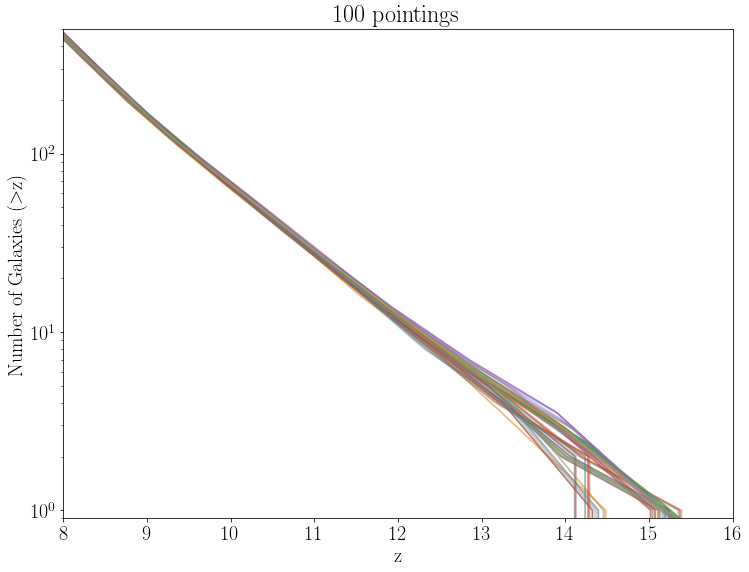

In [24]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design assuming 100 parallel pointings of JWST

    parallel_200 = survey(29.85, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 100)
    mean_200, med_200, z_vals_200 = mean_median(parallel_200)
    summed+=med_200
    summean+=mean_200

    ax.plot(z_vals_200, mean_200, alpha=0.4, label = "Mean")
    ax.plot(z_vals_200, med_200, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,5e2), xlim=(8,16), title='100 pointings')
winsound.Beep(400,300)

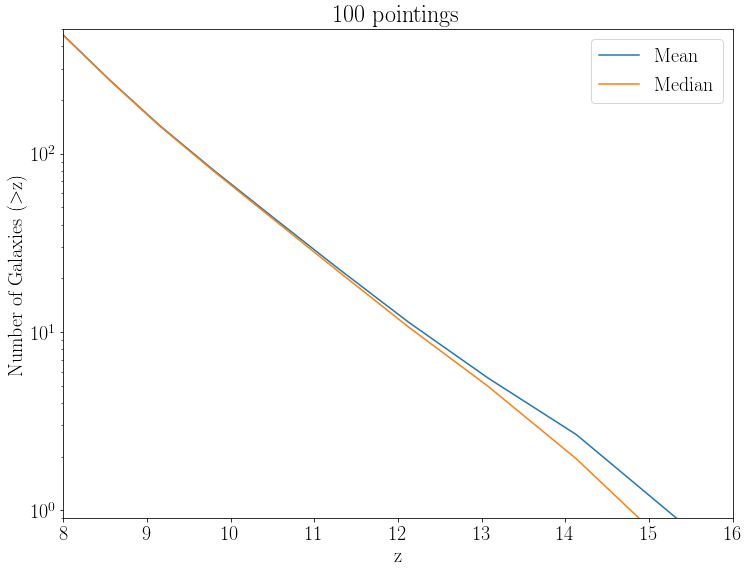

In [25]:
fig, ax =plt.subplots(figsize=(12,9))
mean100final=summean/N
med100final=summed/N  
ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,5e2), xlim=(8,16), title='100 pointings')
if save==1:
    plt.savefig("figs/"+file+"/100.pdf")

In [26]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9996181709299526
0.9999146405406424


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(14.803999999996229, 15.311, 15.225999999995995)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

-2.007534899773139
-1.9110085382272772
-1.8267422725003502
-1.752765730050029
-1.6874588267859543
-1.6295079810132402
-1.5778623273759784
-1.5316242517159964
-1.4900493910728594
-1.4525466336838684
-1.4186124398993174
-1.3877870561259962
-1.3596983008836871
-1.334039671776917
-1.3105265594384603
-1.288940033585836
-1.2690830569648117
-1.2507585923211542
-1.2338133884571267
-1.2181160872032408
-1.203535330390008
-1.1899616528761876
-1.1773293755770353
-1.165550926379559
-1.154538733170766
-1.144227116865912
-1.134550398380253
-1.1254647916572926
-1.1169265106405346
-1.1088917692734828
-1.101316781499641
-1.094157761262513
-1.087392815533851
-1.0810000512854065
-1.0749356824606835
-1.069177816031434
-1.0637045589694096
-1.0584940182463625
-1.0535461938622923
-1.0488391927889513
-1.0443511219980914
-1.0400600884614644
-1.03596609217907
-1.0320691331509089
-1.028325425320484
-1.0247349686877962
-1.0212977632528448
-1.017991915987382
-1.014817426891408
-1.0117742959649225
-1.008840630179677

  2%|█▋                                                                                 | 1/50 [00:34<28:26, 34.82s/it]

-2.0339386961118313
-1.9349814143534512
-1.8485929867081792
-1.7727534187649798
-1.705801826230335
-1.6463915461635552
-1.5934452482120882
-1.5460427126997953
-1.5034208306269528
-1.4649736036702492
-1.4301848110357542
-1.3985831206942256
-1.3697869781458014
-1.3434821620376542
-1.3193768953993008
-1.2972467344072929
-1.2768896796205271
-1.2581037315978996
-1.2407317796629969
-1.2246391575217497
-1.2096911988800891
-1.1957756818262912
-1.182825273213321
-1.1707501955117996
-1.1594606711923472
-1.1488893671079297
-1.1389689501115123
-1.1296545314384057
-1.1209012223239196
-1.112664134003365
-1.104898377712052
-1.0975590646852906
-1.0906237505407366
-1.0840699908960445
-1.077852896986525
-1.0719500244298332
-1.0663389288436245
-1.0609971658455535
-1.0559247354356207
-1.051099193231481
-1.0464980948507898
-1.042098995911202
-1.0379018964127178
-1.033906796355337
-1.03006880697437
-1.026387928269817
-1.022864160241678
-1.0194750585076078
-1.0162206230676065
-1.0131008539216744
-1.010093306

  4%|███▎                                                                               | 2/50 [01:20<30:31, 38.16s/it]

-2.022105108188392
-1.9242373102186574
-1.8387999878359156
-1.7637953860351143
-1.6975809062565435
-1.6388247118301686
-1.5864613334199613
-1.5395806826347311
-1.4974280520281251
-1.4594041150986274
-1.424998334456058
-1.3937445672659046
-1.3652654598049905
-1.3392502501836414
-1.3154103737900158
-1.2935238578457748
-1.2733909268504133
-1.2548118053034258
-1.237631112259975
-1.2217156640530573
-1.2069322770156694
-1.1931699647586418
-1.1803621354484723
-1.1684199999738256
-1.157254769223366
-1.1467998513635917
-1.1369886545610008
-1.1277767842599258
-1.1191198459046987
-1.1109734449396516
-1.1032931868091167
-1.0960346769574263
-1.0891757181067463
-1.082694112979243
-1.0765454670192482
-1.0707075829489283
-1.0651582634904495
-1.0598753113659776
-1.0548587265755125
-1.0500863118412207
-1.045535869885268
-1.0411852034298203
-1.0370343124748782
-1.0330831970204413
-1.0292874625108417
-1.0256471089460795
-1.0221621363261546
-1.0188103473732333
-1.0155917420873155
-1.0125063204684013
-1.009

  6%|████▉                                                                              | 3/50 [02:10<32:32, 41.55s/it]

-2.0240707320837017
-1.9260219648777244
-1.8404266586913316
-1.76528336443209
-1.698946446179554
-1.6400816045387692
-1.58762139999377
-1.5406540612913378
-1.4984234854409975
-1.4603292377150192
-1.4258598366786697
-1.394548277543715
-1.3660165088149172
-1.3399531939667872
-1.3160692347970846
-1.2941422480733165
-1.2739720888862396
-1.255358612326611
-1.2381461501316855
-1.2222012723619677
-1.2073905490779622
-1.1936027886634224
-1.1807712761486007
-1.1688070582405001
-1.1576211816461233
-1.147146931395723
-1.1373175925195511
-1.1280886883711092
-1.1194157423038986
-1.1112542776714212
-1.103559817827178
-1.0962878861246708
-1.08941624424065
-1.0829226538518668
-1.0767626383118225
-1.0709139592972676
-1.0653543784849533
-1.06006165755163
-1.0550357964972976
-1.0502545569987072
-1.0456957007326095
-1.041336989375755
-1.0371784229281438
-1.0332200013897759
-1.0294172481141528
-1.0257701631012746
-1.0222787463511411
-1.0189207595405032
-1.0156962026693608
-1.012605075737714
-1.009625140422

  8%|██████▋                                                                            | 4/50 [02:43<30:03, 39.21s/it]

-2.008525102670059
-1.9119075760430193
-1.8275617243788158
-1.7535153142012776
-1.6881467313188872
-1.6301411534141983
-1.5784467226332535
-1.5321649770591308
-1.4905508507119436
-1.4530126735488413
-1.4190464303481356
-1.3881919332987205
-1.3600766494106524
-1.3343937868098608
-1.3108584673275656
-1.2892515539108587
-1.269375823212123
-1.251034051883742
-1.2340728439886801
-1.2183607172951922
-1.2037661895715344
-1.190179692291252
-1.1775354843384733
-1.1657459108920347
-1.1547233171307736
-1.1444019619388173
-1.1347161042002933
-1.1256219165046206
-1.1170755714412173
-1.109033241599502
-1.1014510995688926
-1.0942853179388083
-1.087513983003958
-1.081115181059051
-1.0750450846935053
-1.069281780202031
-1.0638033538793363
-1.0585878920201313
-1.0536353946244155
-1.0489239479868981
-1.0444316384022887
-1.0401365521652963
-1.0360386892759208
-1.0321380497341623
-1.0283908061294393
-1.0247969584617518
-1.0213565067310997
-1.0180475372321922
-1.0148700499650296
-1.0118240449296114
-1.00888

 10%|████████▎                                                                          | 5/50 [03:26<30:15, 40.35s/it]

-2.031722541096931
-1.9329692942413614
-1.846758986428459
-1.7710757881692236
-1.7042622396615883
-1.644974454579553
-1.5921373238623184
-1.544832525187117
-1.5022985229692156
-1.4639305683619146
-1.4292135049402468
-1.3976769724901126
-1.3689402032191451
-1.3426896236512778
-1.318634058415877
-1.2965495264586098
-1.2762344448305758
-1.2574872305828753
-1.2401510969774747
-1.2240916553817742
-1.2091745171631738
-1.1952876917945068
-1.1823639849594731
-1.1703138042363395
-1.1590475572033725
-1.148498049544272
-1.1385980869427386
-1.129302873187905
-1.1205676120689048
-1.112347507374871
-1.1045977628949375
-1.0972735824182374
-1.090352567839337
-1.0838123210528035
-1.0776080458477701
-1.0717173441188033
-1.0661178177604698
-1.0607870686673362
-1.0557250968394027
-1.050909504171236
-1.0463178925574026
-1.041927863892469
-1.0377394181764357
-1.033752555409302
-1.029922479380202
-1.0262491900891353
-1.0227326875361018
-1.0193505736156683
-1.016102848327835
-1.0129895116726015
-1.00998816554

 12%|█████████▉                                                                         | 6/50 [04:16<31:37, 43.12s/it]

-2.0228298910777265
-1.9248953644697018
-1.8393997888484073
-1.764344047090976
-1.6980844206741605
-1.6392881648493838
-1.5868890838177825
-1.5399764686678281
-1.4977950973753267
-1.459745234803418
-1.4253159954651464
-1.3940409186985103
-1.3655423934914122
-1.3395094460691839
-1.3156533150696332
-1.2937518763679974
-1.2736052182519897
-1.2550134290093231
-1.2378210217526637
-1.2218947220071537
-1.207101255297935
-1.1933295595626265
-1.1805129975637991
-1.1685627196515476
-1.1573898761759667
-1.1469278298996273
-1.1371099435851009
-1.1278917924074348
-1.1192289515416762
-1.1110769961628726
-1.1033915014460713
-1.0961280425663198
-1.089264407111142
-1.082778382668061
-1.0766255444121249
-1.070783679930857
-1.065230576811781
-1.0599440226424206
-1.0549240174227759
-1.0501483487403704
-1.045594804182728
-1.0412411713373724
-1.0370874502043037
-1.0331336407835214
-1.0293353182500735
-1.0256924826039597
-1.0222051338451799
-1.0188510595612579
-1.0156302597521938
-1.0125427344179876
-1.00956

 14%|███████████▌                                                                       | 7/50 [04:43<27:23, 38.21s/it]

-1.9977573707044272
-1.902131197629069
-1.8186507847991638
-1.745364135032406
-1.6806662728677897
-1.623255866850445
-1.572091851816476
-1.5262849846050548
-1.485097844058422
-1.4479448310218856
-1.4143271017710792
-1.3837891902967985
-1.3559623860201633
-1.3305430449350375
-1.307249211892866
-1.285863998317837
-1.26619220449172
-1.2480386306962847
-1.2312514549284628
-1.215700544042767
-1.201255764893711
-1.1878086731933886
-1.175294202369056
-1.1636255969903893
-1.152716101627063
-1.1425006497063341
-1.132914174655459
-1.1239132987592755
-1.115454644302621
-1.1074948335703332
-1.09999048884725
-1.092898232418209
-1.086196375425629
-1.0798632290119285
-1.0738554154619457
-1.0681512459180993
-1.062729031522808
-1.0575670834184907
-1.0526654016051473
-1.0480022972251968
-1.0435560814210578
-1.0393050653351494
-1.0352492489674714
-1.0313886323180241
-1.0276798376716447
-1.0241228650283336
-1.0207177143880908
-1.0174426968933348
-1.0142978125440658
-1.0112830613402837
-1.0083767544244076


 16%|█████████████▎                                                                     | 8/50 [05:21<26:40, 38.12s/it]

-2.0339825078072375
-1.9350211924343519
-1.8486292434957636
-1.7727865842431032
-1.7058322626832672
-1.6464195609840093
-1.593471104879533
-1.5460666371844696
-1.50344301779388
-1.4649942236832534
-1.4302040130168954
-1.3986010345535198
-1.369803718240657
-1.3434978299174496
-1.319391580720244
-1.2972605176769996
-1.2769026331128792
-1.2581159193530458
-1.240743259317071
-1.22464998122173
-1.209701413283798
-1.1957853290172549
-1.182834392530488
-1.1707588226346812
-1.1594688381410179
-1.1488971031578858
-1.1389762817936728
-1.1296614834539707
-1.1209078175443707
-1.1126703934704654
-1.1049043206378462
-1.0975647084521047
-1.0906291116160374
-1.0840750848324394
-1.0778577375069034
-1.0719546243422244
-1.066343300041199
-1.0610013193066228
-1.0559286821384957
-1.0511029432396137
-1.0465016573127728
-1.0421023790607689
-1.037905108483602
-1.0339098455812716
-1.0300716997593702
-1.0263906710178976
-1.0228667593568534
-1.0194775194790342
-1.0162229513844394
-1.0131030550730693
-1.010095385

 18%|██████████████▉                                                                    | 9/50 [06:13<29:01, 42.48s/it]

-2.041425312510865
-1.9417787599031595
-1.85478860771739
-1.778420791600031
-1.7110028586381834
-1.6511787659294974
-1.597863679152093
-1.5501309689893636
-1.5072122111299775
-1.4684971862678775
-1.4334660779571622
-1.4016442711820094
-1.3726475537867528
-1.3461595157608444
-1.3218863478087746
-1.2996020427801518
-1.2791031942396236
-1.2601863957518373
-1.242693442311519
-1.2264887296284332
-1.2114366534123453
-1.1974242100880592
-1.1843835975104575
-1.1722244128193835
-1.1608562531546804
-1.1502113163712309
-1.140221800323917
-1.1308425035826613
-1.1220282247173845
-1.1137337622980086
-1.1059139148944555
-1.0985234810766464
-1.0915398601295427
-1.0849404513381047
-1.0786800532722542
-1.0727360652169522
-1.0670858864571595
-1.0617069162778368
-1.0565991546789841
-1.0517400009455624
-1.0471068543625321
-1.0426771142148548
-1.0384507805025298
-1.0344278532255573
-1.030563130953859
-1.0268566136874349
-1.0233083014262851
-1.0198955934553702
-1.0166184897746904
-1.0134769903842455
-1.01044

 20%|████████████████▍                                                                 | 10/50 [06:45<26:03, 39.08s/it]

-2.019700708936298
-1.9220542769650697
-1.836810204237182
-1.7619752544456695
-1.6959105444048046
-1.637287249909944
-1.5850423115973729
-1.5382676995939177
-1.4962104135169474
-1.4582724824743722
-1.4239445238544124
-1.3927614491854423
-1.3643467582761464
-1.3383903921454412
-1.3146044388823206
-1.2927674277860106
-1.2726800352258147
-1.2541429375710362
-1.2370011053311338
-1.2211216560856426
-1.2063717074140985
-1.1926405239661144
-1.1798616645314586
-1.1679465408298206
-1.1568065645808918
-1.1463752945744394
-1.1365862896002314
-1.1273952555181133
-1.1187578981879298
-1.1106299234695263
-1.1029670372227482
-1.0957249453074405
-1.088881500653526
-1.082414556190927
-1.076279817779489
-1.0704551383491345
-1.064918370829786
-1.0596473681513665
-1.0546421303138755
-1.049880510247236
-1.0453403608813703
-1.0409995351462011
-1.0368580330417285
-1.0329158545679524
-1.0291287055847183
-1.0254965860920258
-1.022019496089875
-1.0186752885081884
-1.0154639633469664
-1.0123855206062087
-1.009417

 22%|██████████████████                                                                | 11/50 [07:16<23:52, 36.74s/it]

-2.0318540535411573
-1.9330886987199463
-1.8468678208095721
-1.7711753431636499
-1.704353602761819
-1.6450585485064901
-1.5922149395195917
-1.544904340884437
-1.5023651236457254
-1.4639924648095417
-1.4292711447884765
-1.3977307456983732
-1.3689904530615817
-1.3427366549553312
-1.318678140308477
-1.2965909006047542
-1.2762733281795244
-1.2575238153681492
-1.240185556209243
-1.224124145593047
-1.2092051784098021
-1.1953166504013761
-1.1823913590128892
-1.1703397008378356
-1.1590720724697092
-1.1485212713536308
-1.1386200949347205
-1.1293237415097257
-1.1205874093753931
-1.11236629682847
-1.104615602165703
-1.0972905236838397
-1.090368660531253
-1.083827611856317
-1.0776225759557783
-1.0717311519780104
-1.066130939071387
-1.0607995363842815
-1.055736943916694
-1.0509207608169977
-1.0463285862335665
-1.0419380193147736
-1.0377490600606194
-1.0337617084711035
-1.029931162842973
-1.026257423176228
-1.0227404894708685
-1.019357960875268
-1.0161098373894264
-1.0129961190133439
-1.009994404895

 24%|███████████████████▋                                                              | 12/50 [08:10<26:35, 41.98s/it]

-2.0173967009562332
-1.9199623922530649
-1.834903500395842
-1.7602311191057525
-1.6943099254424383
-1.6358139818866917
-1.5836825384231457
-1.5370095377470077
-1.49504361526406
-1.4571880990906585
-1.4229347131777732
-1.3918193793936813
-1.3634664154412737
-1.3375664358994017
-1.3138321543055702
-1.2920425810732445
-1.2719988255745434
-1.2535019971815853
-1.236397403183796
-1.220552449829255
-1.2058345433660411
-1.192133189000887
-1.1793820898578322
-1.167492850102263
-1.1563770738995656
-1.145968464373779
-1.1362007246489434
-1.1270296568077516
-1.1184110629328965
-1.1103007451070714
-1.1026545054129695
-1.0954281459332833
-1.0885995677093596
-1.0821466717825452
-1.0760252602355327
-1.070213234109669
-1.0646884944463004
-1.0594289422867735
-1.0544345776310884
-1.0496833015205913
-1.045153014996629
-1.0408216191005482
-1.0366891138323484
-1.03275549919203
-1.0289765772622859
-1.0253523480431161
-1.0218828115345207
-1.018545868777846
-1.0153415197730922
-1.0122697645202592
-1.0093085040

 26%|█████████████████████▎                                                            | 13/50 [08:43<24:13, 39.29s/it]

-2.025498376782125
-1.9273181705092353
-1.8416081197166863
-1.7663640922737076
-1.6999382462061121
-1.6409944934267204
-1.5884639634657893
-1.5414336627970795
-1.499146474837856
-1.4610011599488881
-1.4264855510300907
-1.3951320172509507
-1.366562000320101
-1.3404637463505327
-1.316547769590024
-1.2945913886907117
-1.2743941904395184
-1.2557557616233679
-1.2385202252987555
-1.2225539726569634
-1.2077233948892734
-1.1939171513217546
-1.1810684375500473
-1.1690881810350067
-1.1578873092374873
-1.1473990177531301
-1.1375565021775762
-1.128315226241253
-1.1196306536745877
-1.111458248208008
-1.103753473571941
-1.096471793496814
-1.0895909398478407
-1.083088644490235
-1.0769203711544242
-1.0710638517056217
-1.0654968180090416
-1.0601970019298972
-1.0551644034681886
-1.0503767544891296
-1.0458117868579337
-1.041447232439815
-1.0372830912347728
-1.0333193632428077
-1.0295115121943468
-1.0258595380893902
-1.0223634409279378
-1.0190009525752033
-1.0157720730311868
-1.0126768022958883
-1.0096928

 28%|██████████████████████▉                                                           | 14/50 [09:11<21:31, 35.89s/it]

-2.0066524173347804
-1.910207303362907
-1.826011965717695
-1.7520976903466445
-1.6868457568065904
-1.628943689062533
-1.5773415062864728
-1.5311423498544936
-1.4896024833467623
-1.452131292547529
-1.4182256616433775
-1.387426224022058
-1.359361111473654
-1.3337240795899987
-1.3102307585635093
-1.2886624023883524
-1.2688221396592778
-1.250513098971036
-1.2335821581195436
-1.2178980695013006
-1.2033295855128072
-1.1897673331511465
-1.1771456886145688
-1.165377153500741
-1.1543742294073291
-1.1440712925325838
-1.1344027190747548
-1.1253247598326754
-1.1167936656051793
-1.1087656871910996
-1.1011970753892697
-1.0940440809985228
-1.0872848294182758
-1.0808974460479455
-1.0748381816863648
-1.0690851617329507
-1.06361651158712
-1.0584103566482888
-1.0534666969164577
-1.048763657791043
-1.0442793646714619
-1.0399919429571303
-1.035901392648049
-1.0320077137442172
-1.028267157044469
-1.0246797225488038
-1.0212454102572222
-1.0179423455691403
-1.0147705284845583
-1.0117299590034763
-1.0087987625

 30%|████████████████████████▌                                                         | 15/50 [10:03<23:46, 40.76s/it]

-2.03610760894109
-1.9369506417295952
-1.850387891265308
-1.7743952869995696
-1.707308593147928
-1.6477784293446105
-1.5947252912969998
-1.547227102421818
-1.5045192138451275
-1.465994404402331
-1.431135411619882
-1.399469952369761
-1.3706157022149985
-1.3442578057369148
-1.320103897189592
-1.2979290798454022
-1.2775309466494789
-1.2587070905469564
-1.2413000838284949
-1.225174988457517
-1.2101968663974456
-1.196253269284466
-1.1832767281002898
-1.1711772841538657
-1.159864978754142
-1.1492723428828302
-1.1393319075216415
-1.1299986933250503
-1.121227720947531
-1.1129740110435578
-1.1051925842676047
-1.097838461274146
-1.0908891523904192
-1.084322167943661
-1.078092528588346
-1.0721777446517111
-1.0665553264609937
-1.0612027843434306
-1.0561201182990219
-1.0512848386550049
-1.0466744557386165
-1.0422664798770938
-1.038060911070437
-1.0340577493186462
-1.0302120152761955
-1.0265237089430848
-1.022992830319314
-1.0195968897321208
-1.0163358871815045
-1.0132098226674655
-1.010196206517241

 32%|██████████████████████████▏                                                       | 16/50 [10:45<23:21, 41.22s/it]

-2.0313636598512623
-1.9326434541410946
-1.846461990820969
-1.7708041148639138
-1.7040129210255308
-1.6447449726211731
-1.5919255203031226
-1.5446365490035365
-1.5021167779344486
-1.4637616605877675
-1.4290562129010451
-1.3975302320346545
-1.3688030775946125
-1.342561281021168
-1.318513764365981
-1.2964366215149432
-1.2761283369653578
-1.2573873952145278
-1.2400570619825773
-1.2240029936010417
-1.2090908464014563
-1.1952086673267672
-1.1822892845427422
-1.170243135603738
-1.158980658064111
-1.1484346800896297
-1.138538029846061
-1.1292459261105836
-1.120513587660376
-1.1122962332726165
-1.1045490817244836
-1.0972273517931557
-1.0903086528672221
-1.0837705943352718
-1.0775683949744832
-1.0716796641734458
-1.0660820113207485
-1.060753045804981
-1.0556927676261427
-1.050878786172823
-1.0462887108336114
-1.0419001509970967
-1.0377131066632792
-1.0337275778321589
-1.0298987832809139
-1.0262267230095445
-1.0227113970180508
-1.0193304146950217
-1.0160837760404573
-1.0129714810543577
-1.009971

 34%|███████████████████████████▉                                                      | 17/50 [11:09<19:44, 35.89s/it]

-2.042242742776067
-1.942520931757468
-1.8554650799519372
-1.779039586771659
-1.7115707361777646
-1.651701461111711
-1.5983461079266634
-1.550577347465951
-1.5076261750630662
-1.4688819105416646
-1.433824344862638
-1.4019785045554962
-1.372959887286986
-1.34645184407678
-1.3221603437288612
-1.2998592084001384
-1.2793448780318304
-1.2604137925651562
-1.242907627509952
-1.2266906761603635
-1.2116272318105366
-1.197604205538926
-1.1845537439926044
-1.172385376034336
-1.161008630526884
-1.1503556541173217
-1.1403585934527218
-1.1309722129644664
-1.122151277083937
-1.113850550242516
-1.1060247968715848
-1.0986287814025257
-1.0916398860510295
-1.085035493032787
-1.0787703667791804
-1.0728218895059003
-1.067167443428638
-1.0617844107630843
-1.056672791509239
-1.0518099678827935
-1.0471733220994384
-1.0427402363748646
-1.0385107107090725
-1.0344847451020616
-1.0306171039852141
-1.0269077873585302
-1.0233567952220093
-1.019941509791343
-1.0166619310665308
-1.0135180590475728
-1.0104872759501602

 36%|█████████████████████████████▌                                                    | 18/50 [11:59<21:25, 40.17s/it]

-2.0311924571852504
-1.9324880136032214
-1.8463203104171866
-1.770674514349218
-1.7038939847041301
-1.6446354992966388
-1.5918244803785155
-1.5445430594564824
-1.5020300772922108
-1.463681083902323
-1.4289811774491266
-1.397460230167771
-1.3687376624390926
-1.3425000557531916
-1.3184563786365895
-1.2963827607250722
-1.2760777186908467
-1.2573397692061203
-1.2400122030159435
-1.2239606979017874
-1.2090509316451235
-1.1951709690638448
-1.182253649048687
-1.1702094234539646
-1.1589487441339916
-1.148404449979504
-1.1385093798812378
-1.1292187597663497
-1.1204878155619968
-1.1122717731953367
-1.1045258585935263
-1.097205297683723
-1.090287703429505
-1.0837506887944512
-1.0775494797057186
-1.0716616891268858
-1.0660649300215315
-1.0607368153532342
-1.0556773451219938
-1.0508641322913892
-1.0462747898249987
-1.041886930686401
-1.037700554875596
-1.0337156623925836
-1.0298874791645214
-1.0262160051914089
-1.0227012404732463
-1.0193207979736123
-1.016074677692507
-1.01296287962993
-1.009963016

 38%|███████████████████████████████▏                                                  | 19/50 [12:43<21:18, 41.26s/it]

-2.0260651066497406
-1.9278327232174555
-1.8420771224393049
-1.7667931071030174
-1.700331959500725
-1.6413568814909136
-1.5887984345603714
-1.5417431399790633
-1.4994334788001318
-1.461267891859895
-1.4267339398707721
-1.3953637434832336
-1.36677854322385
-1.340666419526268
-1.31673773279316
-1.2947696833342728
-1.2745617514283798
-1.2559134173542534
-1.2386687213287173
-1.2226939835376198
-1.2078555241668099
-1.1940419433711607
-1.1811864012435969
-1.1691997779080177
-1.1579929534883215
-1.1474990880774334
-1.137651341768277
-1.1284051546228022
-1.1197159667029584
-1.1115392180706953
-1.103830348787962
-1.0965447989167083
-1.0896602884879092
-1.0831545375325389
-1.0769829861125473
-1.071123354258909
-1.065553362002599
-1.0602507293745917
-1.0552154563748872
-1.0504252630344606
-1.0458578693842864
-1.0414909954553393
-1.0373246412476191
-1.0333588067611263
-1.0295489320578104
-1.0258950171376708
-1.0223970620007081
-1.0190327866778968
-1.015802191169237
-1.0127052754747286
-1.009719759

 40%|████████████████████████████████▊                                                 | 20/50 [13:05<17:49, 35.64s/it]

-2.0352657510687275
-1.9361862912463876
-1.8496912037308095
-1.7737580001155484
-1.70672374548864
-1.6472401142457884
-1.594228445903557
-1.5467673846323433
-1.5040928792563797
-1.4655981832537335
-1.430766438476091
-1.3991257309619485
-1.3702940351234223
-1.3439567416528435
-1.3198217133359478
-1.2976642292386862
-1.2772820405204142
-1.2584728983404871
-1.2410794980450706
-1.2249670070737353
-1.2100005928660515
-1.1960678949549943
-1.1831014970603495
-1.1710115108084966
-1.1597080478258166
-1.1491236918320942
-1.1391910265471148
-1.1298651077840685
-1.1211009913561456
-1.112853733076536
-1.10507838875843
-1.0977300142150175
-1.090786137352894
-1.0842242860786542
-1.0779995162054885
-1.0720893556399915
-1.066471332288759
-1.0611229740583854
-1.056044280948871
-1.051212780866811
-1.0466060017188001
-1.0422014714114338
-1.0379991899447116
-1.033999157318634
-1.030156429346391
-1.0264710060279822
-1.022942887363408
-1.0195496012592635
-1.0162911477155487
-1.0131675267322633
-1.01015626621

 42%|██████████████████████████████████▍                                               | 21/50 [13:51<18:39, 38.60s/it]

-2.0226184337995896
-1.924703375443967
-1.8392247953553327
-1.7641839738122056
-1.6979375190435912
-1.6391529512351695
-1.586764286535484
-1.5398609970714165
-1.4976880109481852
-1.4596457122493462
-1.4252233170460769
-1.3939544574033653
-1.3654615973738204
-1.3394338250007678
-1.315582436324438
-1.2936853513757776
-1.2735426981826388
-1.2549546047728732
-1.237765615168144
-1.2218424813870188
-1.2070519554480656
-1.1932829973667578
-1.1804689831523796
-1.1685210808173094
-1.1573504583739258
-1.146890491831513
-1.1370745571993548
-1.1278582384836409
-1.1191971196905601
-1.1110467848263021
-1.1033628178970565
-1.0961008029090118
-1.0892385318652633
-1.0827537967689054
-1.0766021816261278
-1.0707614784400246
-1.0652094792136908
-1.059923975950221
-1.0549049686496152
-1.0501302493149682
-1.0455776099493745
-1.041224842555929
-1.0370719471346312
-1.0331189236854816
-1.0293213562146692
-1.0256792447221943
-1.0221925892080568
-1.0188391816753513
-1.0156190221240777
-1.012532110554236
-1.00955

 44%|████████████████████████████████████                                              | 22/50 [14:42<19:42, 42.24s/it]

-2.033286122885131
-1.9343889216328485
-1.848052943492673
-1.7722594204644442
-1.7053484766369187
-1.645974266676658
-1.5930601143169087
-1.545686358579821
-1.5030903537764453
-1.4646664695067335
-1.429898798392867
-1.3983162945681418
-1.3695376351880832
-1.3432487896748886
-1.3191581582063128
-1.2970414332267823
-1.276696737936281
-1.257922195534793
-1.2405607907334173
-1.2244779389988092
-1.2095390557976253
-1.1956319873520789
-1.1826894413954976
-1.1706216949056523
-1.1593390248603137
-1.1487741389928097
-1.1388597450364684
-1.1295509814801752
-1.120802986812815
-1.112570899523274
-1.1048098581004366
-1.0974750010331886
-1.0905438975659727
-1.0839941169432312
-1.07778079765385
-1.0718815089422713
-1.066273820052938
-1.0609353002302928
-1.0558659494743354
-1.051043337029509
-1.0464450321402556
-1.0420486040510182
-1.037854052761797
-1.0338613782725916
-1.0300257190722877
-1.026347075160885
-1.0228254465383837
-1.0194384024492262
-1.016185942893413
-1.0130680678709436
-1.0100623466262

 46%|█████████████████████████████████████▋                                            | 23/50 [15:04<16:19, 36.30s/it]

-2.0099878344784377
-1.9132356384170157
-1.8287722220776161
-1.754622603004914
-1.6891629067356415
-1.6310764782995828
-1.579309993720564
-1.532963738768937
-1.4912916089615793
-1.4537011095618932
-1.4196875228312957
-1.3887900195302112
-1.360635547417078
-1.3349168869988457
-1.3113487630319671
-1.2897117330214065
-1.2698082987216313
-1.2514409618871085
-1.2344561127713134
-1.2187220858772243
-1.2041072157078192
-1.1905017810155802
-1.1778399490519966
-1.1660339428190538
-1.1549959853187373
-1.1446602438025364
-1.1349608855219402
-1.1258540219779416
-1.1172957646715331
-1.109242225103708
-1.1016495147754584
-1.0944737451877775
-1.0876929720911617
-1.0812852512361073
-1.075206694123607
-1.0694353565041572
-1.0639492941282545
-1.0587265627463949
-1.0537671623585787
-1.0490491487153024
-1.044550577567062
-1.0402495046643543
-1.036145930007179
-1.0322398535955362
-1.0284873869304185
-1.0248885300118264
-1.0214432828397595
-1.0181297011647141
-1.0149477849866906
-1.0118975343056886
-1.00895

 48%|███████████████████████████████████████▎                                          | 24/50 [15:40<15:44, 36.33s/it]

-2.009768654618024
-1.9130366378045411
-1.8285908376877134
-1.7544566837270061
-1.6890106401446476
-1.630936326580282
-1.5791806387456244
-1.5328440500610983
-1.4911806116558357
-1.453597952367676
-1.4195914597251498
-1.3887004006021324
-1.3605518005631898
-1.3348385041909054
-1.3112752957405358
-1.2896427784853546
-1.2697434953713085
-1.2513799893443445
-1.2343986826957538
-1.2186679373895015
-1.2040561153895515
-1.190453518332541
-1.1777943272004523
-1.1659907833025949
-1.1549551279482781
-1.1446215421194847
-1.1349242067981966
-1.1258192426390687
-1.1172627702967557
-1.1092109104259125
-1.1016197836811936
-1.0944455107172542
-1.0876661518614217
-1.0812597674410231
-1.0751824781107135
-1.0694123441978205
-1.063927426029671
-1.0587057839335927
-1.0537474179095858
-1.0490303882849772
-1.044532755387095
-1.0402325795432656
-1.03612986075349
-1.0322245990177676
-1.0284729149907534
-1.0248748086724473
-1.0214302800628496
-1.0181173894892874
-1.0149361369517607
-1.0118865224502696
-1.00894

 50%|█████████████████████████████████████████                                         | 25/50 [16:41<18:10, 43.64s/it]

-2.035272786644637
-1.936192679077425
-1.8496970260889474
-1.7737633260504788
-1.7067286331784006
-1.6472446130535627
-1.5942325981406456
-1.5467712265865627
-1.5040964422204626
-1.4656014945537277
-1.4307695220590175
-1.3991286076896288
-1.3702967233601362
-1.3439592577060715
-1.319824071603285
-1.2976664426485853
-1.2772841206791
-1.2584748555319563
-1.2410813415249202
-1.2249687452160767
-1.2100022331635107
-1.1960694441656265
-1.1831029615014668
-1.1710128962097544
-1.159709359329213
-1.1491249341388847
-1.1391922039178124
-1.1298662241853576
-1.1211020504608822
-1.1128547382637475
-1.1050793431133155
-1.0977309205289474
-1.0907869982703244
-1.0842251040971274
-1.0780002935287178
-1.0720900943247766
-1.0664720342449847
-1.0611236410490228
-1.0560449147368907
-1.0512133830682697
-1.0466065738028403
-1.0422020147002833
-1.037999705760599
-1.0339996469837869
-1.0301568938892092
-1.0264714464768656
-1.0229433047467562
-1.019549996458562
-1.0162915216122825
-1.0131678802079183
-1.010156

 52%|██████████████████████████████████████████▋                                       | 26/50 [17:08<15:29, 38.71s/it]

-2.010892832429406
-1.91405731585668
-1.8295211617880887
-1.755307686964038
-1.6897916184821962
-1.6316551675028348
-1.579844102954171
-1.5334579357957232
-1.491749919018312
-1.4541270476440598
-1.4200841692844035
-1.3891600578454382
-1.3609813398225743
-1.3352405311532085
-1.311652110922066
-1.289996447655859
-1.2700758730286277
-1.2516927187144133
-1.2346932426819142
-1.218945666047157
-1.2043182099261691
-1.1907010585823066
-1.178028322573583
-1.166212149310683
-1.1551646862042912
-1.1448200438124214
-1.1351123326930872
-1.125997626551631
-1.1174319990933947
-1.1093715240237214
-1.1017722750479528
-1.0945903258714318
-1.0878037133468295
-1.0813904743268168
-1.0753066825167363
-1.069530374769259
-1.0640395879370566
-1.0588123588727996
-1.0538486875764885
-1.0491266109007942
-1.0446241656983881
-1.040319388821941
-1.0362122802714535
-1.0323028400469254
-1.0285471418536987
-1.0249451856917737
-1.0214969715611506
-1.0181805363145002
-1.0149958799518226
-1.011943002473118
-1.008999940731

 54%|████████████████████████████████████████████▎                                     | 27/50 [17:40<14:05, 36.74s/it]

-2.025345845691214
-1.927179682509219
-1.8414818911534696
-1.7662486261518908
-1.6998322812274425
-1.640896959398742
-1.588373943080682
-1.541350369335984
-1.4990692298751973
-1.4609293710566993
-1.4264186990376264
-1.3950696498744943
-1.3665037194225778
-1.340409198386221
-1.3164966424194566
-1.2945434020253885
-1.2743490926568084
-1.255713329766509
-1.2384802587066623
-1.22251628977913
-1.2076878332857734
-1.1938835644781443
-1.1810366885071732
-1.1690581455741014
-1.15785887588017
-1.1473720845763098
-1.1375309768134516
-1.128291022692216
-1.1196076923132234
-1.1114364557770946
-1.10373278318445
-1.0964521446359101
-1.0895722751817853
-1.0830709098723856
-1.076903518808332
-1.0710478370399346
-1.0654815996175033
-1.0601825415913488
-1.0551506629614713
-1.0503636987781806
-1.045799384091787
-1.041435453952601
-1.0372719083606226
-1.0333087473158515
-1.0295014409189087
-1.0258499891697939
-1.0223543920685072
-1.0189923846653588
-1.0157639669603487
-1.012669138953477
-1.009685635695053

 56%|█████████████████████████████████████████████▉                                    | 28/50 [18:37<15:40, 42.74s/it]

-2.042032672108738
-1.9423302016813448
-1.8552912339618992
-1.7788805631580524
-1.7114247978405395
-1.6515671341477955
-1.598222128990567
-1.550462633063451
-1.5075197908448936
-1.4687830405971902
-1.4337322741734073
-1.4018926102219966
-1.3728796209821814
-1.346376718886263
-1.3220899297642352
-1.2997931196391708
-1.2792827679318344
-1.2603553540629915
-1.242852584248793
-1.2266387781030816
-1.2115782552397012
-1.1975579486701882
-1.1845100182014638
-1.1723440102427571
-1.1609694712032972
-1.1503185608900057
-1.1403234391098045
-1.1309388790673076
-1.12211965396713
-1.1138205370138858
-1.1059963014121899
-1.0986017203666563
-1.0916141804795925
-1.0850110683533056
-1.07874715719241
-1.0727998335992135
-1.0671464841760225
-1.061764495525145
-1.0566538676465804
-1.0517919871426364
-1.04715624061562
-1.0427240146678383
-1.0384953092992917
-1.0344701245099799
-1.0306032335045172
-1.0268946362829041
-1.0233443328451404
-1.019929709793533
-1.0166507671280824
-1.0135075048487883
-1.0104773095

 58%|███████████████████████████████████████████████▌                                  | 29/50 [19:07<13:33, 38.74s/it]

-2.0369521378756303
-1.9377174173581075
-1.8510867892628602
-1.7750345958791653
-1.7078952964226515
-1.6483184524195025
-1.5952237130906668
-1.5476882788123705
-1.5049469011161183
-1.4663918826886935
-1.4315055554484664
-1.3998152659296021
-1.3709383898978529
-1.344559825042662
-1.3203869763613694
-1.2981947707750057
-1.2777806425124987
-1.2589420258027761
-1.2415213694905596
-1.2253836297284675
-1.2103937626691184
-1.1964392317730277
-1.1834525151165045
-1.171343583467961
-1.16002240759581
-1.1494214655763606
-1.1394732354859216
-1.1301327027086996
-1.1213548526289006
-1.1130946706307308
-1.1053071420983962
-1.0979472524161031
-1.0909924942759548
-1.084420360370054
-1.0781858360826069
-1.0722664141057168
-1.0666395871314867
-1.0612828478520195
-1.0561961962673154
-1.0513571250694775
-1.046743126950609
-1.0423316946028123
-1.0381228280260881
-1.0341165272204362
-1.0302677775700628
-1.026576579074968
-1.0230429317351515
-1.0196443282427163
-1.016380768597663
-1.013252252799991
-1.010236

 60%|█████████████████████████████████████████████████▏                                | 30/50 [19:33<11:43, 35.18s/it]

-2.019433297189341
-1.9218114850346122
-1.836588905088241
-1.7617728236024555
-1.6957247706068657
-1.6371162569362903
-1.5848844912585842
-1.5381216726442075
-1.4960749905662238
-1.458146624900302
-1.4238273214664554
-1.3926521090568709
-1.3642445824080802
-1.338294760714875
-1.3145148046581323
-1.2926832993769888
-1.2726009714966668
-1.2540685476423896
-1.2369310374115527
-1.2210555918876378
-1.206309362154127
-1.1925816407805885
-1.179806003308763
-1.1678938837943051
-1.1567567162928698
-1.1463280763461978
-1.1365415394960299
-1.1273528227701937
-1.118717643196516
-1.1105917178028246
-1.1029307636169468
-1.0956904976667092
-1.0888487784660263
-1.0823834645288113
-1.0762502728828918
-1.070427062042181
-1.0648916905205927
-1.059622016832041
-1.0546180409765251
-1.0498576214679594
-1.045318616820257
-1.0409788855473319
-1.036838427649184
-1.0328972431258132
-1.029111049005047
-1.0254798452868852
-1.0220036319713277
-1.0186602675722884
-1.0154497520897674
-1.0123720855237643
-1.009405126

 62%|██████████████████████████████████████████████████▊                               | 31/50 [20:27<12:53, 40.69s/it]

-2.0100312747515874
-1.9132750792714197
-1.82880817149116
-1.75465548731618
-1.6891930851575634
-1.6311042556188917
-1.5793356311830298
-1.5329874604290914
-1.4913136080324394
-1.4537215547646856
-1.419706562023869
-1.3888077815212436
-1.3606521455944902
-1.3349324220511116
-1.311363323855217
-1.2897253994407363
-1.2698211423982069
-1.251453046318166
-1.2344674951043646
-1.218732817817161
-1.2041173435169135
-1.190511346420587
-1.1778489910583605
-1.1660424968038061
-1.155004083030496
-1.1446679142686091
-1.1349681550483246
-1.1258609150564287
-1.117302303979707
-1.109248431504946
-1.1016554073189315
-1.0944793411084495
-1.0876982877168933
-1.0812903019876556
-1.0752114936075226
-1.0694399174198872
-1.0639536282681425
-1.0587306809956818
-1.0537710756025047
-1.0490528669320043
-1.0445541098275737
-1.040252859132606
-1.036149114847101
-1.032242876971059
-1.0284902551912656
-1.0248912495077211
-1.0214458599204255
-1.0181321412727717
-1.01495009356476
-1.01189971679639
-1.0089590658110548

 64%|████████████████████████████████████████████████████▍                             | 32/50 [21:08<12:11, 40.66s/it]

-2.0424929892946113
-1.942748138811829
-1.8556721738519228
-1.7792290235272867
-1.7117445851081126
-1.651861478002664
-1.5984937977375513
-1.550714000908421
-1.5077529051799559
-1.4689996892858743
-1.433934023999344
-1.4020808261132574
-1.373055504459955
-1.3465413369013657
-1.3222442243092796
-1.299937936585074
-1.2794188666399884
-1.2604834073852618
-1.242973197751859
-1.226752499680606
-1.2116855751123292
-1.197659308997717
-1.1846058323071829
-1.1724346530012775
-1.161055279040552
-1.1503998413954193
-1.1404004710362925
-1.1310119219434474
-1.122188948097159
-1.1138863034777031
-1.1060587420653551
-1.0986610178403904
-1.0916705077929465
-1.0850645889131616
-1.0787980151813106
-1.0728481635875315
-1.0671924111219622
-1.0618081347747401
-1.0566953345458654
-1.0518313874254757
-1.0471936704037088
-1.0427595604707025
-1.0385290576264565
-1.034502161870971
-1.0306336271845216
-1.0269234535671081
-1.0233716410187306
-1.0199555665295266
-1.0166752300994963
-1.0135306317286399
-1.010499148

 66%|██████████████████████████████████████████████████████                            | 33/50 [21:33<10:15, 36.22s/it]

-2.03754383983749
-1.9382546430529781
-1.851576457880924
-1.775482514597897
-1.7083063580979654
-1.6486968085655083
-1.5955729221480295
-1.5480113926381884
-1.5052465514738
-1.4666703677378352
-1.4317648891676393
-1.4000572028277452
-1.3711644744370606
-1.3447714287052737
-1.320585310005667
-1.2983809217023037
-1.2779555868228407
-1.259106628394935
-1.2416764087734307
-1.225529809976766
-1.2105317140233784
-1.1965695225953001
-1.18357567670175
-1.171460097688353
-1.1601327069007346
-1.1495259453481137
-1.1395722540397095
-1.1302265936483344
-1.121443924846801
-1.1131792083079226
-1.1053874047045111
-1.0980234747093796
-1.091064898658934
-1.084489156889581
-1.078251210074133
-1.0723285385489967
-1.066698622650578
-1.0613389427152833
-1.0562494987431128
-1.0514077710704728
-1.0467912400337696
-1.0423773859694092
-1.038166208877392
-1.0341577087577178
-1.0303068462831995
-1.0266136214538368
-1.02307803426963
-1.0196775650669851
-1.0164122138459022
-1.0132819806063815
-1.010264345684829
-1

 68%|███████████████████████████████████████████████████████▊                          | 34/50 [22:24<10:49, 40.57s/it]

-2.0109276581068873
-1.9140889352360133
-1.8295499821105898
-1.7553340500215262
-1.6898158122524594
-1.6316774363306625
-1.5798646562779544
-1.533476953237971
-1.4917675554761682
-1.4541434383798184
-1.4200994328343763
-1.3891742974743877
-1.3609946464325797
-1.3352529854653166
-1.311663784203507
-1.2900074039016969
-1.270086169688977
-1.251702406694438
-1.2347023677962625
-1.2189542697471774
-1.20432632929991
-1.1907087270817331
-1.1780355714690107
-1.1662190069635603
-1.1551711780672007
-1.1448261931562955
-1.135118160607208
-1.1260031526708478
-1.1174372415981237
-1.109376499639945
-1.1017769990472204
-1.0945948120708593
-1.0878079748363163
-1.081394523469046
-1.0753105302199573
-1.069534031214505
-1.0640430625781432
-1.058815660436327
-1.053851824789056
-1.049129591761785
-1.0446269974799687
-1.0403220780690612
-1.0362148335290626
-1.032305263859973
-1.0285494413127019
-1.0249473658872486
-1.0214990375836135
-1.0181824925272511
-1.0149977307181612
-1.0119447521563443
-1.00900159296

 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [23:10<10:31, 42.12s/it]

-2.012867060370468
-1.9158497824122018
-1.8311549530038633
-1.7568021786284993
-1.6911631357277266
-1.63291756195691
-1.5810092474403419
-1.534536012909188
-1.4927497097014886
-1.4550562197621577
-1.4209494425257523
-1.3899672861716497
-1.3617356763688702
-1.3359465519036653
-1.3123138559346978
-1.2906175447378618
-1.270659578961462
-1.252241919253803
-1.2352105350080107
-1.2194333999896219
-1.2047784879641728
-1.1911357770696105
-1.1784392541887034
-1.166600901831809
-1.1555327025092854
-1.1451686431039
-1.135442710498422
-1.1263108959480295
-1.1177291907079017
-1.1096535860332173
-1.102040073179155
-1.094844643400894
-1.0880452923260235
-1.081620015582133
-1.075524804424401
-1.0697376544804174
-1.0642365613777713
-1.0589995207440523
-1.0540265325792604
-1.0492955925109848
-1.044784696166815
-1.0404718391743404
-1.0363570215335611
-1.0324402432444773
-1.0286774955622673
-1.0250687784869315
-1.0216140920184698
-1.0182914317844716
-1.015100797784937
-1.0120421900198655
-1.00909360411684

 72%|███████████████████████████████████████████████████████████                       | 36/50 [23:36<08:40, 37.17s/it]

-2.020751594010092
-1.9230084101273528
-1.8376798742315346
-1.7627707750390247
-1.6966406054944088
-1.6379592247419457
-1.5856625200970416
-1.5388415619749403
-1.4967426038907212
-1.458767082459301
-1.4244051103526452
-1.393191138271244
-1.364748292972638
-1.3387662082571539
-1.3149566869393805
-1.293098038876695
-1.2729907429407357
-1.2544352780031414
-1.2372764609640758
-1.221381277737965
-1.206616714239234
-1.1928719253965716
-1.1800804041671906
-1.1681534744940418
-1.1570024603200755
-1.1465608546025043
-1.1367621502985419
-1.1275620093796632
-1.1189160938173432
-1.1107800655830578
-1.1031095866482816
-1.0958603189844902
-1.0890100935774214
-1.0825367414128129
-1.0763959244621395
-1.0705654737111392
-1.0650232201455494
-1.0597469947511082
-1.054736797527815
-1.0499704594614079
-1.0454258115376245
-1.041080684742202
-1.036935079075141
-1.0329889945364412
-1.029198093097578
-1.0255623747585512
-1.0220818395193607
-1.0187343183657447
-1.0155198112977026
-1.0124383183152348
-1.00946767

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [24:21<08:35, 39.65s/it]

-2.01191206640749
-1.9149827119469534
-1.8303646386154488
-1.7560792476600957
-1.6904996912174148
-1.632306903452153
-1.5804456316961075
-1.5340145142951882
-1.4922660806094186
-1.4546067510129344
-1.420530883602222
-1.3895768053349424
-1.3613707808911073
-1.3356050282424914
-1.3119937497914558
-1.2903171012321253
-1.2703772226892114
-1.2519762542874266
-1.234960305012658
-1.21919746828138
-1.2045558375100676
-1.1909254905457825
-1.1782404740967625
-1.166412850440657
-1.1553546818551161
-1.145000015048377
-1.1352828967286772
-1.1261593580348412
-1.1175854301056942
-1.109517144080061
-1.1019105310967665
-1.0947216222946357
-1.0879284332430808
-1.081508979511514
-1.075419292238761
-1.0696373869942337
-1.0641412793473446
-1.0589089848675062
-1.0539405035547185
-1.0492138509783937
-1.0447070427079448
-1.0403980943127835
-1.0362870057929106
-1.0323737771483255
-1.0286144395178534
-1.025008992901494
-1.0215574372992478
-1.0182377882805267
-1.015050045845331
-1.0119942099936607
-1.00904829629

 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [25:05<08:12, 41.08s/it]

-2.0384440080787987
-1.939071935440209
-1.8523214007189726
-1.7761639424640858
-1.7089317145936134
-1.649272409473553
-1.5961041809967025
-1.5485029522798275
-1.5057024156636603
-1.4670940327128996
-1.4321594188345113
-1.4004252663565946
-1.3715084214495157
-1.345093345665341
-1.3208870390167027
-1.2986641168979345
-1.2782217331639356
-1.2593570416696058
-1.2419122731909784
-1.225752196964653
-1.2107415822272294
-1.196767736675874
-1.183763044928887
-1.1716373531440012
-1.1603005074789499
-1.1496848925520333
-1.1397228929815508
-1.1303694318463695
-1.1215794322253556
-1.113307817197376
-1.105509509841297
-1.0981394332359855
-1.0911750489208745
-1.0845938184353974
-1.078350664858421
-1.0724230497293783
-1.0667884345877028
-1.0614242809728276
-1.056330588884753
-1.051484819862912
-1.046864435446738
-1.0424468971756644
-1.0382322050496913
-1.0342203590688182
-1.0303662823119122
-1.026669974778973
-1.0231314364700008
-1.0197281289244287
-1.0164600521422569
-1.0133272061234853
-1.0103070524

 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [25:32<06:45, 36.83s/it]

-2.023296278241055
-1.925318812732591
-1.8397857520063319
-1.7646971024365663
-1.6984084248199303
-1.6395863900726173
-1.587164334927581
-1.5402311511775526
-1.4980312856750413
-1.4599647403323337
-1.4255204056673034
-1.3942316165006179
-1.3657205962585315
-1.3396762348214892
-1.3158096442213327
-1.2938986029440942
-1.2737431116272022
-1.2551431709080858
-1.2379432257269676
-1.2220099431754665
-1.2072099903452018
-1.1934322564791897
-1.1806100751232398
-1.1686545576717648
-1.1574768155191775
-1.1470101822112877
-1.137187991293905
-1.1279657984642355
-1.1192991594194859
-1.1111436298568627
-1.103454765473572
-1.0961881219668204
-1.089321477185211
-1.0828326089773475
-1.0766770730404356
-1.0708326472230787
-1.0652771093738804
-1.0599882373414435
-1.054966031125768
-1.0501882685754573
-1.0456327275391146
-1.0412771858653431
-1.0371216435541428
-1.0331661006055135
-1.0293661127166618
-1.0257216798875874
-1.022232802118291
-1.018877257257375
-1.01565504530484
-1.0125661662606857
-1.00958839

 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [26:15<06:27, 38.71s/it]

-2.0266276994071983
-1.928343519707135
-1.8425427014568414
-1.767218990137605
-1.7007227987007054
-1.641716624133668
-1.5891304640265123
-1.54205035798738
-1.4997183876425355
-1.4615326766363643
-1.426980515480751
-1.3955937781213295
-1.3669935053712317
-1.3408676131942134
-1.3169263092709045
-1.2949466764325597
-1.2747280892273074
-1.2560699222032763
-1.2388161333423442
-1.2228329723432638
-1.2079866889047874
-1.1941658244425422
-1.1813035038059043
-1.1693105601273754
-1.158097826539457
-1.1475984278915257
-1.1377454890329572
-1.1284944265300028
-1.119800656948913
-1.1116195968559388
-1.1039066628173309
-1.0966172713993403
-1.0897291308850923
-1.0832199495577122
-1.077045143983451
-1.071182422445434
-1.0656094932267868
-1.0603040646106345
-1.0552661365969773
-1.0504734174689407
-1.04590361550965
-1.0415344390022305
-1.0373658879466823
-1.0333979623430056
-1.0295860787574507
-1.025930237190018
-1.0224304376407076
-1.0190643883926447
-1.0158320894458293
-1.0127335408002613
-1.0097464507

 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [26:59<06:01, 40.15s/it]

-2.0356582408386434
-1.9365426456324877
-1.8500160123940002
-1.7740551150926622
-1.7069964123256034
-1.6474910867391452
-1.5944600844503451
-1.5469817136008552
-1.504291644356925
-1.4657829089093983
-1.4309384606060322
-1.3992862133730393
-1.3704440022935431
-1.3440971033183529
-1.3199532726875045
-1.297787707508718
-1.277398085178942
-1.2585820830951242
-1.2411823392326693
-1.2250639718562089
-1.2100920992303754
-1.196154319909029
-1.1831831930244856
-1.1710887974198334
-1.1597812119381605
-1.1491929957117828
-1.1392567078730165
-1.1299273878434055
-1.121160075044494
-1.1129098088978262
-1.1051316288249458
-1.097780574247397
-1.0908341648759516
-1.084269920421382
-1.0780428803052322
-1.072130564238274
-1.0665104919312793
-1.0611601830950206
-1.0560796377294974
-1.0512463755454822
-1.0466379162537467
-1.042231779565063
-1.038027965479431
-1.034026473996851
-1.0301823445388667
-1.0264955771054782
-1.0229661716966858
-1.019571648023261
-1.0163120060852042
-1.0131872458825153
-1.010174887

 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [27:30<04:59, 37.41s/it]

-2.025144823183273
-1.9269971675549438
-1.8413155330542774
-1.766096452000042
-1.6996926287432252
-1.6407684181630058
-1.5882553041627272
-1.5412405959098283
-1.498967427835844
-1.4608347596364049
-1.4263305940151958
-1.39498745517993
-1.3664269103463744
-1.3403373089863377
-1.3164292613236421
-1.2944801598381506
-1.2742896577617397
-1.255657408326287
-1.2384275862676963
-1.2224666270738855
-1.2076409662327725
-1.1938392999842888
-1.1809948460723938
-1.169018561489032
-1.1578214032261496
-1.1473365890277047
-1.1374973366376568
-1.1282591245519784
-1.119577431266642
-1.1114077352776202
-1.1037055150808859
-1.0964262491724113
-1.0895476768001833
-1.0830475372121877
-1.0768813089043976
-1.071026731124799
-1.065461543121378
-1.0601634841421215
-1.0551325541870291
-1.0503464925040873
-1.0457830383412823
-1.0414199309466003
-1.0372571703200415
-1.033294756461606
-1.029488167867266
-1.025837404537022
-1.0223424664708738
-1.0189810929168077
-1.0157532838748236
-1.0126590393449217
-1.0096760985

 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [28:11<04:29, 38.51s/it]

-2.0036324597779425
-1.9074653844551972
-1.8235127709561616
-1.7498115807734544
-1.684747760023228
-1.6270126163672274
-1.575559195934849
-1.5294932256282856
-1.488073113122526
-1.4507099468653561
-1.4169020614604446
-1.3861914145894023
-1.358207210089724
-1.3326440864158167
-1.3092184935610585
-1.2877123161357407
-1.2679292502891246
-1.2496729921704723
-1.2327908610069873
-1.2171519875648444
-1.202625502610218
-1.1891023484482532
-1.176517090462038
-1.1647824824956878
-1.1538112783933197
-1.1435380435380207
-1.1338973433128783
-1.1248455546399503
-1.1163390544412952
-1.108334219638971
-1.1007874271550357
-1.0936550539115482
-1.0869152883695365
-1.0805463189900306
-1.0745045226950884
-1.0687680879457389
-1.0633152032030113
-1.0581240569279344
-1.0531946491205086
-1.048505168241763
-1.0440338027527263
-1.0397587411144278
-1.0356799833268675
-1.0317975293900452
-1.0280677562260196
-1.0244906638347901
-1.0210662522163572
-1.0177727098317497
-1.0146100366809676
-1.011578232764011
-1.008655

 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [28:55<04:00, 40.09s/it]

-2.0247405387523183
-1.9266301044077094
-1.8409809636065302
-1.7657904084578722
-1.699411768029211
-1.640509903726607
-1.58801670467491
-1.5410198261682613
-1.4987626896700958
-1.4606444828131409
-1.4261534024697198
-1.394822150131954
-1.3662724365315608
-1.3401927293299547
-1.3162937484984487
-1.294352970938053
-1.2741701258596771
-1.2555449424742295
-1.238321654612418
-1.2223667484148484
-1.2075467100221269
-1.1937502778847584
-1.1809106950730461
-1.168938952347394
-1.1577460404682065
-1.1472652025057863
-1.1374296815304366
-1.1281949729223593
-1.1195165720617566
-1.1113499743288304
-1.103650675103783
-1.096374169766816
-1.0894982060080307
-1.0830005315175282
-1.0768366416755104
-1.0709842841720782
-1.065421206697333
-1.0601251569413754
-1.0550961349042056
-1.0503118882759246
-1.0457501647466334
-1.0413887120064331
-1.0372275300553235
-1.0332666188933048
-1.029461473900579
-1.025812095077146
-1.022318482423006
-1.0189583836282599
-1.0157317986929075
-1.012638727616949
-1.009656918090

 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [29:27<03:08, 37.74s/it]

-2.0409411726007014
-1.9413391933368516
-1.8543879531040195
-1.778054297415077
-1.7106665214694967
-1.6508691889425269
-1.5975779507743662
-1.5498665921431005
-1.5069670324647038
-1.4682693253930381
-1.433253887003615
-1.4014463145827711
-1.3724625678384939
-1.3459863782950072
-1.321724068081949
-1.2994497311451934
-1.2789600520360276
-1.2600517153057391
-1.24256658671644
-1.2263691226356552
-1.2113237794309095
-1.1973176040751403
-1.1842828247521098
-1.1721290790401682
-1.160766004517665
-1.150125829368363
-1.140140781776024
-1.1307656805298236
-1.1219553444189365
-1.1136645922325377
-1.105848242759802
-1.0984611147899042
-1.091480617717432
-1.084884160936973
-1.078626563237702
-1.0726852340142063
-1.0670375826610734
-1.0616610185728912
-1.056555541749659
-1.0516985615859649
-1.047067487476396
-1.04263972881554
-1.0384152856033966
-1.034394157839966
-1.0305311643144233
-1.026826305026768
-1.0232795799770007
-1.0198683985597086
-1.0165927607748917
-1.0134526666225498
-1.010425525497270

 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [30:06<02:32, 38.20s/it]

-2.0095119625512723
-1.912803578624722
-1.8283784097126579
-1.7542623676877513
-1.6888323134230883
-1.6307721881671169
-1.5790291449185951
-1.532703876863963
-1.4910506173773403
-1.4534771400205293
-1.4194789556054346
-1.3885954435690129
-1.3604537205983247
-1.334746706318008
-1.3111892546652262
-1.2895620225147209
-1.2696676010537589
-1.2513085814696077
-1.2343314235745864
-1.2186045214935393
-1.2039962693513113
-1.1903969955852736
-1.177740897257848
-1.1659402371189311
-1.1549072779184197
-1.144576216718736
-1.1348812505823027
-1.1257785108840677
-1.1172241289989793
-1.1091742363019859
-1.1015849641680358
-1.094412443972077
-1.087634741401584
-1.0812299221440307
-1.0751541175743653
-1.069385393380062
-1.0639018152485953
-1.0586814488674388
-1.0537242942365928
-1.0490084170435312
-1.0445118829757283
-1.0402127577206581
-1.036111041278321
-1.0322067336487166
-1.0284559662067931
-1.024858738952551
-1.0214150518859897
-1.0181029706945837
-1.014922495378333
-1.0118736259372374
-1.00893442

 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [30:51<02:00, 40.14s/it]

-2.02826910204016
-1.9298338032060838
-1.8439010599054808
-1.7684615328561857
-1.7018630986484178
-1.6427661977607337
-1.5900991825759787
-1.542946687421166
-1.500549628567478
-1.462305204230265
-1.4276999165929736
-1.3962649198230985
-1.367620672056231
-1.3414546094040338
-1.3174764939701946
-1.2954630658344723
-1.275213391068651
-1.2565265357445135
-1.2392462179178918
-1.2232384816366415
-1.2083693709486183
-1.1945272558937017
-1.1816451584958196
-1.1696337747868761
-1.1584038007987743
-1.1478882585554426
-1.1380201700808086
-1.128754883390824
-1.1200477465014411
-1.1118541074286115
-1.104129314188287
-1.0968287147964197
-1.0899299832609854
-1.0834107935899602
-1.077226493799296
-1.0713547578969684
-1.0657732598909537
-1.0604596737892278
-1.0554139995917904
-1.0506139113066177
-1.0460370829416856
-1.04166118850497
-1.037486227996471
-1.0335122014161886
-1.0296944567800743
-1.0260329940881288
-1.0225278133403515
-1.0191565885447187
-1.01591931970123
-1.012816006809886
-1.0098243238786

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [31:27<01:18, 39.02s/it]

-2.0235753020243386
-1.9255721476131937
-1.8400166608070028
-1.764908323597827
-1.698602265623582
-1.6397648082123095
-1.587329008426442
-1.5403835191734736
-1.4981725892059607
-1.4600960631215218
-1.4256426974292393
-1.3943457045939271
-1.3658272089918633
-1.3397760189329246
-1.3159031707048525
-1.2939863845289876
-1.2738256086045356
-1.255220791130703
-1.2380163362624277
-1.2220788761325136
-1.207275042873765
-1.1934936965968521
-1.1806681533681764
-1.1687095012762745
-1.157528828409682
-1.1470594508348015
-1.1372346846180343
-1.128010073803649
-1.1193411624359133
-1.1111834945590955
-1.1034926142174633
-1.096224065455285
-1.0893556202946946
-1.0828650507578257
-1.0767079008889469
-1.0708619427101917
-1.0653049482436945
-1.0600146895115892
-1.0549911665138758
-1.050212151272688
-1.0456554158101605
-1.0412987321484266
-1.0371421002874868
-1.0331855202273408
-1.0293845360122567
-1.0257391476422344
-1.0222493551172742
-1.0188929304595098
-1.0156698736689416
-1.012580184745569
-1.0096016

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [32:08<00:39, 39.49s/it]

-2.0271569377421375
-1.9288240326183077
-1.8429806777029936
-1.7676196238555404
-1.7010904662269661
-1.642055038723501
-1.5894428084701295
-1.5423393619694425
-1.4999864051016376
-1.461781763124518
-1.4272124723688056
-1.395810174701681
-1.3671957230632428
-1.3410568786982782
-1.3171037056198038
-1.295113176145525
-1.2748845653613758
-1.2562171483532911
-1.2389548057436643
-1.2229637209231186
-1.208110077282277
-1.194282360979992
-1.1814136637115753
-1.1694147744041086
-1.1581964819846742
-1.1476918781485834
-1.137834054591148
-1.128578405775909
-1.119880326166407
-1.1116952102261835
-1.1039784524187795
-1.0966854472077354
-1.0897938918248224
-1.0832814835018107
-1.0771036167022416
-1.0712379886578853
-1.0656622966005123
-1.0603542377618933
-1.055313812142028
-1.0505187169726873
-1.0459466494856415
-1.041575306912661
-1.037404689253746
-1.0334347965088964
-1.0296210231416534
-1.0259633691520167
-1.0224618345399865
-1.019094116537333
-1.0158602151440568
-1.0127601303601574
-1.0097715594

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [32:48<00:00, 39.37s/it]


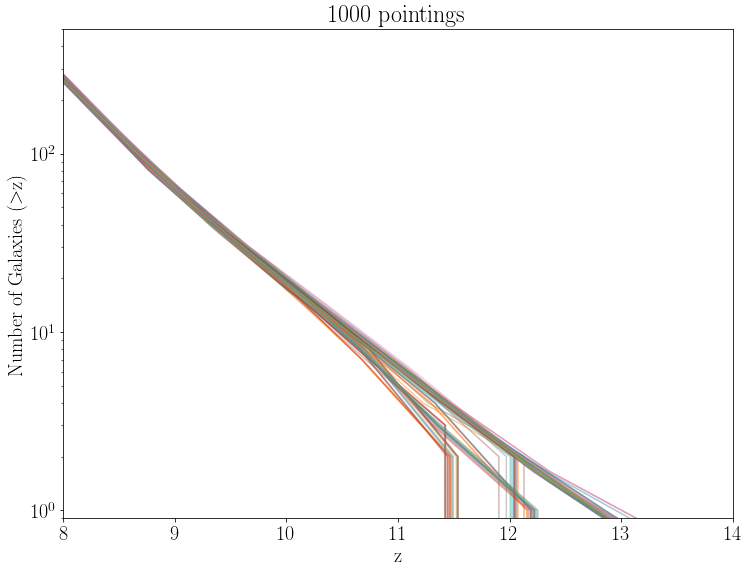

In [27]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design assuming 200 parallel pointings of JWST

    parallel_2000 = survey(28.5, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 1000)
    mean_2000, med_2000, z_vals_2000 = mean_median(parallel_2000)
    summed+=med_2000
    summean+=mean_2000

    ax.plot(z_vals_2000, mean_2000, alpha=0.4, label = "Mean")
    ax.plot(z_vals_2000, med_2000, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,5e2), xlim=(8,14), title='1000 pointings')
winsound.Beep(400,300)

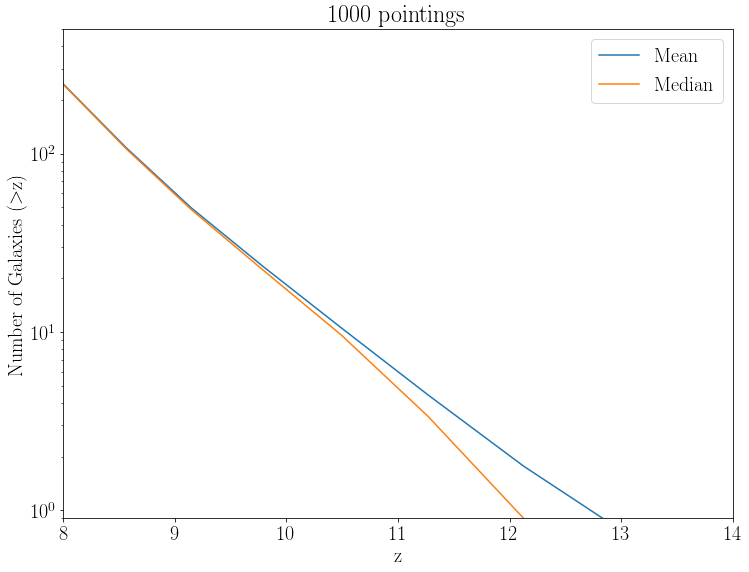

In [28]:
fig, ax =plt.subplots(figsize=(12,9))
mean1000final=summean/N
med1000final=summed/N  
ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")

ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,5e2), xlim=(8,14), title='1000 pointings')
ax.legend()
if save==1:
    plt.savefig("figs/"+file+"/1000.pdf")

In [29]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9986441990649654
0.9993530270116253


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(12.064999999997747, 12.126, 12.699999999997395)

In [30]:
# Survey design modeling the effect of lensing by increasing limiting magnitude of JADES Deep survey by 2
# Assumes this is over one JWST pointing

lensing_2 = survey(30.7 + 2, 2*4.84/3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4), 1)
mean_lens, med_lens, z_vals_lens = mean_median(lensing_2)

-1.998108203796864
-1.9024497305460053
-1.818941120080468
-1.745629715881182
-1.6809100003658017
-1.623480202521614
-1.5722989055384486
-1.526476565890952
-1.485275513338586
-1.4481099509256306
-1.4144808664305453
-1.3839326399988807
-1.3560964365103683
-1.3306685093953745
-1.3073668082678123
-1.285974371292229
-1.2662959328167178
-1.2481362271893717
-1.2313433811253742
-1.215787217523454
-1.20133755928234
-1.187885925484306
-1.1753672275787161
-1.16369468083139
-1.152781500508146
-1.1425625980583491
-1.1329728849313636
-1.1239689687600989
-1.1155074571774644
-1.10754495781637
-1.1000380783097252
-1.0929434262904394
-1.0862393055749675
-1.0799040199797645
-1.0738941771377395
-1.0681880808653477
-1.0627640349790435
-1.057600343295282
-1.0526970058140632
-1.0480323263518416
-1.0435846087250722
-1.0393321567502098
-1.0352749704272544
-1.031413049756206
-1.027703002369974
-1.0241448282685586
-1.0207385274519596
-1.0174624037366318
-1.0143164571225756
-1.0113006876097905
-1.0083933990147314

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

-2.014212668107849
-1.9170715039854513
-1.8322685235574385
-1.7578208044443557
-1.6920979438008736
-1.6337779933740224
-1.5818033945614265
-1.5352708160568893
-1.4934311538503948
-1.455689531228107
-1.4215392013597203
-1.3905174823566955
-1.3622498222140247
-1.3364277663393478
-1.3127648926111883
-1.291040876320718
-1.271057425229991
-1.252616247101062
-1.2355631146377517
-1.2197658330147625
-1.2050922074067978
-1.191432075459443
-1.1787193397600502
-1.1668658704250876
-1.155783537571024
-1.145406243785211
-1.1356678916550003
-1.1265244162386256
-1.117931752594322
-1.1098458357803234
-1.1022226008548641
-1.0950179828761786
-1.0882099493733841
-1.081776467875598
-1.0756734734410538
-1.0698789335988694
-1.064370815878162
-1.0591270878080485
-1.054147749388529
-1.0494107681487204
-1.0448941116177402
-1.0405757473247055
-1.0364556752696163
-1.0325338954524725
-1.0287663429315086
-1.0251530177067245
-1.0216939197781203
-1.0183670166748129
-1.0151723083968025
-1.0121097949440891
-1.009157443

  2%|█▋                                                                                 | 1/50 [01:00<49:43, 60.88s/it]

-2.010887344811101
-1.9140523334673238
-1.8295166204570723
-1.7553035328338873
-1.689787806175124
-1.6316516585164762
-1.579840864286499
-1.5334549391429158
-1.4917471399726203
-1.4541244648916747
-1.4200817641470942
-1.3891578140513723
-1.360979243047955
-1.3352385686785047
-1.3116502715174214
-1.2899947212373206
-1.2700742505435565
-1.251691192141483
-1.2346918048019315
-1.2189443103284707
-1.2043169305246704
-1.1906998502268382
-1.178027180336759
-1.1662110687234788
-1.155163663256044
-1.1448190748362395
-1.1351114143658494
-1.1259967557793973
-1.1174311730114062
-1.109370739996399
-1.101771530668899
-1.0945896189634297
-1.087803041847252
-1.0813898362876277
-1.0753060762190803
-1.0695297986088708
-1.064039040424261
-1.0588118386325127
-1.0538481932336254
-1.0491261411948611
-1.044623719483481
-1.040318965066747
-1.036211877944659
-1.0323024581172169
-1.0285467795189438
-1.0249448421498397
-1.0214966460099049
-1.0181802280664005
-1.014995588319327
-1.011942726768684
-1.0089996803817

  4%|███▎                                                                               | 2/50 [02:05<49:39, 62.08s/it]

-2.041448914485337
-1.941800188912954
-1.8548081397571132
-1.7784386583080132
-1.7110192551820393
-1.6511938579059908
-1.597877608501307
-1.5501438574446333
-1.5072241636678234
-1.4685082945579362
-1.4334764223335785
-1.4016539216291295
-1.372656571910516
-1.346167956267324
-1.321894258997027
-1.2996094680207582
-1.2791101724675373
-1.2601929614663838
-1.2426996265620918
-1.2264945605073403
-1.2114421560548099
-1.1974294071650666
-1.184388510214451
-1.1722290603714158
-1.1608606528044145
-1.1502154838897871
-1.1402257500038733
-1.1308462487309001
-1.1220317776550939
-1.1137371343606814
-1.1059171164318893
-1.098526521452944
-1.0915427482159592
-1.084943195513048
-1.078682660928437
-1.0727385432542393
-1.0670882412825689
-1.0617091538055383
-1.0566012808231482
-1.0517420211275115
-1.0471087735107416
-1.0426789367649518
-1.0384525108901421
-1.0344294958863127
-1.0305646893376899
-1.026858091244274
-1.0233097016060648
-1.019896919215176
-1.016619744071607
-1.013478176175358
-1.01044961431

  6%|████▉                                                                              | 3/50 [03:01<47:03, 60.08s/it]

-2.0012061677225423
-1.9052624740045967
-1.8215048697586518
-1.7479748763195642
-1.6830621890071051
-1.6254611553778464
-1.5741272534770452
-1.5281682874683582
-1.4868443876338429
-1.449568010373956
-1.4158386555853837
-1.3851993449129258
-1.3572801434976105
-1.3317763991026386
-1.3084052203652665
-1.2869489985449232
-1.267211885775094
-1.2489980341892648
-1.232155117669036
-1.216552570970064
-1.2020598288480064
-1.1885680869325776
-1.1760120626016057
-1.1643047123588626
-1.1533589927081194
-1.143109621027205
-1.1334913146939476
-1.124460551960233
-1.115973811077947
-1.1079875702989754
-1.1004583078752037
-1.093342502058518
-1.0866183919748607
-1.0802642167501746
-1.0742364546363459
-1.0685133447593171
-1.0630731262450313
-1.0578940382194313
-1.0529760806825168
-1.0482974927602309
-1.0438365135785166
-1.0395713822633164
-1.0355020988146306
-1.0316286632324592
-1.0279075537686875
-1.024338770423316
-1.0209223131963445
-1.017636421213716
-1.0144810944754301
-1.0114563329814872
-1.0085403

  8%|██████▋                                                                            | 4/50 [04:10<48:15, 62.95s/it]

-2.0399715681777764
-1.9404588575539208
-1.8535855476897294
-1.7773203063202563
-1.7099929269165455
-1.6502491879686332
-1.597005712268548
-1.5493371151178148
-1.5064760043274537
-1.4678129802179813
-1.432828924543911
-1.4010498597767553
-1.3720920898220248
-1.3456396296607278
-1.3213990646323721
-1.2991446911519635
-1.2786733759930076
-1.2597819859290094
-1.2423125284504737
-1.2261295814064037
-1.2110977226458033
-1.197104100376175
-1.1840810035220213
-1.1719381506493438
-1.1605852603241456
-1.1499546214709282
-1.1399785230141932
-1.130611824236942
-1.1218093844221761
-1.1135260628528962
-1.1057167188121038
-1.0983362115828
-1.0913619708064852
-1.0847714261246604
-1.0785194368203264
-1.0725834325349841
-1.0669408429101341
-1.061569097587277
-1.0564681965664124
-1.0516155694890414
-1.0469886459966644
-1.0425648557307818
-1.0383441986913942
-1.034326674878501
-1.0304671435751034
-1.0267656047812017
-1.023222058496796
-1.0198139343633865
-1.0165412323809735
-1.0134039525495568
-1.0103795

 10%|████████▎                                                                          | 5/50 [05:03<44:56, 59.92s/it]

-1.9983497250660256
-1.9026690156591448
-1.8191409933168714
-1.7458125476181077
-1.681077787772173
-1.6236346401650033
-1.5724414459053453
-1.5266084546902552
-1.485397824805096
-1.4482236231235388
-1.4145867214268582
-1.3840313939501314
-1.3561887198360403
-1.3307548819079695
-1.307447764216205
-1.2860503544917359
-1.2663673416924524
-1.2482034147762449
-1.2314066651548057
-1.2158468854667281
-1.201393868350606
-1.187939107671934
-1.1754174997500082
-1.1637422396772248
-1.1528265225459795
-1.1426052446755688
-1.1330133023852895
-1.1240072932213394
-1.1155438147299166
-1.1075794644572188
-1.1000708399494434
-1.092974538752789
-1.086268859640354
-1.0799321013852372
-1.0739208615336369
-1.0682134388586517
-1.0627881321333807
-1.0576232401309227
-1.0527187628512775
-1.0480529990675445
-1.0436042475528222
-1.0393508070802098
-1.035292677649707
-1.0314298592613138
-1.0277189494612284
-1.0241599482494506
-1.0207528556259804
-1.0174759703639167
-1.0143292924632594
-1.0113128219240088
-1.00840

 12%|█████████▉                                                                         | 6/50 [06:14<46:19, 63.16s/it]

-2.043111099235481
-1.943309341180411
-1.8561836966456042
-1.7796969331010182
-1.7121739926886175
-1.6522567203883751
-1.5988585921842677
-1.5510515354792762
-1.5080659290953848
-1.4692906032735806
-1.434204931922853
-1.402333560786192
-1.3732916792745897
-1.3467623845500396
-1.3224514096915354
-1.3001323955290724
-1.2796016188096466
-1.2606553562802538
-1.2431351565218904
-1.2269052040325539
-1.211829683310241
-1.19779541476995
-1.1847344906606794
-1.1725563673144268
-1.1611705010631905
-1.1505089841559695
-1.1405039088417621
-1.131110003286567
-1.122281995656384
-1.1139746141172118
-1.1061425868350494
-1.0987406419758958
-1.091746143622751
-1.0851364558586138
-1.0788663068494837
-1.0729130606783603
-1.067254081428243
-1.0618667331821312
-1.056751015940025
-1.0518842937849242
-1.047243930799828
-1.042807291067736
-1.0385743745886482
-1.0345451813625646
-1.0306744395554843
-1.0269621491674072
-1.0234083101983336
-1.0199902867312627
-1.0167080787661946
-1.0135616863031294
-1.01052847342

 14%|███████████▌                                                                       | 7/50 [07:07<43:12, 60.28s/it]

-2.0041596979685714
-1.9079440813694895
-1.823949091963759
-1.75021070038102
-1.6851140380278644
-1.62734975199072
-1.5758703599387278
-1.529781137380946
-1.488340117666349
-1.45095809198383
-1.4171331417165183
-1.3864069933446637
-1.3584086635427535
-1.332832636630954
-1.309395219477991
-1.287878186598269
-1.2680851350547517
-1.2498196619104034
-1.2329290093253071
-1.2172822420081055
-1.2027484246674414
-1.1892184445605167
-1.176626834041653
-1.1648863029166119
-1.1539095609911554
-1.1436311406196045
-1.1339855741562808
-1.1249292165040652
-1.1164184225658382
-1.1084095472444813
-1.100858945442875
-1.0937229720639001
-1.0869798045589973
-1.0806076203796071
-1.0745627744286101
-1.068823444157447
-1.063367807017558
-1.0581740404603837
-1.0532421444859241
-1.0485502965456195
-1.0440766740909107
-1.0397994545732376
-1.0357186379926007
-1.0318342243489997
-1.0281025685453156
-1.0245236705815486
-1.0210975304576981
-1.0178023256252053
-1.0146380560840698
-1.0116047218342914
-1.0086805003273

 16%|█████████████▎                                                                     | 8/50 [08:23<45:18, 64.72s/it]

-2.009669019165509
-1.9129461754963835
-1.8285083834159885
-1.7543812596332775
-1.688941422331168
-1.6308726159822966
-1.579121836164772
-1.5327896416015623
-1.4911301541604942
-1.4535510588542546
-1.4195477910640202
-1.3886596613552136
-1.3605137306617485
-1.3348028726939067
-1.3112418987540926
-1.289611432921079
-1.2697140368657611
-1.2513522722590344
-1.23437257595604
-1.2186433224040414
-1.2040328860503018
-1.190431578934208
-1.1777735882793916
-1.165971163717362
-1.1549365548796278
-1.144603948989821
-1.1349075332715735
-1.1258034325406399
-1.1172477716127744
-1.1091966753037317
-1.1016062684292665
-1.094432675805133
-1.087653959839209
-1.0812481829393712
-1.0751714699213746
-1.069401883193096
-1.0639174851624131
-1.0586963382372028
-1.0537384424174654
-1.0490218601110781
-1.044524653725918
-1.0402248856698626
-1.0361225559429117
-1.0322176645450654
-1.0284663362920783
-1.0248685711839502
-1.0214243692206812
-1.0181117928101489
-1.0149308419523526
-1.011881516647293
-1.00894187930

 18%|██████████████▉                                                                    | 9/50 [09:08<40:17, 58.96s/it]

-2.036856891065014
-1.9376309396424398
-1.851007966853715
-1.774962493989828
-1.7078291274455917
-1.6482575480816648
-1.5951675005865749
-1.5476362668817718
-1.5048986661216293
-1.4663470546934443
-1.4314638102604684
-1.3997763211239331
-1.3709019968610248
-1.3445257630058975
-1.3203550504116937
-1.2981648058885233
-1.2777524815654853
-1.2589155295716785
-1.2414964126741797
-1.225360098959055
-1.2103715565123698
-1.1964182587391796
-1.183432689682517
-1.1713248280664261
-1.1600046526149508
-1.149404647371124
-1.1394572963779785
-1.1301175889975368
-1.1213405145918203
-1.113081062522851
-1.1052942221526516
-1.0979349828432432
-1.090980839275637
-1.084409286130844
-1.0781753127708866
-1.0722564138767752
-1.066630084129521
-1.0612738182101351
-1.0561876161186174
-1.0513489725359788
-1.0467353821432304
-1.0423243396213833
-1.038115844970437
-1.0341098981903922
-1.0302614886432704
-1.0265706163290715
-1.023037281247796
-1.0196389780804545
-1.0163757068270471
-1.0132474674875738
-1.010231754

 20%|████████████████▍                                                                 | 10/50 [10:26<43:07, 64.68s/it]

-2.032374487761868
-1.9335612180859074
-1.8472985111267848
-1.7715693121621507
-1.7047151539758523
-1.6453913334196564
-1.592522087974977
-1.5451885371571885
-1.5026286825156263
-1.464237407633585
-1.4294992429709086
-1.3979435424257165
-1.3691893067726755
-1.342922771943865
-1.3188525855905011
-1.2967546305212116
-1.2764272012637619
-1.2576685923459165
-1.2403219217337158
-1.224252719112336
-1.2093265141669538
-1.1954312483018834
-1.182499686359713
-1.170442181463894
-1.159169086737877
-1.148613167024251
-1.138707187165604
-1.1294063237236616
-1.1206657532601496
-1.1124406523367933
-1.1046861975153186
-1.0973575653574508
-1.0904323441440529
-1.0838881221559873
-1.07768007595498
-1.0717857938218938
-1.0661828640375912
-1.060848874882935
-1.0557838263579256
-1.0509653067434253
-1.0463709043202971
-1.041978207369404
-1.0377872158907455
-1.0337979298843223
-1.0299655259118592
-1.0262900039733567
-1.0227713640688147
-1.019387194479096
-1.0161374952042004
-1.0130222662441282
-1.010019095879

 22%|██████████████████                                                                | 11/50 [11:12<38:27, 59.16s/it]

-2.041699619914068
-1.9420278126269848
-1.8550156134326135
-1.7786284424589112
-1.711193422922198
-1.6513541682411117
-1.598025569150563
-1.5502807614866212
-1.507351126186514
-1.4686262892886295
-1.433586302603445
-1.4017564308274837
-1.3727523644293598
-1.3462576132067559
-1.3219782934003763
-1.2996883405799944
-1.2791842967584057
-1.260262703948406
-1.2427653170488364
-1.2265564974015606
-1.2115006063484426
-1.1974846116743687
-1.184440694050271
-1.1722784277040585
-1.1609073868636406
-1.150259752199949
-1.1402677043839158
-1.1308860305294954
-1.1220695177506423
-1.1137729531613116
-1.1059511238754576
-1.0985588170070346
-1.0915734261130206
-1.084972344750392
-1.0787103600331043
-1.0727648655181343
-1.0671132547624593
-1.0617329213230569
-1.0566238651999267
-1.0517634799500462
-1.0471291591303928
-1.0426982962979436
-1.0384708914526988
-1.0344469445946582
-1.0305812428377765
-1.0268737861820538
-1.02332457462749
-1.0199110017310622
-1.0166330674927708
-1.0134907719126156
-1.01046150

 24%|███████████████████▋                                                              | 12/50 [12:29<40:52, 64.54s/it]

-2.021674159949043
-1.9238460381217894
-1.8384433524984967
-1.7634691579749566
-1.697281521909931
-1.6385491475672822
-1.5862069975580988
-1.5393453524460192
-1.4972098107472318
-1.459201288930474
-1.4248094565802263
-1.3935683598388398
-1.365100797964409
-1.3390961350518347
-1.315265923474953
-1.2933882804444083
-1.2732635114497797
-1.2546919219806458
-1.2375181940844575
-1.221609198087601
-1.2068318043164623
-1.1930750713763631
-1.1802724344304967
-1.1683351403631204
-1.1571744360584915
-1.1467237566798034
-1.1369165373902488
-1.1277084016319567
-1.1190549728470556
-1.1109118744776745
-1.1032347299659417
-1.095979162753986
-1.0891229845628723
-1.0826440071136643
-1.0764978538484908
-1.0706623364884167
-1.0651152667545056
-1.0598344563678226
-1.0548199053283671
-1.0500494253572037
-1.0455008281753966
-1.0411519255040105
-1.0370027173430452
-1.0330532036925004
-1.0292590079945054
-1.02562013024906
-1.0221365704561638
-1.0187861403368816
-1.0155688398912133
-1.0124846691191587
-1.009511

 26%|█████████████████████▎                                                            | 13/50 [13:13<36:00, 58.39s/it]

-2.002922030778302
-1.906820362573254
-1.8229248486423788
-1.749273785620184
-1.684254217406154
-1.626558341756628
-1.575139916876676
-1.5291052778997969
-1.4877133368879152
-1.450375582831384
-1.4165906915367992
-1.3859009322188798
-1.3579357609085878
-1.3323900237490696
-1.3089803635875317
-1.2874888133833635
-1.2677192028000162
-1.2494753615009404
-1.232604712557709
-1.216976475745956
-1.202459870841315
-1.1889459143234813
-1.1763692160802712
-1.1646425892954413
-1.153678847152747
-1.1434125995400053
-1.1337784563450335
-1.1247328241597092
-1.1162321095759105
-1.1082327191855152
-1.1006910595804014
-1.093563537352447
-1.0868283557975913
-1.0804637182117727
-1.0744260311868694
-1.0686934980188205
-1.063244322003565
-1.0580567064370416
-1.0531306513192507
-1.0484443599461308
-1.0439760356136212
-1.039703881617661
-1.0356278979582496
-1.0317480846353877
-1.0280208482409527
-1.0244461887749452
-1.0210241062373646
-1.0177328039241502
-1.014572281835302
-1.0115425399708198
-1.008621781626

 28%|██████████████████████▉                                                           | 14/50 [14:31<38:26, 64.07s/it]

-2.0100636307267608
-1.9133044563267045
-1.8288349479878938
-1.7546799808076288
-1.689215563199244
-1.6311249452276069
-1.5793547269446102
-1.533005129227913
-1.4913299937809392
-1.4537367831328794
-1.4197207431419319
-1.3888210113308004
-1.3606645085511968
-1.3349439931515903
-1.3113741693127015
-1.2897355787120084
-1.2698307088592413
-1.2514620472641296
-1.234475973100908
-1.2187408113760634
-1.2041248870960821
-1.1905184710997032
-1.1778557258901698
-1.1660488681384733
-1.1550101145156046
-1.144673627524807
-1.134973569669324
-1.125866049284651
-1.1173071747062835
-1.1092530542697174
-1.1016597963104477
-1.0944835091639704
-1.0877022469980333
-1.0812940639803839
-1.0752150684465178
-1.0694433145641828
-1.0639568565011268
-1.0587337484250974
-1.0537739903360948
-1.0490556364018666
-1.0445567407901606
-1.0402553576687248
-1.0361514870375588
-1.032245128896663
-1.0284923915815327
-1.0248932750921678
-1.0214477794285686
-1.0181339587584828
-1.0149518130819104
-1.0119013423988512
-1.0089

 30%|████████████████████████▌                                                         | 15/50 [15:15<33:52, 58.06s/it]

-2.0070801112069185
-1.9105956207126231
-1.8263659078724004
-1.7524214548489887
-1.6871428803095276
-1.6292171723625104
-1.57759392149473
-1.531375902913657
-1.4898190765474366
-1.45233258704489
-1.4184131131809394
-1.3876011007935574
-1.3595245298468164
-1.333877030899365
-1.310374118041376
-1.2887969559575985
-1.268948592864306
-1.250632076977773
-1.2336942235773227
-1.218003731473805
-1.2034292994780689
-1.1898615099324887
-1.177234712242489
-1.1654613722819696
-1.1544539559248295
-1.1441468125764935
-1.1344742916423864
-1.1253926260594578
-1.1168580487646573
-1.108826792694935
-1.10125509078724
-1.0940991759785228
-1.0873371647372578
-1.08094717353192
-1.0748854352994592
-1.0691300665083503
-1.063659183627068
-1.0584509031240872
-1.053505224999408
-1.0488002657215052
-1.0443141417588535
-1.0400249695799282
-1.035932749184729
-1.032037480573256
-1.0282953966824588
-1.0247064975123377
-1.0212707830628924
-1.0179663698025978
-1.014793257731454
-1.011751446849461
-1.0088190536250938
-1

 32%|██████████████████████████▏                                                       | 16/50 [16:34<36:25, 64.28s/it]

-2.037152578943941
-1.9378994044041964
-1.8512526661861248
-1.775186329880886
-1.7080345449745447
-1.6484466218612075
-1.5953420088561594
-1.547797734728706
-1.5050484087021752
-1.466486220453914
-1.4315934056349973
-1.3998972228833617
-1.3710149768106712
-1.3446315065088839
-1.3204541625633892
-1.2982578300398717
-1.2778399054974474
-1.2589977854952323
-1.2415738895792054
-1.2254331487887775
-1.210440494163359
-1.1964833682357923
-1.1834942365257826
-1.1713830530596037
-1.1600597718635295
-1.149456858457265
-1.139506778360516
-1.1301645085864187
-1.1213850261481106
-1.1131233080587284
-1.105334331331409
-1.097973072979289
-1.0910170215089372
-1.0844436654269218
-1.0782079817463799
-1.07228745897388
-1.0666595856159902
-1.061301850179279
-1.0562142526637466
-1.0513742815759612
-1.0467594254224917
-1.042347172709906
-1.0381375234382044
-1.034130477607387
-1.0302810122305903
-1.0265891273078147
-1.02305482283906
-1.0196555873308943
-1.0163914207833182
-1.0132623231963316
-1.0102457830765

 34%|███████████████████████████▉                                                      | 17/50 [17:19<32:11, 58.52s/it]

-2.0232006540276695
-1.9252319923605223
-1.839706617273916
-1.76462471485312
-1.698341993657135
-1.639525244409474
-1.5871078996889478
-1.5401789331566242
-1.4979828595558278
-1.4599197347121393
-1.4254784950695725
-1.3941925173813567
-1.3656840590191544
-1.3396420378184524
-1.3157775917693446
-1.2938685193257504
-1.2737148390961968
-1.2551165696892106
-1.2379181700225352
-1.221986319168522
-1.2071876961995223
-1.1934112003424957
-1.1805901711336175
-1.1686357279544555
-1.1574589901865773
-1.1469932973661585
-1.137171989029375
-1.1279506248670104
-1.1192847645698483
-1.1111299678286728
-1.1034417943342676
-1.0961758037774163
-1.089309776003511
-1.0828214908579437
-1.0766665080314977
-1.0708226073695655
-1.0652675687175386
-1.059979171920809
-1.0549574169793765
-1.0501800837386335
-1.0456249520439713
-1.0412698017407822
-1.0371146328290661
-1.0331594453088229
-1.0293597988708365
-1.0257156935151068
-1.0222271292416338
-1.0188718858958097
-1.015649963477634
-1.012561361987107
-1.00958386

 36%|█████████████████████████████▌                                                    | 18/50 [18:37<34:26, 64.57s/it]

-2.009715721976812
-1.9129885785166065
-1.8285470327741868
-1.754416613687765
-1.6889738672732058
-1.6309024794893177
-1.5791493991031476
-1.5328151448532148
-1.4911538054495113
-1.4535730395735005
-1.4195682601760593
-1.3886787573427708
-1.360531575428631
-1.3348195744906948
-1.311257553153371
-1.2896261257431278
-1.2697278451537863
-1.2513652642791682
-1.2343848131478008
-1.2186548603555651
-1.204043774498342
-1.1904418627393656
-1.1777833093765762
-1.1659803601405612
-1.1549452607619077
-1.1446121955385562
-1.1349153487684471
-1.1258108433168743
-1.117254802049131
-1.109203347830511
-1.101612603526308
-1.0944386920018156
-1.0876596746896807
-1.0812536130225499
-1.0751766298657168
-1.0694067866518284
-1.0639221448135314
-1.0587007657834726
-1.0537426495616522
-1.049025857580717
-1.0445284512733133
-1.0402284920720886
-1.0361259799770424
-1.032220914988175
-1.0284694199707798
-1.0248714949248572
-1.0214271398504067
-1.0181144161800753
-1.014933323913863
-1.01188386305177
-1.0089440950

 38%|███████████████████████████████▏                                                  | 19/50 [19:21<30:07, 58.30s/it]

-2.017045535826414
-1.9196435578684556
-1.8346128903338261
-1.7599652869044908
-1.6940659672745089
-1.6355894338985246
-1.5834752887402521
-1.5368177751436978
-1.4948657778331598
-1.4570228229132274
-1.4227808029915137
-1.3916757939271442
-1.3633322380822677
-1.337440852696301
-1.313714446634417
-1.291932103639056
-1.2718949990784145
-1.2534043083206892
-1.2363053899855885
-1.2204656943185763
-1.2057526715651175
-1.192055863596432
-1.1793089955352523
-1.1674237008785542
-1.1563116131233142
-1.1459064573922644
-1.1361419588081372
-1.1269739341194203
-1.118358200074602
-1.1102505734221704
-1.1026068709106138
-1.09538290928842
-1.0885565969298332
-1.0821058422090974
-1.075986461874701
-1.0701763643008877
-1.0646534578619016
-1.0593956509319868
-1.0544029435111435
-1.0496532439736155
-1.045124460693647
-1.0407945020454819
-1.0366633680291202
-1.0327310586445622
-1.0289533906402957
-1.0253303640163207
-1.0218619787726375
-1.01852614328349
-1.015322857548878
-1.0122521215688018
-1.0092918437

 40%|████████████████████████████████▊                                                 | 20/50 [20:39<32:07, 64.25s/it]

-2.003484010963653
-1.907330602888547
-1.8233899207200093
-1.7496992049373414
-1.6846446310457468
-1.626917692698093
-1.5754715848166745
-1.5294121613976173
-1.4879979355108794
-1.450640079300252
-1.4168369986660008
-1.3861307163866292
-1.3581504889971168
-1.332590998349799
-1.3091687347361305
-1.287665613764923
-1.2678853594841062
-1.2496316959416105
-1.2327519640636035
-1.2171153132153725
-1.202590892762204
-1.1890696605085034
-1.1764861911369144
-1.1647532508909613
-1.1537836060141688
-1.14351183118918
-1.1338725010986388
-1.124821998864307
-1.116316707607947
-1.108313010451321
-1.1007672905161914
-1.0936359309243202
-1.086897123236589
-1.0805290590138783
-1.074488121377951
-1.0687525018896875
-1.0633003921099695
-1.0581099835996781
-1.053181276358813
-1.0484924619482556
-1.044021731928887
-1.039747277861588
-1.035669099746359
-1.0317871975831998
-1.0280579544938726
-1.0244813704783777
-1.0210574455367147
-1.0177643712297653
-1.0146021475575289
-1.0115707745200055
-1.008648443678076

 42%|██████████████████████████████████▍                                               | 21/50 [21:24<28:15, 58.45s/it]

-2.034171479274386
-1.935192765851872
-1.848785628640882
-1.7729296357502775
-1.7059635431806792
-1.6465403963379952
-1.5935826315469517
-1.5461698298349198
-1.5035387169319137
-1.465083163270592
-1.4302868362565535
-1.3986783017818654
-1.3698759227115351
-1.3435654096402752
-1.3194549224060315
-1.2973199685764558
-1.2769585049624346
-1.2581684883748536
-1.2407927741110694
-1.2246966667116719
-1.2097454707172528
-1.1958269399116372
-1.182873726565121
-1.1707960337047643
-1.1595040643576278
-1.1489304707940071
-1.1390079052841973
-1.129691469341729
-1.1209362644801322
-1.112697392212937
-1.1049299540536743
-1.097589051515874
-1.090652235356301
-1.084097056331721
-1.0778786159556637
-1.0719744649848943
-1.0663621541761785
-1.061019234286281
-1.0559457053152017
-1.0511191180197061
-1.046517023156559
-1.0421169714825258
-1.0379189629976062
-1.0339229977018005
-1.0300841771086389
-1.0264025012181213
-1.0228779700302477
-1.0194881343017832
-1.016232994032728
-1.013112549223082
-1.01010435062

 44%|████████████████████████████████████                                              | 22/50 [22:42<29:56, 64.14s/it]

-2.0105408775961564
-1.9137377644743234
-1.8292298981994461
-1.7550412569568348
-1.689547111698856
-1.631430114549051
-1.5796363872062513
-1.5332657419548767
-1.4915716816649331
-1.4539613997920142
-1.419929912983477
-1.3890161494825604
-1.3608468607242679
-1.3351146655374255
-1.3115341385488004
-1.2898857217789825
-1.269971813046503
-1.2515948101698928
-1.234601022563565
-1.218858715439874
-1.2042361540111735
-1.1906235592877585
-1.1779550638758063
-1.1661428445835527
-1.1550990782192339
-1.1447578973890267
-1.1350534346991084
-1.1259417785535968
-1.1173790173566098
-1.1093212395122658
-1.1017245334246828
-1.0945449874979785
-1.087760645934212
-1.0813495529354422
-1.0752677969057876
-1.0694934220473067
-1.0640044725620588
-1.0587789926521027
-1.0538169823174386
-1.0490964857601255
-1.0445955471822221
-1.0402922107857877
-1.0361864765708222
-1.0322783445373256
-1.028523903089416
-1.0249231522270934
-1.0214760919503576
-1.018160766461268
-1.014977175759824
-1.0119253198460263
-1.0089832

 46%|█████████████████████████████████████▋                                            | 23/50 [23:27<26:19, 58.50s/it]

-1.9976373516953587
-1.9020222284187223
-1.818551461920248
-1.745273280574874
-1.6805828943797718
-1.6231791222515666
-1.572021019323559
-1.5262194451887767
-1.4850370638999735
-1.4478883439696317
-1.4142744993157903
-1.3837401165592687
-1.3559165277264438
-1.330500123897862
-1.3072089825054585
-1.2858262400353375
-1.266156719324993
-1.2480052432119186
-1.2312200072363875
-1.2156708932900622
-1.2012277832646052
-1.1877822454030686
-1.1752692206512838
-1.1636019636036925
-1.1526937288547363
-1.1424794573502464
-1.1328940900360542
-1.1238942542093806
-1.1154365771674464
-1.1074776862074722
-1.0999742086266795
-1.0928827717222882
-1.0861816891429097
-1.0798492745371537
-1.0738421552022415
-1.0681386447867833
-1.0627170569393893
-1.0575557053086706
-1.0526545898946267
-1.047992024345868
-1.043546322311005
-1.0392957974386485
-1.035240449728798
-1.0313802791814535
-1.0276719130938363
-1.024115351465946
-1.0207105942977825
-1.0174359552379568
-1.0142914342864684
-1.0112770314433175
-1.008371

 48%|███████████████████████████████████████▎                                          | 24/50 [24:43<27:35, 63.66s/it]

-2.001136330356485
-1.9051990663603324
-1.8214470751783887
-1.7479220093940842
-1.683013672242684
-1.6254164987798092
-1.5740860370499559
-1.5281301510077978
-1.4868090205181872
-1.449535141356153
-1.415808046959683
-1.3851707895982446
-1.357253459204263
-1.331751423957384
-1.3083818114529913
-1.2869270275336884
-1.2671912374578185
-1.2489786064837247
-1.2321368187012294
-1.2165353176158944
-1.2020435467332822
-1.1885527089746941
-1.1759975260929114
-1.1642909604249754
-1.1533459743079275
-1.1430972894945486
-1.1334796277376196
-1.1244494702056615
-1.115963298067195
-1.1079775924907405
-1.1004488346448187
-1.0933335056979505
-1.0866098462343963
-1.080256096838416
-1.0742287386785307
-1.0685060123390007
-1.0630661584040861
-1.0578874174580475
-1.052969789500885
-1.0482915151168584
-1.0438308348902285
-1.0395659894052556
-1.0354969786619395
-1.0316238026602802
-1.0279029425687987
-1.0243343983874948
-1.0209181701163685
-1.01763249833968
-1.0144773830574296
-1.0114528242696172
-1.00853706

 50%|█████████████████████████████████████████                                         | 25/50 [25:29<24:24, 58.56s/it]

-2.019547991951438
-1.9219156201858156
-1.83668382183565
-1.7618596476020283
-1.6958044502836223
-1.6371895970144905
-1.5849521815018792
-1.5381843046207284
-1.4961330744136707
-1.4582006060910326
-1.4238775903875365
-1.3926990058001025
-1.3642884063500471
-1.3383357777019844
-1.3145532494016263
-1.292719382637983
-1.2726348824811629
-1.254100454001275
-1.2369610900306258
-1.2210839272826215
-1.2063361024706676
-1.1926068961892693
-1.179829876795129
-1.167916468763851
-1.156778096571039
-1.146348328573396
-1.1365607331276246
-1.1273710224715274
-1.1187349088429057
-1.110608104479562
-1.1029463216192976
-1.0957052724999148
-1.0888628132403146
-1.082396799959398
-1.0762629448949665
-1.0704391041659218
-1.0649031338911643
-1.0596328901895953
-1.0546283730612145
-1.0498674386249232
-1.045327942999622
-1.0409877423042122
-1.0368468365386936
-1.0329052257030662
-1.0291186220351323
-1.0254870255348913
-1.0220104362023437
-1.0186667101563902
-1.0154558473970308
-1.0123778479242658
-1.009410567

 52%|██████████████████████████████████████████▋                                       | 26/50 [26:46<25:38, 64.10s/it]

-2.0057020074859397
-1.9093443949658306
-1.8252254449567809
-1.7513782295552276
-1.6861854969293517
-1.6283359618101119
-1.576780595982274
-1.5306233545119925
-1.4891211757468106
-1.451683981315659
-1.4178091118654053
-1.3870376175518841
-1.3589979675488677
-1.333384195293579
-1.3099121889777257
-1.2883634010564675
-1.2685411387394478
-1.2502487092363108
-1.233333129265668
-1.217663270300615
-1.2031080038142479
-1.1895580560341463
-1.1769478626968584
-1.1651900047844475
-1.154197063278978
-1.1439034739169978
-1.1342436724350544
-1.12517394932418
-1.1166505950754064
-1.1086299001797657
-1.1010681551282897
-1.0939216504120104
-1.0871685312764436
-1.0807869429671053
-1.0747331759750278
-1.0689853755457266
-1.063521686924718
-1.0583202553575177
-1.0533810808441257
-1.0486823086300583
-1.0442020839608313
-1.0399185520819605
-1.035831712993446
-1.0319415666952878
-1.0282044036785178
-1.0246202239431361
-1.0211890274891426
-1.0178889595620535
-1.0147200201618685
-1.0116822092885875
-1.0087536

 54%|████████████████████████████████████████████▎                                     | 27/50 [27:39<23:16, 60.71s/it]

-2.0085730459060476
-1.9119511052856595
-1.827601400262327
-1.7535516072579516
-1.688180037997208
-1.630171810094698
-1.578475017642102
-1.5321911576760645
-1.4905751301781927
-1.453035238075057
-1.4190674431189216
-1.3882115364748966
-1.3600949681337855
-1.3344109322056625
-1.310874537507024
-1.2892666369736372
-1.2693899982476922
-1.251047388971379
-1.2340854061997346
-1.218372561694219
-1.2037773672162924
-1.190190249233838
-1.1775454636275864
-1.1657553515718437
-1.1547322542409173
-1.1444104275155367
-1.1347241272764323
-1.1256295241107572
-1.1170827886056651
-1.1090400913483092
-1.1014576029258427
-1.0942914939254194
-1.0875198496406155
-1.0811207553650082
-1.0750503816857504
-1.0692868138964189
-1.0638081372905905
-1.058592437161842
-1.0536397135101734
-1.048928051629161
-1.0444355368123817
-1.0401402543534124
-1.0360422042522528
-1.032141386508903
-1.0283939717105164
-1.0247999598570932
-1.021359350948633
-1.0180502302787127
-1.014872597847332
-1.0118264536544916
-1.00888988299

 56%|█████████████████████████████████████████████▉                                    | 28/50 [28:49<23:15, 63.45s/it]

-2.034108898762105
-1.9351359469441065
-1.848733839539372
-1.7728822622671978
-1.705920067830117
-1.6465003800409943
-1.5935456979501215
-1.546135656162956
-1.5035070248401212
-1.4650537096974061
-1.4302594081964088
-1.3986527136716318
-1.369852011203387
-1.3435430296813424
-1.3194339459316191
-1.2973002805896943
-1.276940002227498
-1.2581510794169593
-1.2407763766029127
-1.224681206166645
-1.2097308804894422
-1.1958131598890434
-1.1828607005560914
-1.1707837107447774
-1.1594923987092924
-1.1489194206402797
-1.1389974327283825
-1.129681539100696
-1.120926843884316
-1.112688451206338
-1.1049214651938573
-1.0975809899739695
-1.0906445776102223
-1.0840897801661633
-1.0778717017688884
-1.0719678944819448
-1.0663559103688809
-1.061013301493244
-1.055940067855034
-1.0511137615177988
-1.0465119345450862
-1.042112139000444
-1.0379143748838722
-1.0339186421953703
-1.0300800450620347
-1.0263985834838645
-1.0228742574608602
-1.0194846190565696
-1.0162296682709924
-1.0131094051041287
-1.0101013816

 58%|███████████████████████████████████████████████▌                                  | 29/50 [29:44<21:20, 60.98s/it]

-2.0296593272734516
-1.9310960344730455
-1.8450515540945553
-1.7695139341416017
-1.7028289029727173
-1.6436551592569824
-1.5909196619296615
-1.5437058550812928
-1.5012536679576884
-1.4629595149599348
-1.4283092305778462
-1.3968333593456004
-1.3681518658861036
-1.341951779888808
-1.317942486065348
-1.295900434193903
-1.2756244290748355
-1.2569132755085075
-1.2396104883396453
-1.2235819374351564
-1.2086934926619493
-1.1948333789091137
-1.181934531110104
-1.1699075291761918
-1.1586629530186494
-1.1481337375709308
-1.13825281776649
-1.128975483560963
-1.1202570249099857
-1.1120527317691944
-1.1043178940942249
-1.0970078018407134
-1.0901000999864776
-1.0835724335093357
-1.0773800923649237
-1.0715007215310597
-1.0659119659855614
-1.0605914707062472
-1.0555392356931168
-1.0507329059239883
-1.0461501263766797
-1.0417685420290093
-1.0375881528809765
-1.0336089589325819
-1.029786250139461
-1.0261200265016144
-1.0226102880190413
-1.0192346796695606
-1.0159932014531716
-1.0128858533698746
-1.00989

 60%|█████████████████████████████████████████████████▏                                | 30/50 [30:50<20:48, 62.40s/it]

-2.0355711843526096
-1.9364636041822014
-1.8499439679663023
-1.7739892132836517
-1.7069359332545462
-1.6474354195981458
-1.5944087056897782
-1.5469341742042033
-1.5042475571156106
-1.465741935697623
-1.4309003051092508
-1.3992506174522008
-1.3704107387135678
-1.344065970294489
-1.3199240920674493
-1.2977603193189753
-1.277372345806941
-1.25855786528922
-1.2411595284663814
-1.225042464510341
-1.2100718025930148
-1.1961351503576658
-1.1831650723902527
-1.1710716548053854
-1.1597649837176751
-1.1491776237130795
-1.1392421393775567
-1.1299135737684118
-1.1211469699429506
-1.112897370958478
-1.1051198198722996
-1.0977693597417204
-1.0908235120953933
-1.084259798461971
-1.0780332618987587
-1.072121423934409
-1.0665018060975748
-1.0611519299169088
-1.0560717953924106
-1.0512389240527333
-1.0466308374265292
-1.0422250570424512
-1.0380215829004993
-1.0340204150006733
-1.0301765964002787
-1.0264901270993154
-1.0229610070977837
-1.0195667579243357
-1.0163073795789719
-1.0131828720616922
-1.010170

 62%|██████████████████████████████████████████████████▊                               | 31/50 [31:48<19:21, 61.14s/it]

-2.0048677015476617
-1.9085869011322503
-1.824535007097567
-1.7507466594895664
-1.685605895679366
-1.6278024756976026
-1.5762882075687856
-1.5301677606471822
-1.48869866561682
-1.4512913144914856
-1.4174434486162557
-1.3866964840018534
-1.3586791859902925
-1.3330858319220542
-1.3096325364704433
-1.2881009263072327
-1.2682944654370178
-1.2500166178643937
-1.2331145222596016
-1.217457154625705
-1.2029134909657675
-1.1893743446156757
-1.176774203576961
-1.165025718518333
-1.1540415401085005
-1.143756156348995
-1.134104055241349
-1.1250415621199166
-1.1165250023190523
-1.1085107011731108
-1.1009549840164465
-1.0938141761834141
-1.087066440341191
-1.0806899391569542
-1.0746409979650584
-1.0688977794326806
-1.0634384462269983
-1.058241161015189
-1.0533059237972522
-1.0486108972403656
-1.044134244011706
-1.0398541267784513
-1.035770545540601
-1.0318835002981552
-1.0281493163854685
-1.024567993802541
-1.0211395325493726
-1.0178420952931406
-1.014675682033845
-1.0116402927714856
-1.008714090173

 64%|████████████████████████████████████████████████████▍                             | 32/50 [32:55<18:54, 63.02s/it]

-2.01571777159143
-1.9184380369985874
-1.83351408634133
-1.7589601686300091
-1.6931435552731373
-1.6347404122776161
-1.5826916724489668
-1.5360927158919058
-1.4941933700103438
-1.4563979095073865
-1.4221988646856798
-1.391132893647639
-1.3628249100952197
-1.3369660194300326
-1.3132693909535724
-1.29151438566699
-1.2715024284713201
-1.2530349442675985
-1.23595748575663
-1.220137669539105
-1.2054431122157137
-1.191763494287031
-1.179032624053402
-1.167162245915287
-1.156064104273146
-1.1456720074273241
-1.1359197636781664
-1.126763245225903
-1.118158324270764
-1.110060873012979
-1.102426763652779
-1.0952118683903929
-1.0883941233259367
-1.0819514645595247
-1.0758397642913875
-1.0700369586216398
-1.0645209836503968
-1.0592697754777733
-1.0542833341037696
-1.0495395956285007
-1.0450164961520814
-1.0406919717746268
-1.036566022496137
-1.0326386483166121
-1.0288657214362817
-1.0252472418551464
-1.0217832095732058
-1.0184515606905749
-1.015252295207254
-1.0121854131232428
-1.0092288505386566


 66%|██████████████████████████████████████████████████████                            | 33/50 [33:57<17:42, 62.49s/it]

-2.0393246919090573
-1.9398715372890605
-1.8530502190462914
-1.7768306206201245
-1.7095435350607118
-1.649835551327636
-1.596623940588563
-1.5489838719658744
-1.506148412536667
-1.4675085273327537
-1.4325454087886405
-1.4007853630401814
-1.3718449236259251
-1.345408294636441
-1.3211822370129713
-1.2989411822487806
-1.2784821186878061
-1.259602034673985
-1.242143032252602
-1.2259697703196153
-1.2109469077709833
-1.1969616603533382
-1.1839463575146585
-1.1718107718522501
-1.1604646759634185
-1.1498403992961428
-1.1398702712984021
-1.1305091782688492
-1.121712006506137
-1.113433642308918
-1.105628971975845
-1.0982528818055706
-1.0912828149474216
-1.0846962145507242
-1.0784479669141311
-1.0725155151869685
-1.0668763025185632
-1.0615077720582413
-1.056409923806003
-1.0515602009111742
-1.046936046523082
-1.0425149037910522
-1.038296772715085
-1.0342816532951802
-1.0304244318299909
-1.026725108319517
-1.0231836827637584
-1.0197775983120416
-1.0165068549643665
-1.0133714527207331
-1.0103488347

 68%|███████████████████████████████████████████████████████▊                          | 34/50 [34:53<16:10, 60.64s/it]

-2.019662793544615
-1.9220198523324743
-1.836778826992141
-1.7619465524727889
-1.695884204177072
-1.6372630054044395
-1.585019934794451
-1.538246994935063
-1.4961912123626304
-1.4582546375619052
-1.4239279061310097
-1.3927459462247511
-1.3643322711113068
-1.3383768328938812
-1.3145917299540222
-1.2927554995083042
-1.2726688250516445
-1.254132390078961
-1.2369911706418557
-1.2211122890702737
-1.20636286769416
-1.1926321751218019
-1.1798537725181717
-1.1679390747698994
-1.1567994967636155
-1.1463685996642916
-1.136579944636901
-1.1273892391247577
-1.1187521905711777
-1.1106245064194753
-1.1029618941129657
-1.095720061094964
-1.0888768610871273
-1.0824101478111134
-1.0762756287102373
-1.0704511575061564
-1.0649145879205282
-1.05964377367501
-1.054638714769602
-1.0498772649259616
-1.0453372778657464
-1.0409966073106138
-1.036855253260564
-1.0329132157155965
-1.0291262021190268
-1.0254942124708546
-1.02201724677108
-1.0186731587413604
-1.015461948381696
-1.0123836156920867
-1.00941601439419

 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [36:02<15:45, 63.06s/it]

-2.0226631899069956
-1.9247440109876206
-1.839261833700101
-1.7642178542107456
-1.6979686115896309
-1.6391815699476293
-1.586790700573439
-1.5398854372761561
-1.4977106763852754
-1.4596667767506895
-1.425242932948233
-1.3939727574167111
-1.3654786983208713
-1.339449830619917
-1.3155974382045375
-1.2936994317598778
-1.2735559309025695
-1.254967055249243
-1.2377773422795
-1.2218535384044282
-1.2070623900351145
-1.193292852514132
-1.180478299047024
-1.1685298939078486
-1.1573588013706644
-1.1468983946410147
-1.1370820469244431
-1.127865340357979
-1.1192038570786513
-1.111053179223489
-1.1033688889295212
-1.0961065683337772
-1.0892440085047712
-1.0827590005110181
-1.076607126489547
-1.070766177508872
-1.065213944637508
-1.0599282189439696
-1.0549090004282564
-1.0501340801588834
-1.045581249204365
-1.0412282986332158
-1.0370752284454354
-1.0331220386410243
-1.0293243113570114
-1.0256820465933967
-1.02219524435018
-1.0188416956958761
-1.0156214006304851
-1.0125343591540068
-1.009558362334955

 72%|███████████████████████████████████████████████████████████                       | 36/50 [37:06<14:48, 63.49s/it]

-2.0309383449265876
-1.9322572967161147
-1.8461100173869904
-1.7704821512261406
-1.7037174502028156
-1.6444730105082996
-1.59167450909562
-1.5444042950288206
-1.5019013894829625
-1.463561485744124
-1.4288698040189636
-1.3973563279744305
-1.3686405681980558
-1.3424091804678056
-1.318371202291791
-1.29630281636856
-1.2760025871268046
-1.257269078995218
-1.239945619862783
-1.2238979193486281
-1.2089916870718818
-1.1951150143818177
-1.1822007560879997
-1.1701593852698473
-1.1589013750067791
-1.1483595801083593
-1.1384668553841524
-1.1291784373738674
-1.1204495626172142
-1.112235467653902
-1.1044913890236403
-1.0971725632661387
-1.090256608651252
-1.0837211434488345
-1.077521404198596
-1.0716350091703915
-1.0660395766340753
-1.0607127248595023
-1.0556544538466723
-1.0508423818654404
-1.0462541271856611
-1.0418673080771894
-1.0376819245400248
-1.0336979765741676
-1.0298707007193273
-1.0262000969755039
-1.0226861653426973
-1.0193065240907624
-1.016061173219699
-1.012950112729507
-1.0099509608

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [38:09<13:43, 63.32s/it]

-2.0054245786234577
-1.9090925081663417
-1.8249958560480748
-1.7511682157499133
-1.6859927641342232
-1.6281585635218425
-1.5766168637694418
-1.5304718574629255
-1.488980679917436
-1.45155340917735
-1.4176875191323217
-1.3869241815946445
-1.3588919642218888
-1.3332849815555834
-1.3098191970985766
-1.288276121237675
-1.2684591133210035
-1.2501715326966882
-1.2332604366354936
-1.217594731369503
-1.2030433231308004
-1.189496967112789
-1.1768901164315109
-1.1651353752416882
-1.1541453476980434
-1.1438544869166187
-1.134197246013456
-1.125129927065916
-1.1166088321513605
-1.1085902633471507
-1.1010305227306476
-1.0938859123792126
-1.0871345833315262
-1.0807546866262694
-1.074702524340803
-1.068956247513808
-1.0634940071839645
-1.0582939543899539
-1.0533560891317755
-1.0486585624481102
-1.0441795253776387
-1.0398971289590417
-1.0358113731923189
-1.0319222580774705
-1.0281860856918577
-1.0246028560354805
-1.0211725691083389
-1.0178733759491136
-1.0147052765578044
-1.0116682709344116
-1.0087405

 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [39:10<12:32, 62.70s/it]

-2.023655200912766
-1.9256446904449263
-1.8400827818963403
-1.7649688071014138
-1.6986577722351024
-1.6398158985203435
-1.5873761629354866
-1.540427149982872
-1.4982130516888306
-1.4601336676036845
-1.4256777158628924
-1.3943783738944826
-1.3658577377116206
-1.3398045922663249
-1.3159299521568988
-1.294011520920498
-1.2738492317405639
-1.255243017800536
-1.2380372715764245
-1.2220986151905227
-1.2072936707651243
-1.1935112900688074
-1.180684784162719
-1.1687252344617216
-1.1575437223806775
-1.1470735589807335
-1.1372480553230369
-1.1280227521150183
-1.1193531900641094
-1.1111949098777412
-1.103503452263345
-1.096234357928352
-1.089365397226478
-1.0828743405114385
-1.0767167284906647
-1.0708703315178723
-1.0653129199467768
-1.060022264131094
-1.0549983640708236
-1.0502189901196815
-1.0456619126313833
-1.0413049019596443
-1.037147958104465
-1.033191081065845
-1.0293898115512157
-1.025744149560577
-1.022254095093929
-1.0188974185049873
-1.015674119793752
-1.012584198960223
-1.009605426358

 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [40:11<11:23, 62.11s/it]

-2.005726856341008
-1.9093669560595756
-1.8252460088644675
-1.7513970401525238
-1.6862027596944809
-1.628351851088232
-1.5767952612120926
-1.5306369238579567
-1.4891337597312977
-1.451695676451168
-1.417820002730093
-1.3870477778273356
-1.3590074620956327
-1.3333930817078263
-1.3099205181101268
-1.2883712185688494
-1.2685484856236784
-1.2502556218142977
-1.2333396402271286
-1.2176694092219604
-1.2031137971585824
-1.1895635276701524
-1.1769530349365651
-1.1651948978643467
-1.1542016953600238
-1.1439078616034906
-1.1342478307746422
-1.1251778923267413
-1.1166543357130516
-1.1086334503868356
-1.101071525801357
-1.0939248514098785
-1.087171571939032
-1.0807898321154488
-1.0747359213923922
-1.0689879844964936
-1.0635241661543848
-1.058322611092697
-1.0533833193114308
-1.0486844355372171
-1.0442041044966879
-1.0399204709164744
-1.035833534796577
-1.0319432961369954
-1.028206044390993
-1.0246217795585697
-1.0211905016397251
-1.0178903553610914
-1.0147213407226683
-1.0116834577244558
-1.008754

 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [41:12<10:17, 61.71s/it]

-2.0089429813515673
-1.9122869818579662
-1.8279075438786352
-1.7538316485987808
-1.6884370361040175
-1.6304083605178161
-1.5786933451389535
-1.5323931702851352
-1.4907624732929943
-1.4532093485180932
-1.419229580041096
-1.388362796805217
-1.3602363174787733
-1.3345432280239082
-1.3109985368340404
-1.2893830195964149
-1.2694993744295524
-1.2511502994519739
-1.2341823376447507
-1.2184639544202298
-1.2038636151907587
-1.1902717077999598
-1.1776224649540066
-1.165828196927797
-1.1548012139962296
-1.1444757488654775
-1.1347860342417144
-1.1256882252623892
-1.1171384770649513
-1.1090929447868492
-1.1015077835655323
-1.0943391485384497
-1.0875651172743257
-1.0811637673418848
-1.0750912538785764
-1.0693256544531244
-1.063845046634254
-1.058627507990689
-1.0536730385224302
-1.0489597157982016
-1.0444656173867277
-1.0401688208567332
-1.036069326208218
-1.0321671334411822
-1.0284183976930747
-1.0248231189638957
-1.021381297253645
-1.018071010131047
-1.0148922575961021
-1.0118450396488101
-1.00890

 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [42:14<09:15, 61.73s/it]

-2.0377583578364766
-1.938449411007956
-1.851753984302813
-1.7756449048440759
-1.708455386044013
-1.6488339793179767
-1.595699525798249
-1.5481285356186536
-1.5053551879145572
-1.4667713308228685
-1.4318589090528056
-1.400144915599742
-1.3712464400313609
-1.3448481443445781
-1.320657214679386
-1.2984484096050106
-1.2780190118337547
-1.2591663040779206
-1.2417326173359666
-1.2255828067494279
-1.2105817274598396
-1.1966167587518144
-1.1836203281961202
-1.1715023392204467
-1.1601726952524845
-1.1495638238630008
-1.1396081526227635
-1.1302606332456178
-1.1214762174454083
-1.1132098569359805
-1.1054165034311794
-1.0980511086448501
-1.091091148433915
-1.0845140986552966
-1.0782749110228402
-1.0723510613934684
-1.0667200256241034
-1.0613592795716678
-1.056268823236162
-1.051426132474508
-1.0468086831436287
-1.0423939511004465
-1.0381819363449616
-1.0341726388771737
-1.0303210104109282
-1.0266270509462248
-1.0230907604830635
-1.019689614878367
-1.0164236141321354
-1.0132927582443685
-1.0102745

 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [43:17<08:18, 62.32s/it]

-2.0407906066020223
-1.941202489508779
-1.8542633507716748
-1.7779403188691871
-1.7105619216613976
-1.6507729114672913
-1.5974890901420566
-1.549784371770333
-1.5068907826662121
-1.4681984613732375
-1.4331878962803533
-1.4013847506992043
-1.3724050377868362
-1.3459325330843457
-1.3216735995941793
-1.299402362702835
-1.27891553525816
-1.2600098301080025
-1.2425271350229108
-1.226331925234783
-1.211288675975518
-1.1972844499383641
-1.184251484739271
-1.1720994305328378
-1.160737937473663
-1.1500992431776962
-1.1401155852608866
-1.1307417888005338
-1.1219326788739372
-1.1136430805583961
-1.1058278189312103
-1.0984417190696794
-1.0914621935124527
-1.0848666547981802
-1.0786099280041617
-1.0726694256690463
-1.0670225603314845
-1.0616467445301254
-1.0565419782649694
-1.051685674074666
-1.0470552444978654
-1.0426281020732167
-1.0384042468007204
-1.0343836786803762
-1.0305212227894838
-1.0268168791280432
-1.0232706476960542
-1.019859941032167
-1.0165847591363808
-1.0134451020086965
-1.01041838

 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [44:18<07:13, 61.87s/it]

-2.02591660242531
-1.9276978913421137
-1.8419542263479602
-1.7666806893213964
-1.7002287920292267
-1.6412619223904832
-1.5887107907403901
-1.5416620454902854
-1.4993582731276205
-1.461197998215959
-1.4266688527909297
-1.3953030226241934
-1.3667218009594755
-1.34061331164455
-1.316687955395207
-1.2947229635312854
-1.274517844240639
-1.2558721057111233
-1.2386298098666246
-1.2226572954990464
-1.207820901400292
-1.1940092432302802
-1.1811554903849628
-1.1691705353922752
-1.1579652707801529
-1.1474728659445472
-1.1376264902814097
-1.1283815900547083
-1.1196936115284106
-1.1115180009664845
-1.1038102046328973
-1.0965256687916167
-1.089642116574627
-1.0831372711139118
-1.0769665786734388
-1.071107762385192
-1.065538545381155
-1.0602366507933119
-1.0552020786216623
-1.0504125519981904
-1.0458457940548802
-1.0414795279237152
-1.0373137536046955
-1.0333484710978211
-1.02953912666706
-1.0258857203124117
-1.0223882520338763
-1.019024444963438
-1.0157942991010966
-1.012697814446852
-1.009712714132

 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [45:23<06:15, 62.63s/it]

-2.043562671998894
-1.9437193389618055
-1.8565574000051819
-1.78003877393752
-1.7124877051124725
-1.6525454727357038
-1.599125100171746
-1.5512981282111356
-1.5082946150704164
-1.4695031363921374
-1.4344028492051364
-1.4025182012313961
-1.3734642215791883
-1.3469238753965014
-1.3226027731778955
-1.3002744614576485
-1.27973513211661
-1.2607809770356295
-1.2432534787887013
-1.227016765296392
-1.2119349644792676
-1.1978948496044672
-1.184828484632274
-1.172645288176399
-1.161254678850553
-1.150588720615019
-1.1405794774300806
-1.1311816586025933
-1.1223499734394125
-1.1140391312473936
-1.1062038413333921
-1.0987988130042634
-1.0918014009134356
-1.085188959714336
-1.0789161987138205
-1.0729604725653163
-1.0672991359222517
-1.061909543438054
-1.0567916951127236
-1.0519229455996881
-1.0472806495523752
-1.0428421616242125
-1.0386074818152
-1.034576610125338
-1.0307042558614818
-1.0269904190236314
-1.0234350996117867
-1.0200156522793757
-1.0167320770263981
-1.0135843738528543
-1.01054989741217

 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [46:20<05:05, 61.14s/it]

-1.9966590716465311
-1.9011340157493613
-1.8177418769087614
-1.7445327220263533
-1.6799032727768055
-1.6225535737611991
-1.5714436606604
-1.525685230618481
-1.484541642242721
-1.4474279156036076
-1.4138457344648883
-1.3833401144369422
-1.3555427348234086
-1.330150272697874
-1.306881071057239
-1.2855184706683505
-1.265867478221371
-1.2477331004064625
-1.2309636757604183
-1.2154292087433463
-1.2009997038153546
-1.1875668313598668
-1.1750655936069372
-1.1634093268633043
-1.1525113674357073
-1.1423067175541997
-1.1327303794488357
-1.1237390212729852
-1.115289311180017
-1.1073379173233011
-1.0998415078562063
-1.0927567509321023
-1.0860619806276737
-1.0797355310196053
-1.0737340702612665
-1.068035932429342
-1.0626194516005163
-1.0574629618514741
-1.0525664631822158
-1.0479082896694258
-1.0434667753897886
-1.0392202544199893
-1.0351687267600278
-1.0313121924099038
-1.0276073195229871
-1.0240541080992775
-1.0206525581387749
-1.0173810037181643
-1.0142394448374454
-1.0112278814966182
-1.0083246

 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [47:28<04:12, 63.09s/it]

-2.022487351993462
-1.924584361955892
-1.8391163173528968
-1.7640847448110626
-1.6978464551122487
-1.6390691326741795
-1.5866869250310345
-1.5397894165349248
-1.4976216283558945
-1.4595840184819193
-1.4251658659397934
-1.3939008602757204
-1.365411512074722
-1.339386947700934
-1.3155384987781964
-1.2936441127094636
-1.2735039421573937
-1.2549181397846456
-1.2377312687732873
-1.221810097565091
-1.2070213946018291
-1.193254133584979
-1.1804416987354263
-1.1684952690143529
-1.1573260233829403
-1.146867346062075
-1.137052621272643
-1.1278374384952352
-1.119177387210442
-1.1110280568988549
-1.1033450370410642
-1.0960839171176608
-1.0892224918689404
-1.0827385560351979
-1.0765876990970245
-1.0707477157947154
-1.065196400868566
-1.0599115490588717
-1.0548931603656329
-1.0501190295291445
-1.045566951289702
-1.041214720387601
-1.037062336822841
-1.033109800595423
-1.0293127011859367
-1.0256710385943828
-1.022184812820761
-1.0188318186053669
-1.0156120559482003
-1.012525524849261
-1.0095500200488

 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [48:26<03:04, 61.46s/it]

-1.9998558189605062
-1.9040364478989498
-1.8203873757247764
-1.746952661545371
-1.682124087293472
-1.6245976923740026
-1.573330308310902
-1.5274308953642004
-1.4861605425300213
-1.4489324675405804
-1.415246818834431
-1.3846472102032965
-1.3567641861452389
-1.331293489188073
-1.3079525945361992
-1.2865241754237713
-1.2668126377615279
-1.2486223874602072
-1.2318012957837172
-1.21621896667255
-1.201745004067198
-1.1882707445847385
-1.175730990195417
-1.1640388101928956
-1.1531072738708354
-1.1428711831994829
-1.1332653401490842
-1.12424627936647
-1.1157705354984713
-1.1077946431919183
-1.1002751370936426
-1.0931685518504741
-1.086453154785829
-1.0801072132231222
-1.0740872618091846
-1.0683715678674315
-1.0629383987212784
-1.0577660216941405
-1.0528544367860182
-1.0481819113203263
-1.0437267126204808
-1.039467108009897
-1.0354030974885744
-1.0315346810565134
-1.0278183933605445
-1.0242542344006682
-1.0208422041768839
-1.0175605700126076
-1.0144093319078387
-1.0113884898625776
-1.0084763112

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [49:30<02:04, 62.38s/it]

-2.001254565852446
-1.9053064162604012
-1.8215449220939735
-1.7480115137311882
-1.6830958117050896
-1.6254921029343607
-1.5741558169539496
-1.5281947164916225
-1.486868897467968
-1.4495907889963935
-1.4158598677290608
-1.3852191340875095
-1.3572986360320336
-1.3317937071769925
-1.3084214430214343
-1.286964224718473
-1.2672261953059112
-1.2490114978215516
-1.232167799072574
-1.2165645277508466
-1.2020711125482377
-1.1885787440413047
-1.1760221365759815
-1.1643142426135138
-1.1533680146151473
-1.1431181669268158
-1.1334994138944539
-1.1244682317486843
-1.1159810967201296
-1.1079944850394128
-1.1004648729371564
-1.0933487366439838
-1.086624314275206
-1.0802698439461342
-1.0742418018873914
-1.0685184262142893
-1.0630779550421388
-1.0578986264862515
-1.0529804405466276
-1.0483016353385783
-1.043840448977415
-1.039575119578449
-1.0355056471416806
-1.0316320316671095
-1.0279107493853585
-1.0243418002964277
-1.0209251844003173
-1.0176391398123386
-1.0144836665324912
-1.0114587645607755
-1.0085

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [50:27<01:00, 60.70s/it]

-2.0012866946141488
-1.9053355870210944
-1.8215715105580266
-1.7480358352219114
-1.6831181318991442
-1.6255126472543688
-1.5741747786193008
-1.5282122612147802
-1.4868851681507724
-1.4496059104263672
-1.4158739492630117
-1.3852322709933313
-1.3573109121723088
-1.3318051970216942
-1.3084322123188272
-1.2869743325078153
-1.267235694588355
-1.2490204355601429
-1.2321762175340545
-1.216572465176554
-1.2020786031541058
-1.1885858186887637
-1.1760288241137595
-1.1643205692067369
-1.1533740037453382
-1.143123840062796
-1.1335047904923423
-1.124473329922799
-1.115985933242987
-1.107999075341728
-1.1004692311078434
-1.0933528754301547
-1.086628245753073
-1.0802735795210086
-1.074245351622783
-1.0685217995028073
-1.063081160605492
-1.0579016723752477
-1.0529833348120745
-1.0483043853603833
-1.0438430614645846
-1.0395776005690893
-1.0355080026738974
-1.031634267779009
-1.0279128707732452
-1.0243438116566062
-1.0209270904290921
-1.0176409445351138
-1.0144853739746706
-1.0114603787477634
-1.0085441

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [51:31<00:00, 61.82s/it]


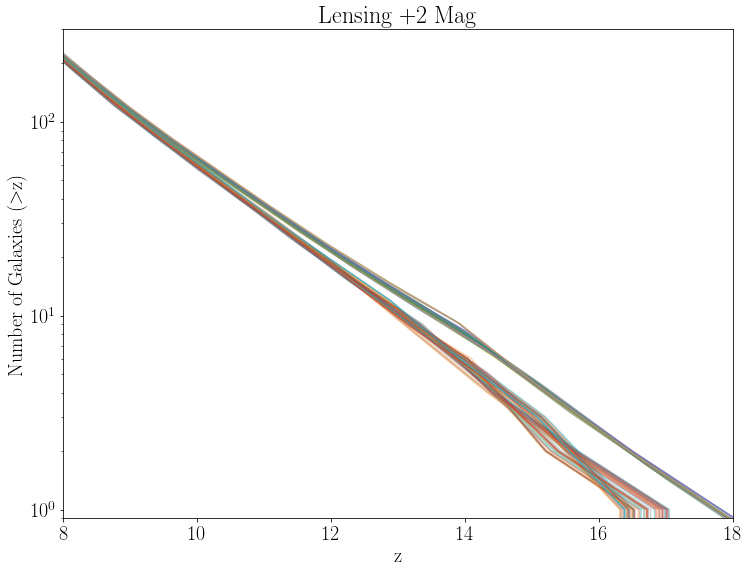

In [31]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
# Survey design modeling the effect of lensing by increasing limiting magnitude of JADES Deep survey by 2
# Assumes this is over one JWST pointing

    lensing_2 = survey(30.7 + 2, 2*4.84/3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4), 1)
    mean_lens, med_lens, z_vals_lens = mean_median(lensing_2)
    summed+=med_lens
    summean+=mean_lens

    ax.plot(z_vals_lens, mean_lens, alpha=0.4, label = "Mean")
    ax.plot(z_vals_lens, med_lens, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,3e2), xlim=(8,18), title='Lensing +2 Mag')
winsound.Beep(400,300)

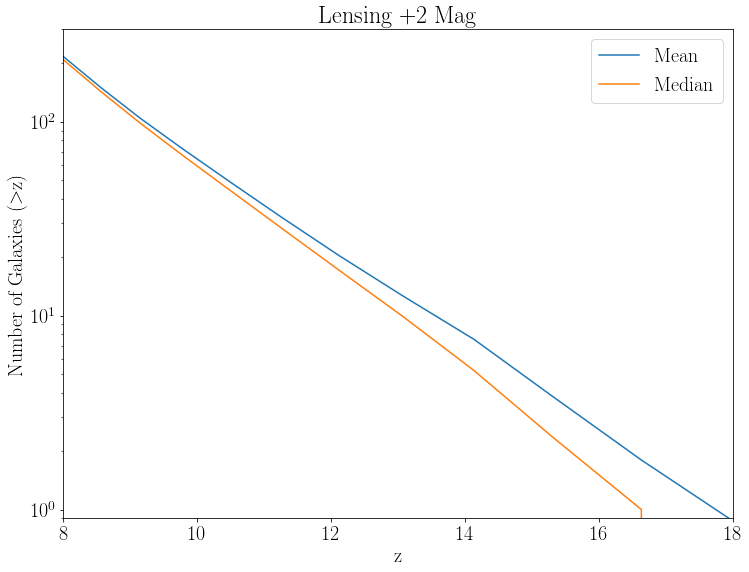

In [32]:
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,3e2), xlim=(8,18), title='Lensing +2 Mag')
if save==1:
    plt.savefig("figs/"+file+"/lensfull+2.pdf")

In [33]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9996064338903323
0.9995280419350155


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(16.634999999996342, 16.6345, 17.740999999997694)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

-2.041723717087423
-1.9420496912441512
-1.8550355552789086
-1.778646684032727
-1.7112101634860086
-1.6513695768661085
-1.598039790754909
-1.550293920357769
-1.5073633295035225
-1.4686376306444784
-1.4335968640177894
-1.4017662837530294
-1.3727615717646153
-1.3462662308055964
-1.3219863705752326
-1.2996959216114163
-1.2791914213982505
-1.2602694074198384
-1.2427716310527048
-1.226562450619585
-1.211506224443214
-1.1974899177925384
-1.1844457098289258
-1.1722831727675331
-1.1609118788235173
-1.1502640071582462
-1.140271736933087
-1.1308898542556187
-1.1220731452334196
-1.113776395974068
-1.1059543925851427
-1.098561921174222
-1.0915763747950948
-1.084975146501551
-1.0787130224011685
-1.0727673955477366
-1.0671156589950448
-1.0617352057968823
-1.0566260359532489
-1.0517655425179342
-1.0471311185447267
-1.0427001570874166
-1.038472658146003
-1.0344486217204865
-1.0305828339184453
-1.0268752947398796
-1.0233260041847891
-1.0199123553069633
-1.0166343481064022
-1.0134919825831055
-1.01046265

  2%|█▌                                                                              | 1/50 [01:47<1:27:40, 107.35s/it]

-2.0025700273575144
-1.9065007670766714
-1.8226335448446542
-1.749007318832187
-1.6840096768685324
-1.626333257734173
-1.574932172453495
-1.5289130575264958
-1.487535074928782
-1.4502099121115708
-1.4164364139407142
-1.3857570039893814
-1.3578012632453755
-1.3322641407574765
-1.3088623749281216
-1.2873780722207253
-1.2676151284523596
-1.249377439440097
-1.2325124797083273
-1.216889513135099
-1.2023778035984598
-1.1888684043301172
-1.1762959472690953
-1.1645732750007591
-1.153613230110475
-1.1433504445372662
-1.1337195502201574
-1.1246769684518314
-1.1161791205249707
-1.1081824277322583
-1.1006433113663767
-1.0935181927200088
-1.0867852824394961
-1.08042279117118
-1.074387140207743
-1.0686565401955268
-1.0632092017808725
-1.0580233356101216
-1.0530989416832741
-1.0484142306466715
-1.0439474131466548
-1.039676699829566
-1.0356020906954047
-1.0317235857441707
-1.0279976062685472
-1.024424152268534
-1.021003223744131
-1.01771303134168
-1.0145535750611805
-1.0115248549026328
-1.008605081512

  4%|███▏                                                                            | 2/50 [03:41<1:27:33, 109.45s/it]

-2.0375296070398954
-1.938241720627381
-1.8515646793931404
-1.7754717403620934
-1.7082964704213968
-1.6486877075876647
-1.5955645222741874
-1.5480036204589844
-1.5052393436848033
-1.4666636690591202
-1.4317586511549703
-1.400051383278168
-1.3711590362000878
-1.3447663387912725
-1.320580539288655
-1.2983764440283376
-1.2779513787128125
-1.2591026690445715
-1.2416726794588864
-1.2255262937574183
-1.2105283957418287
-1.1965663885801687
-1.1835727141732688
-1.1714572950555704
-1.160130053761514
-1.1495234321919303
-1.1395698722476502
-1.1302243351958938
-1.121441782303882
-1.1131771748388348
-1.105385474067973
-1.0980216412585169
-1.0910631570440765
-1.0844875020582625
-1.078249637568295
-1.0723270442077846
-1.066697202610341
-1.0613375934095748
-1.0562482166054858
-1.0514065528316843
-1.0467900827217806
-1.0423762869093849
-1.038165165394497
-1.0341567181771172
-1.030305906524466
-1.0266127304365429
-1.0230771899133484
-1.0196767655884924
-1.0164114574619751
-1.0132812655337966
-1.0102636

  6%|████▊                                                                           | 3/50 [05:35<1:26:48, 110.82s/it]

-2.0384977496777816
-1.939120729207541
-1.85236587509324
-1.7762046248848156
-1.7089690494566625
-1.6493067738420728
-1.59613589806768
-1.5485322992395678
-1.505729631543268
-1.467119326243762
-1.4321829729371454
-1.4004472403850703
-1.3715289556803032
-1.3451125646639455
-1.320905052759877
-1.298681024140313
-1.2782376225602479
-1.2593719917746748
-1.241926354704145
-1.2257654738519874
-1.2107541117215317
-1.196779570398885
-1.1837742311357122
-1.1716479356008995
-1.160310525463333
-1.1496943819746772
-1.1397318863865968
-1.130377959533535
-1.1215875222499347
-1.113315495370239
-1.105516799728891
-1.098146356160334
-1.0911816250817892
-1.084600066910478
-1.078356602480844
-1.0724286922101085
-1.0667937965154928
-1.0614293758142188
-1.0563354301062864
-1.0514894198089169
-1.0468688053393322
-1.0424510471147537
-1.0382361451351811
-1.0342240994006149
-1.0303698307454978
-1.02667333916983
-1.0231346246736113
-1.0197311476740636
-1.0164629081711865
-1.0133299061649803
-1.0103096020726663


  8%|██████▍                                                                         | 4/50 [07:29<1:25:41, 111.77s/it]

-2.0004350880682638
-1.904562385396189
-1.82086675541551
-1.7473911685865375
-1.6825265117321944
-1.6249680984926886
-1.573672179780186
-1.5277472199154953
-1.4864538966280674
-1.449205101055996
-1.415500703428027
-1.3848840635182331
-1.3569855201913401
-1.331500646630063
-1.3081467607897799
-1.286706414943859
-1.2669839061383312
-1.248783531419228
-1.2319530773779066
-1.2163620753783881
-1.201880056784693
-1.1883982977335052
-1.1758515639068357
-1.1641528762140307
-1.1532152555644384
-1.1429734676400685
-1.1333622781229313
-1.124338197467701
-1.1158577361290507
-1.1078774045616542
-1.100353713220185
-1.0932431725593166
-1.086524037806386
-1.08017456418873
-1.0741512621610219
-1.0684323869505987
-1.0629961937847974
-1.0578209378909544
-1.05290661926907
-1.0482314931464807
-1.0437738147505233
-1.0395118393085352
-1.0354455668205156
-1.031574997286465
-1.0278566411610568
-1.024290498444291
-1.0208765691361676
-1.0175931084640237
-1.0144401164278587
-1.0114175930276732
-1.0085037934908037

 10%|████████                                                                        | 5/50 [09:24<1:24:30, 112.68s/it]

-2.036304388910091
-1.9371293047430673
-1.8505507384108213
-1.774544249547049
-1.7074452982950117
-1.6479042577438412
-1.5948414263648418
-1.547334559102253
-1.504618867373249
-1.4660870190679391
-1.4312216572038234
-1.3995504123620977
-1.3706908902513488
-1.3443281779257077
-1.3201698562211526
-1.2979909873192055
-1.2775891271832358
-1.2587618317766132
-1.2413516446264032
-1.2252236030415187
-1.2102427443308728
-1.1962965995852264
-1.1833176874590363
-1.1712160328249108
-1.159901660555459
-1.1493070893051374
-1.1393648377284025
-1.1300299182615585
-1.12125734334091
-1.1130021254027613
-1.1052192768834168
-1.097863810219181
-1.0909132316282055
-1.0843450473286431
-1.0781142697567978
-1.072198405130822
-1.0665749596688678
-1.0612214395890875
-1.0561378448914809
-1.0513016817942002
-1.046690456515398
-1.0422816752732258
-1.0380753380676842
-1.034071444898773
-1.0302250082027962
-1.0265360279797542
-1.023004504229647
-1.0196079431706266
-1.0163463448026933
-1.0132197091258468
-1.010205542

 12%|█████████▌                                                                      | 6/50 [11:19<1:23:14, 113.51s/it]

-2.020627263731837
-1.922895526573749
-1.8375769835205666
-1.7626766569482877
-1.6965542319216205
-1.6378797233578966
-1.5855891431909814
-1.5387736682810513
-1.4966796404145943
-1.4587085663044097
-1.4243506183354742
-1.3931403017288542
-1.3647007873777934
-1.3387217454296694
-1.3149150124499038
-1.2930589242580521
-1.2729539830917136
-1.2544006911884886
-1.2372438836220654
-1.2213505618841771
-1.206587727466557
-1.1928445482789831
-1.1800545250673213
-1.168128992159394
-1.1569792838830233
-1.1465389009840758
-1.1367413442084182
-1.1275422807199613
-1.1188973776826163
-1.1107623022602942
-1.103092721616906
-1.095844302916363
-1.0889948797406201
-1.0825222856716337
-1.0763821878733142
-1.0705524199276175
-1.0650108154164988
-1.059735207921914
-1.0547255974438627
-1.0499598175643008
-1.0454157018651835
-1.0410710839284665
-1.0369259637541497
-1.0329803413422334
-1.0291898838566282
-1.0255545912973343
-1.022074463664352
-1.0187273345396362
-1.0155132039231873
-1.0124320718150055
-1.00946

 14%|███████████▏                                                                    | 7/50 [13:16<1:21:54, 114.28s/it]

-2.025372681430004
-1.9272040475601193
-1.841504099325784
-1.7662689408212846
-1.699850924301923
-1.640914119163891
-1.5883897809241412
-1.5413650236700709
-1.499082820059522
-1.4609420013207806
-1.426430460722386
-1.395080622553006
-1.3665139731415608
-1.340418795347162
-1.3165056375389843
-1.2945518446163928
-1.2743570269888163
-1.2557207950656832
-1.2384872902765496
-1.2225229195610343
-1.2076940898587565
-1.1938894736193988
-1.1810422743127706
-1.1690634298986184
-1.1578638783366877
-1.1473768230967887
-1.1375354676487304
-1.128295280972386
-1.1196117320476289
-1.1114402898543316
-1.1037364233723674
-1.0964556015816094
-1.089575558971994
-1.0830740300334578
-1.0769064837458737
-1.0710506545991785
-1.0654842770833084
-1.0601850856882
-1.0551530804138536
-1.0503659957502054
-1.0458015661871918
-1.0414375262147497
-1.037273875832879
-1.0333106150415794
-1.0295032128207244
-1.0258516691703137
-1.0223559840903473
-1.0189938920707617
-1.0157653931115571
-1.0126704872127335
-1.00968690886

 16%|████████████▊                                                                   | 8/50 [15:15<1:21:10, 115.97s/it]

-2.004509337488133
-1.9082615306023096
-1.8242384394924136
-1.7504753776944557
-1.6853569363380458
-1.6275733244471926
-1.5760767092411012
-1.5299720668861776
-1.4885171824960262
-1.4511226501314503
-1.4172863832516531
-1.3865499550150375
-1.3585422579784052
-1.3329576742473588
-1.3095124157770992
-1.2879881840716283
-1.268188510484547
-1.2499169263694565
-1.2330206227791578
-1.2173686206160517
-1.202829940782539
-1.1892954340306199
-1.1766996108114955
-1.1649551517267658
-1.1539747373780318
-1.1436928782164932
-1.1340440846933513
-1.1249846971094055
-1.1164710557654565
-1.1084595009623046
-1.1009063730007498
-1.0937680121815927
-1.0870225886552332
-1.0806482725720712
-1.0746014042329075
-1.068860153788142
-1.0634026913881747
-1.0582071871834058
-1.0532736411738355
-1.0485802235098636
-1.0441051043418903
-1.039826453820316
-1.0357442719451404
-1.0318585587163638
-1.028125654434786
-1.0245455591004076
-1.0211182727132282
-1.017821965423648
-1.014656637231667
-1.0116222881372852
-1.00869

 18%|██████████████▍                                                                 | 9/50 [17:15<1:19:52, 116.90s/it]

-2.0109690838403345
-1.9141265470234863
-1.8295842643725342
-1.755365409325102
-1.6898445911521243
-1.6317039254786845
-1.579889104804848
-1.5334995748077551
-1.491788534341619
-1.4541629354377268
-1.4201175890856936
-1.3891912357542981
-1.3610104748706475
-1.335267800080594
-1.3116776697695722
-1.290020436541763
-1.2700984177409278
-1.2517139307108298
-1.2347132222743953
-1.2189645039941321
-1.2043359874325488
-1.1907178488917356
-1.1780441941529465
-1.1662271642578537
-1.1551789002481292
-1.1448335079050276
-1.1351250930098027
-1.1260097260832906
-1.1174434776463273
-1.1093824182197491
-1.1017826183243922
-1.094600148481092
-1.0878130439502676
-1.081399339992336
-1.075315107128134
-1.0695383806180794
-1.06404719572259
-1.0588195877020843
-1.0538555565565622
-1.0491331375464414
-1.04463036593214
-1.0403252769740765
-1.0362178706722507
-1.0323081470266624
-1.0285521765581478
-1.0249499592667068
-1.0215014951523396
-1.0181848194754641
-1.0149999322360803
-1.0119468334341883
-1.009003558

 20%|███████████████▊                                                               | 10/50 [19:07<1:16:58, 115.46s/it]

-2.0300864016528695
-1.9314837893649222
-1.8454049835821351
-1.769837229687607
-1.7031255961074423
-1.6439282464303737
-1.5911717115273873
-1.5439390698507838
-1.5014699474341788
-1.463160517892502
-1.428496410601434
-1.3970079828170316
-1.3683150475561026
-1.3421045096560178
-1.318085637894336
-1.2960347928691793
-1.2757506991188576
-1.257032081181681
-1.239722391476335
-1.2236874463616925
-1.2087930621966274
-1.1949274192802002
-1.1820234257918478
-1.1699916259708192
-1.158742564056363
-1.1482091482279158
-1.1383242866649146
-1.1290432514869835
-1.120321314813747
-1.1121137487648296
-1.104375825459856
-1.09706281701845
-1.090152359500424
-1.0836220889655908
-1.077427277533574
-1.0715455612641864
-1.06595457621724
-1.060631958452547
-1.0555777079701074
-1.0507694608297335
-1.0461848530912374
-1.0418015208144316
-1.0376194639993155
-1.0336386826458897
-1.0298144488737784
-1.0261467626829814
-1.022635624073499
-1.0192586691051435
-1.0160158977779146
-1.0129073100918125
-1.00991054210664

 22%|█████████████████▍                                                             | 11/50 [21:01<1:14:45, 115.01s/it]

-2.038136171643013
-1.9387924406036499
-1.8520666477321355
-1.7759309101086367
-1.7087178573324018
-1.649075567456876
-1.595922502924815
-1.5483348504060728
-1.5055465207976015
-1.4669491492234514
-1.4320244989374427
-1.4002993972582813
-1.371390799634443
-1.344983257611732
-1.3207838547683943
-1.2985672707800044
-1.2781307173545786
-1.259271406200134
-1.2418316130895721
-1.225676145828238
-1.2106698122214754
-1.196699952107072
-1.1836989693876996
-1.1715767359335882
-1.1602431236149675
-1.1496305363345092
-1.1396713779948862
-1.1303205845312128
-1.1215330918786042
-1.1132638359721752
-1.1054677527470402
-1.0980997781383146
-1.0911373801135553
-1.08455802664032
-1.0783166536537239
-1.0723907291213235
-1.0667577210106771
-1.0613950972893416
-1.056302857957317
-1.051458470982161
-1.0468394043314309
-1.042423125972684
-1.0382096359059203
-1.03419893413114
-1.0303459565834576
-1.0266507032628736
-1.0231131741693875
-1.019710837270557
-1.016443692566382
-1.0133117400568625
-1.01029244770955

 24%|██████████████████▉                                                            | 12/50 [22:53<1:12:19, 114.18s/it]

-2.015282737018362
-1.9180430547847807
-1.8331540693193573
-1.7586308472129226
-1.6928413321068279
-1.6344622350616274
-1.582434924925765
-1.5358551542572862
-1.4939730593238387
-1.4561931601026719
-1.4220081958336652
-1.3909550153880126
-1.362658686899538
-1.3368104429490377
-1.3131235709329645
-1.291377522694745
-1.2713738048934617
-1.252913924188198
-1.2358434968693521
-1.2200301940429794
-1.2053416868151352
-1.1916677011075325
-1.1789420724731992
-1.1670765816495052
-1.155983009373821
-1.1455951911991744
-1.1358469626785932
-1.1266942141807623
-1.1180928360743672
-1.1099987187280926
-1.1023677525106241
-1.0951558277906466
-1.0883408897525026
-1.0819008835805348
-1.0757916996434287
-1.069991283125526
-1.0644775792111703
-1.0592285330847033
-1.0542441447461257
-1.0495023593797796
-1.0449811221700076
-1.0406583783011527
-1.0365341277732145
-1.032608370586193
-1.0288369971087736
-1.025220007340956
-1.0217574012827406
-1.0184271241184697
-1.015229175848143
-1.0121635564717613
-1.0092082

 26%|████████████████████▌                                                          | 13/50 [24:45<1:10:05, 113.66s/it]

-2.016427457773826
-1.9190823844522953
-1.8341013939295978
-1.7594974014702072
-1.6936365818471346
-1.6351942119033622
-1.5831105131132754
-1.5364802579862458
-1.4945527700666297
-1.4567319239337693
-1.4225099090441404
-1.3914230722927874
-1.3630960754518882
-1.3372198164514721
-1.313507271940852
-1.2917376547271915
-1.2717122563369376
-1.253232368296538
-1.2361434395710074
-1.2203129978446436
-1.205608570801745
-1.1919197648458937
-1.1791803438192383
-1.1673019928446444
-1.1561963970449778
-1.1457973202623875
-1.1360385263390222
-1.1268758578363154
-1.118265157315699
-1.1101622673386062
-1.10252303046647
-1.0953032892607224
-1.0884809650020801
-1.0820339789712599
-1.075918173729694
-1.070111470558099
-1.064591790737191
-1.0593370555476866
-1.054347264989586
-1.0496003403436052
-1.045074202890461
-1.0407467739108691
-1.03661805340483
-1.0326880413723436
-1.0289125803748427
-1.025291670412327
-1.0218253114847968
-1.0184914248729686
-1.015290010576842
-1.0122210685964173
-1.0092625202124

 28%|██████████████████████                                                         | 14/50 [26:40<1:08:27, 114.11s/it]

-2.0120819152750786
-1.91513692332666
-1.830505198670397
-1.756207823348622
-1.6906176870405853
-1.6324155111078422
-1.5805458726396364
-1.5341072645663636
-1.4923520956595713
-1.4546866905319593
-1.420605325705457
-1.3896462536566083
-1.3614356787711874
-1.33566576936689
-1.3120506817387199
-1.290370536113603
-1.2704274406957723
-1.252023503689461
-1.235004809253517
-1.2192394295240965
-1.2045954366373541
-1.190962890706753
-1.1782758278003713
-1.166446296008979
-1.1553863434233462
-1.145030006111551
-1.135311320141671
-1.1261863095590914
-1.117610998409197
-1.1095414107373736
-1.101933570589006
-1.0947435020094793
-1.0879492170214864
-1.0815287276477195
-1.0754380579335638
-1.0696552199017122
-1.064158225574857
-1.0589250869756908
-1.0539558041042136
-1.0492283889831182
-1.044720853635097
-1.0404112100828424
-1.0362994583263547
-1.0323855983656338
-1.0286256542460648
-1.0250196259676478
-1.0215675135303828
-1.0182473289569622
-1.0150590722473862
-1.0120027434016545
-1.009056354442460

 30%|███████████████████████▋                                                       | 15/50 [28:32<1:06:11, 113.46s/it]

-2.009579817529029
-1.9128651863933719
-1.8284345637485218
-1.7543137339441701
-1.6888794530011748
-1.630815577152664
-1.5790691913851396
-1.5327409307912387
-1.4910849805697344
-1.4535090760255338
-1.4195086953813358
-1.3886231883187352
-1.3604796474371186
-1.3347709725242154
-1.3112119990972033
-1.289583369861604
-1.2696876632523861
-1.2513274577045193
-1.2343492031118681
-1.2186212850977456
-1.2040120892854644
-1.1904119370277852
-1.1777550211363645
-1.1659535986934106
-1.1549199267811323
-1.1445881982111856
-1.134892605795227
-1.1257892780743615
-1.117234343589692
-1.109183930882324
-1.1015941684933612
-1.0944211849639078
-1.087643044564516
-1.0812378115657382
-1.0751616145086782
-1.0693925176638885
-1.063908585301921
-1.058687881693328
-1.0537304068381097
-1.0490142250068175
-1.0445174004700044
-1.040217997498222
-1.0361160160914702
-1.0322114562497495
-1.0284604465141638
-1.0248629868847132
-1.0214190773613976
-1.0181067822147694
-1.014926101444828
-1.0118770350515742
-1.00893764

 32%|█████████████████████████▎                                                     | 16/50 [30:25<1:04:12, 113.30s/it]

-1.9964942662441216
-1.9009843834977636
-1.817605490621662
-1.7444079642438117
-1.679788780702785
-1.6224481910839126
-1.5713463962554575
-1.525595234459062
-1.4844581813097462
-1.4473503497959084
-1.4137735028335916
-1.3832727283026611
-1.3554797640106273
-1.3300913352107337
-1.3068258296381348
-1.2854666224737192
-1.2658187513802859
-1.247687254020635
-1.2309204930213877
-1.2153884934910772
-1.2009612805382366
-1.18753054175331
-1.1750312896905637
-1.163376874422353
-1.1524806460210335
-1.1422776170408713
-1.1327028000361332
-1.123712870042997
-1.1152645020976397
-1.1073143712362397
-1.099819152494974
-1.0927355209100207
-1.0860418139994685
-1.0797163692814062
-1.0737158617920117
-1.0680186290493734
-1.0626030085715803
-1.0574473378767213
-1.0525516169647964
-1.0478941833538944
-1.0434533745621042
-1.0392075281075144
-1.0351566439901252
-1.0313007222099366
-1.0275964378031262
-1.024043790769694
-1.02064278110964
-1.017371746341053
-1.014230686463933
-1.0112196014782802
-1.00831682890

 34%|██████████████████████████▊                                                    | 17/50 [32:22<1:02:56, 114.42s/it]

-2.0196384148964426
-1.9219977181550527
-1.8367586522086685
-1.7619280978223777
-1.6958672680696976
-1.637247416794021
-1.5850055470700612
-1.5382336823574696
-1.4961788665008358
-1.4582431637296858
-1.4239172213506532
-1.3927359782089257
-1.3643229562267976
-1.3383681146343935
-1.3145835584311156
-1.2927478299241957
-1.2726616171901424
-1.2541256083054648
-1.2369847828852254
-1.2211062663137633
-1.2063571839754177
-1.1926268070238049
-1.179848698151094
-1.1679342742801782
-1.1567949523339502
-1.1463642950045796
-1.1365758649842361
-1.1273853707343662
-1.1187485207164163
-1.1106210233918323
-1.1029585872220613
-1.0957169206685493
-1.0888738779620195
-1.0824073133331953
-1.0762729352435232
-1.070448597923726
-1.0649121556045271
-1.05964146251665
-1.0546365186600943
-1.0498751782655833
-1.0453352955638402
-1.0409947247855884
-1.0368534659308277
-1.0329115189995581
-1.0291245924532262
-1.0254926862918319
-1.022015800515375
-1.018671789354579
-1.0154606528094436
-1.0123823908799692
-1.0094

 36%|████████████████████████████▍                                                  | 18/50 [34:19<1:01:24, 115.15s/it]

-2.003378083812286
-1.9072344281398275
-1.823302259692721
-1.7496190180240347
-1.6845710423218474
-1.6268499589548713
-1.5754090690180762
-1.5293543171967485
-1.4879442917664925
-1.4505902245932285
-1.4167905724516294
-1.3860874045707443
-1.3581100150883754
-1.3325531168238889
-1.3091332288238389
-1.287632288816344
-1.2678540407567116
-1.249602228600248
-1.2327242087566366
-1.2170891438627485
-1.2025661965554548
-1.1890463356988152
-1.176464142611265
-1.1647323923840518
-1.1537638601084232
-1.1434931271028146
-1.1338547746856618
-1.1248051904025886
-1.1163007617992184
-1.1082978764211753
-1.1007529218140828
-1.0936222855235647
-1.0868841613224332
-1.0805167429834994
-1.074476418052388
-1.0687413803019101
-1.063289823504878
-1.0580999414341035
-1.0531717340895863
-1.0484833952441388
-1.0440131186705723
-1.0397390981416992
-1.0356613336575191
-1.0317798252180324
-1.0280509603688623
-1.0244747391100093
-1.021051161441473
-1.0177584211360657
-1.014596518193787
-1.0115654526146372
-1.008643

 38%|██████████████████████████████                                                 | 19/50 [36:19<1:00:13, 116.57s/it]

-1.9963630995249853
-1.900865292914372
-1.8174969423486538
-1.744308670963473
-1.679697657781468
-1.6223643182264005
-1.5712689846372792
-1.5255236075536738
-1.4843917557157162
-1.447288616064099
-1.4137160145112637
-1.383219096455527
-1.3554296462669542
-1.3300444275444234
-1.3067818636297492
-1.2854253570935585
-1.2657799702494157
-1.2476507654108846
-1.2308861243774043
-1.2153560886913508
-1.2009306998951002
-1.1875016592739662
-1.1750039875991365
-1.163351045898862
-1.1524561952013936
-1.142254456277919
-1.1326808498996268
-1.1236920565806419
-1.1152447568350898
-1.1072956311770958
-1.0998013601207857
-1.0927186241802842
-1.0860257636126545
-1.079701118674959
-1.0737013698813234
-1.06800485748881
-1.0625899217544816
-1.0574349029354013
-1.0525398010315685
-1.0478829563000462
-1.043442708997897
-1.0391973993821837
-1.0351470274529062
-1.0312915932100644
-1.027587777167784
-1.0240355793260645
-1.0206349996849065
-1.0173643785013722
-1.0142237157754617
-1.0112130115071751
-1.008310605

 40%|████████████████████████████████▍                                                | 20/50 [38:16<58:21, 116.72s/it]

-2.015860290126927
-1.9185674342698487
-1.833632028918546
-1.759068055241733
-1.6932425644225757
-1.6348315439068837
-1.582775783651305
-1.536170541743809
-1.4942655444036883
-1.4564649859815575
-1.4222613283316434
-1.3911911670599795
-1.362879365276212
-1.3370169867176962
-1.313317161997691
-1.291559222357165
-1.2715445659129896
-1.253074590782036
-1.235994828832982
-1.220172878810409
-1.2054763394588974
-1.191794876398932
-1.1790622890028024
-1.1671903097668967
-1.156090671187602
-1.1456971726372087
-1.1359436134880074
-1.1267858599881917
-1.1181797783859553
-1.1100812349294917
-1.1024460958669948
-1.095230227446658
-1.0884115627925786
-1.0819680350288527
-1.0758555104036744
-1.0700519220411406
-1.064535203065348
-1.0592832866003936
-1.054296172646277
-1.0495517943270953
-1.0450280847669455
-1.040702977089924
-1.0365764712960313
-1.0326485673852668
-1.0288751316058247
-1.025256163957705
-1.021791664440907
-1.0184595661795284
-1.0152598691735686
-1.012192573423028
-1.0092356120520032


 42%|██████████████████████████████████                                               | 21/50 [40:15<56:43, 117.37s/it]

-2.0137213771626237
-1.9166254447589397
-1.831861951036604
-1.757448896921828
-1.6917566387317193
-1.6334638437504199
-1.5815134458052418
-1.5350025342070155
-1.4931823537500875
-1.4554583047123217
-1.421323876219305
-1.3903166018204876
-1.3620621039130423
-1.3362520715299357
-1.3126002159160648
-1.2908863149521201
-1.2709121687307228
-1.2524795773444939
-1.2354343853099166
-1.219644459355405
-1.2049776662093734
-1.191323894812167
-1.1786170785279924
-1.166769128509126
-1.155691955907844
-1.145319494088353
-1.1355856764148606
-1.1264464584635046
-1.117857795810423
-1.109775644031754
-1.1021559587036356
-1.0949546954022056
-1.0881498319155332
-1.0817193460316876
-1.0756191933268067
-1.0698273515889591
-1.0643217986062146
-1.0590805121666418
-1.0541034922702406
-1.0493687167050803
-1.0448541632592296
-1.040537809720758
-1.036419656089665
-1.0324997023659508
-1.0287339041257535
-1.0251222613690731
-1.0216647740959095
-1.0183394200943319
-1.01514619936434
-1.012085111905934
-1.009134135507

 44%|███████████████████████████████████▋                                             | 22/50 [42:12<54:46, 117.37s/it]

-1.9982199626310262
-1.9025512000715616
-1.8190336071726325
-1.7457143173816525
-1.6809876404220512
-1.6235516652587711
-1.572364863063766
-1.5265375946297473
-1.485332110370182
-1.4481625503192945
-1.414529848580313
-1.383978336290967
-1.3561391386579906
-1.3307084764398704
-1.3074042689123437
-1.2860095309029012
-1.2663289757562843
-1.2481673168172343
-1.2313726644649945
-1.215814827596059
-1.2013636151069225
-1.1879105344113299
-1.1753904899575283
-1.163716687676514
-1.1528023334992832
-1.1425823318740829
-1.1329915872491605
-1.1239867025900137
-1.1155242808621408
-1.10756092503104
-1.1000532380622094
-1.0929578229211467
-1.0862529810906014
-1.0799170140533223
-1.0739065247748076
-1.068199814737806
-1.062775185425067
-1.0576109383193397
-1.0527070734206236
-1.048041892211668
-1.0435936961752221
-1.0393407867940347
-1.0352831640681062
-1.031420827997436
-1.0277103815475224
-1.0241518247183656
-1.0207451575099655
-1.0174686814050713
-1.0143223964036827
-1.0113063025057998
-1.008398701

 46%|█████████████████████████████████████▎                                           | 23/50 [44:08<52:32, 116.74s/it]

-2.0336931146576225
-1.9347584428646125
-1.8483897534268043
-1.7725675134656838
-1.7056312181700273
-1.6462345122874922
-1.5933003116162037
-1.5459086067337275
-1.5032964629970693
-1.4648580205426747
-1.430077176523812
-1.3984827066021612
-1.3696931434562254
-1.343394337527124
-1.319294578510183
-1.2971694738633452
-1.2768170702987591
-1.2580354145285733
-1.2406674317733477
-1.224578486507848
-1.20963394320684
-1.1957216055992947
-1.1827741559225955
-1.1707018371599194
-1.1594148922944432
-1.1488460035635502
-1.1389278532046228
-1.12961556270925
-1.12086425356902
-1.1126290472755216
-1.1048650653203431
-1.0975274291950734
-1.0905936996455066
-1.084041437417437
-1.0778257640024531
-1.0719242401463493
-1.0663144265949198
-1.060973884093959
-1.0559026126434667
-1.0510781729892376
-1.0464781258770652
-1.0420800320527446
-1.0378838915162754
-1.0338897042676576
-1.0300525917984797
-1.026372554108742
-1.0228495911984443
-1.019461263813381
-1.016207571953552
-1.013088515618957
-1.0100816555553

 48%|██████████████████████████████████████▉                                          | 24/50 [46:05<50:38, 116.85s/it]

-2.0198473775139814
-1.922187442196285
-1.8369315812215037
-1.7620862826416681
-1.6960124366328935
-1.6373810352298677
-1.5851288720603405
-1.5383477916813488
-1.496284689579216
-1.4583415121695509
-1.4240088063989842
-1.3928214194796564
-1.3644027991547292
-1.3384428435656297
-1.3146536009865402
-1.2928135700899088
-1.2727233996809384
-1.2541837385648322
-1.237039535812304
-1.2211578906268228
-1.2064059022118565
-1.1926728199036298
-1.1798921933038768
-1.167975421881577
-1.1568339051057093
-1.146401192578008
-1.1366108339002077
-1.127418528806798
-1.1187799770322682
-1.1106508783111082
-1.1029869323778074
-1.0957438389668557
-1.0888994479454974
-1.0824316091809778
-1.0762960224077862
-1.0704705374931673
-1.0649330043043663
-1.0596612727086276
-1.0546553427059515
-1.0498930641635826
-1.0453522869487657
-1.0410108609287456
-1.0368687861035224
-1.032926062473096
-1.0291383897719562
-1.0255057680001025
-1.0220281971575356
-1.0186835271114996
-1.015471757861995
-1.0123928894090217
-1.00942

 50%|████████████████████████████████████████▌                                        | 25/50 [47:59<48:20, 116.00s/it]

-2.0261962260304496
-1.92795177082073
-1.8421856315369447
-1.7668923645481396
-1.7004230495355306
-1.6414407240784818
-1.588875818240485
-1.5418147410341057
-1.499499880420983
-1.4613296033118315
-1.4267914074454071
-1.3954173559744874
-1.3668286428798924
-1.3407133102634734
-1.3167816829340928
-1.294810933821645
-1.2746005185630338
-1.2559498927951647
-1.2387030775689631
-1.2227263766423655
-1.2078860937733085
-1.1940708154267385
-1.1812136934816246
-1.1692255971099237
-1.1580173954835937
-1.1475222404816028
-1.1376732839829193
-1.1284259605735216
-1.1197357048393892
-1.1115579513665004
-1.103848134740834
-1.096561689548369
-1.0896763330820947
-1.0831697826350006
-1.0769974727930653
-1.0711371208492784
-1.0655664440966295
-1.0602631598281074
-1.0552272680437127
-1.0504364860364346
-1.0458685310992621
-1.0415011205251854
-1.037334254314204
-1.0333679324663176
-1.0295575895675058
-1.0259032256177678
-1.0224048406171042
-1.0190401518585042
-1.0158091593419678
-1.0127118630674947
-1.00972

 52%|██████████████████████████████████████████                                       | 26/50 [49:54<46:21, 115.89s/it]

-2.022926225169096
-1.9249828293633668
-1.839479511047139
-1.764416972052456
-1.6981513449967767
-1.6393497644347983
-1.586945938010277
-1.5400290743355889
-1.4978438829917289
-1.4597905745283102
-1.4253582171912997
-1.394080308074841
-1.3655792019694317
-1.3395438969378342
-1.3156856054668988
-1.2937821833157426
-1.2736337006675693
-1.2550402277055834
-1.2378462634611667
-1.2219185213897883
-1.2071237149469178
-1.1933507720121137
-1.1805330493131103
-1.1685816891535545
-1.1574078338370923
-1.1469448400914588
-1.1371260646443888
-1.1279070786477052
-1.1192434532532316
-1.111090759612791
-1.1034045688782068
-1.0961404522013019
-1.0892761951579883
-1.0827895833241772
-1.0766361878516921
-1.0707937943164445
-1.065240188294346
-1.0599531553613082
-1.0549326955173313
-1.0501565943383266
-1.0456026374002059
-1.0412486102788807
-1.037094512974351
-1.0331403454866168
-1.0293416789675014
-1.025698513417005
-1.0222108488351271
-1.0188564707977796
-1.0156353793049624
-1.0125475743566756
-1.009570

 54%|███████████████████████████████████████████▋                                     | 27/50 [51:48<44:11, 115.28s/it]

-2.0143839565171175
-1.9172270223724504
-1.8324102749188727
-1.7579504698667452
-1.6922169396890305
-1.63388752152597
-1.5819044850897555
-1.5353643524262177
-1.4935178979148267
-1.4557701482686904
-1.4216142743915676
-1.3905875192825425
-1.36231527013135
-1.3364890222707126
-1.3128223070810159
-1.2910947640856332
-1.271108068855601
-1.2526638969619546
-1.2356079960710558
-1.2198081498969287
-1.2051321421535972
-1.191469792602748
-1.1787549931013934
-1.1668995994588824
-1.1558154674845644
-1.1454364890354516
-1.135696555968556
-1.1265515961885522
-1.1179575376001147
-1.1098703081079186
-1.1022458356166385
-1.0950400480309486
-1.0882309093031868
-1.08179638338569
-1.0756923981831332
-1.0698969176478537
-1.0643879057321888
-1.0591433263884757
-1.0541631796167146
-1.0494254293692427
-1.0449080395983974
-1.0405889742565162
-1.0364682333435986
-1.0325458168596453
-1.0287776527093304
-1.0251637408926542
-1.0217040814096165
-1.018376638212555
-1.0151814113014692
-1.0121184006763595
-1.0091655

 56%|█████████████████████████████████████████████▎                                   | 28/50 [53:45<42:27, 115.78s/it]

-2.030156359671685
-1.9315473065537985
-1.8454628780097422
-1.769890187947293
-1.7031741966906238
-1.6439729801782526
-1.5912129991609938
-1.543977272196835
-1.5015053756509364
-1.4631934436956318
-1.4285270721073524
-1.3970365874645798
-1.3683417779498943
-1.3421295279489502
-1.3181090872484262
-1.2960568018380756
-1.275771383108676
-1.2570515424510051
-1.2397407220578902
-1.2237047295231829
-1.208809372440735
-1.1949428238054232
-1.1820379874141735
-1.170005401662887
-1.1587556049474645
-1.1482215010648327
-1.1383359938119166
-1.1290543523866678
-1.1203318459870362
-1.1121237438109726
-1.1043853150564276
-1.097071828921352
-1.0901609200047209
-1.0836302229055095
-1.0774350068216685
-1.0715529063521734
-1.0659615560959992
-1.0606385906521216
-1.0555840100205403
-1.0507754488002303
-1.0461905415901676
-1.0418069229893272
-1.037624592997709
-1.033643551615313
-1.0298190680400898
-1.0261511422720397
-1.0226397743111624
-1.0192625987564332
-1.0160196156078523
-1.0129108248654195
-1.009913

 58%|██████████████████████████████████████████████▉                                  | 29/50 [55:41<40:34, 115.91s/it]

-2.0376758703374716
-1.9383745178914418
-1.8516857209840325
-1.7755824617608225
-1.7083980810970647
-1.6487812337564796
-1.5956508435500418
-1.5480834912329597
-1.5053134145046745
-1.4667325080088593
-1.431822756071607
-1.400111187860219
-1.3712149222244159
-1.344818645275732
-1.320629565546307
-1.2984224588300934
-1.2779946233416495
-1.2591433572955333
-1.2417110037475116
-1.225562428173957
-1.2105624960512407
-1.1965985952763398
-1.18360315858744
-1.1714860963021227
-1.1601573187379692
-1.1495492586331655
-1.1395943487258973
-1.1302475441749555
-1.1214638001391306
-1.1131980717772134
-1.1054053142479945
-1.0980404827102646
-1.0910810547434187
-1.0845045079268525
-1.0782657974193564
-1.0723424008003257
-1.066711795649156
-1.0613514595452425
-1.056261392488585
-1.0514190720585792
-1.0468019758346199
-1.0423875813961028
-1.038175888743028
-1.034166897875395
-1.030315563951995
-1.0266218869728276
-1.023085866937893
-1.0196849814265865
-1.016419230438908
-1.0132886139748576
-1.01027060961

 60%|████████████████████████████████████████████████▌                                | 30/50 [57:37<38:33, 115.66s/it]

-2.032425679657334
-1.9336076968934592
-1.847340875469519
-1.7716080644558807
-1.7047507175326242
-1.645424067413328
-1.5925523002688555
-1.545216491786818
-1.5026546071715772
-1.464261501144243
-1.4295216795783536
-1.397964473923662
-1.3692088667823485
-1.3429410791209149
-1.31886974469397
-1.296770735620443
-1.276442336807371
-1.2576828331617909
-1.2403353351669533
-1.224265366094216
-1.2093384492149373
-1.1954425205885815
-1.182510341850828
-1.1704522618492483
-1.1591786294314146
-1.1486222062330058
-1.1387157538897006
-1.1294144468252851
-1.1206734594635452
-1.112447966228267
-1.1046931415432362
-1.097364159832239
-1.0904386083071682
-1.0838940741799168
-1.0776857318742707
-1.071791168602123
-1.0661879715753668
-1.0608537280058947
-1.055788437893707
-1.0509696884506965
-1.0463750668887564
-1.0419821604197794
-1.0377909690437657
-1.0338014927607153
-1.029968905994414
-1.0262932087448617
-1.0227744010120587
-1.019390070007898
-1.0161402157323793
-1.0130248381855027
-1.010021524579161

 62%|██████████████████████████████████████████████████▏                              | 31/50 [59:33<36:44, 116.05s/it]

-2.0354690780289957
-1.936370898488812
-1.8498594689015668
-1.7739119187391081
-1.7068649989005127
-1.64737012903368
-1.5943484448569296
-1.5468784164629927
-1.5041958483190125
-1.4656938792665442
-1.4308555535039484
-1.3992088679079906
-1.370371724712242
-1.3440294551678795
-1.3198898668652808
-1.2977281964124296
-1.2773421567565109
-1.258529460844709
-1.241132774302613
-1.2250172390950123
-1.210047997186697
-1.1961126668816588
-1.1831438191622925
-1.1710515486717916
-1.1597459500533491
-1.1491595942893604
-1.1392250523622203
-1.1298973715935254
-1.1211315993048723
-1.1128827828178576
-1.1051059694540784
-1.0977562065351307
-1.0908110177218133
-1.0842479266749243
-1.0780219807160603
-1.07211070350602
-1.0664916187056013
-1.0611422499756027
-1.0560625973160243
-1.0512301843876641
-1.046622534851321
-1.0422171723677927
-1.0380140969370795
-1.0340133085591814
-1.030169854555695
-1.0264837349266205
-1.0229549496719574
-1.0195610224525047
-1.0163019532682618
-1.0131777421192292
-1.01016591

 64%|██████████████████████████████████████████████████▌                            | 32/50 [1:01:30<34:53, 116.30s/it]

-2.033964035004669
-1.9350044203686234
-1.848613956151309
-1.7727726003211441
-1.7058194294299387
-1.6464077487899722
-1.5934602026510674
-1.5460565496432812
-1.5034336627769056
-1.4649855294424656
-1.4301959166763347
-1.398593481337811
-1.3697966599320393
-1.3434912236985521
-1.3193853887883429
-1.2972547060867912
-1.276897171390739
-1.2581107804970286
-1.2407384190254251
-1.2246454175071568
-1.2096971064734516
-1.1957812613669994
-1.182830547453414
-1.1707551850868472
-1.1594653946214513
-1.1488938413228398
-1.1389731904566271
-1.129658552199889
-1.120905036729701
-1.1126677542231398
-1.104901814857281
-1.0975623288092005
-1.0906268511674364
-1.0840729370205264
-1.077855696545547
-1.071952684831036
-1.066341456965531
-1.0609995680375701
-1.0559270180471536
-1.0511013620828193
-1.0465001552331052
-1.0421009525865494
-1.0379037541431517
-1.033908559902912
-1.0300704800429068
-1.0263895145631354
-1.0228656634635984
-1.0194764818328335
-1.0162219696708406
-1.0131021269776197
-1.010094508

 66%|████████████████████████████████████████████████████▏                          | 33/50 [1:03:30<33:15, 117.41s/it]

-2.033478878457691
-1.9345639307642757
-1.8482124602104189
-1.7724053365415484
-1.7054823859927941
-1.646097521727775
-1.5931738742773858
-1.5457916176367656
-1.5031879692652994
-1.4647571900866148
-1.429983280146766
-1.3983951090530193
-1.369611285535067
-1.3433177226644202
-1.3192227682931958
-1.2971020746153306
-1.2767537286053674
-1.2579758172378492
-1.240611297048531
-1.2245255593537752
-1.2095839954699432
-1.1956744314940038
-1.1827295630841375
-1.170659651117919
-1.159374956472923
-1.1488081748073302
-1.1388920017793216
-1.1295815678276848
-1.1208320033912065
-1.1125984389086747
-1.1048360048188761
-1.0974998315605984
-1.090567484353235
-1.0840165284161796
-1.0778020941882194
-1.0719017468887484
-1.0662930517371598
-1.0609535739528475
-1.0558833135358114
-1.0510598357054455
-1.0464607056811428
-1.0420634886822975
-1.037868184708909
-1.0338747937609782
-1.0300384462772916
-1.0263591422578495
-1.0228368817026519
-1.0194492298310924
-1.016196186643171
-1.0130777521388878
-1.0100714

 68%|█████████████████████████████████████████████████████▋                         | 34/50 [1:05:30<31:29, 118.09s/it]

-2.0395318325046614
-1.940059607056582
-1.8532216402274473
-1.7769874261677834
-1.7096874378458011
-1.6499680046951855
-1.5967461902628837
-1.5490969863285806
-1.506253312904697
-1.4676060182363917
-1.432636195273243
-1.400870059317041
-1.3719240703739959
-1.3454823719786346
-1.3212516688415883
-1.2990063492018047
-1.2785433624743363
-1.259659658074236
-1.2421973077687671
-1.2260209445012977
-1.2109952012151963
-1.197007272029937
-1.1839894734172036
-1.1718515606725752
-1.160503289091631
-1.1498769751460547
-1.139904935307531
-1.1305420472238492
-1.121743188542799
-1.1134632369121695
-1.1056570699797506
-1.0982795653933315
-1.091308161976807
-1.084720298554072
-1.0784708527729157
-1.072537263457233
-1.0668969694309187
-1.0615274095178675
-1.0564285837180794
-1.0515779308554492
-1.0469528897538714
-1.042530899237241
-1.0383119593055579
-1.0342960699588222
-1.0304381088448231
-1.026738075963561
-1.0231959713150356
-1.0197892337231418
-1.0165178631878795
-1.0133818597092488
-1.01035866211

 70%|███████████████████████████████████████████████████████▎                       | 35/50 [1:07:27<29:25, 117.73s/it]

-2.0243293839914194
-1.926256803461691
-1.8406407085515242
-1.7654791640720613
-1.699126134423574
-1.6402469961468238
-1.5877740504744198
-1.5407953047092153
-1.4985544722243085
-1.4604509724630417
-1.4259731997660403
-1.3946540359225708
-1.3661153376191817
-1.3400456927153845
-1.3161559327950108
-1.2942236206148536
-1.2740485626560276
-1.255430565399647
-1.2382139227754667
-1.2222651724375635
-1.2074508520400133
-1.1936597429612128
-1.1808251140282
-1.1688579903436924
-1.1576693970104075
-1.1471926028553832
-1.1373608767056576
-1.1281297311125895
-1.1194546786275374
-1.1112912318018604
-1.1035949031869168
-1.0963212053340656
-1.0894478945189858
-1.0829527270173573
-1.0767912153805383
-1.0709411158842084
-1.065380184804047
-1.0600861784157332
-1.055059096719267
-1.0502766959903282
-1.0457167325045957
-1.041356962537749
-1.0371973860897883
-1.0332380031607133
-1.0294343263018828
-1.0257863555132969
-1.0222940907949554
-1.0189352884225378
-1.0157099483960441
-1.0126180707154744
-1.009637

 72%|████████████████████████████████████████████████████████▉                      | 36/50 [1:09:20<27:10, 116.46s/it]

-1.9986357365461815
-1.9029286948998303
-1.8193776848529248
-1.7460290584698401
-1.6812764830035063
-1.62381752649684
-1.5726102433841744
-1.5267646384948357
-1.4855426670531435
-1.44835823467841
-1.4147120757870868
-1.3841483391941944
-1.3562980025118927
-1.3308571649501952
-1.307543632918401
-1.2861403344236624
-1.266451904672417
-1.2482829788711025
-1.2314816066247256
-1.2159175447375778
-1.2014605500139512
-1.1880020864574221
-1.1754770324701358
-1.163798559254954
-1.1528798380147374
-1.142655747151632
-1.1330611650677838
-1.124052677364623
-1.1155868696435804
-1.1076203275060865
-1.1001096365535716
-1.0930113823874668
-1.0863038578084867
-1.0799653556173472
-1.0739524614154783
-1.0682434680035957
-1.0628166681824145
-1.0576503547526501
-1.0527445277143024
-1.0480774798680865
-1.043627504014718
-1.039372892954912
-1.0353136466886683
-1.0314497652159873
-1.0277378341382994
-1.0241778534556047
-1.0207698231679028
-1.0174920360759094
-1.0143444921796243
-1.0113271914790476
-1.00841842

 74%|██████████████████████████████████████████████████████████▍                    | 37/50 [1:11:13<24:56, 115.15s/it]

-2.0374756152046634
-1.9381926996623182
-1.8515199979334716
-1.775430868512382
-1.7082589617165516
-1.6486531832088205
-1.5955326575194597
-1.5479741368514095
-1.5052120010802792
-1.4666382577543466
-1.4317349873777
-1.4000293069323333
-1.371138406356051
-1.3447470303035156
-1.3205624416683426
-1.2983594580610047
-1.2779354153309284
-1.2590876493275391
-1.2416585323781686
-1.2255129550491004
-1.2105158079066187
-1.19655449975596
-1.1835614758802664
-1.1714466633237273
-1.1601199891305316
-1.1495138985838216
-1.1395608369667392
-1.130215767801379
-1.1214336546098356
-1.1131694609142038
-1.1053781502365783
-1.0980146860990534
-1.0910565502626768
-1.0844812244884956
-1.0782436722986044
-1.072321375454051
-1.0666918157158822
-1.0613324748451454
-1.056243352841841
-1.0514019314670158
-1.0467856924817172
-1.042372117646993
-1.0381612069628425
-1.0341529604292665
-1.030302341568359
-1.0266093503801204
-1.0230739868645502
-1.0196737327826964
-1.0164085881345584
-1.0132785529201365
-1.010261108

 76%|████████████████████████████████████████████████████████████                   | 38/50 [1:13:03<22:46, 113.89s/it]

-2.021275558546394
-1.9234841347830862
-1.8381134860951813
-1.7631674164884186
-1.697004609256405
-1.6382942670696337
-1.585971752064498
-1.5391276860658345
-1.497007950586923
-1.4590136868294845
-1.4246347558172079
-1.3934053784847658
-1.3649484955887974
-1.338953587752418
-1.315132315554234
-1.293262879439328
-1.2731456598082733
-1.254581037061644
-1.2374137515109973
-1.221510723423383
-1.20673887306585
-1.1929873006609393
-1.1801894663421757
-1.168256650287592
-1.157100132675221
-1.1466533736385873
-1.1368498333112156
-1.1276451517821222
-1.1189949691403236
-1.110854925474836
-1.1031806608746764
-1.0959278154288605
-1.089074209181897
-1.082597662178294
-1.076453814507068
-1.0706204862127267
-1.065075497339779
-1.0597966679327326
-1.0547839979915876
-1.0500153075608525
-1.0454684166850354
-1.0411211454086442
-1.0369734937316792
-1.0330254616541403
-1.029232689265044
-1.0255951765643903
-1.022112923552179
-1.0187637502729185
-1.0155476567266088
-1.0124646429132498
-1.0094925288773497


 78%|█████████████████████████████████████████████████████████████▌                 | 39/50 [1:14:56<20:47, 113.39s/it]

-2.02888878418893
-1.9303964330339884
-1.8444138837948483
-1.7689306325921839
-1.70229359845855
-1.6431624454743974
-1.590464904904085
-1.5432850805359206
-1.5008634486821593
-1.4625968581790034
-1.4279715135906252
-1.3965182973451822
-1.3678574475988023
-1.34167621930359
-1.3176842063436427
-1.2956580193990357
-1.2753966080818362
-1.256698922004112
-1.2394085886419155
-1.2233915744032915
-1.2085138456962852
-1.194663707860934
-1.1817741441012604
-1.1697557986892941
-1.1585193158970657
-1.1479976789285973
-1.1381238709879113
-1.128853214211023
-1.1201410307339472
-1.1119426426926988
-1.1042133722232932
-1.096908541461745
-1.090005811476062
-1.0834828433342514
-1.0772949591723282
-1.0714198200583003
-1.0658350870601747
-1.0605184212459593
-1.0554698226156538
-1.0506669522372658
-1.0460874711788029
-1.0417090405082725
-1.0375316602256746
-1.0335553303310092
-1.0297353729602914
-1.026071788113521
-1.0225645757906983
-1.0191913970598305
-1.0159522519209176
-1.0128471403739598
-1.0098537234

 80%|███████████████████████████████████████████████████████████████▏               | 40/50 [1:16:52<19:02, 114.27s/it]

-2.03821425775177
-1.9388633375530278
-1.8521312686383176
-1.775990021336991
-1.7087721045865152
-1.6491254986064585
-1.5959685875724752
-1.5483774913012702
-1.5055860652505988
-1.4669859005192663
-1.4320587228581072
-1.4003313253439704
-1.3714206357057337
-1.345011182661296
-1.320810028591564
-1.2985918368664655
-1.2781538045189356
-1.2592931285819098
-1.2418520734143375
-1.2256954370381754
-1.2106880174753807
-1.1967171464109172
-1.183715222855763
-1.1715921121578898
-1.1602576796652686
-1.1496443243888776
-1.1396844453396955
-1.130332975191708
-1.1215448466189002
-1.1132749922952578
-1.105478344894767
-1.0981098370914129
-1.0911469352221883
-1.084567105624086
-1.0783252809710917
-1.0723989276001984
-1.0667655118483985
-1.061402500052685
-1.056309892213058
-1.0514651546665101
-1.0468457537500342
-1.0424291558006231
-1.038215360818277
-1.0342043688029954
-1.0303511124287643
-1.0266555916955835
-1.0231178066034534
-1.0197152234893663
-1.0164478423533223
-1.0133156631953215
-1.010296152

 82%|████████████████████████████████████████████████████████████████▊              | 41/50 [1:18:43<16:59, 113.23s/it]

-2.017480561590978
-1.9200385320847317
-1.8349729000662374
-1.7602946016535348
-1.6943681843214566
-1.6358676054820296
-1.583732031064875
-1.5370553319682112
-1.4950860840588525
-1.4572275681722118
-1.4229714679828986
-1.3918536685851226
-1.363498457912291
-1.3375964260272106
-1.3138602637024865
-1.2920689638401235
-1.2720236200519253
-1.2535253259496963
-1.2364193765648392
-1.220573167638557
-1.2058540949120522
-1.192151654836327
-1.1793995452819825
-1.167509363409821
-1.1563927063806438
-1.1459832720650527
-1.1362147583336486
-1.1270429637668324
-1.1184236869450053
-1.110312726448568
-1.1026658808579213
-1.0954389487534661
-1.0886098294254032
-1.0821564221639326
-1.0760345255494552
-1.0702220388721717
-1.0646968614222825
-1.059436892489988
-1.0544421320752881
-1.0496904794683835
-1.0451598339594743
-1.0408280948387612
-1.036695262106244
-1.032761335761923
-1.0289821143861988
-1.0253575979790714
-1.021887786540541
-1.0185505793608078
-1.0153459764398722
-1.0122739777777336
-1.00931248

 84%|██████████████████████████████████████████████████████████████████▎            | 42/50 [1:20:35<15:02, 112.81s/it]

-2.013958240657899
-1.916840500925796
-1.8320579696876778
-1.7576282027212962
-1.6919211903328037
-1.6336153030407021
-1.5816532372597925
-1.535131879511051
-1.4933023064216284
-1.455569784724851
-1.4214276897861438
-1.3904134512869828
-1.3621526075409434
-1.3363367783356759
-1.3126796106168555
-1.2909608328042328
-1.2709822004755829
-1.252545469208681
-1.2354964488973526
-1.2197029765934473
-1.2050328893488158
-1.191376051373333
-1.1786663811929239
-1.1668157701754889
-1.1557361096889278
-1.1453613182591658
-1.135625314412128
-1.1264840438317645
-1.1178934522020254
-1.1098094852068605
-1.10218808853022
-1.0949852078560542
-1.0881788160263377
-1.0817468858830457
-1.0756453631101284
-1.0698522205495606
-1.0643454310433176
-1.0591029674333743
-1.0541248297197305
-1.0493889907443614
-1.0448734233492423
-1.0405561003763475
-1.0364370218256778
-1.0325161876972326
-1.0287495436749623
-1.025137089758867
-1.0216788259489462
-1.0183527250871756
-1.0151587871735546
-1.0120970122080832
-1.0091453

 86%|███████████████████████████████████████████████████████████████████▉           | 43/50 [1:22:29<13:12, 113.20s/it]

-2.0406676515805375
-1.9410908545960819
-1.8541615981676016
-1.7778472418486009
-1.7104765034941822
-1.650694289473349
-1.5974165248813033
-1.5497172290701964
-1.5068285156491301
-1.4681405924841557
-1.433134007016724
-1.401334476475986
-1.3723580576664927
-1.3458885620743444
-1.3216323860794918
-1.2993636807434354
-1.2788791820215253
-1.2599756258691124
-1.2424949180292464
-1.226301549138828
-1.2112600098347575
-1.197257375647785
-1.1842258918963602
-1.1720752190050838
-1.160715017398556
-1.150077532395227
-1.1400950093135465
-1.1307222783658148
-1.121914169764332
-1.1136255137213982
-1.1058111404493134
-1.098425880160378
-1.0914471479607415
-1.0848523589565544
-1.0785963433601164
-1.072656516277578
-1.067010292815089
-1.0616350880787997
-1.0565309020687097
-1.051675149890969
-1.0470452466517282
-1.0426186074571369
-1.038395232307195
-1.034375121201903
-1.0305131043535605
-1.0268091817621676
-1.0232633534277247
-1.0198530344563812
-1.0165782248481376
-1.0134389246029938
-1.01041254882

 88%|█████████████████████████████████████████████████████████████████████▌         | 44/50 [1:24:24<11:22, 113.80s/it]

-2.0342386843307496
-1.935253783535488
-1.8488412448280802
-1.7729805100158353
-1.7060102312514294
-1.6465833697397358
-1.5936222944446525
-1.5462065288561764
-1.5035727509904016
-1.4651147933895208
-1.430316291182069
-1.3987057807897514
-1.3699016012206153
-1.3435894434224647
-1.3194774489896886
-1.297341111456432
-1.2769783750034263
-1.2581871838114023
-1.2408103833542619
-1.224713269752492
-1.2097611391265806
-1.1958417382435997
-1.1828877151637935
-1.17080926730082
-1.1595165920683372
-1.1489423375265888
-1.1390191517358188
-1.1297021334028559
-1.1209463812345293
-1.1127069939376681
-1.1049390702191013
-1.0975977087856583
-1.0906604589907534
-1.084104870187801
-1.0778860410836308
-1.0719815210316566
-1.0663688593852934
-1.0610256054979557
-1.0559517593696435
-1.051124870353771
-1.0465224878037531
-1.0421221610730045
-1.0379238901615249
-1.0339276750693143
-1.0300886145032018
-1.0264067084631874
-1.0228819569492713
-1.019491909314868
-1.0162365655599774
-1.0131159256845994
-1.010107

 90%|███████████████████████████████████████████████████████████████████████        | 45/50 [1:26:18<09:28, 113.75s/it]

-2.0021074141922317
-1.9060807453508786
-1.8222507048949095
-1.748657120405245
-1.6836882945595304
-1.6260374457450462
-1.5746591486716164
-1.528660435903883
-1.4873007978613044
-1.4499921828181568
-1.4162336578228976
-1.3855678493110752
-1.357624502492419
-1.3320987016572943
-1.3087073107896114
-1.2872325329539176
-1.2674783509083047
-1.249248747410865
-1.2323912646067807
-1.2167752243347802
-1.2022699484335915
-1.188766538435488
-1.1761996552598335
-1.1644821801324468
-1.1535269942791466
-1.1432687586192969
-1.1336421340722618
-1.1246035612509504
-1.1161094807682723
-1.1081163332371369
-1.1005805592704532
-1.0934585994811308
-1.0867286741756244
-1.0803690036603886
-1.0743360285483325
-1.0686079691459112
-1.063163045759579
-1.0579794786957908
-1.0530572679545467
-1.048374633842301
-1.0439097966655086
-1.0396409767306243
-1.035568174037648
-1.0316913885865795
-1.0279670609903284
-1.0243951912488944
-1.020975779362278
-1.0176870456369334
-1.0145289900728607
-1.01150161267006
-1.00858313

 92%|████████████████████████████████████████████████████████████████████████▋      | 46/50 [1:28:14<07:38, 114.64s/it]

-2.00037900882621
-1.9045114692057385
-1.8208203465023605
-1.7473487165686854
-1.6824875528835261
-1.624932239348623
-1.573639083085368
-1.5277165964266162
-1.4864254969166875
-1.4491787073113649
-1.4154761247729817
-1.3848611336671475
-1.3569640927660211
-1.331480591646676
-1.3081279634878222
-1.286688772273083
-1.2669673255877196
-1.2487679310169928
-1.231938383349439
-1.216348220975232
-1.2018669822845462
-1.188385949269193
-1.1758398911242596
-1.164141833443195
-1.1532048018194487
-1.1429635654481078
-1.1333528935242592
-1.1243292988446276
-1.1158492942059377
-1.107869392404914
-1.1003461062382813
-1.0932359485027645
-1.0865171755967256
-1.0801680439185268
-1.0741450662648933
-1.068426499034187
-1.0629905986247703
-1.0578156214350058
-1.0529015674648932
-1.0482266931127948
-1.0437692547770732
-1.0395075088560906
-1.035441455349847
-1.0315710942583423
-1.0278529383783015
-1.024286987709724
-1.0208732422526103
-1.0175899584053227
-1.0144371361678612
-1.0114147755402256
-1.00850113292

 94%|██████████████████████████████████████████████████████████████████████████▎    | 47/50 [1:30:09<05:43, 114.57s/it]

-2.0421196243684427
-1.9424091485011146
-1.8553631921361011
-1.7789463860676729
-1.7114852045044524
-1.6516227346426204
-1.5982734462391215
-1.5505101155446792
-1.5075638253037957
-1.468823964754752
-1.433770383989418
-1.4019281635264564
-1.3729128447381187
-1.3464078146368466
-1.3221190754484797
-1.2998204750390476
-1.279308476487978
-1.2603795428746976
-1.2428753677054276
-1.2266602596997858
-1.2115985275773906
-1.197577095271257
-1.1845281171411939
-1.1723611323336134
-1.1609856799949276
-1.1503339144849454
-1.1403379901634758
-1.1309526766037252
-1.1221327433788992
-1.113832960062204
-1.1060080962268455
-1.0986129214460298
-1.09162482050636
-1.085021178194439
-1.0787567640834728
-1.0728089629600646
-1.067155159610817
-1.0617727388223335
-1.0566617005946137
-1.051799429714261
-1.0471633109678782
-1.0427307291420682
-1.038501684236831
-1.0344761762521668
-1.0306089747612817
-1.0269000797641752
-1.0233494912608478
-1.0199345940379023
-1.0166553880953388
-1.0135118734331574
-1.01048143

 96%|███████████████████████████████████████████████████████████████████████████▊   | 48/50 [1:31:59<03:46, 113.35s/it]

-2.037168249860953
-1.937913632545767
-1.8512656348033878
-1.7751981927738996
-1.7080454317280387
-1.648456642425862
-1.5953512574754143
-1.5478062922294011
-1.5050563447851872
-1.4664935959847987
-1.4316002739529232
-1.399903630455581
-1.3710209645414546
-1.3446371107212238
-1.320459415326234
-1.2982627601498282
-1.2778445388060147
-1.259002144908802
-1.24157799571353
-1.2254370202962044
-1.210444147732831
-1.1964868189200808
-1.183497498395957
-1.1713861388777964
-1.160062693082936
-1.1494596255493792
-1.1395094008151283
-1.130166995238852
-1.1213873851792189
-1.1131255469948973
-1.105336457044556
-1.0979750916868638
-1.0910189391011544
-1.0844454874667624
-1.0782097131423563
-1.0722891043072704
-1.0666611491408389
-1.061303335822396
-1.056215664351942
-1.051375622908811
-1.046760699672337
-1.0423483828218547
-1.038138672357364
-1.0341315682788648
-1.0302820469450256
-1.0265901083558466
-1.0230557525113275
-1.0196564675908029
-1.0163922535942727
-1.0132631105217367
-1.010246526552529

 98%|█████████████████████████████████████████████████████████████████████████████▍ | 49/50 [1:33:50<01:52, 112.55s/it]

-2.035886493433426
-1.9367498836792452
-1.8502049050120095
-1.7742279024356027
-1.7071549818421068
-1.6476370399007785
-1.5945947939470217
-1.5471063567048287
-1.5044072362867769
-1.465890336194032
-1.4310385001498087
-1.3993795419883464
-1.3705312157659344
-1.3441787307053992
-1.3200297810850792
-1.2978595163498508
-1.277465571000102
-1.2586455795362212
-1.241242146569622
-1.2251203617672297
-1.21014531479597
-1.1962045803782806
-1.1832307033476246
-1.1711337434819522
-1.1598237605592139
-1.1492332994128724
-1.1392949048763907
-1.1299636068387438
-1.121194435188907
-1.1129424198158555
-1.1051625906085643
-1.0978099774560088
-1.0908620953026764
-1.084296459093055
-1.0780680987161197
-1.072154529116358
-1.0665332652382573
-1.0611818220263056
-1.0561001994805028
-1.0512659125453363
-1.046656476165294
-1.042249405284863
-1.0380446999040438
-1.0340423600228363
-1.0301974155302156
-1.0265098664261816
-1.0229797127107345
-1.0195844693283618
-1.0163241362790634
-1.0131987135628395
-1.01018571

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [1:35:43<00:00, 114.88s/it]


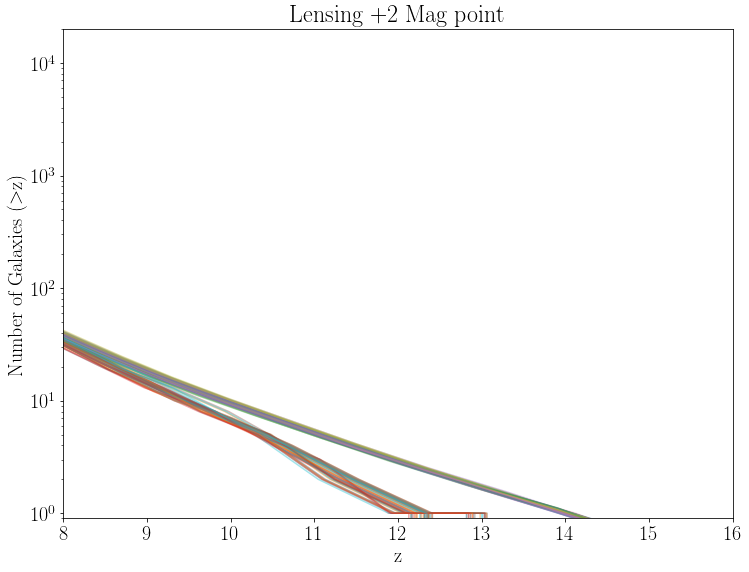

In [34]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design modeling the effect of lensing by increasing limiting magnitude of JADES Deep survey by 2
    # Assumes this is over one square arcsecond
    lensing_2 = survey(30.7 + 2, 1/3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4), 1)
    mean_lens, med_lens, z_vals_lens = mean_median(lensing_2)
    lensing_rest = survey(30.7, 8.6/3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4), 1)
    mean_lens1, med_lens1, zvals1  = mean_median(lensing_rest)
    mean_lens+=mean_lens1
    med_lens+=med_lens1
    summed+=med_lens
    summean+=mean_lens

    ax.plot(z_vals_lens, mean_lens, alpha=0.4, label = "Mean")
    ax.plot(z_vals_lens, med_lens, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e4), xlim=(8,16), title='Lensing +2 Mag point')
winsound.Beep(400,300)

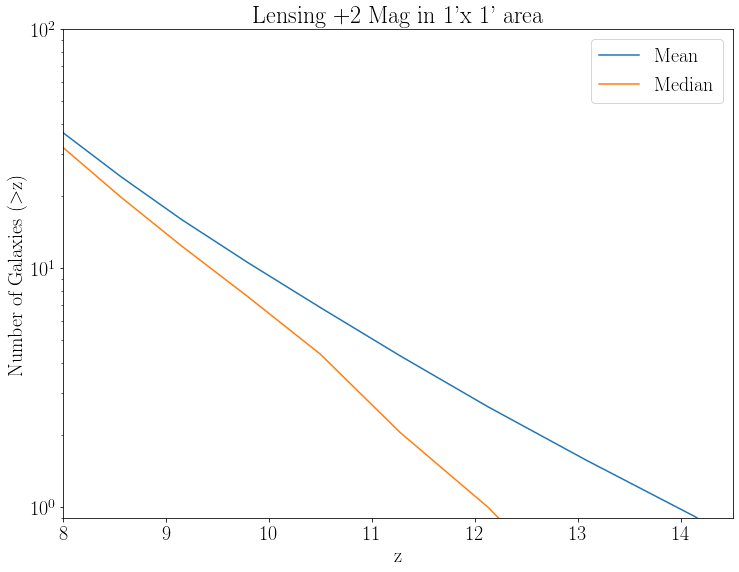

In [35]:
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,1e2), xlim=(8,14.5), title="Lensing +2 Mag in 1'x 1' area")
if save==1:
    plt.savefig("figs/"+file+"/lenspoint+2.pdf")

In [36]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9992301120689976
0.9997530345408119


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(12.126999999997713, 13.0755, 13.966999999996693)

In [40]:
from scipy.interpolate import interp1d
from tqdm import tqdm
N=50
def find_min(f):
    x=8
    while f(x)>1:
        x+=0.001
#     print(f(x))
    return x
allmed=[]
allmedrough=[]
allmean=[]
mean_point=[]
med_pointrough=[]
med_point=[]
numpoint=10**np.arange(0,3.3,0.3)
for points in numpoint:
    summed=np.zeros(len(z_vals))
    summean=np.zeros(len(z_vals))
    for _ in tqdm(range(N)):   
        # Survey design assuming 200 parallel pointings of JWST

        parallel_2000 = survey(29.25, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), int(points))
        mean_2000, med_2000, z_vals_2000 = mean_median(parallel_2000)
        fmed = interp1d(z_vals, med_2000, 'cubic')
        fmean = interp1d(z_vals, mean_2000, "cubic")
        z_med, z_mean = find_min(fmed), find_min(fmean)
        allmed.append(z_med)
        allmean.append(z_mean)
        summed+=med_2000
        summean+=mean_2000
    fmed = interp1d(z_vals, summed/N, 'cubic')
    fmean = interp1d(z_vals, summean/N, "cubic")
    z_med, z_mean = find_min(fmed), find_min(fmean)
    z_med2=z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())]
    mean_point.append(z_mean), med_pointrough.append(z_med2), med_point.append(z_med)
winsound.Beep(400,300)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [37:19<00:00, 44.79s/it]
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in add
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [27:34<00:00, 33.10s/it]
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in add
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [26:53<00:00, 32.26s/it]
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
C:\Users\chris\Anaconda3\lib\site-packages\ipyk

In [41]:
allmed=np.array(allmed).reshape(11,50)
staterr=np.std(allmed, axis=1)
close=[]
for point in med_point:
    close.append(74-np.argmin(abs(z_vals-point)))
syserr=[]
k=0
for p in close:
    err=z_vals[p+1]-z_vals[p-1]
    if np.isclose(staterr[k], 0):
        syserr.append(err/4)
    else:
        syserr.append(err/10)
    k+=1
syserr=np.array(syserr)
errs=np.sqrt(staterr**2+syserr**2)
errs

array([0.10374049, 0.10364347, 0.31680772, 0.16173117, 0.36975   ,
       0.407875  , 0.4515    , 0.501375  , 0.50413796, 0.50332332,
       0.62575   ])

In [42]:
staterr

array([1.23729544e-02, 1.15312445e-02, 2.92060895e-01, 8.97400000e-02,
       0.00000000e+00, 0.00000000e+00, 1.77635684e-15, 1.77635684e-15,
       4.51863342e-01, 4.50954277e-01, 1.77635684e-15])

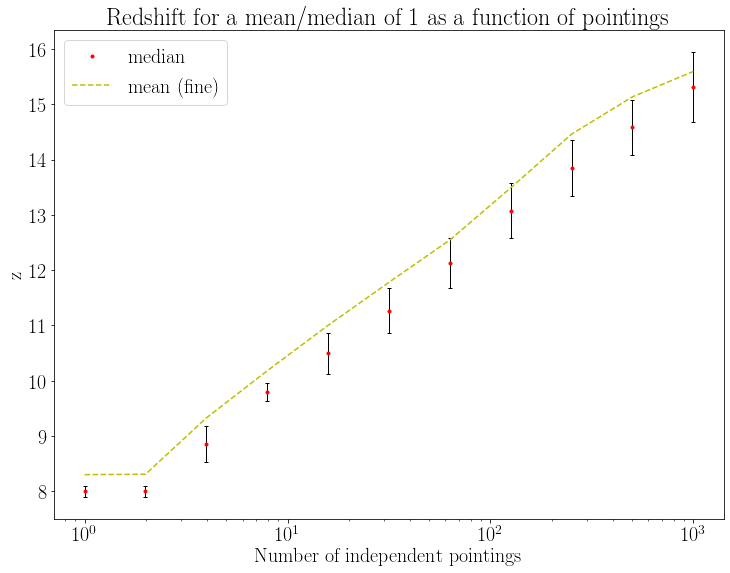

In [43]:
fig, ax=plt.subplots(figsize=(12,9))
ax.plot(numpoint, med_point, 'r.', label='median')
ax.errorbar(numpoint, med_point, errs, color = 'k', elinewidth = 1, capsize = 2, ls = 'none')
ax.plot(numpoint, mean_point, 'y--', label='mean (fine)')
ax.set(xlabel='Number of independent pointings', ylabel='z',xscale='log',
       title='Redshift for a mean/median of 1 as a function of pointings')
ax.legend()

[1.1914584  7.65593333]
[1.16761086 7.32910525]


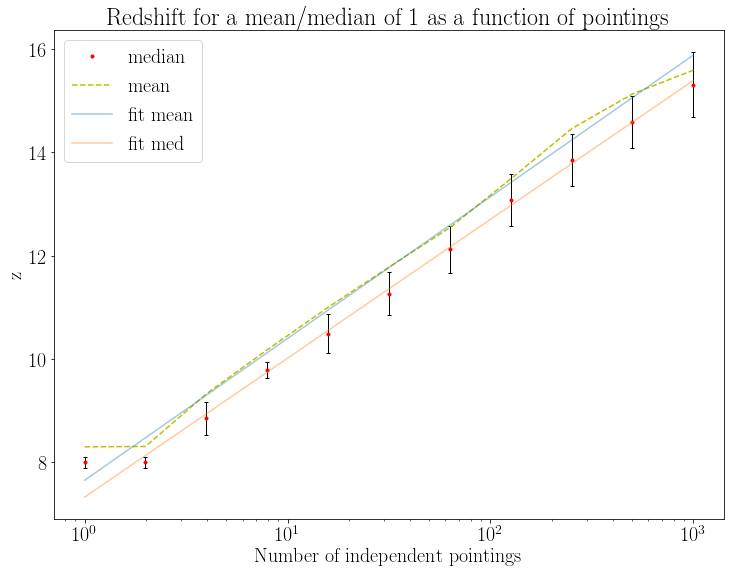

In [44]:
from scipy.optimize import curve_fit
k1=1
k2=2
plot=1
def pol(x,b,c):
    return b*np.log(x)+c

vals, cov=curve_fit(pol, numpoint[k1:], mean_point[k1:], p0=[0.01,-10])
if plot:
    fig, ax=plt.subplots(figsize=(12,9))
    ax.plot(numpoint, med_point, 'r.', label='median')
    ax.errorbar(numpoint, med_point, errs, color = 'k', elinewidth = 1, capsize = 2, ls = 'none')
    ax.plot(numpoint, mean_point, 'y--', label='mean')
    ax.plot(numpoint, pol(numpoint, vals[0], vals[1]), alpha=0.4, label='fit mean')
print(vals)
vals, cov=curve_fit(pol, numpoint[k2:], med_point[k2:], p0=[0.01,-10], sigma=errs[k2:])
if plot:
    ax.plot(numpoint, pol(numpoint, vals[0], vals[1]), alpha=0.4, label='fit med')
    ax.set(xlabel='Number of independent pointings', ylabel='z',xscale='log',
           title='Redshift for a mean/median of 1 as a function of pointings')
    ax.legend();
print(vals)
res=0
for i in range(len(numpoint[k2:])):
    res+=(med_point[k2+i]-pol(numpoint[k2+i], vals[0], vals[1]))**2/errs[k2+i]**2
from scipy.stats import chi2
1-chi2.cdf(res, len(numpoint[k2:])-2), np.exp(1/vals[0])
plt.savefig('figs/'+file+'/funcpoint.pdf')

In [51]:
pol(140, vals[0], vals[1])

13.099020584335667

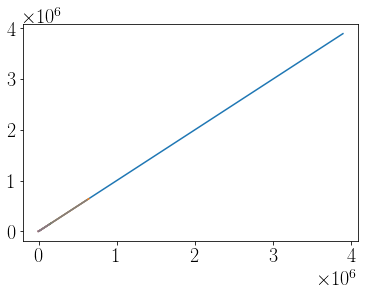

In [45]:
plt.plot(mean1000final, med1000final)
plt.plot(mean100final, med100final)
plt.plot(mean20final, med20final)
plt.plot(mean1final, med1final)
plt.plot(meandeepfinal, meddeepfinal)
plt.plot(meandeepEfinal, meddeepEfinal)
plt.plot(meanwidefinal, medwidefinal)
plt.plot(meanwideEfinal, medwideEfinal)

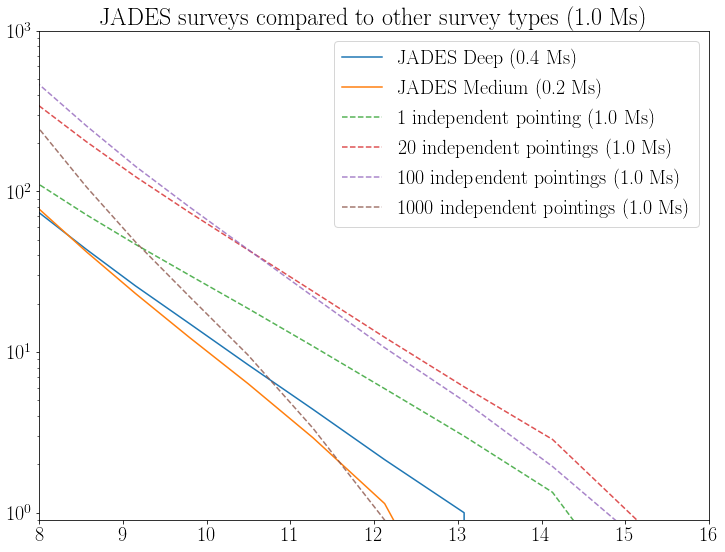

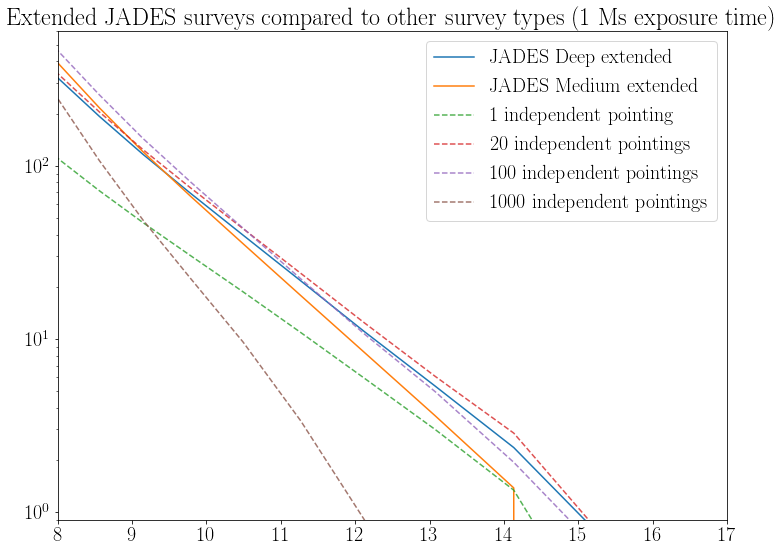

In [47]:
fig, ax = plt.subplots(1, figsize=(12,9))
ax.plot(z_vals, meddeepfinal, label='JADES Deep (0.4 Ms)')
ax.plot(z_vals, medwidefinal, label='JADES Medium (0.2 Ms)')
ax.plot(z_vals, med1final,alpha=0.8, linestyle='dashed', label='1 independent pointing (1.0 Ms)')
ax.plot(z_vals, med20final, alpha=0.8, linestyle='dashed', label='20 independent pointings (1.0 Ms)')
ax.plot(z_vals, med100final, alpha=0.8, linestyle='dashed', label='100 independent pointings (1.0 Ms)')
ax.plot(z_vals, med1000final, alpha=0.8, linestyle='dashed', label='1000 independent pointings (1.0 Ms)')
ax.set(ylim=(0.9,1e3), xlim=(8,16), yscale='log', title='JADES surveys compared to other survey types (1.0 Ms)')
ax.legend()

fig, ax = plt.subplots(1, figsize=(12,9))
ax.plot(z_vals, meddeepEfinal, label='JADES Deep extended')
ax.plot(z_vals, medwideEfinal, label='JADES Medium extended')
ax.plot(z_vals, med1final,alpha=0.8, linestyle='dashed', label='1 independent pointing')
ax.plot(z_vals, med20final, alpha=0.8, linestyle='dashed', label='20 independent pointings')
ax.plot(z_vals, med100final, alpha=0.8, linestyle='dashed', label='100 independent pointings')
ax.plot(z_vals, med1000final, alpha=0.8, linestyle='dashed', label='1000 independent pointings')
ax.set(ylim=(0.9,6e2), xlim=(8,17), yscale='log', title='Extended JADES surveys compared to other survey types (1 Ms exposure time)')
ax.legend()
plt.savefig('figs/'+file+'/JADES_comparison.pdf')